In [1]:
import os
import pandas as pd
import numpy as np
import optuna
import plotnine as p9
import sklearn.metrics
import itertools
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TRIALS = 250
TOP_N = 5

In [3]:
def load_performance_metrics(dataset, gnn, PLM, method, aggregation, target_metric, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{PLM.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N)
  
  performance = list()
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    random_states = [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{trial}/{x}')]
    if len(random_states) < 10:
      continue

    for random_state in random_states:
      df = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
    break
  
  performance_df = pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])
  return performance_df.groupby(['trial', 'split']).agg(
    performance_mean = (target_metric, 'mean'),
    performance_std = (target_metric, 'std')
  ).reset_index()

In [4]:
def get_all_performance_metrics(datasets, target_metrics, gnns, PLMs, methods, aggregations):
  l = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for PLM in PLMs:
        for method in methods:
          for aggregation in aggregations:
            l.append(
              load_performance_metrics(
                dataset = dataset,
                gnn = gnn,
                PLM = PLM,
                method = method,
                aggregation = aggregation,
                target_metric = target_metric,
                display_information = False
              ).assign(
                dataset = dataset,
                gnn = gnn,
                PLM = PLM,
                method = method,
                aggregation = aggregation
              ).drop(columns = ['trial'])
            )
  return pd.concat(l, axis = 0).reset_index(drop = True)

In [5]:
def load_performance_metrics_for_T_tests(dataset, gnn, PLM, method, aggregation, target_metric, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{PLM.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N)
  
  performance = list()
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    random_states = [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{trial}/{x}')]
    if len(random_states) < 10:
      continue

    for random_state in random_states:
      df = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
    break
  
  return pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])[['random_state', 'split', target_metric]].rename(columns = {target_metric : 'performance'})

In [6]:
def get_all_performance_metrics_for_T_tests(datasets, target_metrics, gnns, PLMs, methods, aggregations):
  l = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for PLM in PLMs:
        for method in methods:
          for aggregation in aggregations:
            l.append(
              load_performance_metrics_for_T_tests(
                dataset = dataset,
                gnn = gnn,
                PLM = PLM,
                method = method,
                aggregation = aggregation,
                target_metric = target_metric,
                display_information = False
              ).assign(
                dataset = dataset,
                gnn = gnn,
                PLM = PLM,
                method = method,
                aggregation = aggregation
              )
            )
  return pd.concat(l, axis = 0).reset_index(drop = True)

# Rank analysis of best metric (F1-score or accuracy) for each data set

## GAT vs. GATv2 + Grouped vs. Surrogate

In [7]:
gat_vs_gatv2_grouped_vs_surrogate_df = get_all_performance_metrics(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GAT', 'GATv2'],
  PLMs = ['google-bert-bert-base-uncased'],
  methods = ['Grouped', 'Surrogate'],
  aggregations = ['No_Aggregation'],
)

In [8]:
for column in [x for x in gat_vs_gatv2_grouped_vs_surrogate_df.columns if x.endswith('_mean')]:
  gat_vs_gatv2_grouped_vs_surrogate_df[f'{column}_rank'] = gat_vs_gatv2_grouped_vs_surrogate_df[['dataset', 'split', 'PLM', 'aggregation', column]] \
    .groupby(['dataset', 'split', 'PLM', 'aggregation', ]) \
    .rank(method = 'max', ascending = False)

In [9]:
gat_vs_gatv2_grouped_vs_surrogate_ranked_df = gat_vs_gatv2_grouped_vs_surrogate_df.groupby(['split', 'gnn', 'method']).agg(
  performance_rank_mean = ('performance_mean_rank', 'mean'),
  performance_rank_std = ('performance_mean_rank', 'std'),
).reset_index()

In [10]:
gat_vs_gatv2_grouped_vs_surrogate_ranked_df['label'] = gat_vs_gatv2_grouped_vs_surrogate_ranked_df['performance_rank_mean'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212')) + ' ± ' + gat_vs_gatv2_grouped_vs_surrogate_ranked_df['performance_rank_std'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212'))

In [11]:
gat_vs_gatv2_grouped_vs_surrogate_ranked_df['split'] = gat_vs_gatv2_grouped_vs_surrogate_ranked_df['split'].replace({'test' : 'Testing'}).str.capitalize()
gat_vs_gatv2_grouped_vs_surrogate_ranked_df['split'] = pd.Categorical(gat_vs_gatv2_grouped_vs_surrogate_ranked_df['split'], categories = ['Validation', 'Testing'])

In [12]:
plot = p9.ggplot(gat_vs_gatv2_grouped_vs_surrogate_ranked_df[gat_vs_gatv2_grouped_vs_surrogate_ranked_df['split'] == 'Testing'],
  p9.aes(x = 'method', y = 'performance_rank_mean', fill = 'gnn')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000') + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_rank_mean - performance_rank_std', ymax = 'performance_rank_mean + performance_rank_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.geom_text(p9.aes(y = 'performance_rank_mean + performance_rank_std + 0.15', label = 'label'), position = p9.position_dodge2(width = .9), size = 20) + \
  p9.xlab('Variant') + \
  p9.ylab('Rank') + \
  p9.labs(fill = 'GNN') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(0, 5) + \
  p9.theme(
    legend_position = [.24, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

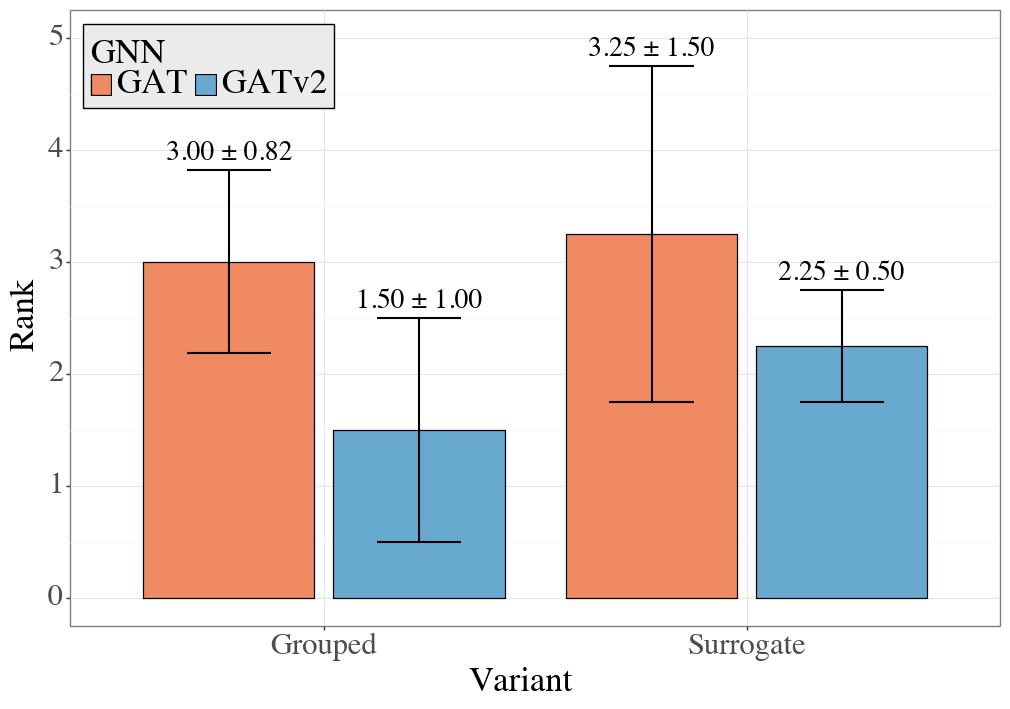

<ggplot: (812633767)>

In [13]:
plot

In [14]:
plot.save(filename = './paper_figures/gat_vs_gatv2_grouped_vs_surrogate_ranked.png', dpi = 300)

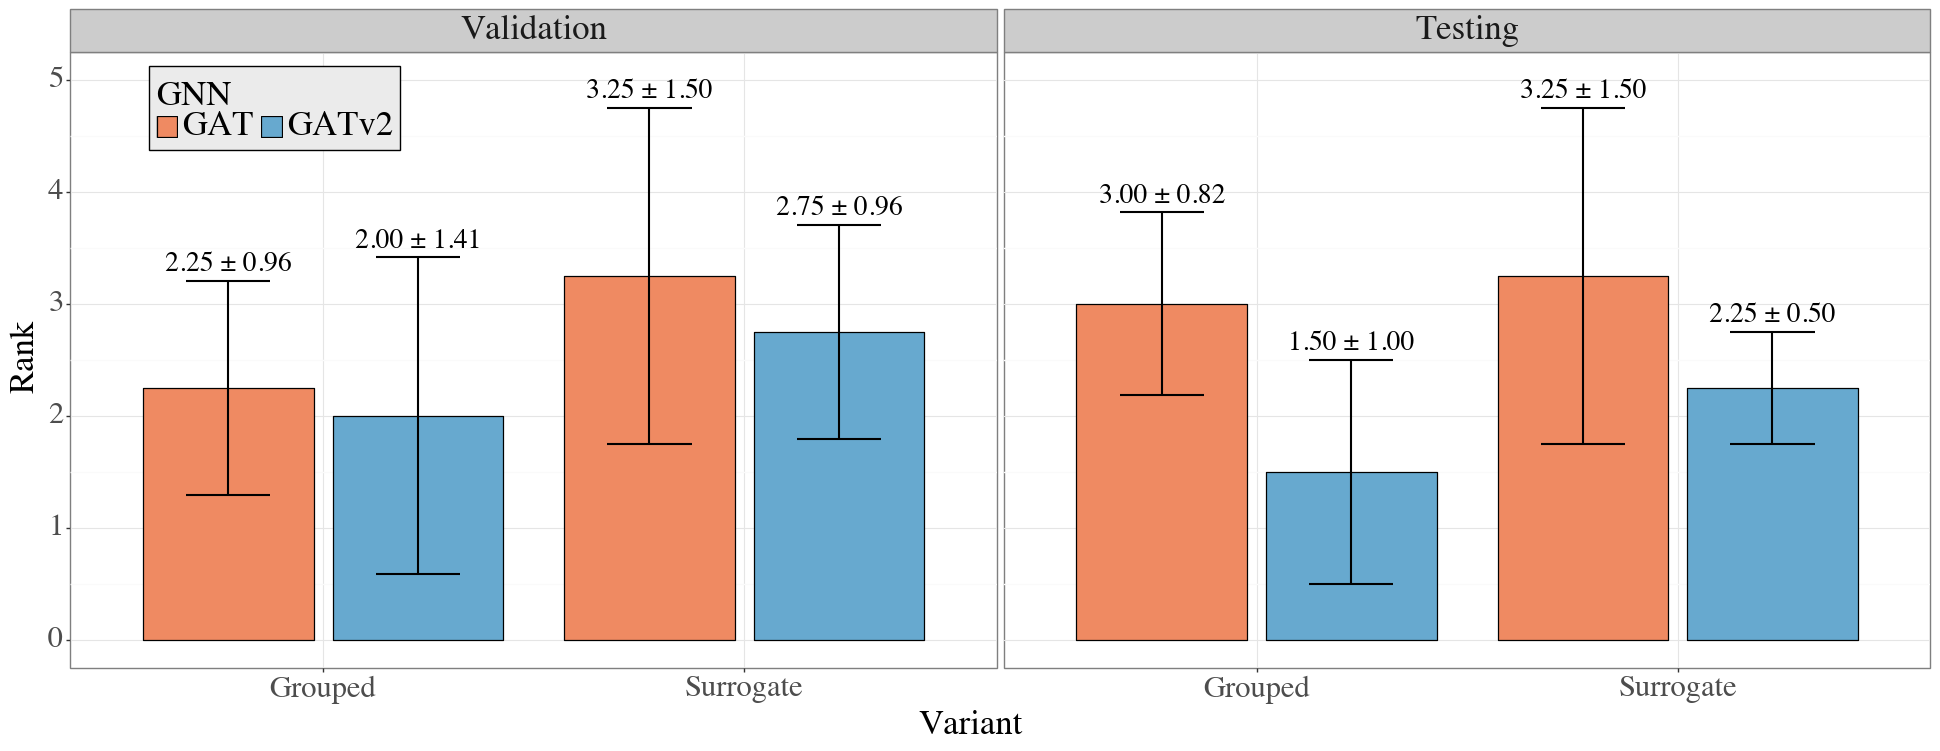

<ggplot: (812409016)>

In [15]:
p9.ggplot(gat_vs_gatv2_grouped_vs_surrogate_ranked_df,
  p9.aes(x = 'method', y = 'performance_rank_mean', fill = 'gnn')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000') + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_rank_mean - performance_rank_std', ymax = 'performance_rank_mean + performance_rank_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.geom_text(p9.aes(y = 'performance_rank_mean + performance_rank_std + 0.15', label = 'label'), position = p9.position_dodge2(width = .9), size = 20) + \
  p9.facet_wrap('~ split', ncol = 2) + \
  p9.xlab('Variant') + \
  p9.ylab('Rank') + \
  p9.labs(fill = 'GNN') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(0, 5) + \
  p9.theme(
    legend_position = [.21, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )


## Aggregation level

In [16]:
aggregation_level_df = get_all_performance_metrics(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  PLMs = ['google-bert-bert-base-uncased'],
  methods = ['Grouped'],
  aggregations = ['No_Aggregation', 'Layer-wise_Aggregation', 'Global_Aggregation'],
)

In [17]:
aggregation_level_df['aggregation'] = aggregation_level_df['aggregation'].replace({
  'No_Aggregation' : 'None',
  'Layer-wise_Aggregation' : 'Layer-wise',
  'Global_Aggregation' : 'Full'
})

In [18]:
for column in [x for x in aggregation_level_df.columns if x.endswith('_mean')]:
  aggregation_level_df[f'{column}_rank'] = aggregation_level_df[['dataset', 'split', 'PLM', 'gnn', 'method', column]] \
    .groupby(['dataset', 'split', 'PLM', 'gnn', 'method']) \
    .rank(method = 'max', ascending = False)

In [19]:
aggregation_level_ranked_df = aggregation_level_df.groupby(['split', 'aggregation']).agg(
  performance_rank_mean = ('performance_mean_rank', 'mean'),
  performance_rank_std = ('performance_mean_rank', 'std'),
).reset_index()

In [20]:
aggregation_level_ranked_df['label'] = aggregation_level_ranked_df['performance_rank_mean'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212')) + ' ± ' + aggregation_level_ranked_df['performance_rank_std'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212'))

In [21]:
aggregation_level_ranked_df['split'] = aggregation_level_ranked_df['split'].replace({'test' : 'Testing'}).str.capitalize()
aggregation_level_ranked_df['split'] = pd.Categorical(aggregation_level_ranked_df['split'], categories = ['Validation', 'Testing'])

In [22]:
plot = p9.ggplot(aggregation_level_ranked_df[aggregation_level_ranked_df['split'] == 'Testing'],
  p9.aes(x = 'aggregation', y = 'performance_rank_mean')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000', fill = '#ef8a62') + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_rank_mean - performance_rank_std', ymax = 'performance_rank_mean + performance_rank_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.geom_text(p9.aes(y = 'performance_rank_mean + performance_rank_std + 0.15', label = 'label'), position = p9.position_dodge2(width = .9), size = 20) + \
  p9.xlab('Aggregation level') + \
  p9.ylab('Rank') + \
  p9.ylim(0, 5) + \
  p9.theme(
    legend_position = [.24, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

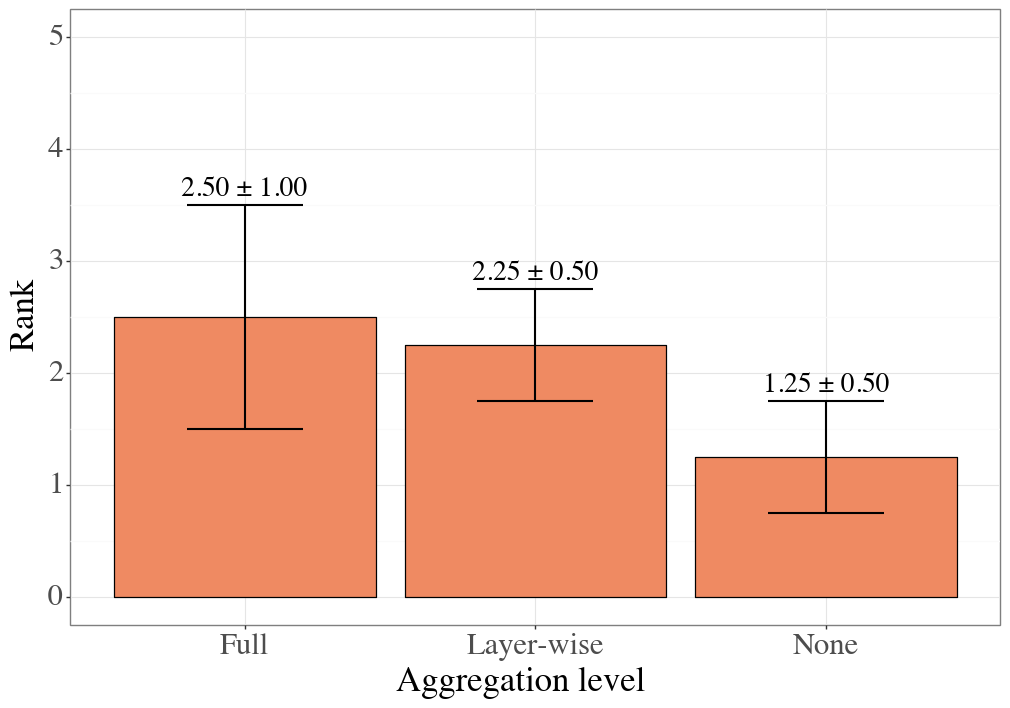

<ggplot: (812124148)>

In [23]:
plot

In [24]:
plot.save(filename = './paper_figures/aggregation_level_ranked.png', dpi = 300)

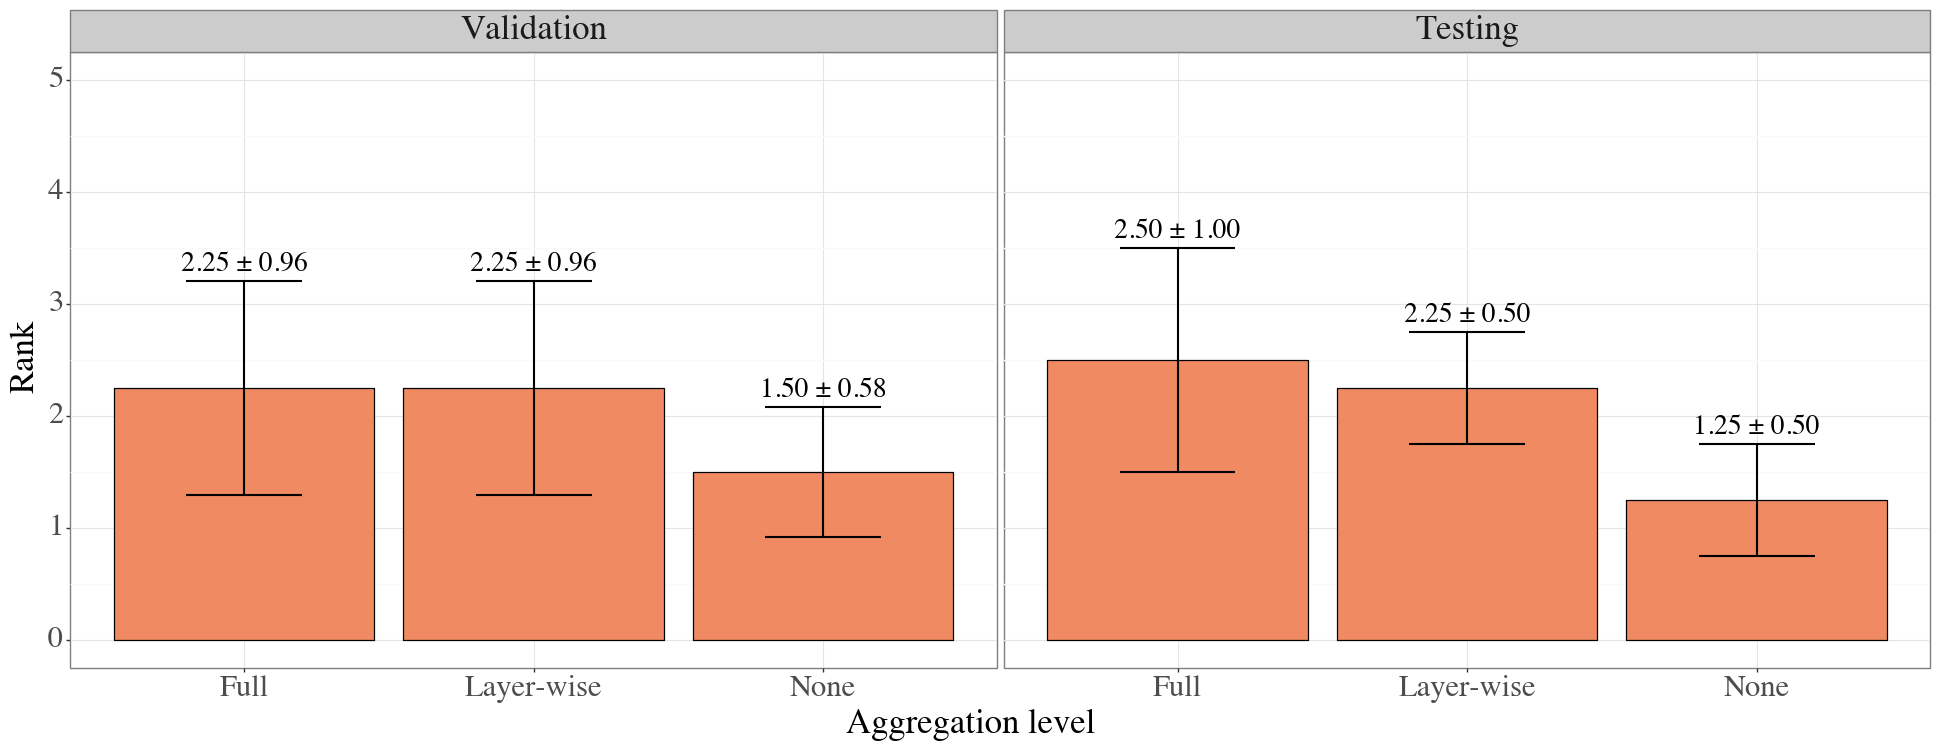

<ggplot: (811770277)>

In [25]:
p9.ggplot(aggregation_level_ranked_df,
  p9.aes(x = 'aggregation', y = 'performance_rank_mean')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000', fill = '#ef8a62') + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_rank_mean - performance_rank_std', ymax = 'performance_rank_mean + performance_rank_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.geom_text(p9.aes(y = 'performance_rank_mean + performance_rank_std + 0.15', label = 'label'), position = p9.position_dodge2(width = .9), size = 20) + \
  p9.facet_wrap('~ split', ncol = 2) + \
  p9.xlab('Aggregation level') + \
  p9.ylab('Rank') + \
  p9.ylim(0, 5) + \
  p9.theme(
    legend_position = [.24, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

## Comparing different pre-trained PLMs

In [26]:
different_PLMs_df = get_all_performance_metrics(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  PLMs = ['google-bert-bert-base-uncased', 'facebook-bart-base', 'FacebookAI-roberta-base', 'xlnet-xlnet-base-cased'],
  methods = ['Grouped'],
  aggregations = ['No_Aggregation'],
)

In [27]:
different_PLMs_df['PLM'] = different_PLMs_df['PLM'].replace({
  'google-bert-bert-base-uncased' : 'BERT',
  'facebook-bart-base' : 'BART',
  'FacebookAI-roberta-base' : 'RoBERTa',
  'xlnet-xlnet-base-cased' : 'XLNet'
})

In [28]:
for column in [x for x in different_PLMs_df.columns if x.endswith('_mean')]:
  different_PLMs_df[f'{column}_rank'] = different_PLMs_df[['dataset', 'split', 'gnn', 'method', 'aggregation', column]] \
    .groupby(['dataset', 'split', 'gnn', 'method', 'aggregation']) \
    .rank(method = 'max', ascending = False)

In [29]:
different_PLMs_ranked_df = different_PLMs_df.groupby(['split', 'PLM']).agg(
  performance_rank_mean = ('performance_mean_rank', 'mean'),
  performance_rank_std = ('performance_mean_rank', 'std'),
).reset_index()

In [30]:
different_PLMs_ranked_df['label'] = different_PLMs_ranked_df['performance_rank_mean'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212')) + ' ± ' + different_PLMs_ranked_df['performance_rank_std'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212'))

In [31]:
different_PLMs_ranked_df['split'] = different_PLMs_ranked_df['split'].replace({'test' : 'Testing'}).str.capitalize()
different_PLMs_ranked_df['split'] = pd.Categorical(different_PLMs_ranked_df['split'], categories = ['Validation', 'Testing'])

In [32]:
plot = p9.ggplot(different_PLMs_ranked_df[different_PLMs_ranked_df['split'] == 'Testing'],
  p9.aes(x = 'PLM', y = 'performance_rank_mean')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000', fill = '#ef8a62') + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_rank_mean - performance_rank_std', ymax = 'performance_rank_mean + performance_rank_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.geom_text(p9.aes(y = 'performance_rank_mean + performance_rank_std + 0.15', label = 'label'), position = p9.position_dodge2(width = .9), size = 20) + \
  p9.xlab('PLM') + \
  p9.ylab('Rank') + \
  p9.ylim(0, 5) + \
  p9.theme(
    legend_position = [.24, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

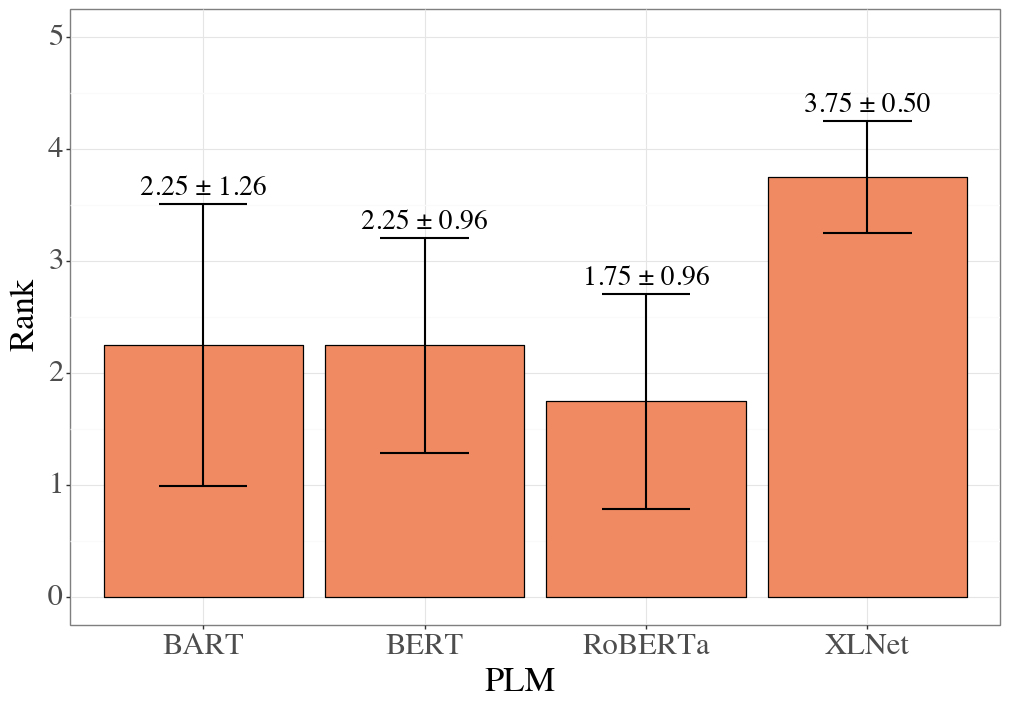

<ggplot: (811475389)>

In [33]:
plot

In [34]:
plot.save(filename = './paper_figures/different_PLMs_ranked.png', dpi = 300)

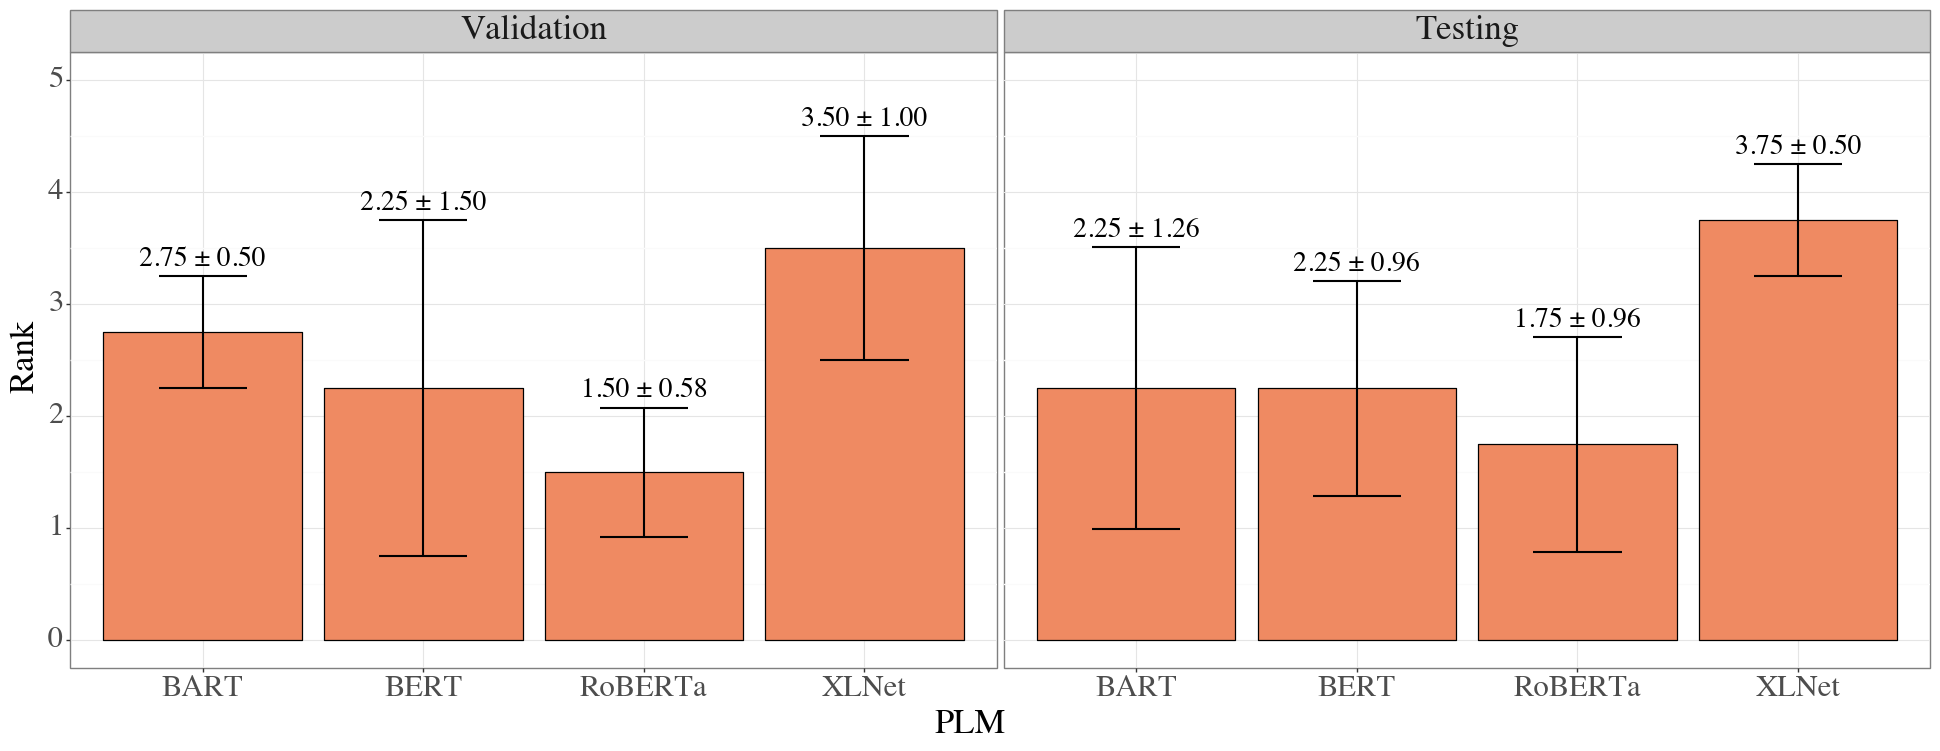

<ggplot: (811846774)>

In [35]:
p9.ggplot(different_PLMs_ranked_df,
  p9.aes(x = 'PLM', y = 'performance_rank_mean')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000', fill = '#ef8a62') + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_rank_mean - performance_rank_std', ymax = 'performance_rank_mean + performance_rank_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.geom_text(p9.aes(y = 'performance_rank_mean + performance_rank_std + 0.15', label = 'label'), position = p9.position_dodge2(width = .9), size = 20) + \
  p9.facet_wrap('~ split', ncol = 2) + \
  p9.xlab('PLM') + \
  p9.ylab('Rank') + \
  p9.ylim(0, 5) + \
  p9.theme(
    legend_position = [.24, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

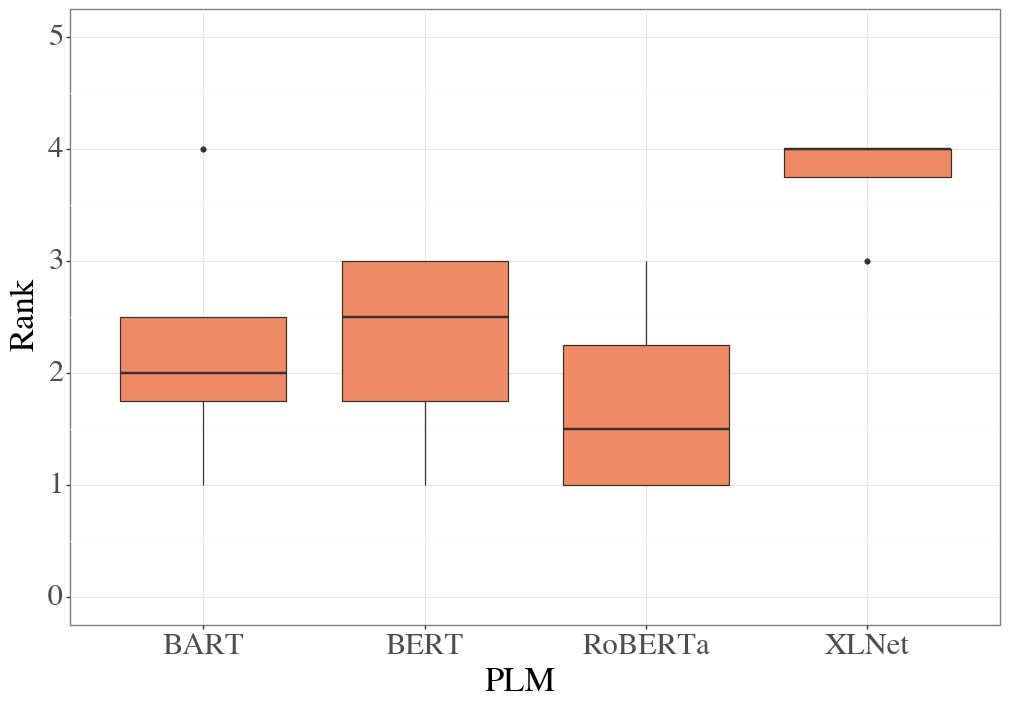

<ggplot: (812535457)>

In [36]:
p9.ggplot(different_PLMs_df[different_PLMs_df['split'] == 'test'],
  p9.aes(x = 'PLM', y = 'performance_mean_rank', group = 'PLM')) + \
  p9.theme_bw() + \
  p9.geom_boxplot(fill = '#ef8a62') + \
  p9.xlab('PLM') + \
  p9.ylab('Rank') + \
  p9.ylim(0, 5) + \
  p9.theme(
    legend_position = [.24, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

In [37]:
different_PLMs_df[different_PLMs_df['split'] == 'test'].groupby(by = ['PLM']).agg(
  median_rank = ('performance_mean_rank', 'median')
)

median_rank
PLM                 
BART             2.0
BERT             2.5
RoBERTa          1.5
XLNet            4.0

# Performance change analysis using the best metrics (F1-score or accuracy) for each data set

## Base vs. Large PLMs

In [38]:
base_vs_large_PLMs_df = get_all_performance_metrics_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['facebook-bart-base', 'facebook-bart-large', 'FacebookAI-roberta-base', 'FacebookAI-roberta-large'],
    methods = ['Grouped'],
    aggregations = ['No_Aggregation'],
  )

In [39]:
base_vs_large_PLMs_df['PLM'] = base_vs_large_PLMs_df['PLM'].replace({
  'facebook-bart-base' : 'BART',
  'facebook-bart-large' : 'BART-L',
  'FacebookAI-roberta-base' : 'RoBERTa',
  'FacebookAI-roberta-large' : 'RoBERTa-L',
})
base_vs_large_PLMs_df['dataset'] = base_vs_large_PLMs_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

In [40]:
base_vs_large_PLMs_df = base_vs_large_PLMs_df \
  .drop(columns = ['gnn', 'method', 'aggregation']) \
  .pivot(index = ['dataset', 'split', 'random_state'], columns = 'PLM', values = 'performance') \
  .reset_index() \
  .assign(
    BART_difference = lambda df : df['BART-L'] - df['BART'],
    RoBERTa_difference = lambda df : df['RoBERTa-L'] - df['RoBERTa']
  ) \
  .melt(
    id_vars = ['dataset', 'split', 'random_state'], 
    value_vars = ['BART_difference', 'RoBERTa_difference'], 
    var_name = 'PLM',
    value_name = 'difference'
  ) \
  .assign(
    PLM = lambda df : df['PLM'].str.replace('_difference', '-L', regex = False),
    difference = lambda df : df['difference'] * 100
  ) \
  .sort_values(by = ['dataset', 'random_state']) \
  .groupby(by = ['dataset', 'split', 'PLM']) \
  .agg(
    performance_difference_mean = ('difference', 'mean'),
    performance_difference_std = ('difference', 'std'),
  ).reset_index()

In [41]:
base_vs_large_PLMs_df['label'] = base_vs_large_PLMs_df['performance_difference_mean'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212')) + ' ± ' + base_vs_large_PLMs_df['performance_difference_std'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212'))

In [42]:
base_vs_large_PLMs_df['split'] = base_vs_large_PLMs_df['split'].replace({'test' : 'Testing'}).str.capitalize()
base_vs_large_PLMs_df['split'] = pd.Categorical(base_vs_large_PLMs_df['split'], categories = ['Validation', 'Testing'])

In [43]:
plot = p9.ggplot(base_vs_large_PLMs_df[base_vs_large_PLMs_df['split'] == 'Testing'],
  p9.aes(x = 'dataset', y = 'performance_difference_mean', fill = 'PLM')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000') + \
  p9.geom_text(p9.aes(y = 'performance_difference_mean + performance_difference_std + 1.75', label = 'label'), position = p9.position_dodge2(width = .9), size = 20, angle = 90) + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_difference_mean - performance_difference_std', ymax = 'performance_difference_mean + performance_difference_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.xlab('Data set') + \
  p9.ylab('Performance change') + \
  p9.labs(fill = 'PLM') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(-1.5, 10) + \
  p9.theme(
    legend_position = [.735, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

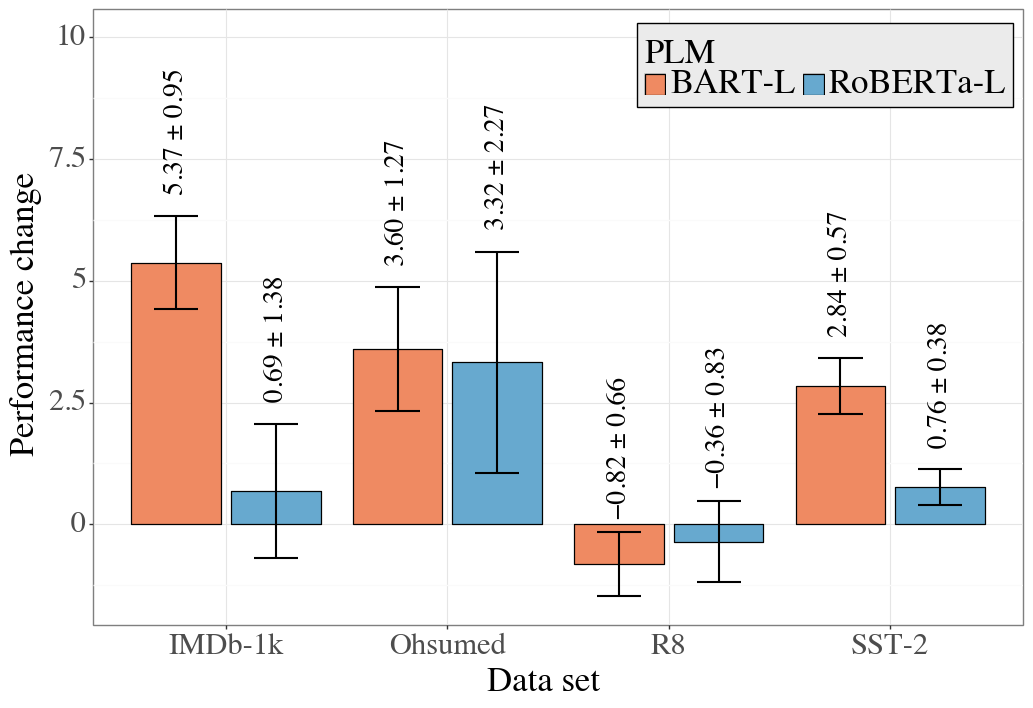

<ggplot: (812493894)>

In [44]:
plot

In [45]:
plot.save(filename = './paper_figures/base_vs_large_PLMs.png', dpi = 300)

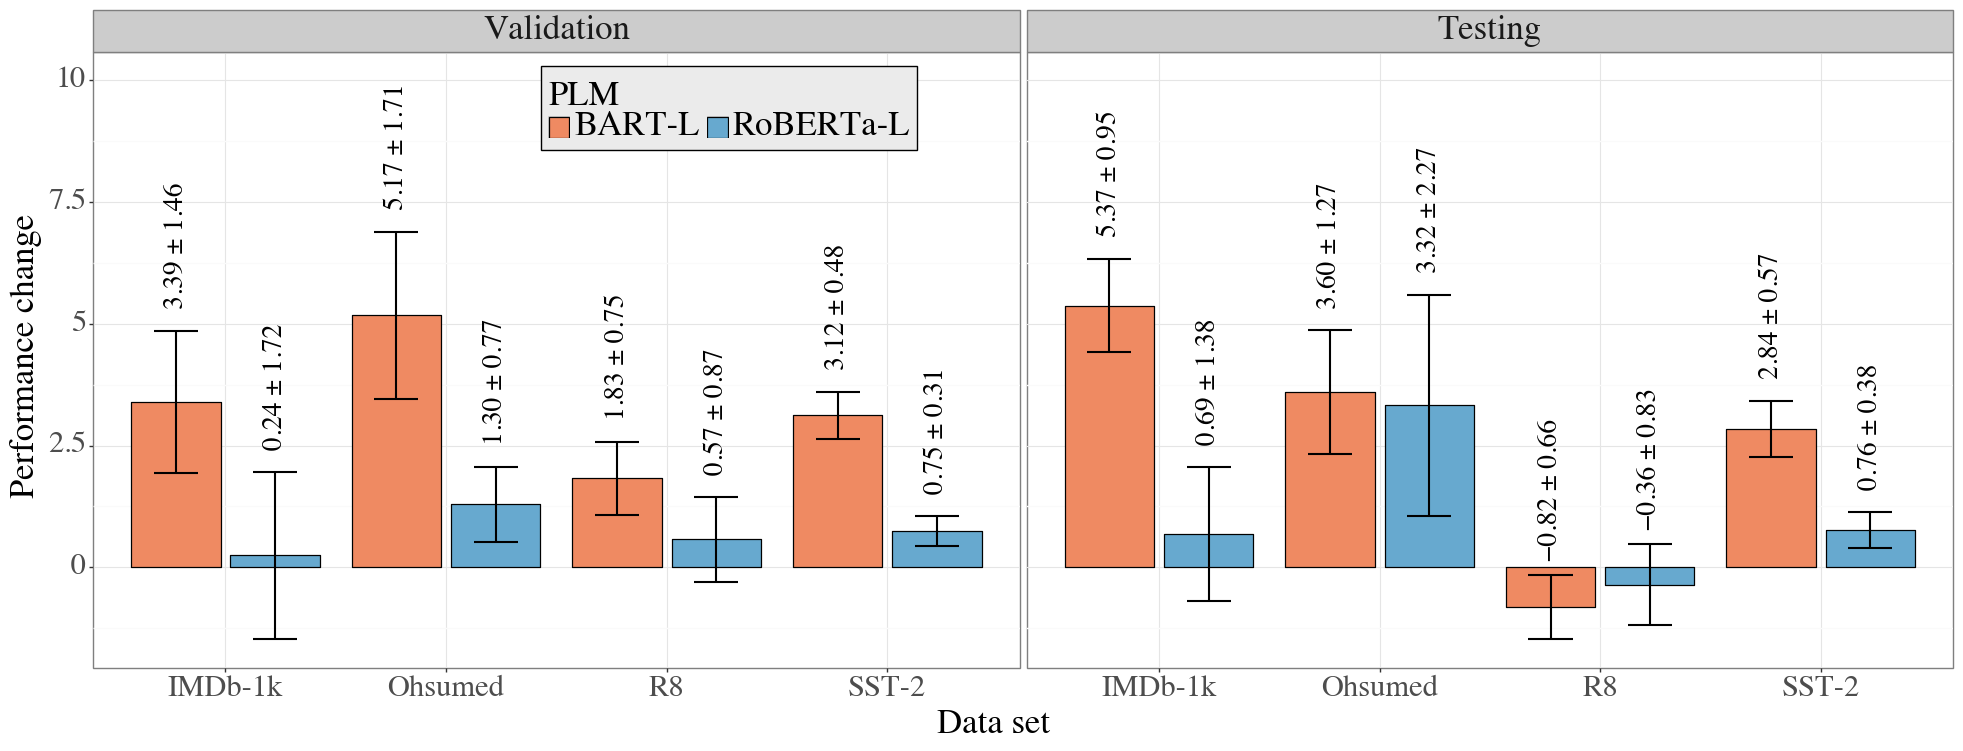

<ggplot: (812112254)>

In [46]:
p9.ggplot(base_vs_large_PLMs_df,
  p9.aes(x = 'dataset', y = 'performance_difference_mean', fill = 'PLM')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000') + \
  p9.geom_text(p9.aes(y = 'performance_difference_mean + performance_difference_std + 1.75', label = 'label'), position = p9.position_dodge2(width = .9), size = 20, angle = 90) + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_difference_mean - performance_difference_std', ymax = 'performance_difference_mean + performance_difference_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.facet_wrap('~ split', ncol = 2) + \
  p9.xlab('Data set') + \
  p9.ylab('Performance change') + \
  p9.labs(fill = 'PLM') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(-1.5, 10) + \
  p9.theme(
    legend_position = [.39, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

#### Are the differences statistically significant?

In [47]:
base_vs_large_PLMs_stats_df = get_all_performance_metrics_for_T_tests(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  PLMs = ['facebook-bart-base', 'facebook-bart-large', 'FacebookAI-roberta-base', 'FacebookAI-roberta-large'],
  methods = ['Grouped'],
  aggregations = ['No_Aggregation'],
)

In [48]:
base_vs_large_PLMs_stats_df['PLM'] = base_vs_large_PLMs_stats_df['PLM'].replace({
  'facebook-bart-base' : 'BART',
  'facebook-bart-large' : 'BART-L',
  'FacebookAI-roberta-base' : 'RoBERTa',
  'FacebookAI-roberta-large' : 'RoBERTa-L',
})
base_vs_large_PLMs_stats_df['dataset'] = base_vs_large_PLMs_stats_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

In [49]:

for dataset in ['SST-2', 'Ohsumed', 'R8', 'IMDb-1k']:
  print('-' * 10, dataset, '-' * 10)
  for i, split in enumerate(['validation', 'test']):
    print('>>', split)
    split_df = base_vs_large_PLMs_stats_df[(base_vs_large_PLMs_stats_df['dataset'] == dataset) & (base_vs_large_PLMs_stats_df['split'] == split)].drop(columns = ['split', 'gnn', 'method', 'aggregation']) \
      .pivot(index = ['dataset', 'random_state'], columns = 'PLM', values = 'performance') \
      .reset_index() \
      .sort_values(by = ['dataset', 'random_state'])
    
    #for (x, y) in itertools.combinations(['No_Ablation', 'Random_Attentions', 'Random_Weights', 'Unitary_Weights', 'Single_Unitary_Weight'], 2):
    for (x, y) in [('BART', 'BART-L'), ('RoBERTa', 'RoBERTa-L')]:
      # H0: Mean Grouped and Surrogate scores are equal
      # H1: Mean Grouped and Surrogate scores are not equal
      statistic, p_value = stats.ttest_ind(split_df[x], split_df[y])
      # 95% confidence -- p-value < 0.05 => reject the null hypothesis (H0), i.e., the true mean test score is different between the approaches
      print(f'{x} - {y}:', 'Statistic:', statistic, 'P-value:', p_value, 'Reject H0?', p_value < 0.05)
  print('')

---------- SST-2 ----------
>> validation
BART - BART-L: Statistic: -21.153814572500696 P-value: 3.649890850951926e-14 Reject H0? True
RoBERTa - RoBERTa-L: Statistic: -5.732815062368993 P-value: 1.9568070333423123e-05 Reject H0? True
>> test
BART - BART-L: Statistic: -13.892028205176842 P-value: 4.6212396598563e-11 Reject H0? True
RoBERTa - RoBERTa-L: Statistic: -5.202349065342076 P-value: 6.00406379974042e-05 Reject H0? True

---------- Ohsumed ----------
>> validation
BART - BART-L: Statistic: -8.077739004029738 P-value: 2.1348226800903691e-07 Reject H0? True
RoBERTa - RoBERTa-L: Statistic: -5.814379000387682 P-value: 1.6518920939594844e-05 Reject H0? True
>> test
BART - BART-L: Statistic: -9.051877563725787 P-value: 4.042739037833941e-08 Reject H0? True
RoBERTa - RoBERTa-L: Statistic: -5.024039590962106 P-value: 8.813709307062627e-05 Reject H0? True

---------- R8 ----------
>> validation
BART - BART-L: Statistic: -6.839700562441782 P-value: 2.115117510504796e-06 Reject H0? True
RoB

## Grouped vs. surrogate using large PLMs

In [50]:
grouped_vs_surrogate_using_large_PLMs_df = get_all_performance_metrics_for_T_tests(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  PLMs = ['facebook-bart-large', 'FacebookAI-roberta-large'],
  methods = ['Grouped', 'Surrogate'],
  aggregations = ['No_Aggregation'],
)

In [51]:
grouped_vs_surrogate_using_large_PLMs_df['PLM'] = grouped_vs_surrogate_using_large_PLMs_df['PLM'].replace({
  'facebook-bart-large' : 'BART-L',
  'FacebookAI-roberta-large' : 'RoBERTa-L',
})
grouped_vs_surrogate_using_large_PLMs_df['dataset'] = grouped_vs_surrogate_using_large_PLMs_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

In [52]:
grouped_vs_surrogate_using_large_PLMs_df = grouped_vs_surrogate_using_large_PLMs_df \
  .drop(columns = ['gnn', 'aggregation']) \
  .pivot(index = ['dataset', 'split', 'random_state', 'PLM'], columns = 'method', values = 'performance') \
  .reset_index() \
  .assign(
    difference = lambda df : df['Surrogate'] - df['Grouped'],
  ) \
  .assign(
    difference = lambda df : df['difference'] * 100
  ) \
  .sort_values(by = ['dataset', 'random_state']) \
  .groupby(by = ['dataset', 'split', 'PLM']) \
  .agg(
    performance_difference_mean = ('difference', 'mean'),
    performance_difference_std = ('difference', 'std'),
  ).reset_index()

In [53]:
grouped_vs_surrogate_using_large_PLMs_df['label'] = grouped_vs_surrogate_using_large_PLMs_df['performance_difference_mean'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212')) + ' ± ' + grouped_vs_surrogate_using_large_PLMs_df['performance_difference_std'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212'))

In [54]:
grouped_vs_surrogate_using_large_PLMs_df['split'] = grouped_vs_surrogate_using_large_PLMs_df['split'].replace({'test' : 'Testing'}).str.capitalize()
grouped_vs_surrogate_using_large_PLMs_df['split'] = pd.Categorical(grouped_vs_surrogate_using_large_PLMs_df['split'], categories = ['Validation', 'Testing'])

In [55]:
plot = p9.ggplot(grouped_vs_surrogate_using_large_PLMs_df[(grouped_vs_surrogate_using_large_PLMs_df['split'] == 'Testing')],
  p9.aes(x = 'dataset', y = 'performance_difference_mean', fill = 'PLM')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000') + \
  p9.geom_text(p9.aes(y = 'performance_difference_mean + performance_difference_std + 1.1', label = 'label'), position = p9.position_dodge2(width = .9), size = 20, angle = 90) + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_difference_mean - performance_difference_std', ymax = 'performance_difference_mean + performance_difference_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.xlab('Data set') + \
  p9.ylab('Performance change') + \
  p9.labs(fill = 'PLM') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(-2.5, 5) + \
  p9.theme(
    legend_position = [.735, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

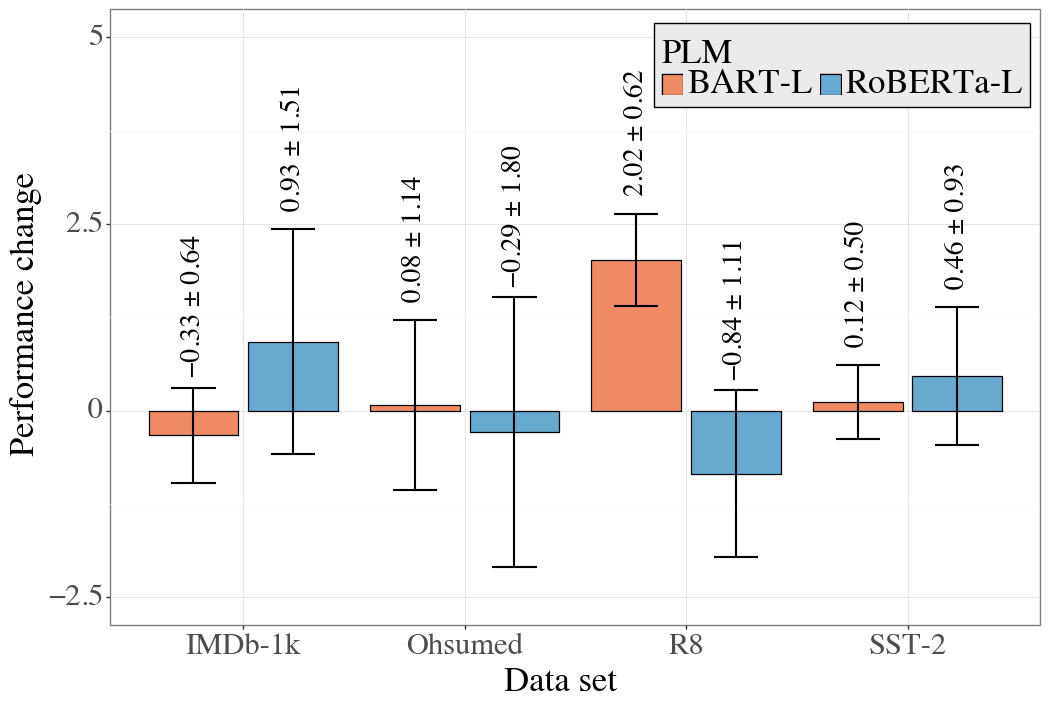

<ggplot: (820343088)>

In [56]:
plot

In [57]:
plot.save(filename = './paper_figures/grouped_vs_surrogate_using_large_PLMs.png', dpi = 300)

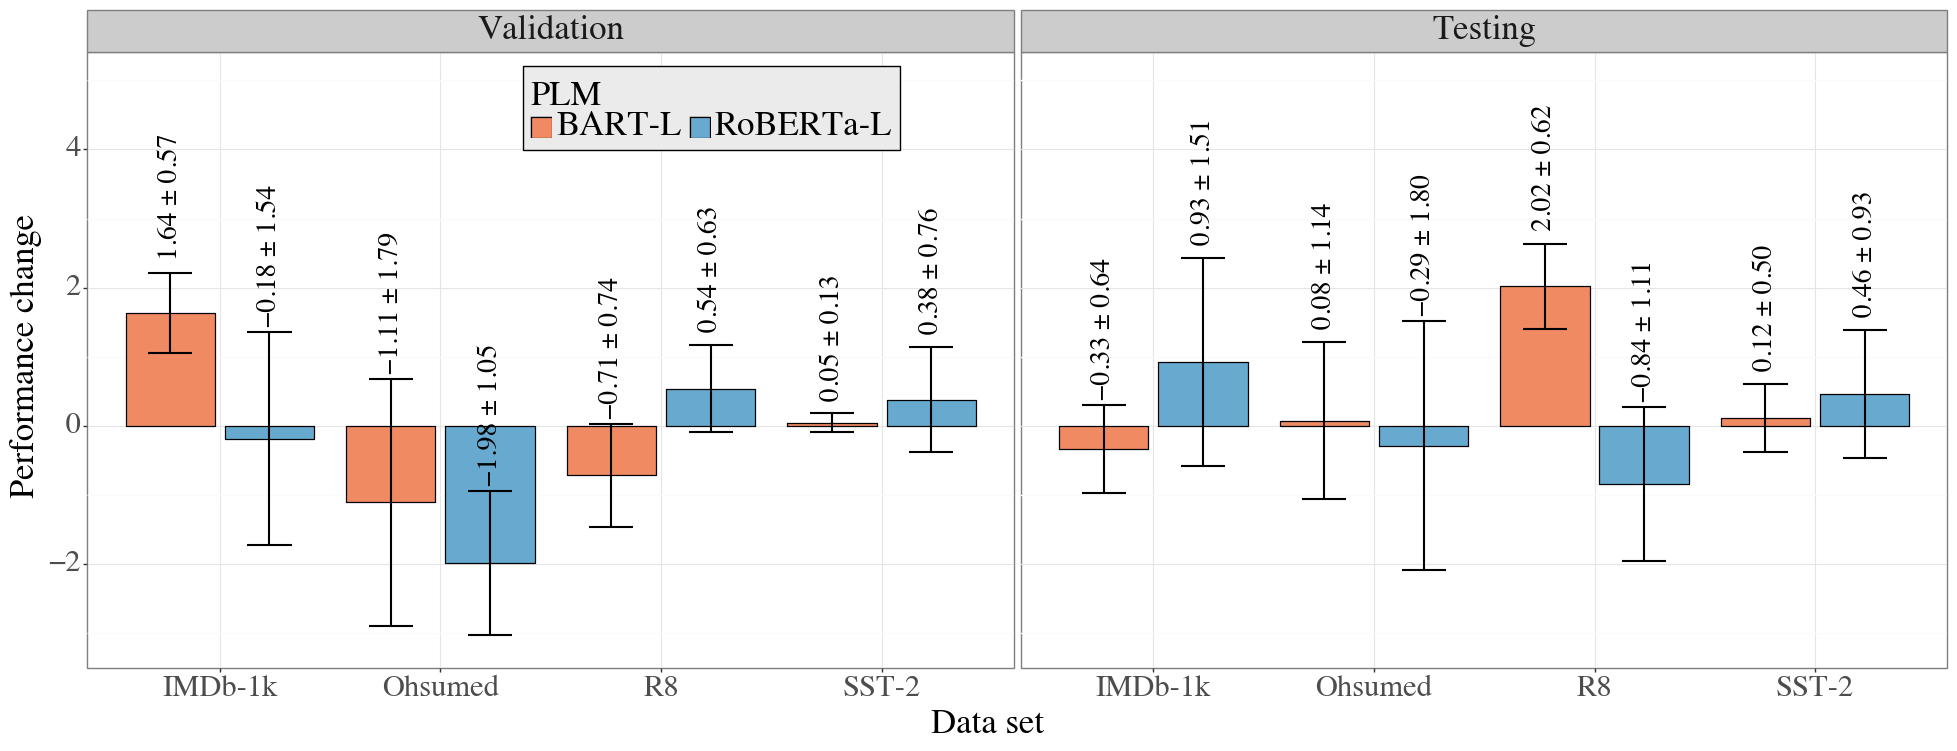

<ggplot: (820366880)>

In [58]:
p9.ggplot(grouped_vs_surrogate_using_large_PLMs_df,
  p9.aes(x = 'dataset', y = 'performance_difference_mean', fill = 'PLM')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000') + \
  p9.geom_text(p9.aes(y = 'performance_difference_mean + performance_difference_std + 1.1', label = 'label'), position = p9.position_dodge2(width = .9), size = 20, angle = 90) + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_difference_mean - performance_difference_std', ymax = 'performance_difference_mean + performance_difference_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.facet_wrap('~ split', ncol = 2) + \
  p9.xlab('Data set') + \
  p9.ylab('Performance change') + \
  p9.labs(fill = 'PLM') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(-3.1, 5) + \
  p9.theme(
    legend_position = [.385, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

#### Are the differences statistically significant?

In [59]:
grouped_vs_surrogate_using_large_PLMs_stats_df = get_all_performance_metrics_for_T_tests(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  PLMs = ['facebook-bart-large', 'FacebookAI-roberta-large'],
  methods = ['Grouped', 'Surrogate'],
  aggregations = ['No_Aggregation'],
)

In [60]:
grouped_vs_surrogate_using_large_PLMs_stats_df.head()

random_state       split  performance dataset    gnn                  PLM  \
0           42  validation     0.948394   SST-2  GATv2  facebook-bart-large   
1           42        test     0.946733   SST-2  GATv2  facebook-bart-large   
2           45  validation     0.947248   SST-2  GATv2  facebook-bart-large   
3           45        test     0.948380   SST-2  GATv2  facebook-bart-large   
4           44  validation     0.944954   SST-2  GATv2  facebook-bart-large   

    method     aggregation  
0  Grouped  No_Aggregation  
1  Grouped  No_Aggregation  
2  Grouped  No_Aggregation  
3  Grouped  No_Aggregation  
4  Grouped  No_Aggregation

In [61]:
grouped_vs_surrogate_using_large_PLMs_stats_df['PLM'] = grouped_vs_surrogate_using_large_PLMs_stats_df['PLM'].replace({
  'facebook-bart-large' : 'BART-L',
  'FacebookAI-roberta-large' : 'RoBERTa-L',
})
grouped_vs_surrogate_using_large_PLMs_stats_df['dataset'] = grouped_vs_surrogate_using_large_PLMs_stats_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

In [62]:

for dataset in ['SST-2', 'Ohsumed', 'R8', 'IMDb-1k']:
  print('-' * 10, dataset, '-' * 10)
  for i, split in enumerate(['validation', 'test']):
    print('>>', split)
    for PLM in ['BART-L', 'RoBERTa-L']:
      split_df = grouped_vs_surrogate_using_large_PLMs_stats_df[(grouped_vs_surrogate_using_large_PLMs_stats_df['dataset'] == dataset) & (grouped_vs_surrogate_using_large_PLMs_stats_df['split'] == split) & (grouped_vs_surrogate_using_large_PLMs_stats_df['PLM'] == PLM)].drop(columns = ['split', 'gnn', 'PLM', 'aggregation']) \
        .pivot(index = ['dataset', 'random_state'], columns = 'method', values = 'performance') \
        .reset_index() \
        .sort_values(by = ['dataset', 'random_state'])
      
      #for (x, y) in itertools.combinations(['No_Ablation', 'Random_Attentions', 'Random_Weights', 'Unitary_Weights', 'Single_Unitary_Weight'], 2):
      for (x, y) in [('Grouped', 'Surrogate')]:
        # H0: Mean Grouped and Surrogate scores are equal
        # H1: Mean Grouped and Surrogate scores are not equal
        statistic, p_value = stats.ttest_ind(split_df[x], split_df[y])
        # 95% confidence -- p-value < 0.05 => reject the null hypothesis (H0), i.e., the true mean test score is different between the approaches
        print(f'[{PLM}] {x} - {y}:', 'Statistic:', statistic, 'P-value:', p_value, 'Reject H0?', p_value < 0.05)
  print('')

---------- SST-2 ----------
>> validation
[BART-L] Grouped - Surrogate: Statistic: -0.5694947974513423 P-value: 0.5760592489175216 Reject H0? False
[RoBERTa-L] Grouped - Surrogate: Statistic: -1.6049365369942925 P-value: 0.12590893392060398 Reject H0? False
>> test
[BART-L] Grouped - Surrogate: Statistic: -0.6813698161025076 P-value: 0.5043102559579653 Reject H0? False
[RoBERTa-L] Grouped - Surrogate: Statistic: -1.693068248443709 P-value: 0.10767781201829298 Reject H0? False

---------- Ohsumed ----------
>> validation
[BART-L] Grouped - Surrogate: Statistic: 2.1790263763805147 P-value: 0.04286007411252478 Reject H0? True
[RoBERTa-L] Grouped - Surrogate: Statistic: 6.908541043763225 P-value: 1.8518118772647226e-06 Reject H0? True
>> test
[BART-L] Grouped - Surrogate: Statistic: -0.23759963127776995 P-value: 0.8148750747699438 Reject H0? False
[RoBERTa-L] Grouped - Surrogate: Statistic: 0.4308018837593471 P-value: 0.6717269926732098 Reject H0? False

---------- R8 ----------
>> validat

## Measuring the impact of the ablations

In [63]:
def load_performance_metrics_from_ablations(dataset, gnn, PLM, method, aggregation, edge_ablation, node_noise_level, node_feature_noise_level, target_metric, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{PLM.replace("/", "-")}-{method}-{aggregation}-{edge_ablation}-{node_noise_level}-{node_feature_noise_level}'
  storage = f'sqlite:///../../ablations/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N)
  
  performance = list()
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    random_states = [x for x in os.listdir(f'../../ablation_outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{edge_ablation}/{node_noise_level}-{node_feature_noise_level}/{trial}') if os.path.isdir(f'../../ablation_outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{edge_ablation}/{node_noise_level}-{node_feature_noise_level}/{trial}/{x}')]
    if len(random_states) < 10:
      continue

    for random_state in random_states:
      df = pd.read_csv(f'../../ablation_outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{edge_ablation}/{node_noise_level}-{node_feature_noise_level}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
    break
  
  performance_df = pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])
  return performance_df.groupby(['trial', 'split']).agg(
    performance_mean = (target_metric, 'mean'),
    performance_std = (target_metric, 'std')
  ).reset_index()

In [64]:
def get_all_performance_metrics_from_ablations(datasets, target_metrics, gnns, PLMs, methods, aggregations, edge_ablations, node_noise_levels, node_feature_noise_levels):
  l = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for PLM in PLMs:
        for method in methods:
          for aggregation in aggregations:
            for edge_ablation in edge_ablations:
              for node_noise_level in node_noise_levels:
                for node_feature_noise_level in node_feature_noise_levels:
                  l.append(
                    load_performance_metrics_from_ablations(
                      dataset = dataset,
                      gnn = gnn,
                      PLM = PLM,
                      method = method,
                      aggregation = aggregation,
                      target_metric = target_metric,
                      edge_ablation = edge_ablation,
                      node_noise_level = node_noise_level,
                      node_feature_noise_level = node_feature_noise_level,
                      display_information = False
                    ).assign(
                      dataset = dataset,
                      gnn = gnn,
                      PLM = PLM,
                      method = method,
                      aggregation = aggregation,
                      edge_ablation = edge_ablation,
                      node_noise_level = node_noise_level,
                      node_feature_noise_level = node_feature_noise_level
                    ).drop(columns = ['trial'])
                  )
  return pd.concat(l, axis = 0).reset_index(drop = True)

In [65]:
def load_performance_metrics_from_ablations_for_T_tests(dataset, gnn, PLM, method, aggregation, edge_ablation, node_noise_level, node_feature_noise_level, target_metric, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{PLM.replace("/", "-")}-{method}-{aggregation}-{edge_ablation}-{node_noise_level}-{node_feature_noise_level}'
  storage = f'sqlite:///../../ablations/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N)
  
  performance = list()
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    random_states = [x for x in os.listdir(f'../../ablation_outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{edge_ablation}/{node_noise_level}-{node_feature_noise_level}/{trial}') if os.path.isdir(f'../../ablation_outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{edge_ablation}/{node_noise_level}-{node_feature_noise_level}/{trial}/{x}')]
    if len(random_states) < 10:
      continue

    for random_state in random_states:
      df = pd.read_csv(f'../../ablation_outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{edge_ablation}/{node_noise_level}-{node_feature_noise_level}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
    break
  
  return pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])[['random_state', 'split', target_metric]].rename(columns = {target_metric : 'performance'})

In [66]:
def get_all_performance_metrics_from_ablations_for_T_tests(datasets, target_metrics, gnns, PLMs, methods, aggregations, edge_ablations, node_noise_levels, node_feature_noise_levels):
  l = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for PLM in PLMs:
        for method in methods:
          for aggregation in aggregations:
            for edge_ablation in edge_ablations:
              for node_noise_level in node_noise_levels:
                for node_feature_noise_level in node_feature_noise_levels:
                  l.append(
                    load_performance_metrics_from_ablations_for_T_tests(
                      dataset = dataset,
                      gnn = gnn,
                      PLM = PLM,
                      method = method,
                      aggregation = aggregation,
                      target_metric = target_metric,
                      edge_ablation = edge_ablation,
                      node_noise_level = node_noise_level,
                      node_feature_noise_level = node_feature_noise_level,
                      display_information = False
                    ).assign(
                      dataset = dataset,
                      gnn = gnn,
                      PLM = PLM,
                      method = method,
                      aggregation = aggregation,
                      edge_ablation = edge_ablation,
                      node_noise_level = node_noise_level,
                      node_feature_noise_level = node_feature_noise_level
                    )
                  )
  return pd.concat(l, axis = 0).reset_index(drop = True)

### Edge-based ablations

In [67]:
edge_ablations_df = pd.concat([
  get_all_performance_metrics_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['google-bert-bert-base-uncased'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation']
  ).assign(
    edge_ablation = 'No_Ablation',
    node_noise_level = 0.0,
    node_feature_noise_level = 0.0
  ),
  get_all_performance_metrics_from_ablations_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['google-bert-bert-base-uncased'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation'],
    edge_ablations = ['Random_Attentions', 'Random_Weights', 'Unitary_Weights', 'Single_Unitary_Weight'],
    node_noise_levels = [0.0],
    node_feature_noise_levels = [0.0]
  )
]).reset_index(drop = True)

In [68]:
edge_ablations_df['edge_ablation'] = edge_ablations_df['edge_ablation'].replace({
  'No_Ablation' : 'None',
  'Random_Attentions' : 'RA',
  'Random_Weights' : 'RW',
  'Unitary_Weights' : 'UW',
  'Single_Unitary_Weight' : 'SUW'
})

In [69]:
edge_ablations_df['dataset'] = edge_ablations_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

In [70]:
edge_ablations_df = edge_ablations_df \
  .drop(columns = ['gnn', 'aggregation', 'PLM', 'node_noise_level', 'node_feature_noise_level']) \
  .pivot(index = ['dataset', 'split', 'random_state', 'method'], columns = 'edge_ablation', values = 'performance') \
  .reset_index() \
  .assign(
    RA_difference = lambda df : df['RA'] - df['None'],
    RW_difference = lambda df : df['RW'] - df['None'],
    UW_difference = lambda df : df['UW'] - df['None'],
    SUW_difference = lambda df : df['SUW'] - df['None'],
  ) \
  .melt(
    id_vars = ['dataset', 'split', 'random_state', 'method'], 
    value_vars = ['RA_difference', 'RW_difference', 'UW_difference', 'SUW_difference'], 
    var_name = 'edge_ablation',
    value_name = 'difference'
  ) \
  .assign(
    edge_ablation = lambda df : df['edge_ablation'].str.replace('_difference', '', regex = False),
    difference = lambda df : df['difference'] * 100
  ) \
  .sort_values(by = ['dataset', 'random_state']) \
  .groupby(by = ['dataset', 'split', 'method', 'edge_ablation']) \
  .agg(
    performance_difference_mean = ('difference', 'mean'),
    performance_difference_std = ('difference', 'std'),
  ).reset_index()

In [71]:
edge_ablations_df['label'] = edge_ablations_df['performance_difference_mean'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212')) + ' ± ' + edge_ablations_df['performance_difference_std'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212'))

In [72]:
edge_ablations_df['split'] = edge_ablations_df['split'].replace({'test' : 'Testing'}).str.capitalize()
edge_ablations_df['split'] = pd.Categorical(edge_ablations_df['split'], categories = ['Validation', 'Testing'])

In [73]:
plot = p9.ggplot(edge_ablations_df[(edge_ablations_df['split'] == 'Testing')],
  p9.aes(x = 'dataset', y = 'performance_difference_mean', fill = 'edge_ablation')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000') + \
  p9.geom_text(p9.aes(y = 'performance_difference_mean - performance_difference_std - 1.5', label = 'label'), position = p9.position_dodge2(width = .9), size = 20, angle = 90) + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_difference_mean - performance_difference_std', ymax = 'performance_difference_mean + performance_difference_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.facet_wrap('~ method', ncol = 2) + \
  p9.xlab('Data set') + \
  p9.ylab('Performance change') + \
  p9.labs(fill = 'Edge-based ablation') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(-7.5, 3) + \
  p9.theme(
    legend_position = [.215, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

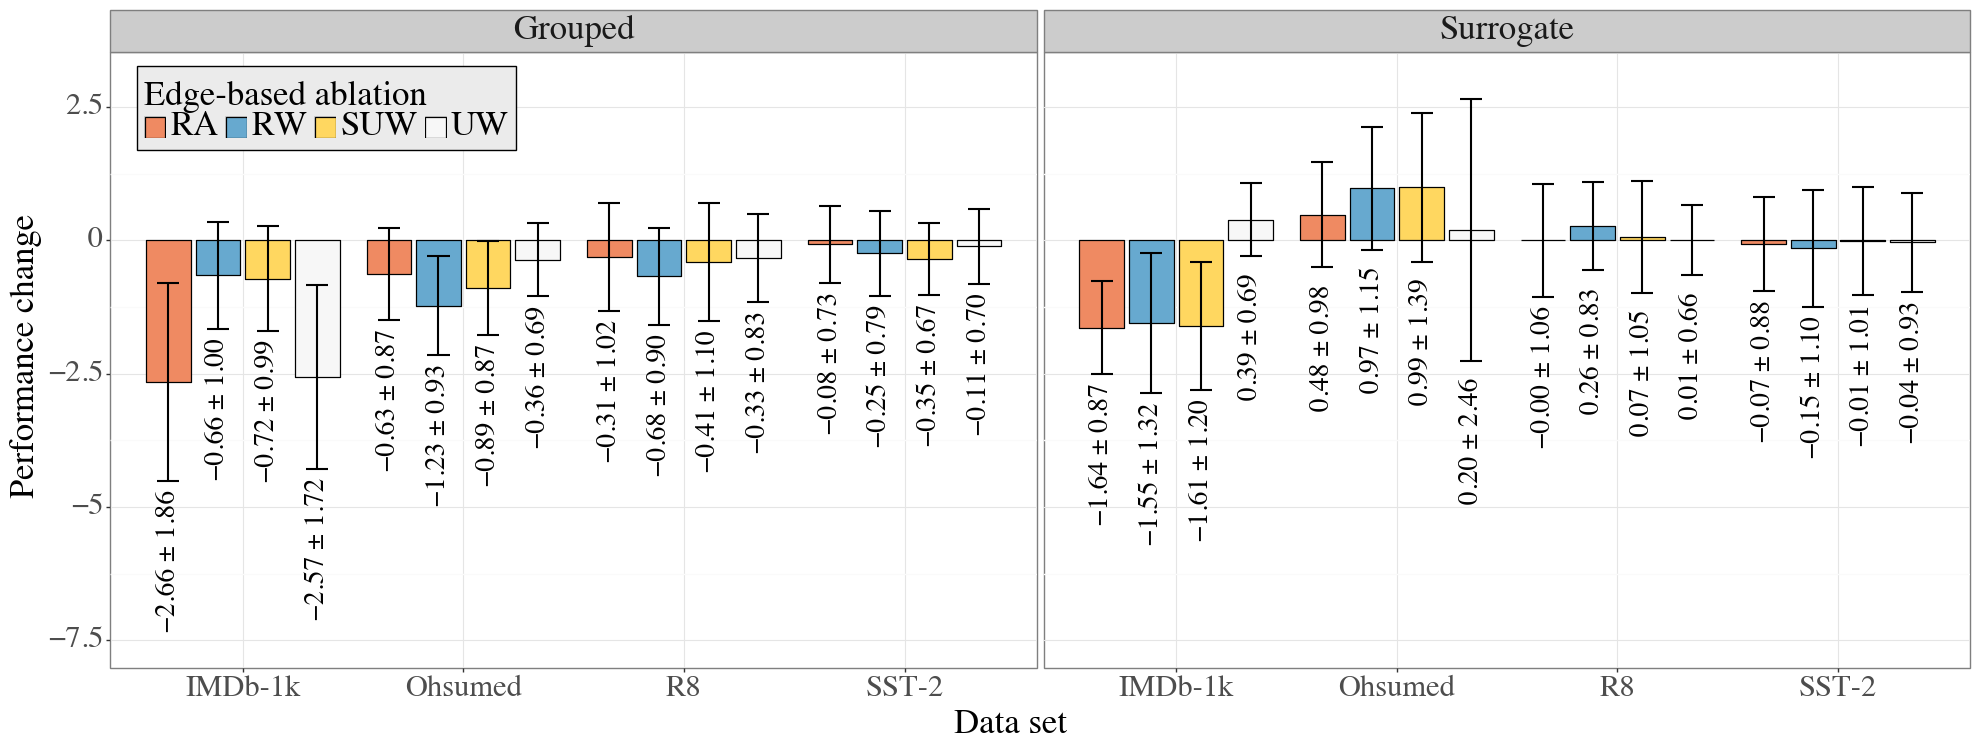

<ggplot: (811880977)>

In [74]:
plot

In [75]:
plot.save(filename = './paper_figures/edge_ablations.png', dpi = 300)

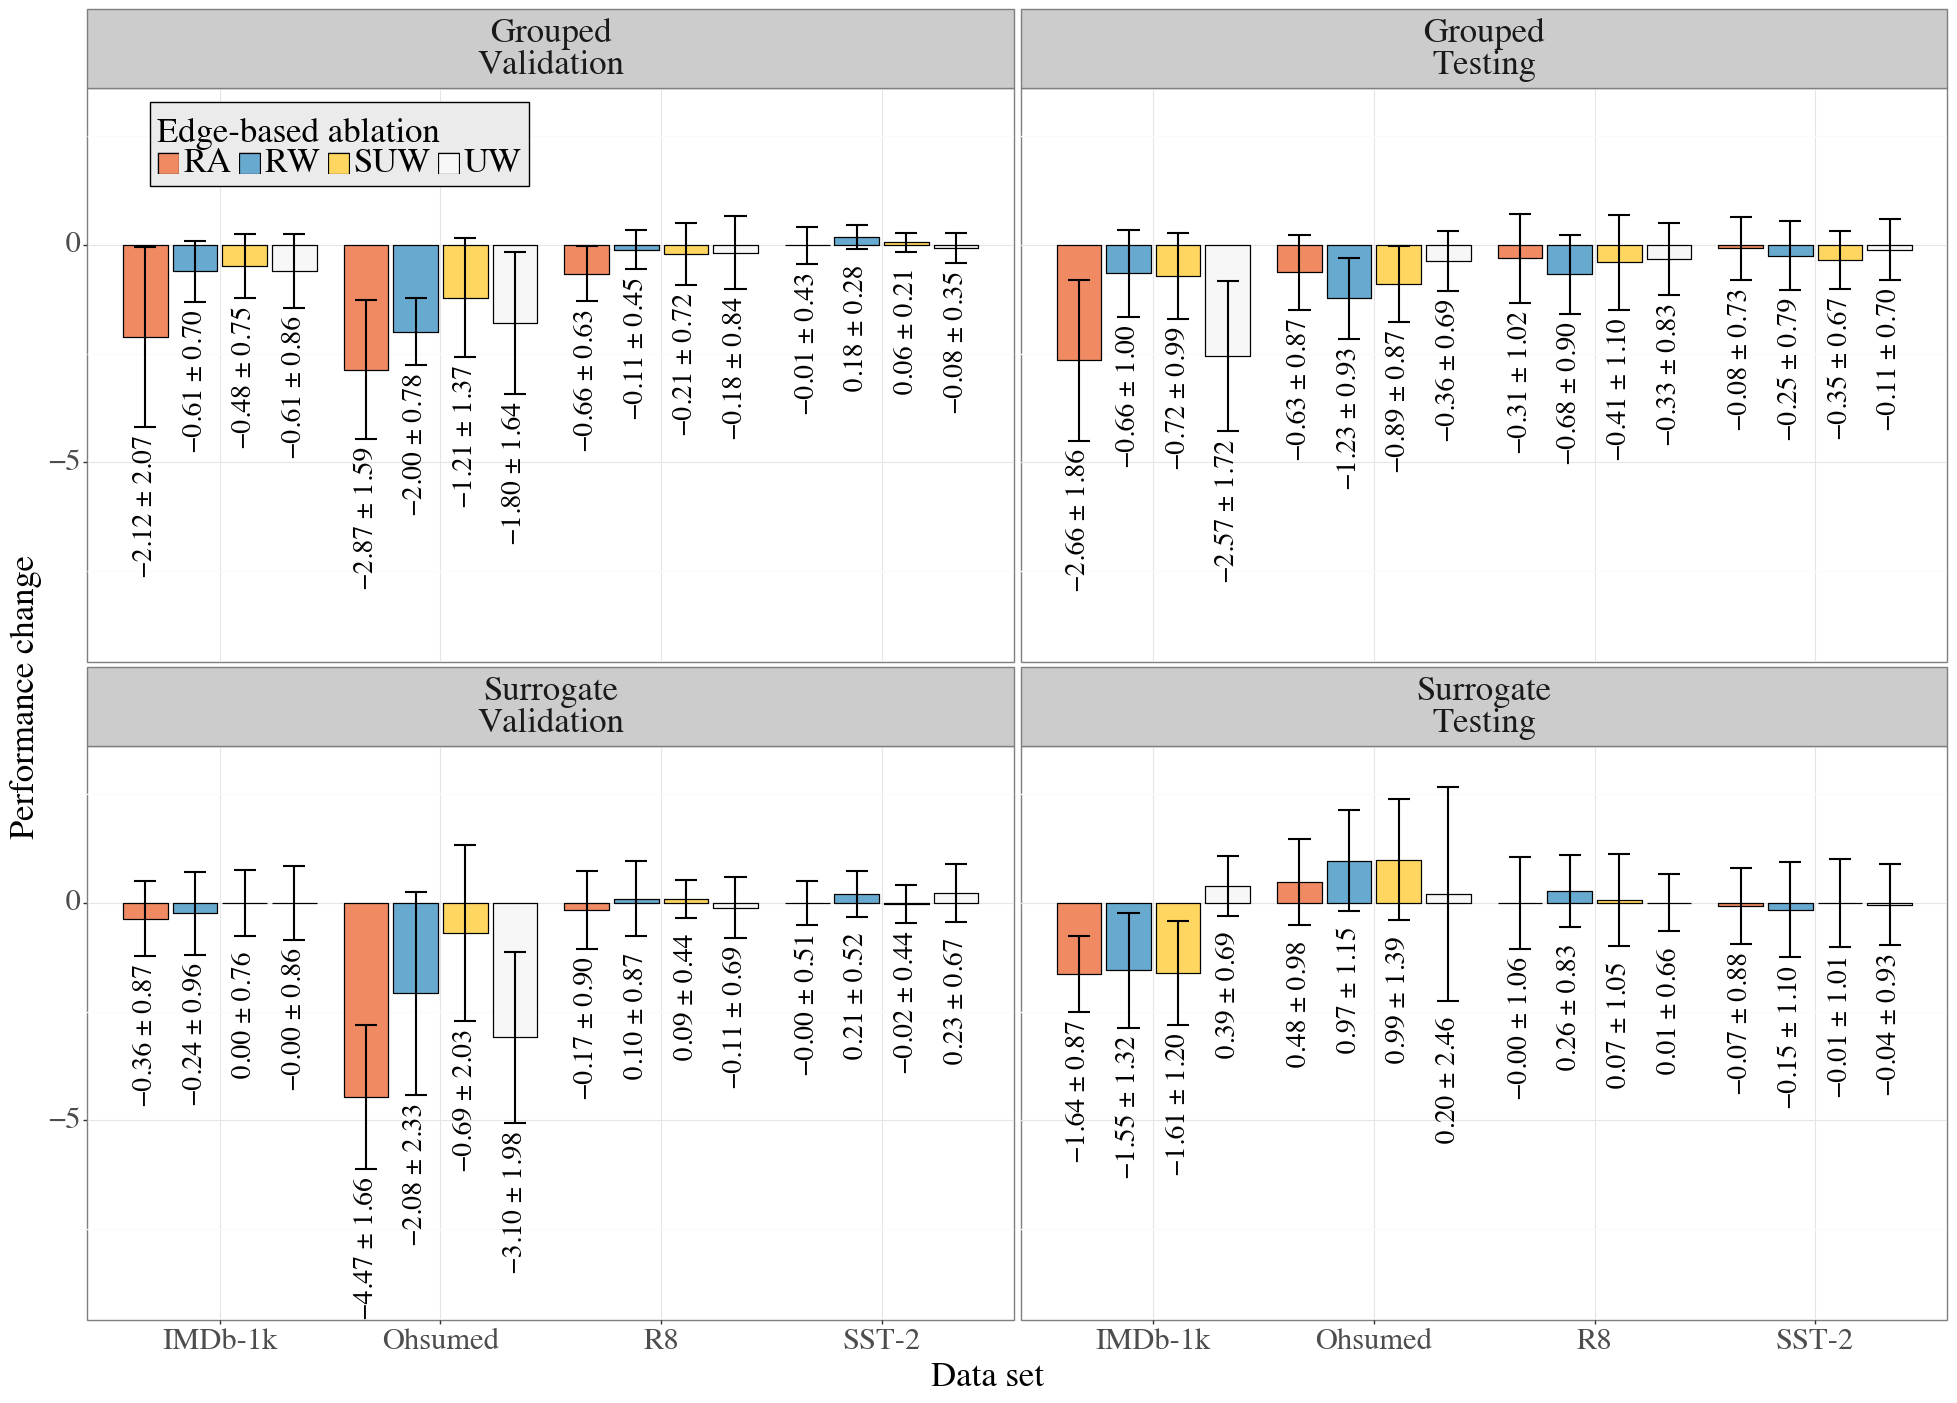

<ggplot: (811728587)>

In [76]:
p9.ggplot(edge_ablations_df,
  p9.aes(x = 'dataset', y = 'performance_difference_mean', fill = 'edge_ablation')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000') + \
  p9.geom_text(p9.aes(y = 'performance_difference_mean - performance_difference_std - 1.8', label = 'label'), position = p9.position_dodge2(width = .9), size = 20, angle = 90) + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_difference_mean - performance_difference_std', ymax = 'performance_difference_mean + performance_difference_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.facet_wrap('~ method + split', ncol = 2) + \
  p9.xlab('Data set') + \
  p9.ylab('Performance change') + \
  p9.labs(fill = 'Edge-based ablation') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(-9, 3) + \
  p9.theme(
    legend_position = [.23, .845],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 16),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

#### Are the differences statistically significant?

In [77]:
edge_ablations_stats_df = pd.concat([
  get_all_performance_metrics_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['google-bert-bert-base-uncased'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation']
  ).assign(
    edge_ablation = 'No_Ablation',
    node_noise_level = 0.0,
    node_feature_noise_level = 0.0
  ),
  get_all_performance_metrics_from_ablations_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['google-bert-bert-base-uncased'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation'],
    edge_ablations = ['Random_Attentions', 'Random_Weights', 'Unitary_Weights', 'Single_Unitary_Weight'],
    node_noise_levels = [0.0],
    node_feature_noise_levels = [0.0]
  )
]).reset_index(drop = True)

In [78]:
edge_ablations_stats_df['dataset'] = edge_ablations_stats_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})
edge_ablations_stats_df['edge_ablation'] = edge_ablations_stats_df['edge_ablation'].replace({
  'No_Ablation' : 'None',
  'Random_Attentions' : 'RA',
  'Random_Weights' : 'RW',
  'Unitary_Weights' : 'UW',
  'Single_Unitary_Weight' : 'SUW'
})

In [79]:

for dataset in ['SST-2', 'Ohsumed', 'R8', 'IMDb-1k']:
  print('-' * 10, dataset, '-' * 10)
  for i, split in enumerate(['validation', 'test']):
    print('>>', split)
    for variant in ['Grouped', 'Surrogate']:
      split_df = edge_ablations_stats_df[(edge_ablations_stats_df['dataset'] == dataset) & (edge_ablations_stats_df['split'] == split) & (edge_ablations_stats_df['method'] == variant)].drop(columns = ['split', 'gnn', 'PLM', 'method', 'aggregation', 'node_noise_level', 'node_feature_noise_level']) \
        .pivot(index = ['dataset', 'random_state'], columns = 'edge_ablation', values = 'performance') \
        .reset_index() \
        .sort_values(by = ['dataset', 'random_state'])
      
      #for (x, y) in itertools.combinations(['No_Ablation', 'Random_Attentions', 'Random_Weights', 'Unitary_Weights', 'Single_Unitary_Weight'], 2):
      for (x, y) in [('None', 'RA'), ('None', 'RW'), ('None', 'UW'), ('None', 'SUW')]:
        # H0: Mean Grouped and Surrogate scores are equal
        # H1: Mean Grouped and Surrogate scores are not equal
        statistic, p_value = stats.ttest_ind(split_df[x], split_df[y])
        # 95% confidence -- p-value < 0.05 => reject the null hypothesis (H0), i.e., the true mean test score is different between the approaches
        print(f'[{variant}] {x} - {y}:', 'Statistic:', statistic, 'P-value:', p_value, 'Reject H0?', p_value < 0.05)
  print('')

---------- SST-2 ----------
>> validation
[Grouped] None - RA: Statistic: 0.06259516046825363 P-value: 0.9507787336419824 Reject H0? False
[Grouped] None - RW: Statistic: -1.3211565181517515 P-value: 0.20299861417554632 Reject H0? False
[Grouped] None - UW: Statistic: 0.5642796756453897 P-value: 0.5795279408633836 Reject H0? False
[Grouped] None - SUW: Statistic: -0.4658025705335719 P-value: 0.6469436606266277 Reject H0? False
[Surrogate] None - RA: Statistic: 0.0 P-value: 1.0 Reject H0? False
[Surrogate] None - RW: Statistic: -0.961225453586991 P-value: 0.3491744857101249 Reject H0? False
[Surrogate] None - UW: Statistic: -1.0084389681791928 P-value: 0.32660858392030434 Reject H0? False
[Surrogate] None - SUW: Statistic: 0.11776030079688264 P-value: 0.9075617016544795 Reject H0? False
>> test
[Grouped] None - RA: Statistic: 0.2566037114417521 P-value: 0.8003946937753209 Reject H0? False
[Grouped] None - RW: Statistic: 0.9826826731207428 P-value: 0.33878864592450797 Reject H0? False
[G

### Node-based ablations

In [80]:
node_ablations_df = pd.concat([
  get_all_performance_metrics_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['google-bert-bert-base-uncased'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation']
  ).assign(
    edge_ablation = 'No_Ablation',
    node_noise_level = 0.0,
    node_feature_noise_level = 0.0
  ),
  get_all_performance_metrics_from_ablations_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['google-bert-bert-base-uncased'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation'],
    edge_ablations = ['No_Ablation'],
    node_noise_levels = [1.0],
    node_feature_noise_levels = [0.25, 0.5, 0.75]
  )
]).reset_index(drop = True)

In [81]:
node_ablations_df['dataset'] = node_ablations_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

In [82]:
node_ablations_df['node_feature_noise_level'] = node_ablations_df['node_feature_noise_level'].map(lambda x : f'{int(x * 100)}%')

In [83]:
node_ablations_df_tmp = node_ablations_df \
  .drop(columns = ['gnn', 'aggregation', 'PLM', 'edge_ablation', 'node_noise_level']) \
  .pivot(index = ['dataset', 'split', 'random_state', 'method'], columns = 'node_feature_noise_level', values = 'performance') \
  .reset_index() \
  .assign(
    difference_0 = lambda df : df['0%'] - df['0%'],
    difference_25 = lambda df : df['25%'] - df['0%'],
    difference_50 = lambda df : df['50%'] - df['0%'],
    difference_75 = lambda df : df['75%'] - df['0%'],
  )

node_ablations_df_tmp_1 = node_ablations_df_tmp \
  .melt(
    id_vars = ['dataset', 'split', 'random_state', 'method'], 
    value_vars = ['difference_0', 'difference_25', 'difference_50', 'difference_75'], 
    var_name = 'node_feature_noise_level',
    value_name = 'difference'
  ) \
  .assign(
    node_feature_noise_level = lambda df : df['node_feature_noise_level'].str.replace('difference_', '', regex = False) + '%',
    difference = lambda df : df['difference'] * 100
  ) 

node_ablations_df_tmp_2 = node_ablations_df_tmp \
  .melt(
    id_vars = ['dataset', 'split', 'random_state', 'method'], 
    value_vars = ['0%', '25%', '50%', '75%'], 
    var_name = 'node_feature_noise_level',
    value_name = 'performance'
  ) \
  .assign(
    node_feature_noise_level = lambda df : df['node_feature_noise_level'].str.replace('difference_', '', regex = False),
    performance = lambda df : df['performance'] * 100
  ) 

node_ablations_df = pd.merge(
    left = node_ablations_df_tmp_1,
    right = node_ablations_df_tmp_2,
    how = 'left',
    on = ['dataset', 'split', 'random_state', 'method', 'node_feature_noise_level']
  ) \
  .sort_values(by = ['dataset', 'random_state']) \
  .groupby(by = ['dataset', 'split', 'method', 'node_feature_noise_level']) \
  .agg(
    performance_mean = ('performance', 'mean'),
    performance_std = ('performance', 'std'),
    performance_difference_mean = ('difference', 'mean'),
    performance_difference_std = ('difference', 'std'),
  ).reset_index()

In [84]:
node_ablations_df['label'] = node_ablations_df['performance_difference_mean'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212')) + ' ± ' + node_ablations_df['performance_difference_std'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212'))
node_ablations_df.loc[node_ablations_df['performance_difference_mean'] == 0.0, 'label'] = node_ablations_df['performance_mean'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212')) + ' ± ' + node_ablations_df['performance_std'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212'))

In [85]:
node_ablations_df['split'] = node_ablations_df['split'].replace({'test' : 'Testing'}).str.capitalize()
node_ablations_df['split'] = pd.Categorical(node_ablations_df['split'], categories = ['Validation', 'Testing'])

In [86]:
node_ablations_df['label_y'] = node_ablations_df['performance_mean'] + node_ablations_df['performance_std'] + 1

In [87]:
label_y_conditions = [
  (node_ablations_df['dataset'] == 'IMDb-1k') & (node_ablations_df['method'] == 'Grouped'),
  (node_ablations_df['dataset'] == 'IMDb-1k') & (node_ablations_df['method'] == 'Surrogate'),
  (node_ablations_df['dataset'] == 'Ohsumed') & (node_ablations_df['method'] == 'Grouped'),
  (node_ablations_df['dataset'] == 'Ohsumed') & (node_ablations_df['method'] == 'Surrogate'),
  (node_ablations_df['dataset'] == 'R8') & (node_ablations_df['method'] == 'Grouped'),
  (node_ablations_df['dataset'] == 'R8') & (node_ablations_df['method'] == 'Surrogate'),
  (node_ablations_df['dataset'] == 'SST-2') & (node_ablations_df['method'] == 'Grouped'),
  (node_ablations_df['dataset'] == 'SST-2') & (node_ablations_df['method'] == 'Surrogate')
]
label_y_choices = [
  82, 82.625,
  42.5, 43.6,
  86.75, 87.22,
  83.5, 83.875
]
node_ablations_df['label_y'] = np.select(label_y_conditions, label_y_choices, default = 0)

In [88]:
plot = p9.ggplot(node_ablations_df[(node_ablations_df['split'] == 'Testing')],
  p9.aes(x = 'node_feature_noise_level', y = 'performance_mean', colour = 'method')) + \
  p9.theme_bw() + \
  p9.geom_point(size = 3.5) + \
  p9.geom_line(p9.aes(group = 'method'), size = 1, alpha = .5) + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_mean - performance_std', ymax = 'performance_mean + performance_std'), width = .25, size = .85, alpha = .6) + \
  p9.geom_text(
    p9.aes(
      y = 'label_y',
      label = 'label'
    ),
    size = 20,
    show_legend = False
  ) + \
  p9.facet_wrap('~ dataset', ncol = 2, scales = 'free_y') + \
  p9.xlab('Node noise level') + \
  p9.ylab('Performance') + \
  p9.labs(colour = 'Variant') + \
  p9.scale_color_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.theme(
    legend_position = 'top',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 16),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
    subplots_adjust = {
      'wspace' : 0.075
    }
  )

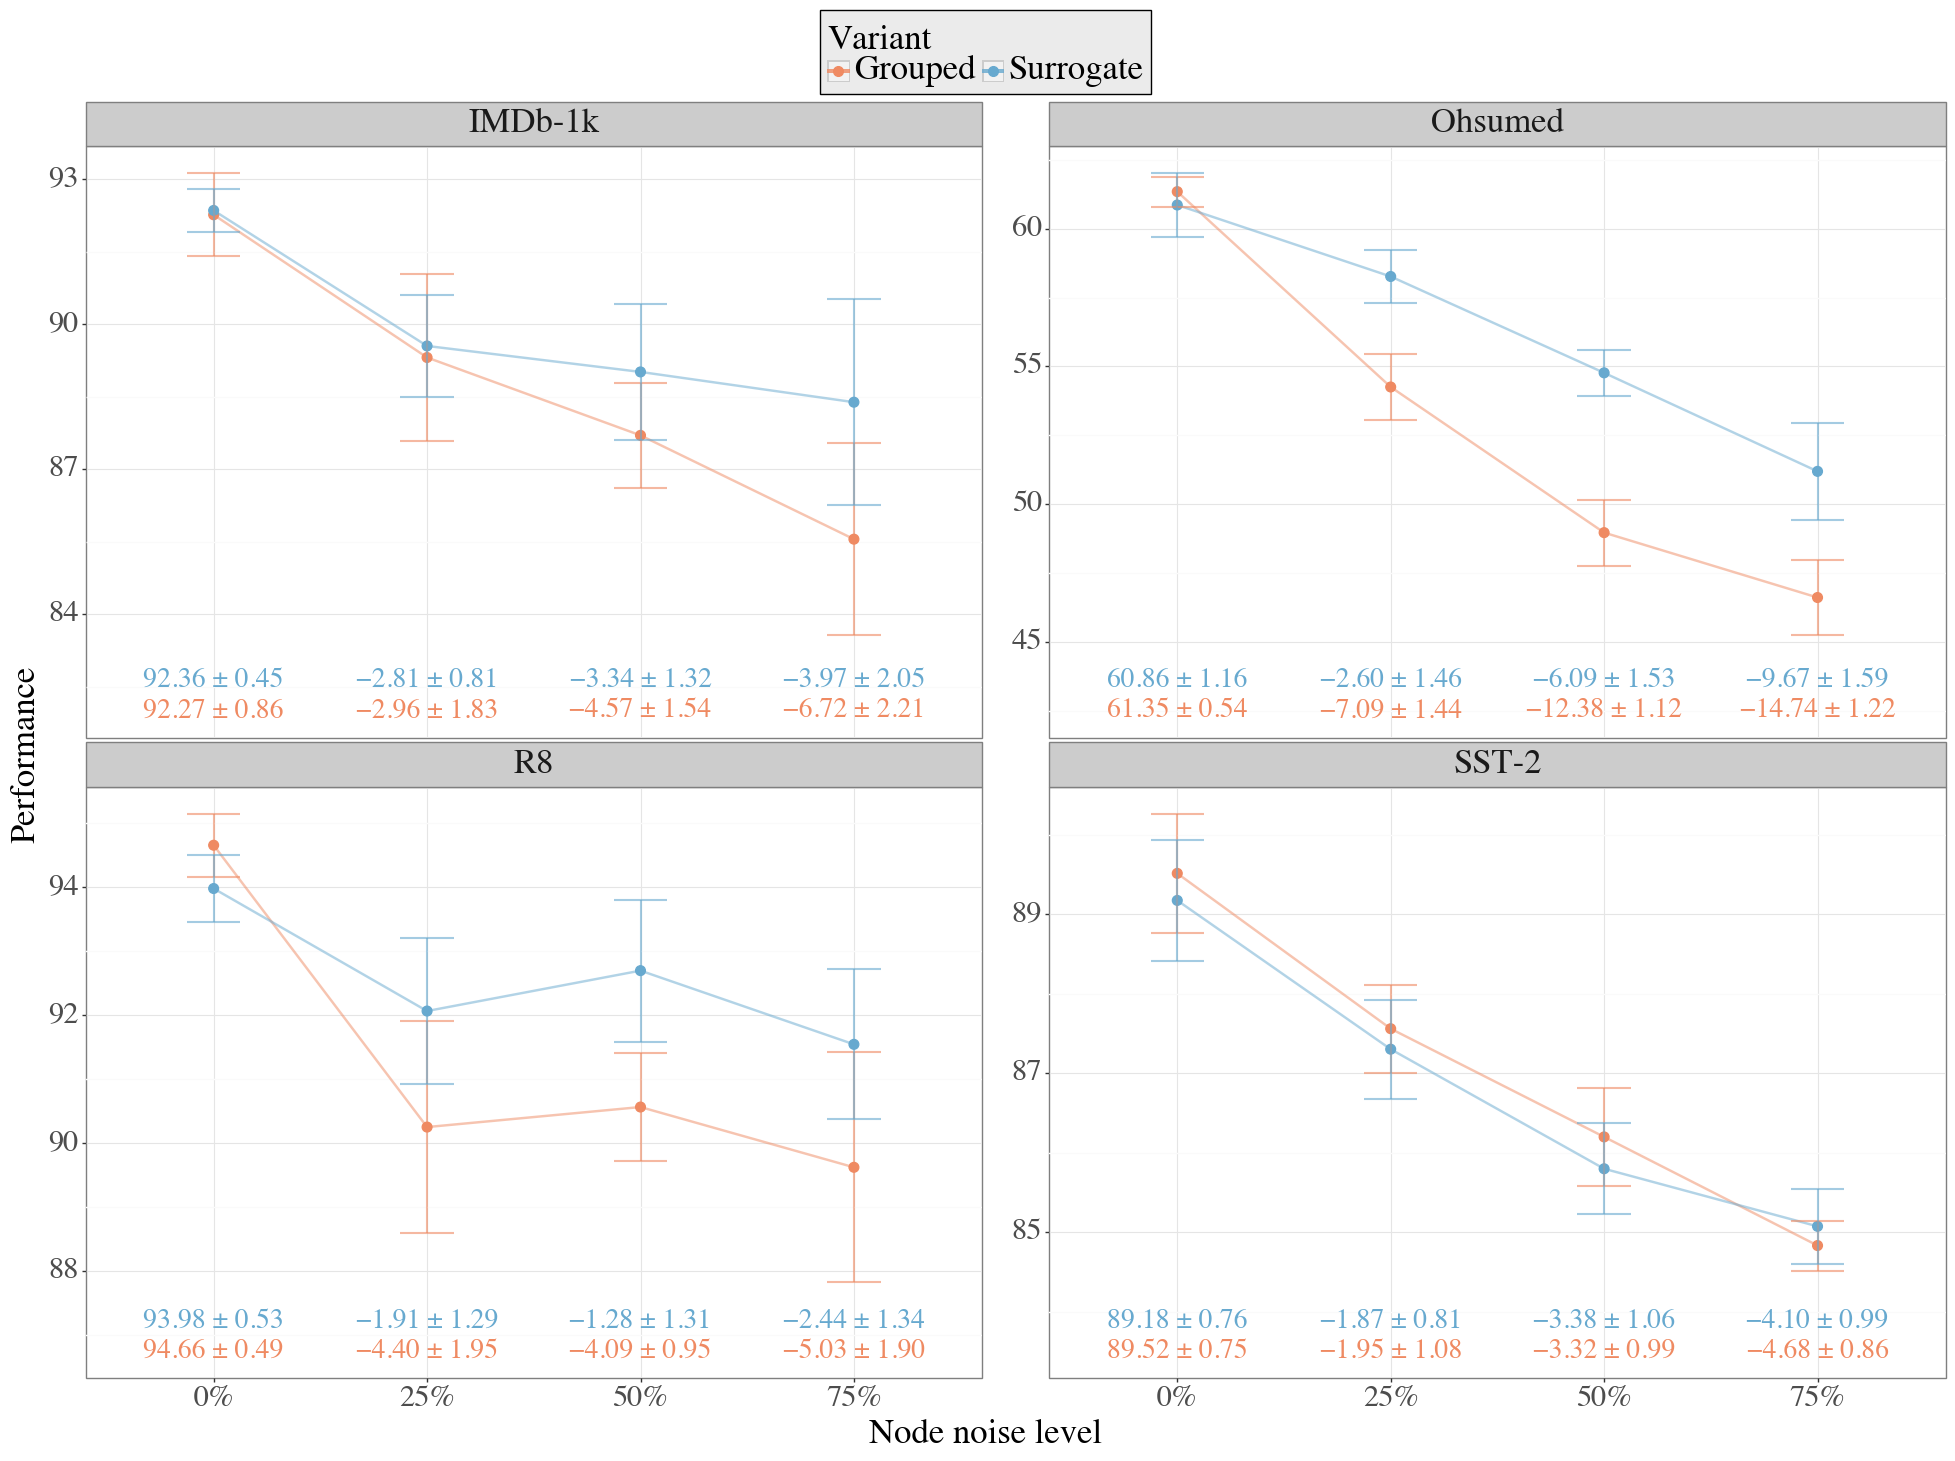

<ggplot: (813674178)>

In [89]:
plot

In [90]:
plot.save(filename = './paper_figures/node_ablations.png', dpi = 300)

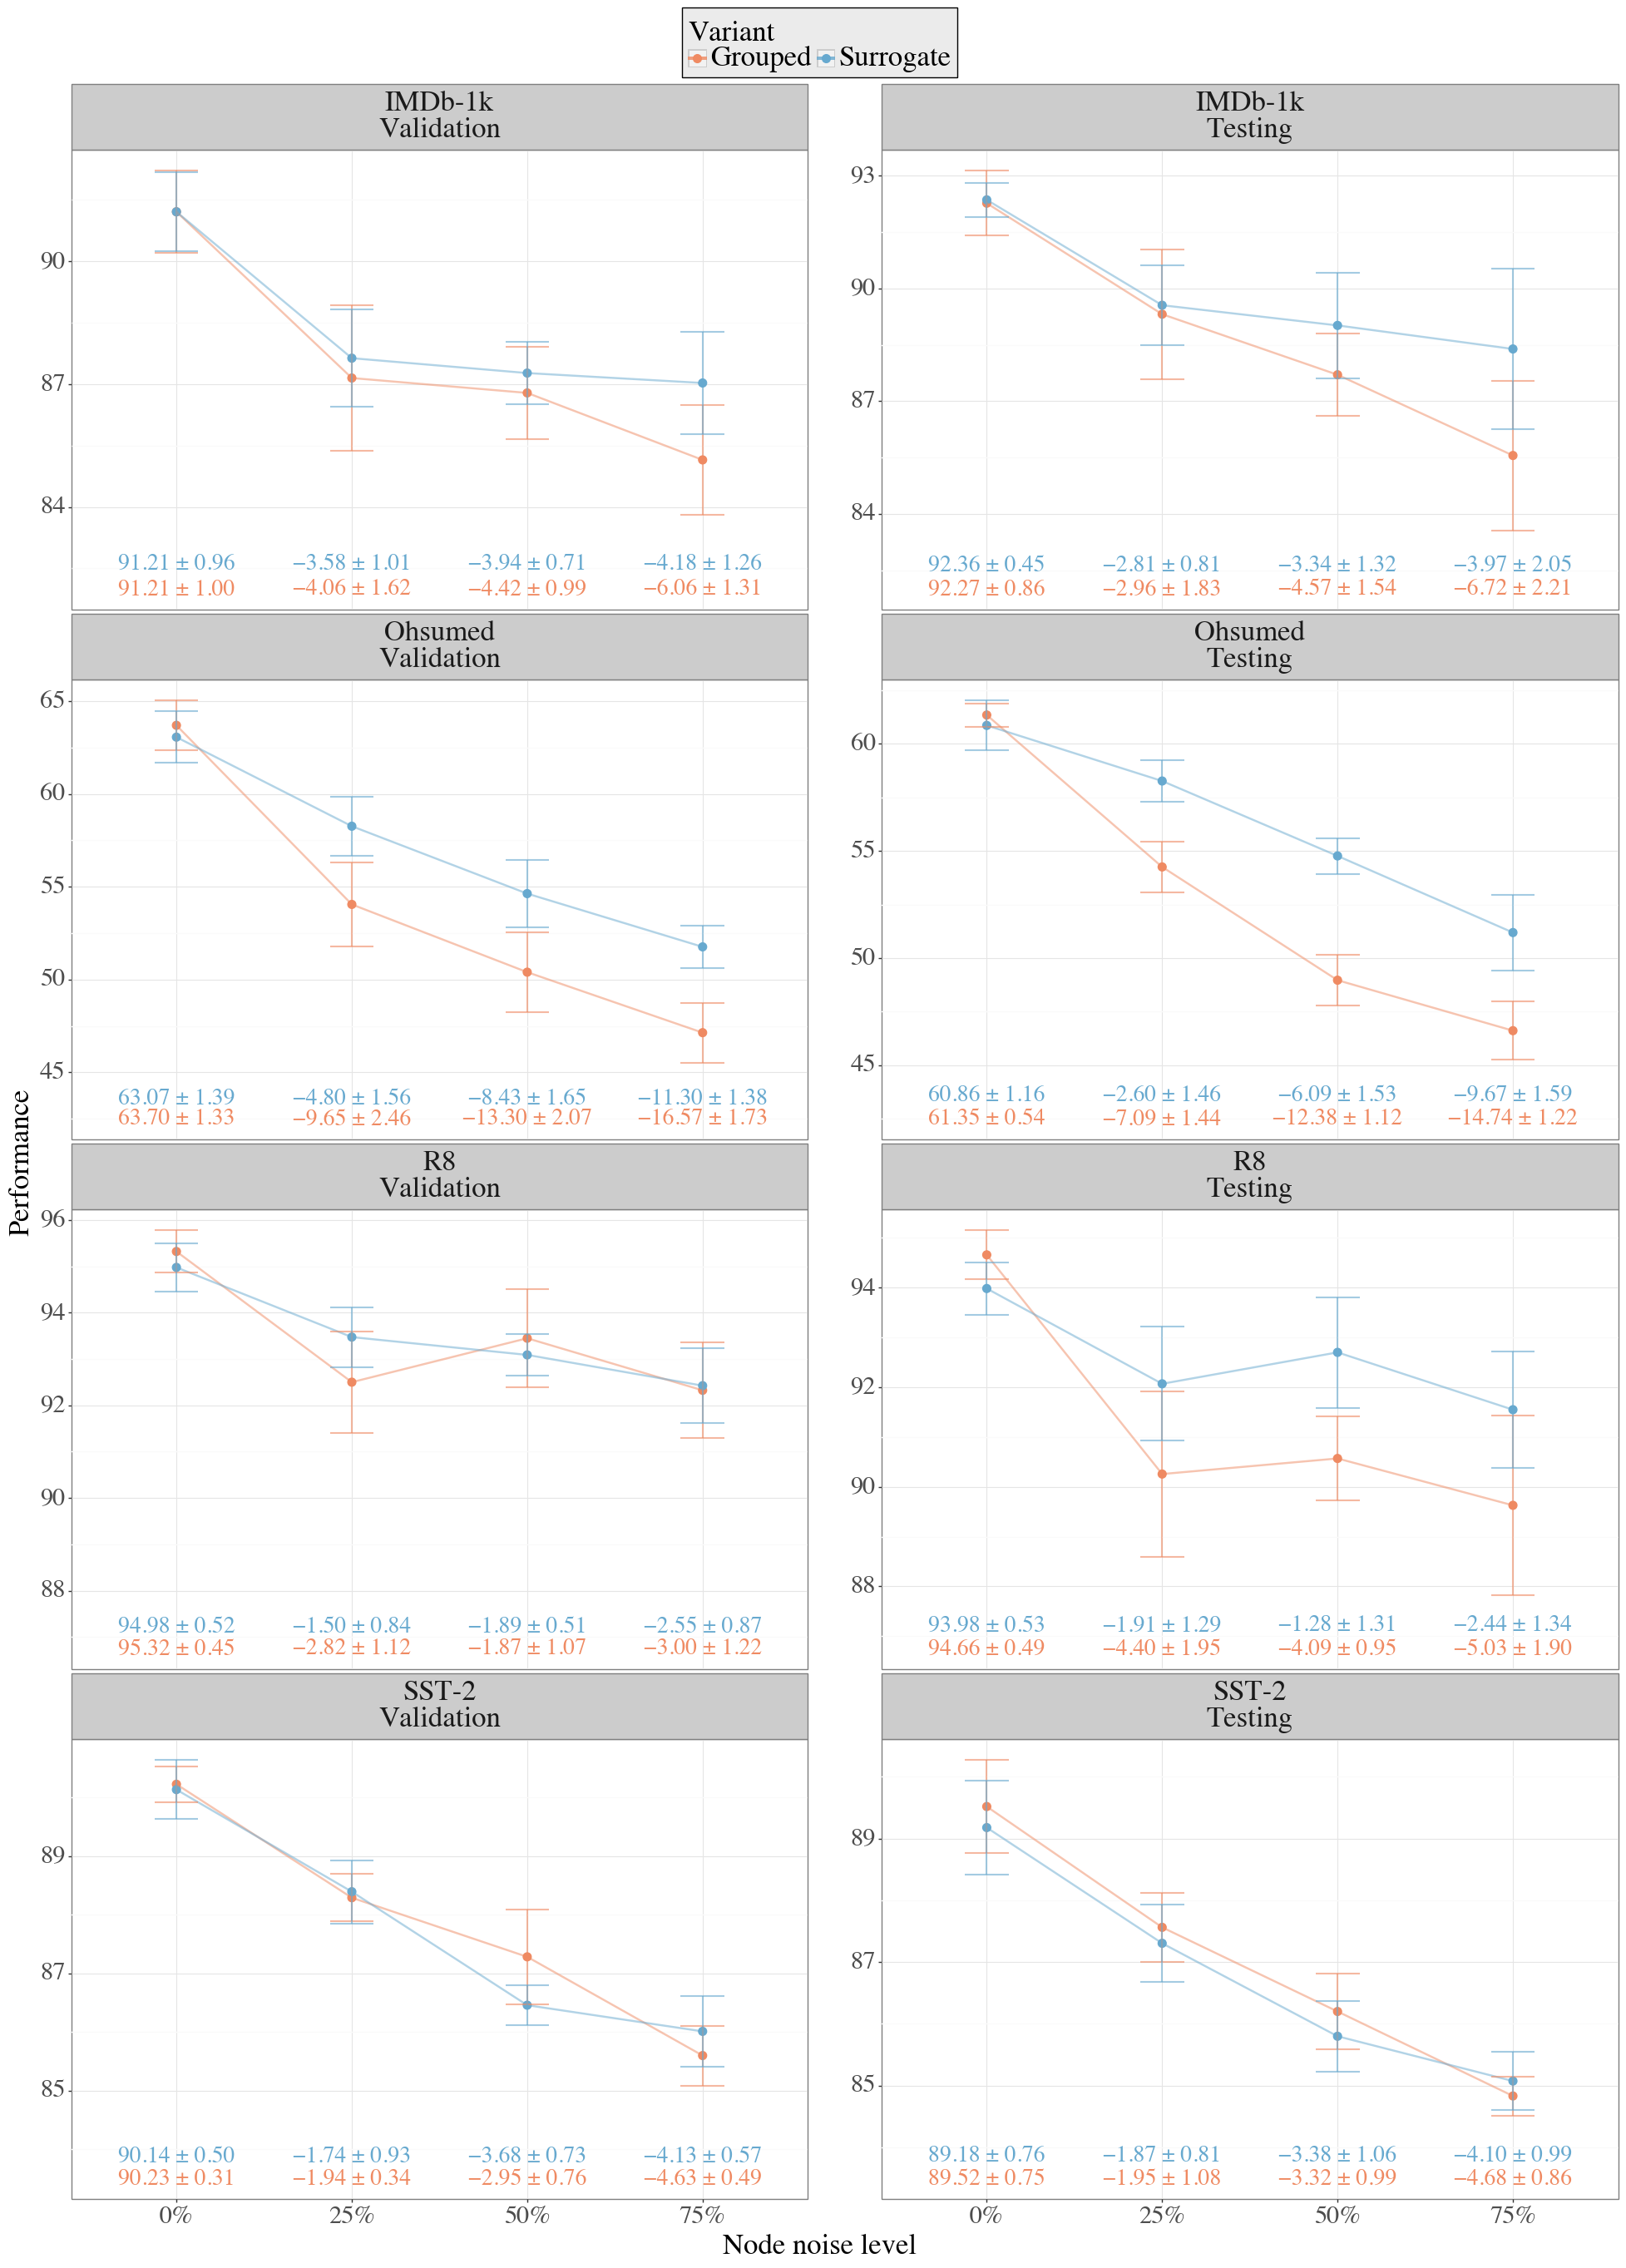

<ggplot: (813591180)>

In [91]:
p9.ggplot(node_ablations_df,
  p9.aes(x = 'node_feature_noise_level', y = 'performance_mean', colour = 'method')) + \
  p9.theme_bw() + \
  p9.geom_point(size = 3.5) + \
  p9.geom_line(p9.aes(group = 'method'), size = 1, alpha = .5) + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_mean - performance_std', ymax = 'performance_mean + performance_std'), width = .25, size = .85, alpha = .6) + \
  p9.geom_text(
    p9.aes(
      y = 'label_y',
      label = 'label'
    ),
    size = 20,
    show_legend = False
  ) + \
  p9.facet_wrap('~ dataset+split', ncol = 2, scales = 'free_y') + \
  p9.xlab('Node noise level') + \
  p9.ylab('Performance') + \
  p9.labs(colour = 'Variant') + \
  p9.scale_color_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.theme(
    legend_position = 'top',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 32),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
    subplots_adjust = {
      'wspace' : 0.1
    }
  )

#### Are the differences statistically significant?

In [92]:
node_ablations_stats_df = pd.concat([
  get_all_performance_metrics_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['google-bert-bert-base-uncased'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation']
  ).assign(
    edge_ablation = 'No_Ablation',
    node_noise_level = 0.0,
    node_feature_noise_level = 0.0
  ),
  get_all_performance_metrics_from_ablations_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['google-bert-bert-base-uncased'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation'],
    edge_ablations = ['No_Ablation'],
    node_noise_levels = [1.0],
    node_feature_noise_levels = [0.25, 0.5, 0.75]
  )
]).reset_index(drop = True)

In [93]:
node_ablations_stats_df['dataset'] = node_ablations_stats_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

In [94]:

for dataset in ['SST-2', 'Ohsumed', 'R8', 'IMDb-1k']:
  print('-' * 10, dataset, '-' * 10)
  for i, split in enumerate(['validation', 'test']):
    print('>>', split)
    for variant in ['Grouped', 'Surrogate']:
      split_df = node_ablations_stats_df[(node_ablations_stats_df['dataset'] == dataset) & (node_ablations_stats_df['split'] == split) & (node_ablations_stats_df['method'] == variant)].drop(columns = ['split', 'gnn', 'PLM', 'method', 'aggregation', 'edge_ablation', 'node_noise_level']) \
        .pivot(index = ['dataset', 'random_state'], columns = 'node_feature_noise_level', values = 'performance') \
        .reset_index() \
        .sort_values(by = ['dataset', 'random_state'])
      
      for (x, y) in itertools.combinations([0.0, 0.25, 0.5, 0.75], 2):
        # H0: Mean Grouped and Surrogate scores are equal
        # H1: Mean Grouped and Surrogate scores are not equal
        statistic, p_value = stats.ttest_ind(split_df[x], split_df[y])
        # 95% confidence -- p-value < 0.05 => reject the null hypothesis (H0), i.e., the true mean test score is different between the approaches
        print(f'[{variant}] {x} - {y}:', 'Statistic:', statistic, 'P-value:', p_value, 'Reject H0?', p_value < 0.05)
  print('')

---------- SST-2 ----------
>> validation
[Grouped] 0.0 - 0.25: Statistic: 12.000210082194627 P-value: 5.045088994860925e-10 Reject H0? True
[Grouped] 0.0 - 0.5: Statistic: 10.790871101005239 P-value: 2.734000159049289e-09 Reject H0? True
[Grouped] 0.0 - 0.75: Statistic: 24.536222804420948 P-value: 2.7528797592465723e-15 Reject H0? True
[Grouped] 0.25 - 0.5: Statistic: 3.5347985803923705 P-value: 0.002366551824733669 Reject H0? True
[Grouped] 0.25 - 0.75: Statistic: 13.062276562721651 P-value: 1.273175853914298e-10 Reject H0? True
[Grouped] 0.5 - 0.75: Statistic: 5.585859734616621 P-value: 2.6606858378304257e-05 Reject H0? True
[Surrogate] 0.0 - 0.25: Statistic: 7.4804373501426795 P-value: 6.291145069019317e-07 Reject H0? True
[Surrogate] 0.0 - 0.5: Statistic: 19.302512342283045 P-value: 1.7761075796438265e-13 Reject H0? True
[Surrogate] 0.0 - 0.75: Statistic: 16.664761795905996 P-value: 2.1883483943922005e-12 Reject H0? True
[Surrogate] 0.25 - 0.5: Statistic: 9.641850459809561 P-value

# Fine-tuning vs. our method

In [95]:
def load_performance_metrics_from_fine_tuning(dataset, PLM, target_metric, display_information = False):
  
  study_name = f'{dataset}-{PLM.replace("/", "-")}'
  storage = f'sqlite:///../../baselines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N)
  
  performance = list()
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    random_states = [x for x in os.listdir(f'../../outputs/{dataset}-{PLM}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{PLM}/{trial}/{x}')]
    if len(random_states) < 10:
      continue

    for random_state in random_states:
      df = pd.read_csv(f'../../outputs/{dataset}-{PLM}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
    break
  
  performance_df = pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])
  return performance_df.groupby(['trial', 'split']).agg(
    performance_mean = (target_metric, 'mean'),
    performance_std = (target_metric, 'std')
  ).reset_index()

In [96]:
def get_all_performance_metrics_from_fine_tuning(datasets, target_metrics, PLMs):
  l = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for PLM in PLMs:
      l.append(
        load_performance_metrics_from_fine_tuning(
          dataset = dataset,
          PLM = PLM,
          target_metric = target_metric,
          display_information = False
        ).assign(
          dataset = dataset,
          gnn = 'N/A',
          PLM = PLM,
          method = 'Fine-tuning',
          aggregation = 'N/A'
        ).drop(columns = ['trial'])
      )
  return pd.concat(l, axis = 0).reset_index(drop = True)

In [97]:
def load_performance_metrics_from_fine_tuning_for_T_tests(dataset, PLM, target_metric, display_information = False):
  
  study_name = f'{dataset}-{PLM.replace("/", "-")}'
  storage = f'sqlite:///../../baselines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N)
  
  performance = list()
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    random_states = [x for x in os.listdir(f'../../outputs/{dataset}-{PLM}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{PLM}/{trial}/{x}')]
    if len(random_states) < 10:
      continue

    for random_state in random_states:
      df = pd.read_csv(f'../../outputs/{dataset}-{PLM}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
    break
  
  return pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])[['random_state', 'split', target_metric]].rename(columns = {target_metric : 'performance'})

In [98]:
def get_all_performance_metrics_from_fine_tuning_for_T_tests(datasets, target_metrics, PLMs):
  l = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for PLM in PLMs:
      l.append(
        load_performance_metrics_from_fine_tuning_for_T_tests(
          dataset = dataset,
          PLM = PLM,
          target_metric = target_metric,
          display_information = False
        ).assign(
          dataset = dataset,
          gnn = 'N/A',
          PLM = PLM,
          method = 'Fine-tuning',
          aggregation = 'N/A'
        )
      )
  return pd.concat(l, axis = 0).reset_index(drop = True)

## Rank analysis

In [99]:
method_vs_fine_tuning_df = pd.concat([
  get_all_performance_metrics(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['google-bert-bert-base-uncased'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation']
  ),
  get_all_performance_metrics_from_fine_tuning(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    PLMs = ['google-bert-bert-base-uncased']
  )
]).reset_index(drop = True)

In [100]:
for column in [x for x in method_vs_fine_tuning_df.columns if x.endswith('_mean')]:
  method_vs_fine_tuning_df[f'{column}_rank'] = method_vs_fine_tuning_df[['dataset', 'split', column]] \
    .groupby(['dataset', 'split']) \
    .rank(method = 'max', ascending = False)

In [101]:
method_vs_fine_tuning_ranked_df = method_vs_fine_tuning_df.groupby(['split', 'gnn', 'method']).agg(
  performance_rank_mean = ('performance_mean_rank', 'mean'),
  performance_rank_std = ('performance_mean_rank', 'std'),
).reset_index()

In [102]:
method_vs_fine_tuning_ranked_df['label'] = method_vs_fine_tuning_ranked_df['performance_rank_mean'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212')) + ' ± ' + method_vs_fine_tuning_ranked_df['performance_rank_std'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212'))

In [103]:
method_vs_fine_tuning_ranked_df['split'] = method_vs_fine_tuning_ranked_df['split'].replace({'test' : 'Testing'}).str.capitalize()
method_vs_fine_tuning_ranked_df['split'] = pd.Categorical(method_vs_fine_tuning_ranked_df['split'], categories = ['Validation', 'Testing'])

In [104]:
method_vs_fine_tuning_ranked_df

split    gnn       method  performance_rank_mean  \
0     Testing  GATv2      Grouped                   1.75   
1     Testing  GATv2    Surrogate                   2.50   
2     Testing    N/A  Fine-tuning                   1.75   
3  Validation  GATv2      Grouped                   1.50   
4  Validation  GATv2    Surrogate                   2.25   
5  Validation    N/A  Fine-tuning                   2.50   

   performance_rank_std        label  
0              0.500000  1.75 ± 0.50  
1              1.000000  2.50 ± 1.00  
2              0.957427  1.75 ± 0.96  
3              0.577350  1.50 ± 0.58  
4              0.500000  2.25 ± 0.50  
5              1.000000  2.50 ± 1.00

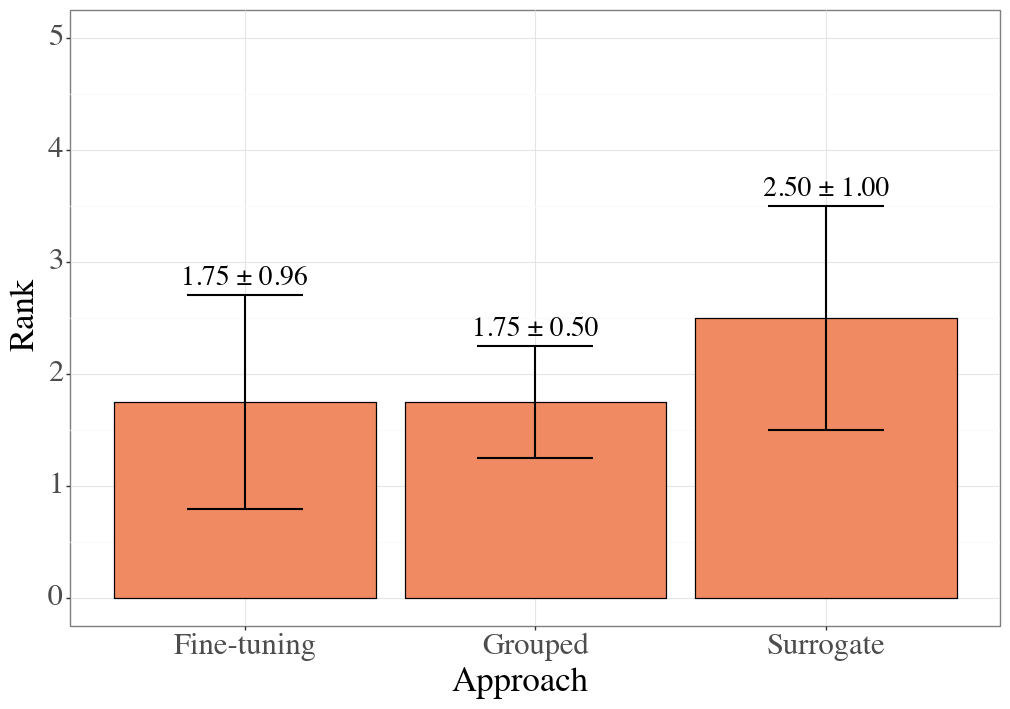

<ggplot: (812349987)>

In [105]:
p9.ggplot(method_vs_fine_tuning_ranked_df[method_vs_fine_tuning_ranked_df['split'] == 'Testing'],
  p9.aes(x = 'method', y = 'performance_rank_mean')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000', fill = '#ef8a62') + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_rank_mean - performance_rank_std', ymax = 'performance_rank_mean + performance_rank_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.geom_text(p9.aes(y = 'performance_rank_mean + performance_rank_std + 0.15', label = 'label'), position = p9.position_dodge2(width = .9), size = 20) + \
  p9.xlab('Approach') + \
  p9.ylab('Rank') + \
  p9.ylim(0, 5) + \
  p9.theme(
    legend_position = [.24, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

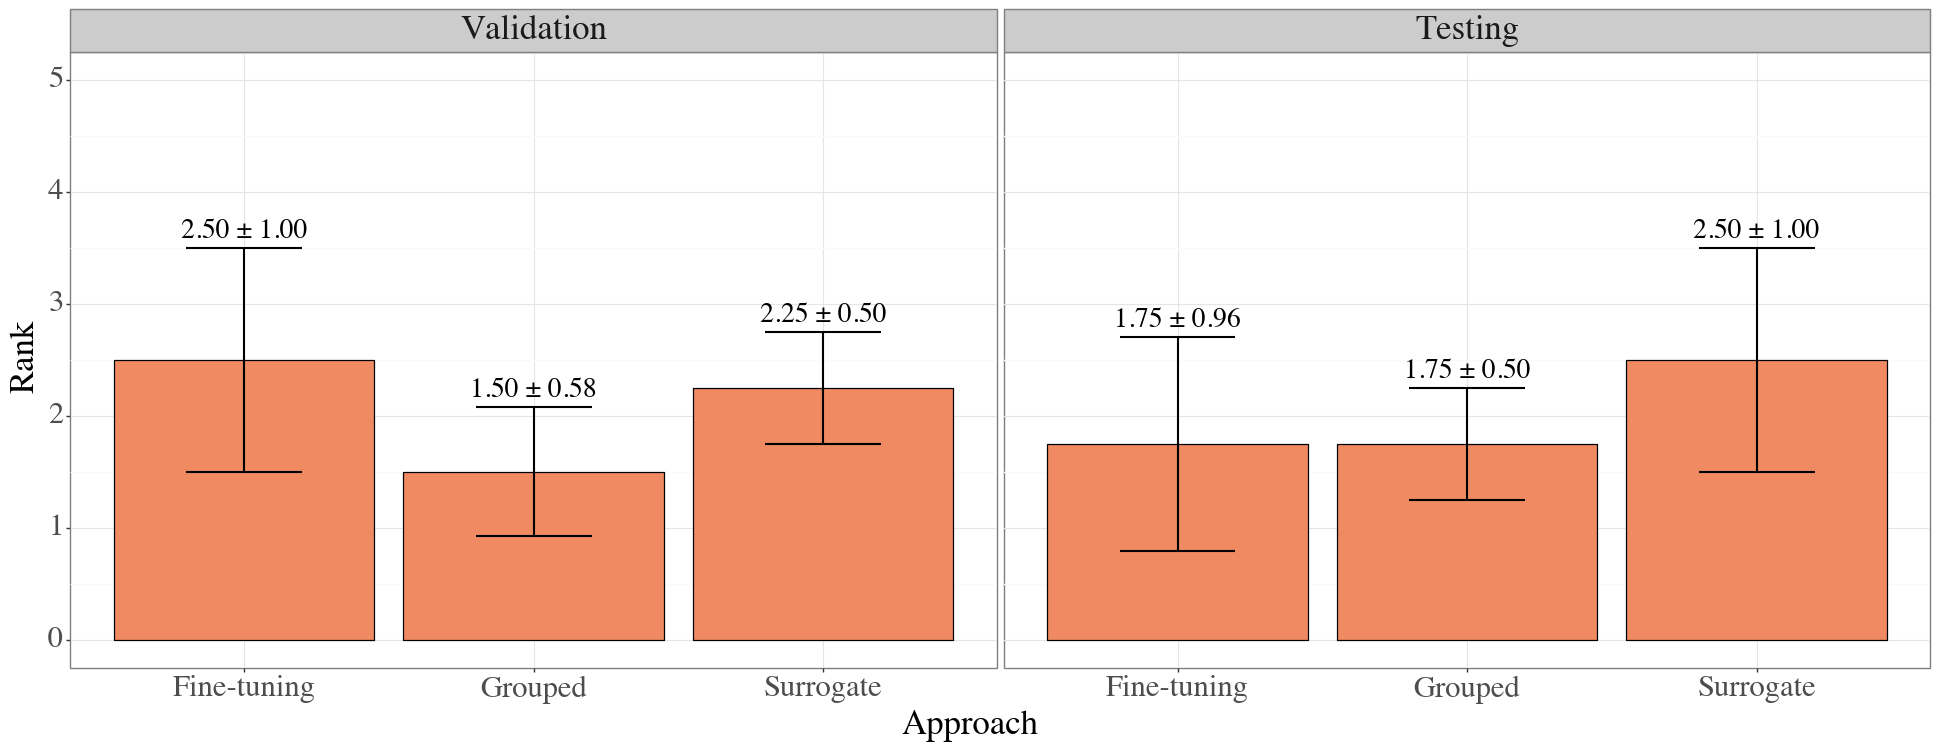

<ggplot: (812639148)>

In [106]:
p9.ggplot(method_vs_fine_tuning_ranked_df,
  p9.aes(x = 'method', y = 'performance_rank_mean')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000', fill = '#ef8a62') + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_rank_mean - performance_rank_std', ymax = 'performance_rank_mean + performance_rank_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.geom_text(p9.aes(y = 'performance_rank_mean + performance_rank_std + 0.15', label = 'label'), position = p9.position_dodge2(width = .9), size = 20) + \
  p9.facet_wrap('~ split', ncol = 2) + \
  p9.xlab('Approach') + \
  p9.ylab('Rank') + \
  p9.ylim(0, 5) + \
  p9.theme(
    legend_position = [.24, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

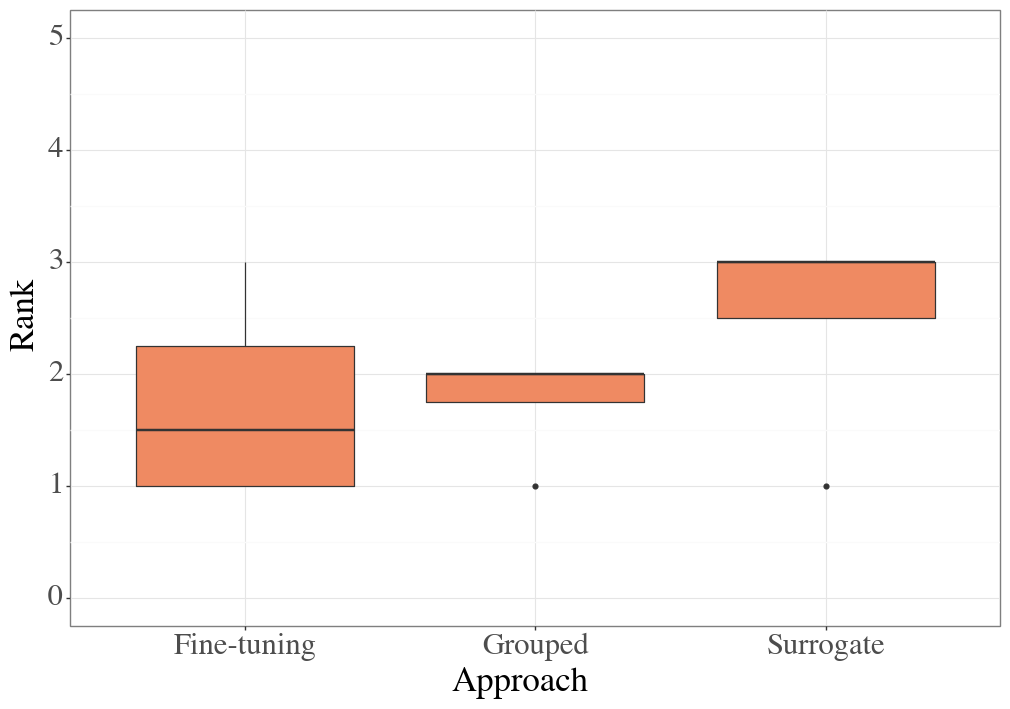

<ggplot: (811880743)>

In [107]:
p9.ggplot(method_vs_fine_tuning_df[method_vs_fine_tuning_df['split'] == 'test'],
  p9.aes(x = 'method', y = 'performance_mean_rank', group = 'method')) + \
  p9.theme_bw() + \
  p9.geom_boxplot(fill = '#ef8a62') + \
  p9.xlab('Approach') + \
  p9.ylab('Rank') + \
  p9.ylim(0, 5) + \
  p9.theme(
    legend_position = [.24, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

In [108]:
method_vs_fine_tuning_df[method_vs_fine_tuning_df['split'] == 'test'].groupby(by = ['method']).agg(
  median_rank = ('performance_mean_rank', 'median')
)

median_rank
method                  
Fine-tuning          1.5
Grouped              2.0
Surrogate            3.0

## Performance change analysis

In [109]:
method_vs_fine_tuning_df = pd.concat([
  get_all_performance_metrics_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['google-bert-bert-base-uncased'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation']
  ),
  get_all_performance_metrics_from_fine_tuning_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    PLMs = ['google-bert-bert-base-uncased']
  )
]).reset_index(drop = True)

In [110]:
method_vs_fine_tuning_df['dataset'] = method_vs_fine_tuning_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

In [111]:
method_vs_fine_tuning_df = method_vs_fine_tuning_df \
  .drop(columns = ['gnn', 'aggregation', 'PLM']) \
  .pivot(index = ['dataset', 'split', 'random_state'], columns = 'method', values = 'performance') \
  .reset_index() \
  .assign(
    Grouped_difference = lambda df : df['Grouped'] - df['Fine-tuning'],
    Surrogate_difference = lambda df : df['Surrogate'] - df['Fine-tuning'],
  ) \
  .melt(
    id_vars = ['dataset', 'split', 'random_state'], 
    value_vars = ['Grouped_difference', 'Surrogate_difference'], 
    var_name = 'method',
    value_name = 'difference'
  ) \
  .assign(
    method = lambda df : df['method'].str.replace('_difference', '', regex = False),
    difference = lambda df : df['difference'] * 100
  ) \
  .sort_values(by = ['dataset', 'random_state']) \
  .groupby(by = ['dataset', 'split', 'method']) \
  .agg(
    performance_difference_mean = ('difference', 'mean'),
    performance_difference_std = ('difference', 'std'),
  ).reset_index()

In [112]:
method_vs_fine_tuning_df['label'] = method_vs_fine_tuning_df['performance_difference_mean'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212')) + ' ± ' + method_vs_fine_tuning_df['performance_difference_std'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212'))

In [113]:
method_vs_fine_tuning_df['split'] = method_vs_fine_tuning_df['split'].replace({'test' : 'Testing'}).str.capitalize()
method_vs_fine_tuning_df['split'] = pd.Categorical(method_vs_fine_tuning_df['split'], categories = ['Validation', 'Testing'])

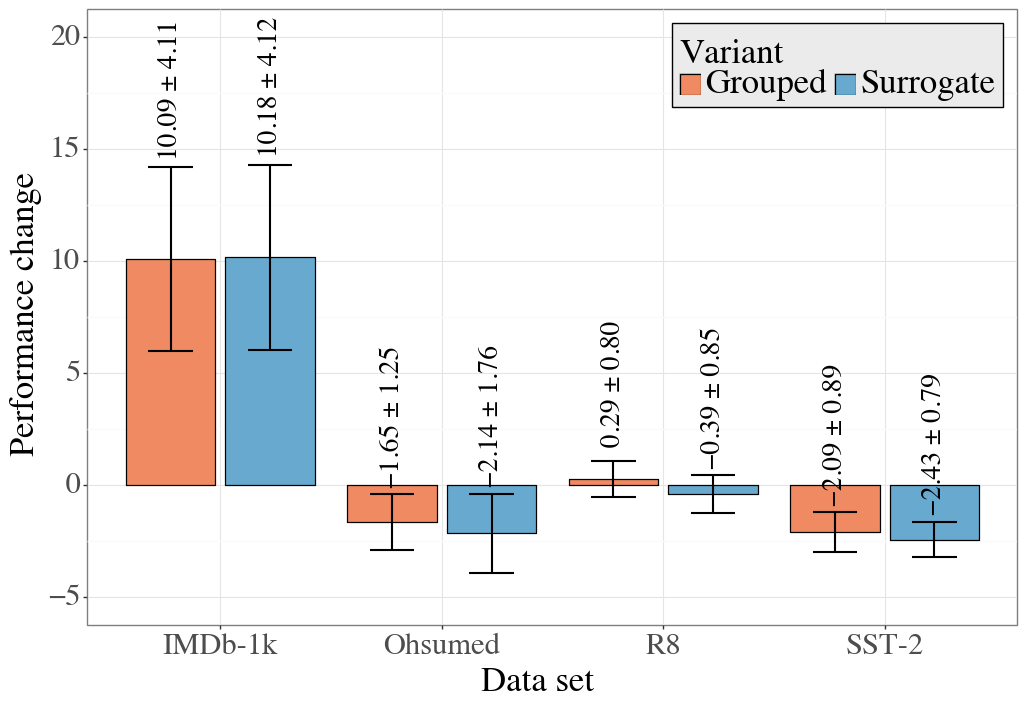

<ggplot: (821074791)>

In [114]:
p9.ggplot(method_vs_fine_tuning_df[(method_vs_fine_tuning_df['split'] == 'Testing')],
  p9.aes(x = 'dataset', y = 'performance_difference_mean', fill = 'method')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000') + \
  p9.geom_text(p9.aes(y = 'performance_difference_mean + performance_difference_std + 3.5', label = 'label'), position = p9.position_dodge2(width = .9), size = 20, angle = 90) + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_difference_mean - performance_difference_std', ymax = 'performance_difference_mean + performance_difference_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.xlab('Data set') + \
  p9.ylab('Performance change') + \
  p9.labs(fill = 'Variant') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(-5, 20) + \
  p9.theme(
    legend_position = [.75, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

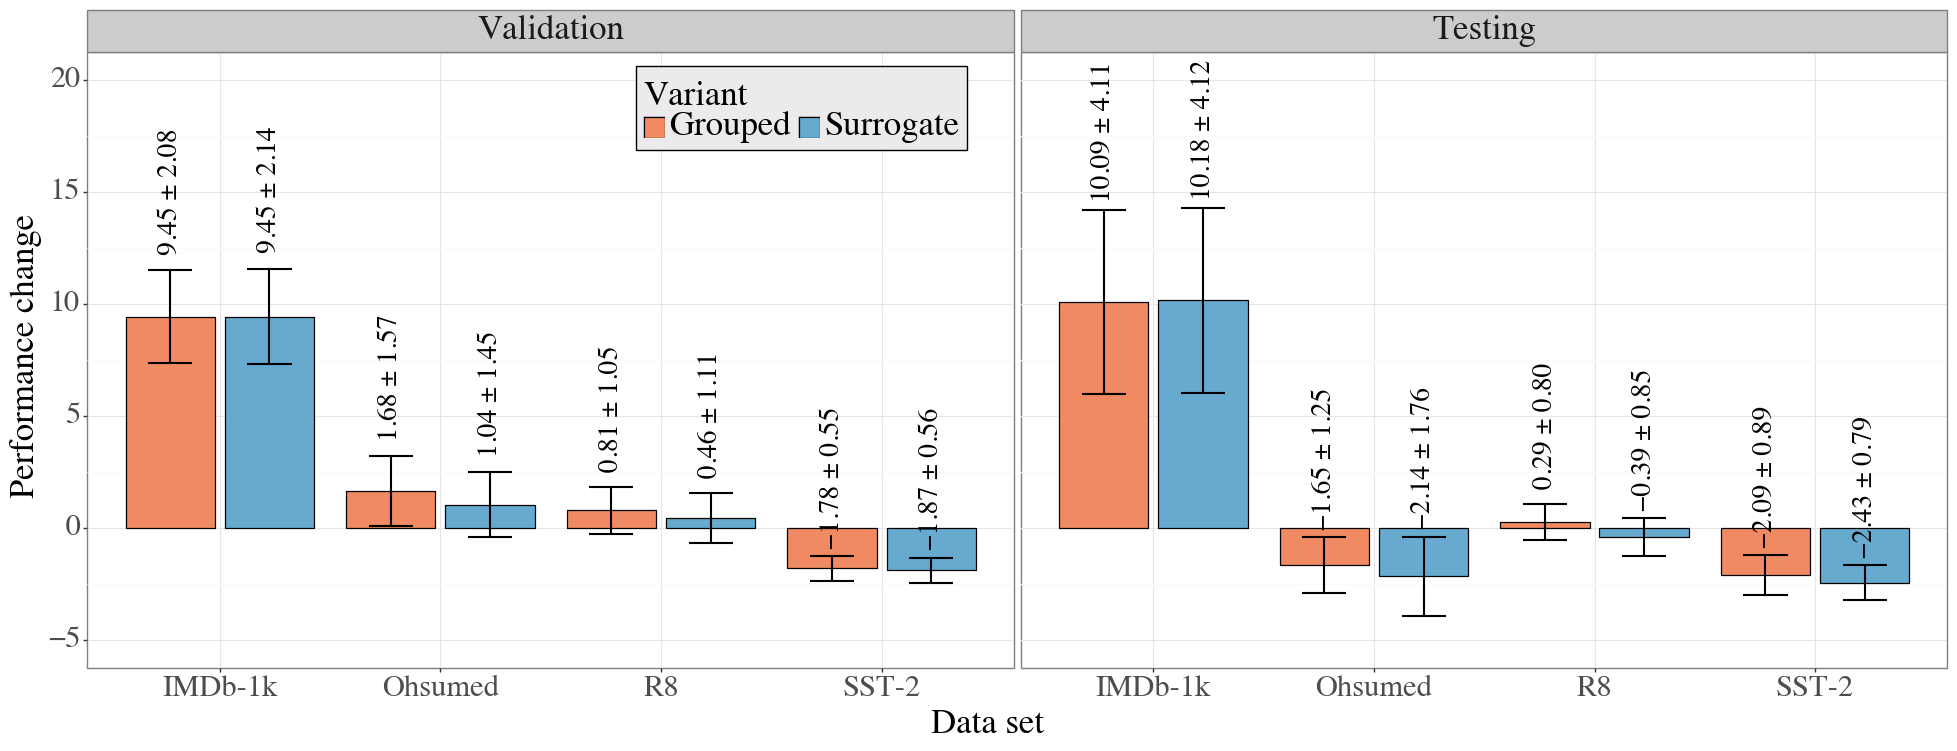

<ggplot: (812475930)>

In [115]:
p9.ggplot(method_vs_fine_tuning_df,
  p9.aes(x = 'dataset', y = 'performance_difference_mean', fill = 'method')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000') + \
  p9.geom_text(p9.aes(y = 'performance_difference_mean + performance_difference_std + 3.5', label = 'label'), position = p9.position_dodge2(width = .9), size = 20, angle = 90) + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_difference_mean - performance_difference_std', ymax = 'performance_difference_mean + performance_difference_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.xlab('Data set') + \
  p9.ylab('Performance change') + \
  p9.labs(fill = 'Variant') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.facet_wrap('~ split', ncol = 2) + \
  p9.ylim(-5, 20) + \
  p9.theme(
    legend_position = [.4225, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

#### Are the differences statistically significant?

In [116]:
method_vs_fine_tuning_stats_df = pd.concat([
  get_all_performance_metrics_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['google-bert-bert-base-uncased'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation']
  ),
  get_all_performance_metrics_from_fine_tuning_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    PLMs = ['google-bert-bert-base-uncased'],
  )
]).reset_index(drop = True)

In [117]:
method_vs_fine_tuning_stats_df['dataset'] = method_vs_fine_tuning_stats_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

In [118]:
method_vs_fine_tuning_stats_df

random_state       split  performance  dataset    gnn  \
0             42  validation     0.907110    SST-2  GATv2   
1             42        test     0.891818    SST-2  GATv2   
2             45  validation     0.902523    SST-2  GATv2   
3             45        test     0.897309    SST-2  GATv2   
4             44  validation     0.902523    SST-2  GATv2   
..           ...         ...          ...      ...    ...   
235           46        test     0.779104  IMDb-1k    N/A   
236           41  validation     0.824242  IMDb-1k    N/A   
237           41        test     0.853731  IMDb-1k    N/A   
238           40  validation     0.818182  IMDb-1k    N/A   
239           40        test     0.841791  IMDb-1k    N/A   

                               PLM       method     aggregation  
0    google-bert-bert-base-uncased      Grouped  No_Aggregation  
1    google-bert-bert-base-uncased      Grouped  No_Aggregation  
2    google-bert-bert-base-uncased      Grouped  No_Aggregation  
3    google-bert-bert-base-uncased      Grouped  No_Aggregation  
4    google-bert-bert-base-uncased      Grouped  No_Aggregation  
..                             ...          ...             ...  
235  google-bert-bert-base-uncased  Fine-tuning             N/A  
236  google-bert-bert-base-uncased  Fine-tuning             N/A  
237  google-bert-bert-base-uncased  Fine-tuning             N/A  
238  google-bert-bert-base-uncased  Fine-tuning             N/A  
239  google-bert-bert-base-uncased  Fine-tuning             N/A  

[240 rows x 8 columns]

In [119]:

for dataset in ['SST-2', 'Ohsumed', 'R8', 'IMDb-1k']:
  print('-' * 10, dataset, '-' * 10)
  for i, split in enumerate(['validation', 'test']):
    print('>>', split)
    split_df = method_vs_fine_tuning_stats_df[(method_vs_fine_tuning_stats_df['dataset'] == dataset) & (method_vs_fine_tuning_stats_df['split'] == split)].drop(columns = ['split', 'gnn', 'PLM', 'aggregation']) \
      .pivot(index = ['dataset', 'random_state'], columns = 'method', values = 'performance') \
      .reset_index() \
      .sort_values(by = ['dataset', 'random_state'])
    
    for (x, y) in itertools.combinations(['Grouped', 'Surrogate', 'Fine-tuning'], 2):
      # H0: Mean Grouped and Surrogate scores are equal
      # H1: Mean Grouped and Surrogate scores are not equal
      statistic, p_value = stats.ttest_ind(split_df[x], split_df[y])
      # 95% confidence -- p-value < 0.05 => reject the null hypothesis (H0), i.e., the true mean test score is different between the approaches
      print(f'{x} - {y}:', 'Statistic:', statistic, 'P-value:', p_value, 'Reject H0?', p_value < 0.05)
  print('')

---------- SST-2 ----------
>> validation
Grouped - Surrogate: Statistic: 0.49236596391719784 P-value: 0.6284122389757785 Reject H0? False
Grouped - Fine-tuning: Statistic: -8.888235523830165 P-value: 5.302698955156888e-08 Reject H0? True
Surrogate - Fine-tuning: Statistic: -7.931583932480326 P-value: 2.7689949160158536e-07 Reject H0? True
>> test
Grouped - Surrogate: Statistic: 1.0069807346193695 P-value: 0.3272898363794695 Reject H0? False
Grouped - Fine-tuning: Statistic: -7.651523700432582 P-value: 4.5939535392771435e-07 Reject H0? True
Surrogate - Fine-tuning: Statistic: -8.778185137886654 P-value: 6.375726989471786e-08 Reject H0? True

---------- Ohsumed ----------
>> validation
Grouped - Surrogate: Statistic: 1.0442036536267962 P-value: 0.31021274733132537 Reject H0? False
Grouped - Fine-tuning: Statistic: 2.5594193516646913 P-value: 0.01970759080433761 Reject H0? True
Surrogate - Fine-tuning: Statistic: 1.5602261246822973 P-value: 0.13611553536472984 Reject H0? False
>> test
Gr

# Sliding windows vs. our method

In [120]:
def load_performance_metrics_from_sliding_windows(dataset, PLM, gnn, method, target_metric, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{PLM.replace("/", "-")}-{method}-Sliding_Windows'
  storage = f'sqlite:///../../sliding_windows/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N)
  
  performance = list()
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    random_states = [x for x in os.listdir(f'../../sliding_window_outputs/{dataset}-{gnn}-{PLM}/{method}/Sliding_Windows/{trial}') if os.path.isdir(f'../../sliding_window_outputs/{dataset}-{gnn}-{PLM}/{method}/Sliding_Windows/{trial}/{x}')]
    if len(random_states) < 10:
      continue

    for random_state in random_states:
      df = pd.read_csv(f'../../sliding_window_outputs/{dataset}-{gnn}-{PLM}/{method}/Sliding_Windows/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
    break
  
  performance_df = pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])
  return performance_df.groupby(['trial', 'split']).agg(
    performance_mean = (target_metric, 'mean'),
    performance_std = (target_metric, 'std')
  ).reset_index()

In [121]:
def get_all_performance_metrics_from_sliding_windows(datasets, target_metrics, PLMs, gnns, methods):
  l = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for PLM in PLMs:
      for gnn in gnns:
        for method in methods:
          l.append(
            load_performance_metrics_from_sliding_windows(
              dataset = dataset,
              PLM = PLM,
              gnn = gnn,
              method = method,
              target_metric = target_metric,
              display_information = False
            ).assign(
              dataset = dataset,
              gnn = gnn,
              PLM = PLM,
              method = f'Sliding Windows\n({method})',
              aggregation = 'N/A'
            ).drop(columns = ['trial'])
          )
  return pd.concat(l, axis = 0).reset_index(drop = True)

In [122]:
def load_performance_metrics_from_sliding_windows_for_T_tests(dataset, PLM, gnn, method, target_metric, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{PLM.replace("/", "-")}-{method}-Sliding_Windows'
  storage = f'sqlite:///../../sliding_windows/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N)
  
  performance = list()
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    random_states = [x for x in os.listdir(f'../../sliding_window_outputs/{dataset}-{gnn}-{PLM}/{method}/Sliding_Windows/{trial}') if os.path.isdir(f'../../sliding_window_outputs/{dataset}-{gnn}-{PLM}/{method}/Sliding_Windows/{trial}/{x}')]
    if len(random_states) < 10:
      continue

    for random_state in random_states:
      df = pd.read_csv(f'../../sliding_window_outputs/{dataset}-{gnn}-{PLM}/{method}/Sliding_Windows/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
    break
  
  return pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])[['random_state', 'split', target_metric]].rename(columns = {target_metric : 'performance'})

In [123]:
def get_all_performance_metrics_from_sliding_windows_for_T_tests(datasets, target_metrics, PLMs, gnns, methods):
  l = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for PLM in PLMs:
      for gnn in gnns:
        for method in methods:
          l.append(
            load_performance_metrics_from_sliding_windows_for_T_tests(
              dataset = dataset,
              PLM = PLM,
              gnn = gnn,
              method = method,
              target_metric = target_metric,
              display_information = False
            ).assign(
              dataset = dataset,
              gnn = gnn,
              PLM = PLM,
              method = f'Sliding Windows ({method})',
              aggregation = 'N/A'
            )
          )
  return pd.concat(l, axis = 0).reset_index(drop = True)

## Rank analysis

In [124]:
method_vs_sliding_windows_df = pd.concat([
  get_all_performance_metrics(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['facebook-bart-large'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation']
  ),
  get_all_performance_metrics_from_sliding_windows(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    PLMs = ['facebook-bart-large'],
    gnns = ['GATv2'],
    methods = ['Grouped'],
  )
]).reset_index(drop = True)

In [125]:
for column in [x for x in method_vs_sliding_windows_df.columns if x.endswith('_mean')]:
  method_vs_sliding_windows_df[f'{column}_rank'] = method_vs_sliding_windows_df[['dataset', 'split', column]] \
    .groupby(['dataset', 'split']) \
    .rank(method = 'max', ascending = False)

In [126]:
method_vs_sliding_windows_ranked_df = method_vs_sliding_windows_df.groupby(['split', 'method']).agg(
  performance_rank_mean = ('performance_mean_rank', 'mean'),
  performance_rank_std = ('performance_mean_rank', 'std'),
).reset_index()

In [127]:
method_vs_sliding_windows_ranked_df['label'] = method_vs_sliding_windows_ranked_df['performance_rank_mean'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212')) + ' ± ' + method_vs_sliding_windows_ranked_df['performance_rank_std'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212'))

In [128]:
method_vs_sliding_windows_ranked_df['split'] = method_vs_sliding_windows_ranked_df['split'].replace({'test' : 'Testing'}).str.capitalize()
method_vs_sliding_windows_ranked_df['split'] = pd.Categorical(method_vs_sliding_windows_ranked_df['split'], categories = ['Validation', 'Testing'])

In [129]:
method_vs_sliding_windows_ranked_df

split                      method  performance_rank_mean  \
0     Testing                     Grouped                   2.25   
1     Testing  Sliding Windows\n(Grouped)                   2.50   
2     Testing                   Surrogate                   1.25   
3  Validation                     Grouped                   1.75   
4  Validation  Sliding Windows\n(Grouped)                   2.25   
5  Validation                   Surrogate                   2.00   

   performance_rank_std        label  
0              0.957427  2.25 ± 0.96  
1              0.577350  2.50 ± 0.58  
2              0.500000  1.25 ± 0.50  
3              0.957427  1.75 ± 0.96  
4              0.957427  2.25 ± 0.96  
5              0.816497  2.00 ± 0.82

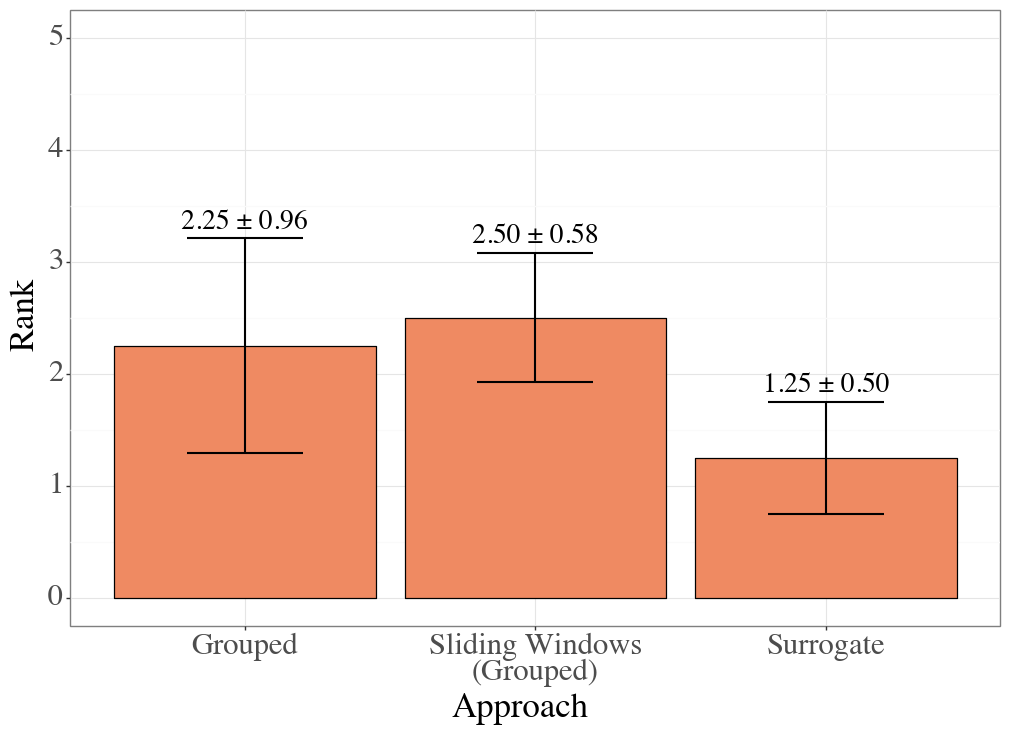

<ggplot: (811833726)>

In [130]:
p9.ggplot(method_vs_sliding_windows_ranked_df[method_vs_sliding_windows_ranked_df['split'] == 'Testing'],
  p9.aes(x = 'method', y = 'performance_rank_mean')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000', fill = '#ef8a62') + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_rank_mean - performance_rank_std', ymax = 'performance_rank_mean + performance_rank_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.geom_text(p9.aes(y = 'performance_rank_mean + performance_rank_std + 0.15', label = 'label'), position = p9.position_dodge2(width = .9), size = 20) + \
  p9.xlab('Approach') + \
  p9.ylab('Rank') + \
  p9.ylim(0, 5) + \
  p9.theme(
    legend_position = [.24, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

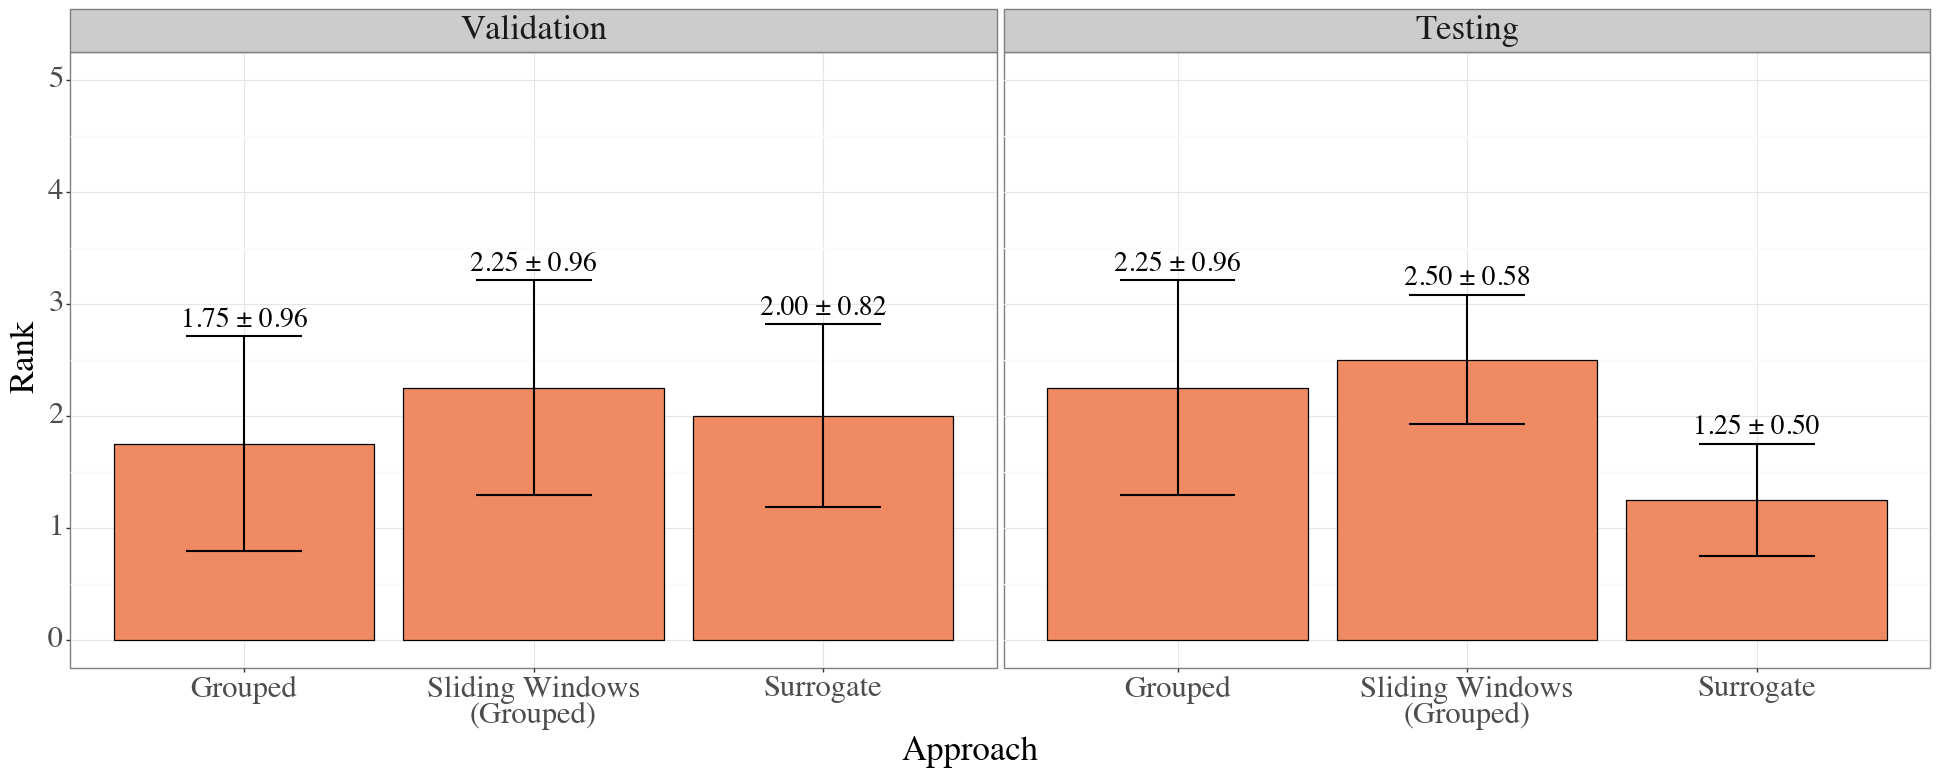

<ggplot: (811833702)>

In [131]:
p9.ggplot(method_vs_sliding_windows_ranked_df,
  p9.aes(x = 'method', y = 'performance_rank_mean')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000', fill = '#ef8a62') + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_rank_mean - performance_rank_std', ymax = 'performance_rank_mean + performance_rank_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.geom_text(p9.aes(y = 'performance_rank_mean + performance_rank_std + 0.15', label = 'label'), position = p9.position_dodge2(width = .9), size = 20) + \
  p9.facet_wrap('~ split', ncol = 2) + \
  p9.xlab('Approach') + \
  p9.ylab('Rank') + \
  p9.ylim(0, 5) + \
  p9.theme(
    legend_position = [.24, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

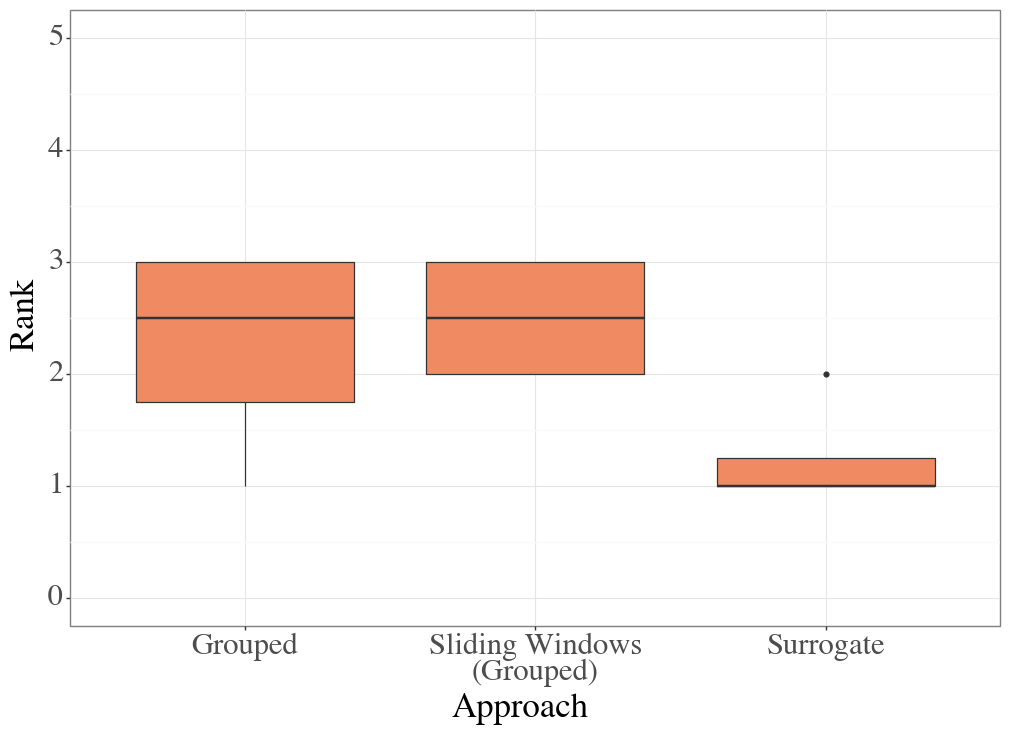

<ggplot: (811833636)>

In [132]:
p9.ggplot(method_vs_sliding_windows_df[method_vs_sliding_windows_df['split'] == 'test'],
  p9.aes(x = 'method', y = 'performance_mean_rank', group = 'method')) + \
  p9.theme_bw() + \
  p9.geom_boxplot(fill = '#ef8a62') + \
  p9.xlab('Approach') + \
  p9.ylab('Rank') + \
  p9.ylim(0, 5) + \
  p9.theme(
    legend_position = [.24, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

In [133]:
method_vs_sliding_windows_df[method_vs_sliding_windows_df['split'] == 'test'].groupby(by = ['method']).agg(
  median_rank = ('performance_mean_rank', 'median')
)

median_rank
method                                 
Grouped                             2.5
Sliding Windows\n(Grouped)          2.5
Surrogate                           1.0

## Performance change analysis

In [134]:
method_vs_sliding_windows_df = pd.concat([
  get_all_performance_metrics_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['facebook-bart-large'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation']
  ),
  get_all_performance_metrics_from_sliding_windows_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    PLMs = ['facebook-bart-large'],
    gnns = ['GATv2'],
    methods = ['Grouped'],
  )
]).reset_index(drop = True)

In [135]:
method_vs_sliding_windows_df['dataset'] = method_vs_sliding_windows_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

In [136]:
method_vs_sliding_windows_df = method_vs_sliding_windows_df \
  .drop(columns = ['gnn', 'aggregation', 'PLM']) \
  .pivot(index = ['dataset', 'split', 'random_state'], columns = 'method', values = 'performance') \
  .reset_index() \
  .assign(
    Grouped_difference = lambda df : df['Grouped'] - df['Sliding Windows (Grouped)'],
    Surrogate_difference = lambda df : df['Surrogate'] - df['Sliding Windows (Grouped)'],
  ) \
  .melt(
    id_vars = ['dataset', 'split', 'random_state'], 
    value_vars = ['Grouped_difference', 'Surrogate_difference'], 
    var_name = 'method',
    value_name = 'difference'
  ) \
  .assign(
    method = lambda df : df['method'].str.replace('_difference', '', regex = False),
    difference = lambda df : df['difference'] * 100
  ) \
  .sort_values(by = ['dataset', 'random_state']) \
  .groupby(by = ['dataset', 'split', 'method']) \
  .agg(
    performance_difference_mean = ('difference', 'mean'),
    performance_difference_std = ('difference', 'std'),
  ).reset_index()

In [137]:
method_vs_sliding_windows_df['label'] = method_vs_sliding_windows_df['performance_difference_mean'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212')) + ' ± ' + method_vs_sliding_windows_df['performance_difference_std'].map(lambda x : '{:.2f}'.format(x).replace('-', u'\u2212'))

In [138]:
method_vs_sliding_windows_df['split'] = method_vs_sliding_windows_df['split'].replace({'test' : 'Testing'}).str.capitalize()
method_vs_sliding_windows_df['split'] = pd.Categorical(method_vs_sliding_windows_df['split'], categories = ['Validation', 'Testing'])

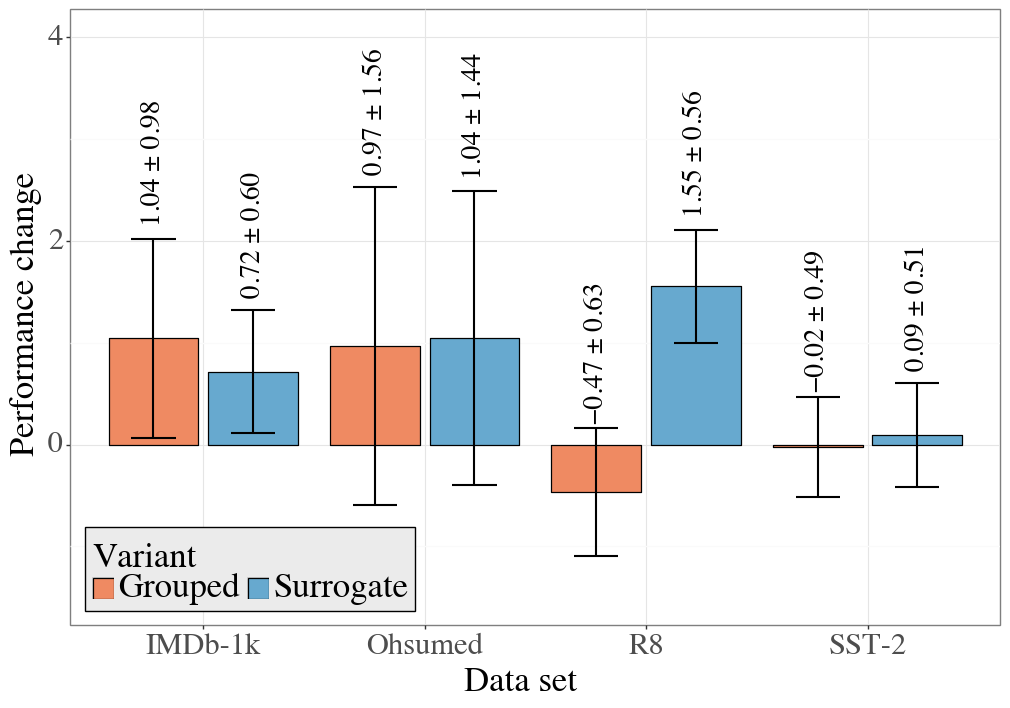

<ggplot: (813590736)>

In [139]:
p9.ggplot(method_vs_sliding_windows_df[(method_vs_sliding_windows_df['split'] == 'Testing')],
  p9.aes(x = 'dataset', y = 'performance_difference_mean', fill = 'method')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000') + \
  p9.geom_text(p9.aes(y = 'performance_difference_mean + performance_difference_std + 0.75', label = 'label'), position = p9.position_dodge2(width = .9), size = 20, angle = 90) + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_difference_mean - performance_difference_std', ymax = 'performance_difference_mean + performance_difference_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.xlab('Data set') + \
  p9.ylab('Performance change') + \
  p9.labs(fill = 'Variant') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(-1.5, 4) + \
  p9.theme(
    legend_position = [.275, .18],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

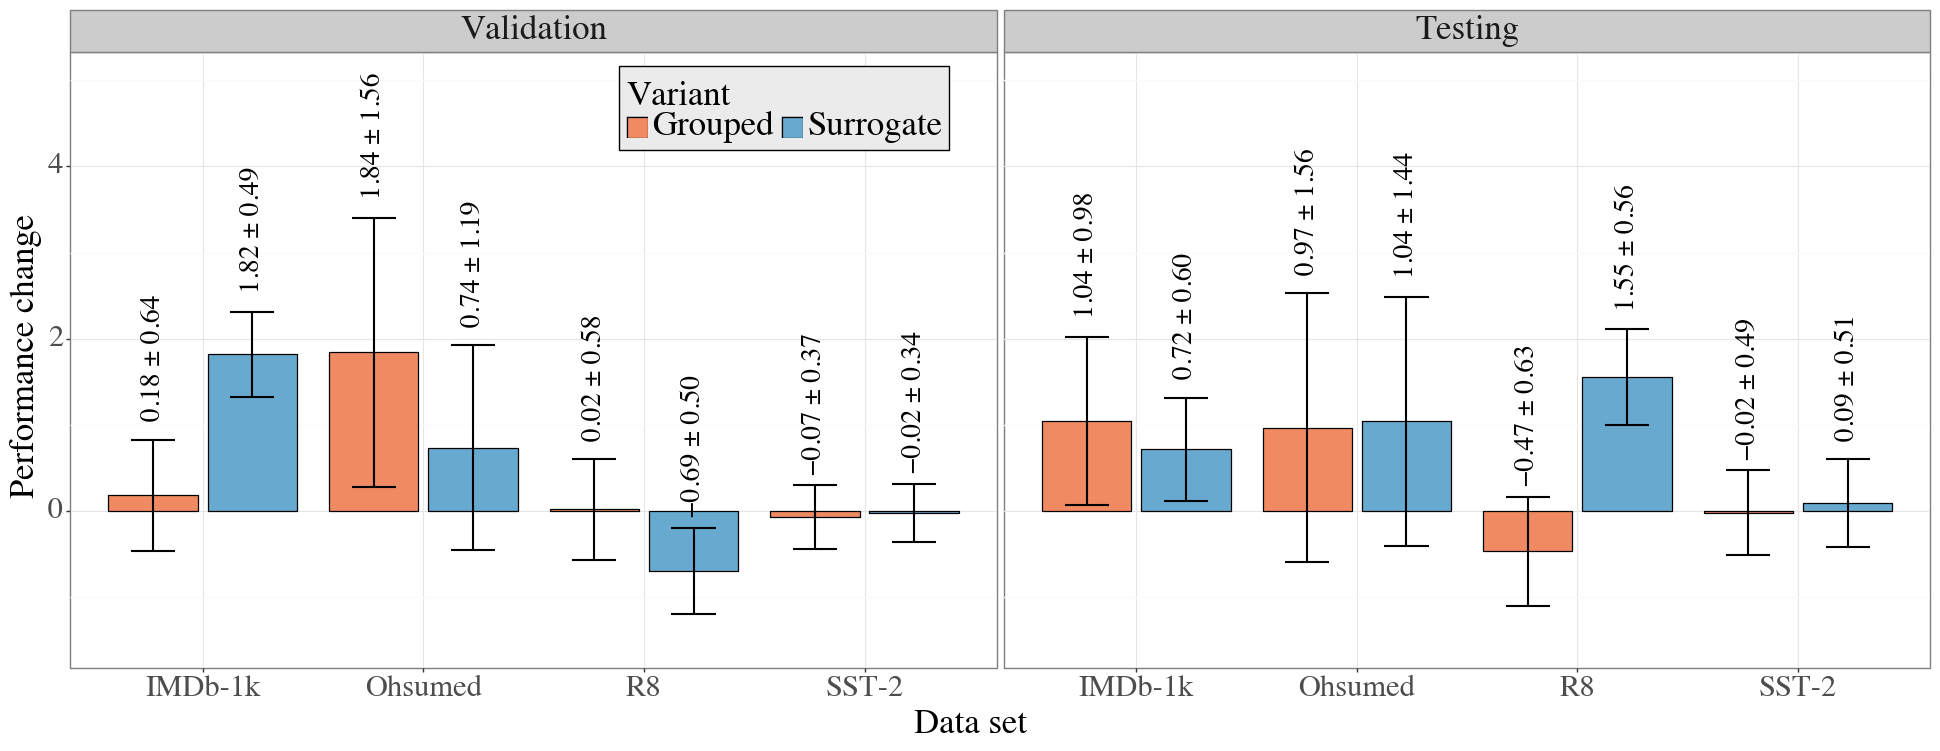

<ggplot: (813629332)>

In [140]:
p9.ggplot(method_vs_sliding_windows_df,
  p9.aes(x = 'dataset', y = 'performance_difference_mean', fill = 'method')) + \
  p9.theme_bw() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), colour = '#000000') + \
  p9.geom_text(p9.aes(y = 'performance_difference_mean + performance_difference_std + 0.95', label = 'label'), position = p9.position_dodge2(width = .9), size = 20, angle = 90) + \
  p9.geom_errorbar(p9.aes(ymin = 'performance_difference_mean - performance_difference_std', ymax = 'performance_difference_mean + performance_difference_std'), position = p9.position_dodge(width = .9), width = .4, size = .85) + \
  p9.facet_wrap('~ split', ncol = 2) + \
  p9.xlab('Data set') + \
  p9.ylab('Performance change') + \
  p9.labs(fill = 'Variant') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(-1.5, 5) + \
  p9.theme(
    legend_position = [.4225, .81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

#### Are the differences statistically significant?

In [141]:
method_vs_sliding_windows_stats_df = pd.concat([
  get_all_performance_metrics_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    PLMs = ['facebook-bart-large'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation']
  ),
  get_all_performance_metrics_from_sliding_windows_for_T_tests(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    PLMs = ['facebook-bart-large'],
    gnns = ['GATv2'],
    methods = ['Grouped'],
  )
]).reset_index(drop = True)

In [142]:
method_vs_sliding_windows_stats_df['dataset'] = method_vs_fine_tuning_stats_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

In [143]:
method_vs_sliding_windows_stats_df

random_state       split  performance  dataset    gnn  \
0             42  validation     0.948394    SST-2  GATv2   
1             42        test     0.946733    SST-2  GATv2   
2             45  validation     0.947248    SST-2  GATv2   
3             45        test     0.948380    SST-2  GATv2   
4             44  validation     0.944954    SST-2  GATv2   
..           ...         ...          ...      ...    ...   
235           46        test     0.940299  IMDb-1k  GATv2   
236           41  validation     0.957576  IMDb-1k  GATv2   
237           41        test     0.940299  IMDb-1k  GATv2   
238           40  validation     0.951515  IMDb-1k  GATv2   
239           40        test     0.937313  IMDb-1k  GATv2   

                     PLM                     method     aggregation  
0    facebook-bart-large                    Grouped  No_Aggregation  
1    facebook-bart-large                    Grouped  No_Aggregation  
2    facebook-bart-large                    Grouped  No_Aggregation  
3    facebook-bart-large                    Grouped  No_Aggregation  
4    facebook-bart-large                    Grouped  No_Aggregation  
..                   ...                        ...             ...  
235  facebook-bart-large  Sliding Windows (Grouped)             N/A  
236  facebook-bart-large  Sliding Windows (Grouped)             N/A  
237  facebook-bart-large  Sliding Windows (Grouped)             N/A  
238  facebook-bart-large  Sliding Windows (Grouped)             N/A  
239  facebook-bart-large  Sliding Windows (Grouped)             N/A  

[240 rows x 8 columns]

In [144]:

for dataset in ['SST-2', 'Ohsumed', 'R8', 'IMDb-1k']:
  print('-' * 10, dataset, '-' * 10)
  for i, split in enumerate(['validation', 'test']):
    print('>>', split)
    split_df = method_vs_sliding_windows_stats_df[(method_vs_sliding_windows_stats_df['dataset'] == dataset) & (method_vs_sliding_windows_stats_df['split'] == split)].drop(columns = ['split', 'gnn', 'PLM', 'aggregation']) \
      .pivot(index = ['dataset', 'random_state'], columns = 'method', values = 'performance') \
      .reset_index() \
      .sort_values(by = ['dataset', 'random_state'])
    
    for (x, y) in itertools.combinations(['Grouped', 'Surrogate', 'Sliding Windows (Grouped)'], 2):
      # H0: Mean Grouped and Surrogate scores are equal
      # H1: Mean Grouped and Surrogate scores are not equal
      statistic, p_value = stats.ttest_ind(split_df[x], split_df[y])
      # 95% confidence -- p-value < 0.05 => reject the null hypothesis (H0), i.e., the true mean test score is different between the approaches
      print(f'{x} - {y}:', 'Statistic:', statistic, 'P-value:', p_value, 'Reject H0?', p_value < 0.05)
  print('')

---------- SST-2 ----------
>> validation
Grouped - Surrogate: Statistic: -0.5694947974513423 P-value: 0.5760592489175216 Reject H0? False
Grouped - Sliding Windows (Grouped): Statistic: -0.5196152422705625 P-value: 0.6096629078353294 Reject H0? False
Surrogate - Sliding Windows (Grouped): Statistic: -0.182913228254902 P-value: 0.8569105646564549 Reject H0? False
>> test
Grouped - Surrogate: Statistic: -0.6813698161025076 P-value: 0.5043102559579653 Reject H0? False
Grouped - Sliding Windows (Grouped): Statistic: -0.13124359177803735 P-value: 0.8970383913748416 Reject H0? False
Surrogate - Sliding Windows (Grouped): Statistic: 0.5694504204265665 P-value: 0.5760887201462126 Reject H0? False

---------- Ohsumed ----------
>> validation
Grouped - Surrogate: Statistic: 2.1790263763805147 P-value: 0.04286007411252478 Reject H0? True
Grouped - Sliding Windows (Grouped): Statistic: 3.1170929567996457 P-value: 0.005952443305471369 Reject H0? True
Surrogate - Sliding Windows (Grouped): Statisti

# Memory analysis

In [145]:
text_length_df = pd.concat([
  pd.read_csv('../../data/text_properties/IMDb-top_1000/validation.csv').assign(dataset = 'IMDb-top_1000', split = 'validation'),
  pd.read_csv('../../data/text_properties/IMDb-top_1000/test.csv').assign(dataset = 'IMDb-top_1000', split = 'test'),
  pd.read_csv('../../data/text_properties/Ohsumed/validation.csv').assign(dataset = 'Ohsumed', split = 'validation'),
  pd.read_csv('../../data/text_properties/Ohsumed/test.csv').assign(dataset = 'Ohsumed', split = 'test'),
  pd.read_csv('../../data/text_properties/R8/validation.csv').assign(dataset = 'R8', split = 'validation'),
  pd.read_csv('../../data/text_properties/R8/test.csv').assign(dataset = 'R8', split = 'test'),
  pd.read_csv('../../data/text_properties/SST-2/validation.csv').assign(dataset = 'SST-2', split = 'validation'),
  pd.read_csv('../../data/text_properties/SST-2/test.csv').assign(dataset = 'SST-2', split = 'test')
])

In [146]:
sliding_window_df = pd.read_csv('../../limitations/sliding_windows.csv')
sliding_window_df['dataset'] = sliding_window_df['dataset'].replace({'IMDb-top_1000' : 'IMDb-1k'})
sliding_window_df = pd.merge(sliding_window_df, text_length_df, on = ['dataset', 'split', 'index'])

In [147]:
categorical_sliding_window_df = sliding_window_df.copy()
categorical_sliding_window_df['window_size'] = categorical_sliding_window_df['window_size'].astype('category')

In [148]:
plm_df = pd.concat([
  pd.read_csv('../../limitations/facebook-bart-large.csv').assign(PLM = 'BART-L'),
  pd.read_csv('../../limitations/facebook-bart-base.csv').assign(PLM = 'BART'),
  pd.read_csv('../../limitations/FacebookAI-roberta-large.csv').assign(PLM = 'RoBERTa-L'),
  pd.read_csv('../../limitations/google-bert-bert-base-uncased.csv').assign(PLM = 'BERT'),
])
plm_df['dataset'] = plm_df['dataset'].replace({'IMDb-top_1000' : 'IMDb-1k'})

In [149]:
plm_df = pd.merge(plm_df, text_length_df, on = ['dataset', 'split', 'index'])
plm_df['threshold'] = pd.Categorical(plm_df['threshold'], categories = plm_df['threshold'].sort_values(ascending = True).unique().tolist())

## Relationship to text length

In [150]:
plm_df['threshold'] = plm_df['threshold'].astype(float)
tmp_plm_df = plm_df.groupby(by = ['dataset', 'split', 'index', 'approach', 'PLM', 'threshold', 'length']).agg(average_nodes = ('nodes', 'mean'), std_nodes = ('nodes', 'std')).reset_index()
plot = p9.ggplot(tmp_plm_df[tmp_plm_df['PLM'] == 'BART-L'],
  p9.aes(x = 'length', y = 'average_nodes', fill = 'approach')) + \
  p9.theme_bw() + \
  p9.geom_point(size = 3) + \
  p9.xlab('Text length') + \
  p9.ylab('Node count') + \
  p9.labs(fill = 'Variant') + \
  p9.facet_wrap('~ threshold', ncol = 3) + \
  p9.guides(fill = p9.guide_legend(override_aes = {'size' : 5}), shape = p9.guide_legend(override_aes = {'size' : 5})) + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.theme(
    legend_position = 'top',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
    subplots_adjust = {
      'hspace': 0.05,
      'wspace': 0.05
    }
  )

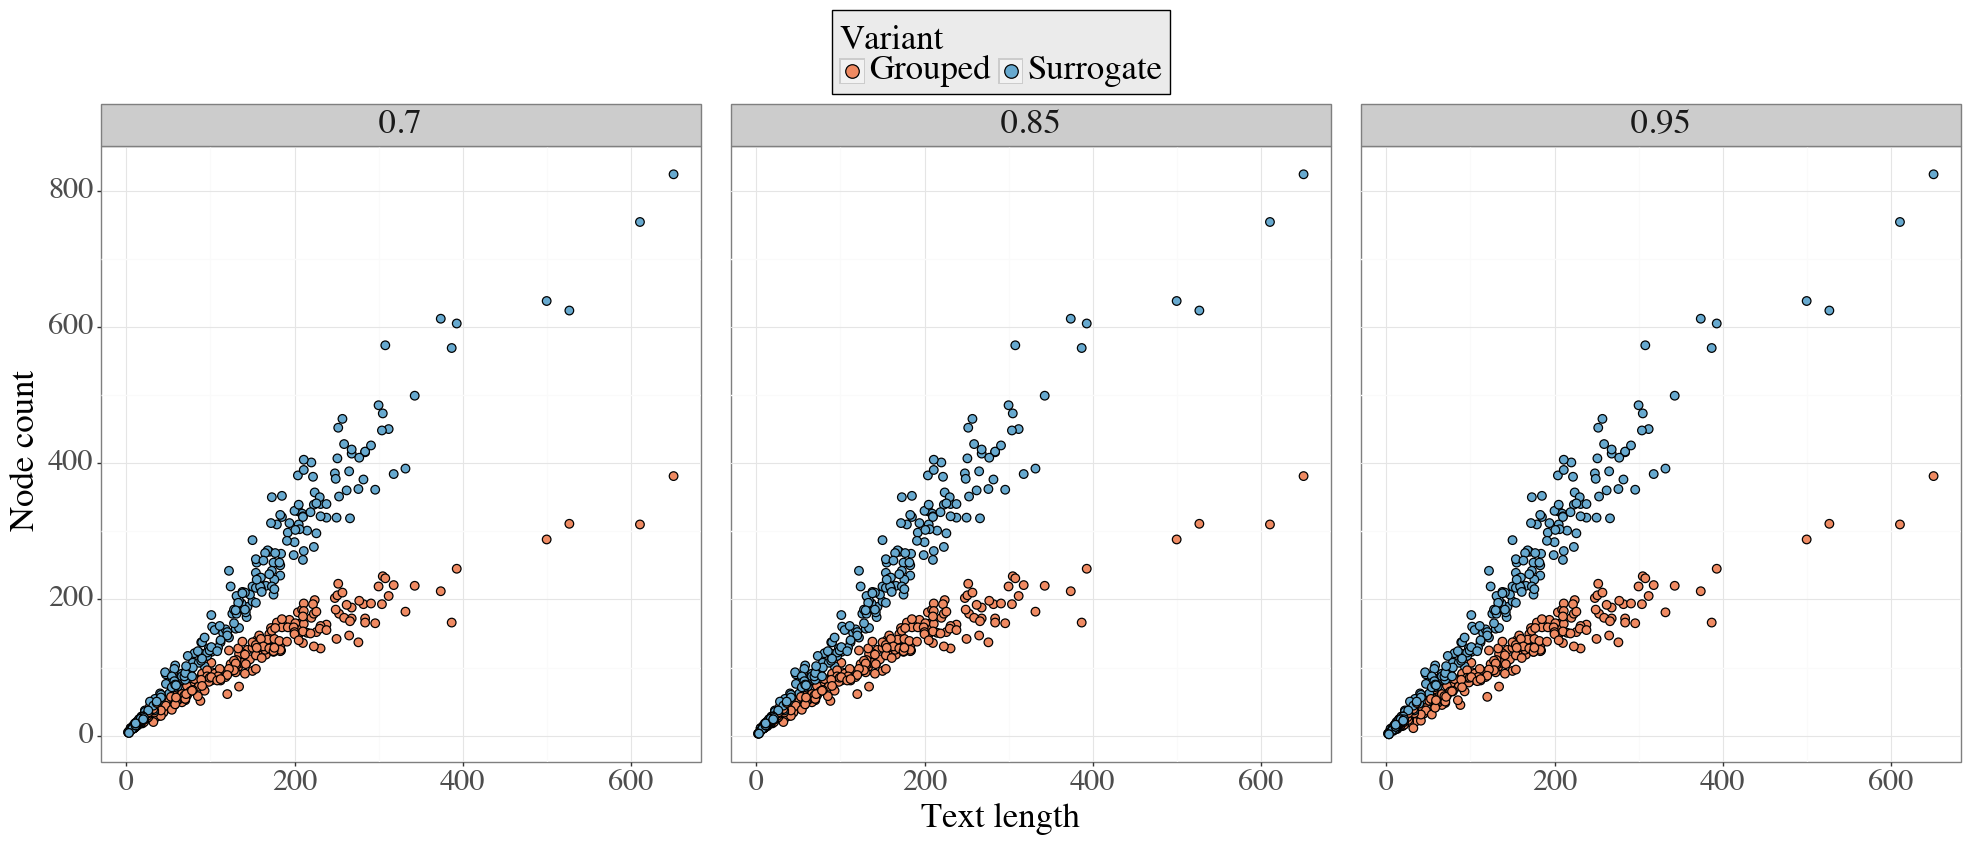

<ggplot: (813886227)>

In [151]:
plot

In [152]:
plot.save(filename = './paper_figures/BART_L_node_count_scatter.png', dpi = 300)

In [153]:
plm_df['threshold'] = plm_df['threshold'].astype(float)
tmp_plm_df = plm_df.groupby(by = ['dataset', 'split', 'index', 'approach', 'PLM', 'threshold', 'length']).agg(average_edges = ('edges', 'mean'), std_edges = ('edges', 'std')).reset_index()
plot = p9.ggplot(tmp_plm_df[tmp_plm_df['PLM'] == 'BART-L'],
  p9.aes(x = 'length', y = 'average_edges', fill = 'approach')) + \
  p9.theme_bw() + \
  p9.geom_point(size = 3) + \
  p9.xlab('Text length') + \
  p9.ylab('Edge count') + \
  p9.labs(fill = 'Variant') + \
  p9.facet_wrap('~ threshold', ncol = 3) + \
  p9.guides(fill = p9.guide_legend(override_aes = {'size' : 5}), shape = p9.guide_legend(override_aes = {'size' : 5})) + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.theme(
    legend_position = 'top',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
    subplots_adjust = {
      'hspace': 0.05,
      'wspace': 0.05
    }
  )

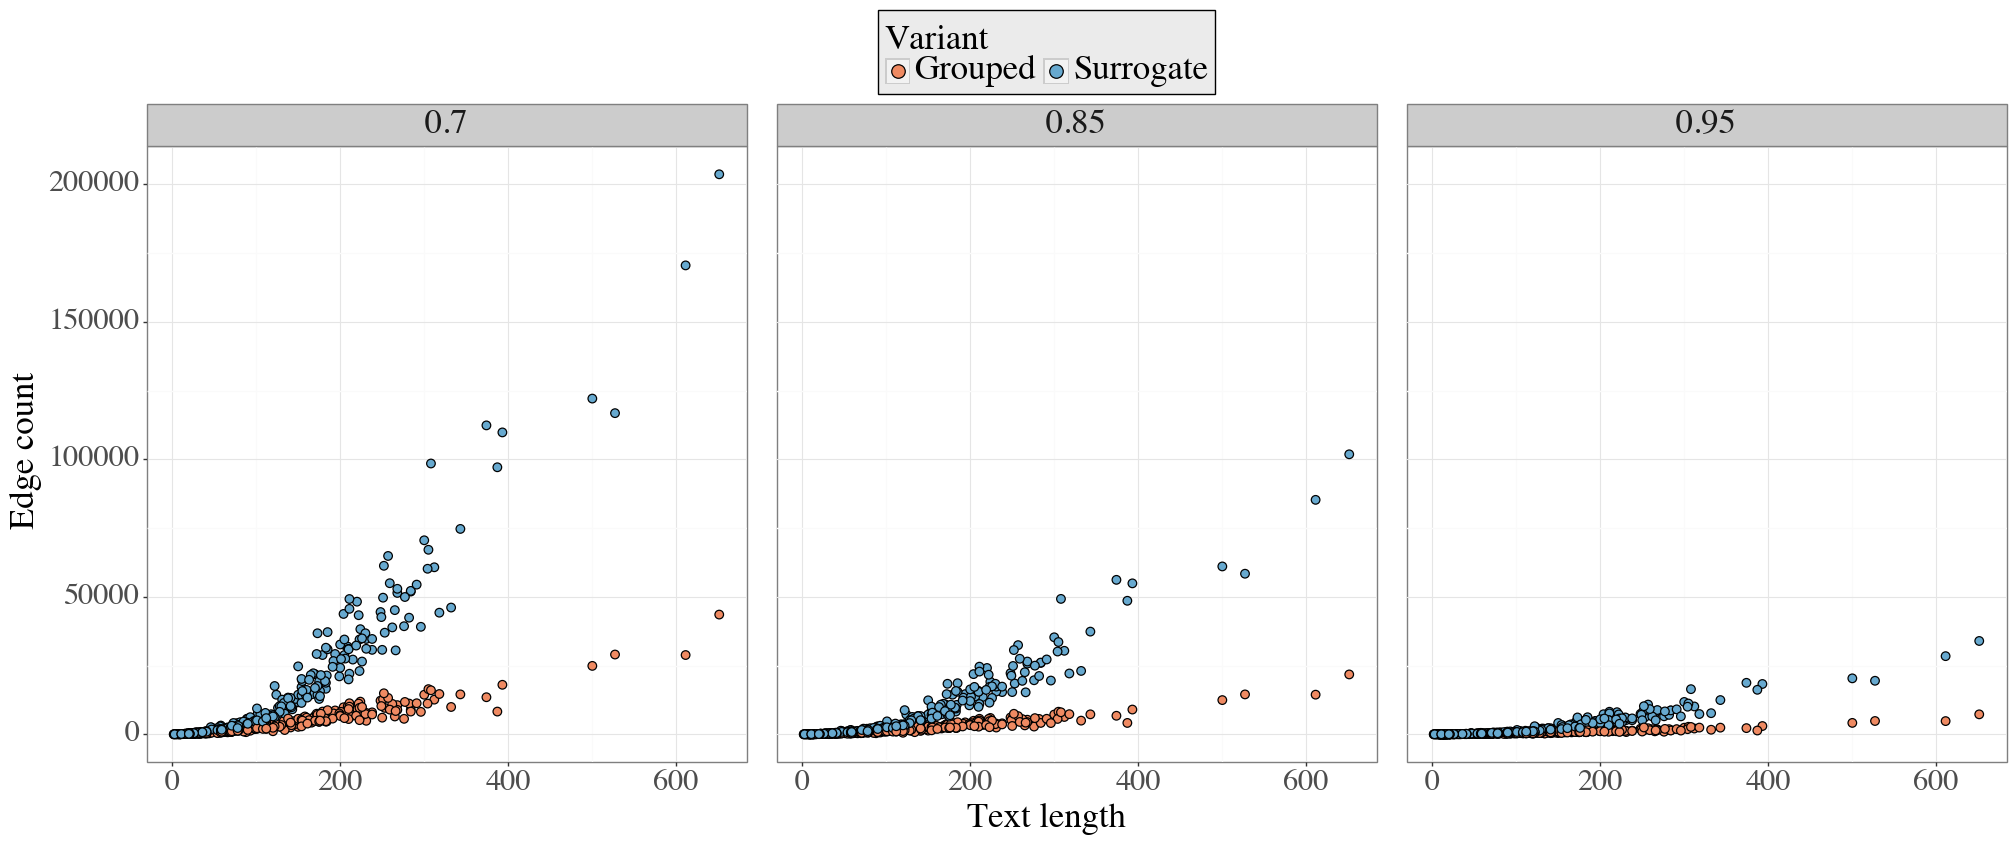

<ggplot: (811801246)>

In [154]:
plot

In [155]:
plot.save(filename = './paper_figures/BART_L_edge_scatter.png', dpi = 300)

In [156]:
plot = p9.ggplot(plm_df.groupby(by = ['dataset', 'split', 'index', 'approach', 'PLM', 'length']).agg(average_time = ('time', 'mean'), std_time = ('time', 'std')).reset_index(),
  p9.aes(x = 'length', y = 'average_time', fill = 'PLM')) + \
  p9.theme_bw() + \
  p9.geom_point(size = 3) + \
  p9.xlab('Text length') + \
  p9.ylab('Time (seconds)') + \
  p9.labs(fill = 'PLM') + \
  p9.facet_wrap('~ approach', ncol = 2) + \
  p9.guides(fill = p9.guide_legend(override_aes = {'size' : 5})) + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.theme(
    legend_position = 'top',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
    subplots_adjust = {
      'hspace': 0.05,
      'wspace': 0.05
    }
  )

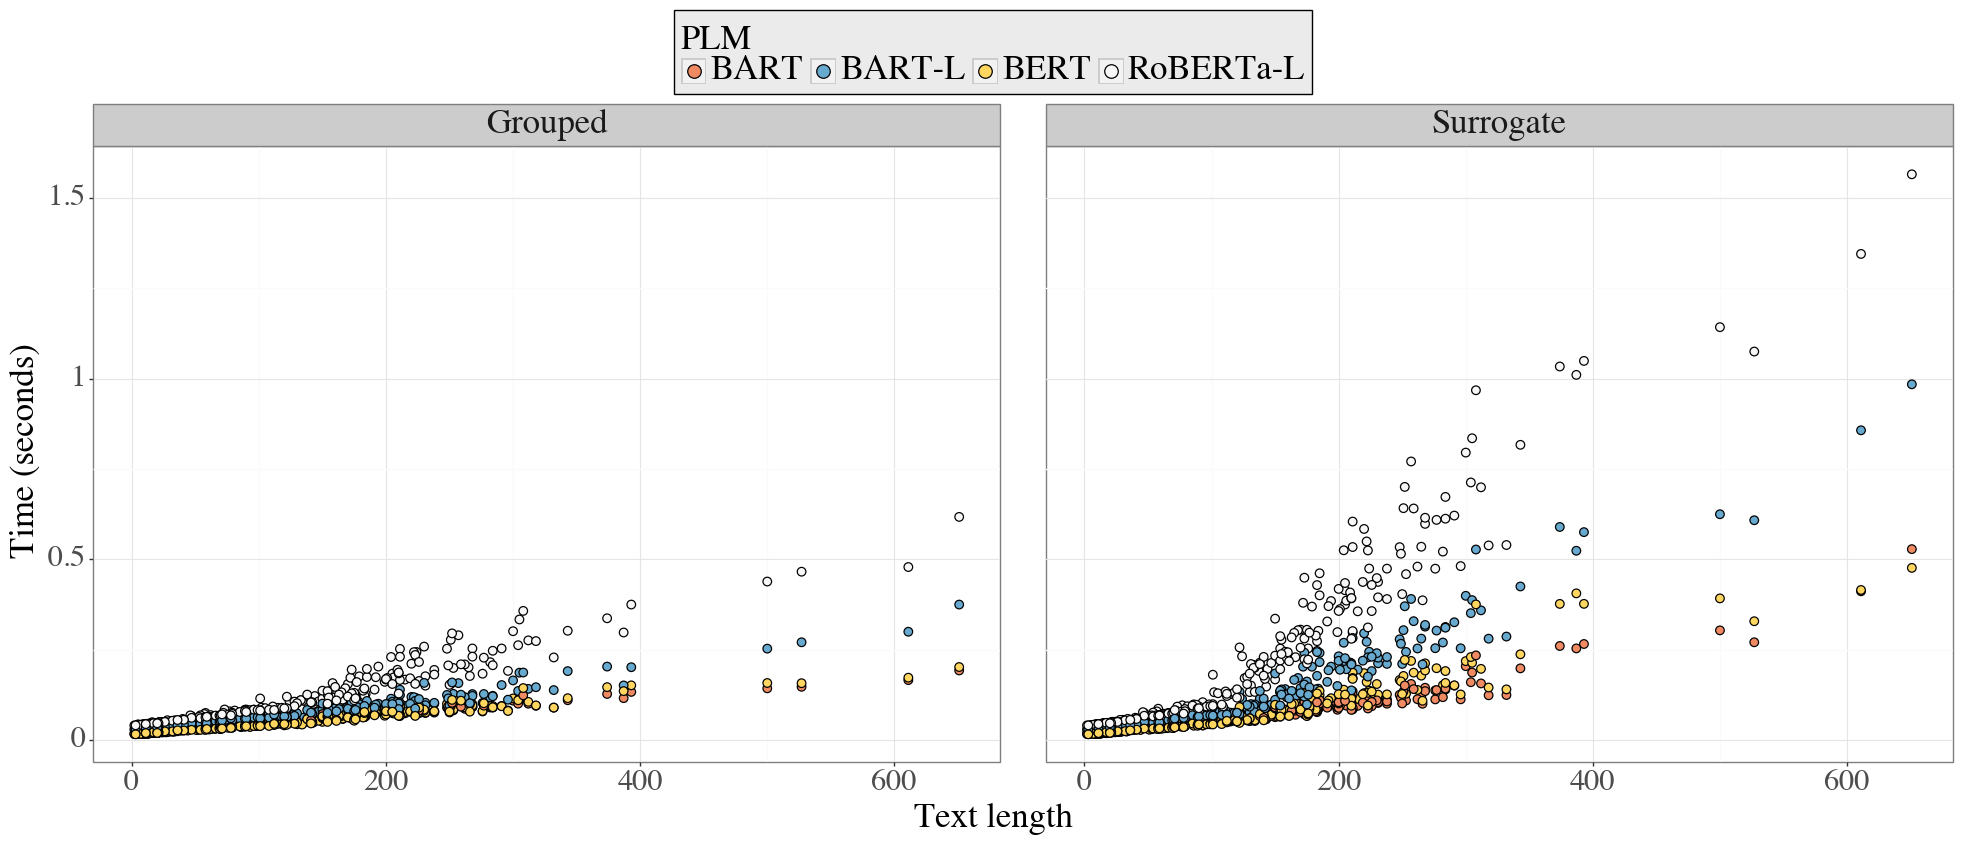

<ggplot: (834928556)>

In [157]:
plot

In [158]:
plot.save(filename = './paper_figures/plm_time_to_construct.png', dpi = 300)

## Node counts

In [159]:
plot = p9.ggplot(categorical_sliding_window_df,
  p9.aes(x = 'approach', y = 'nodes', fill = 'window_size')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Sliding window technique') + \
  p9.ylab('Node count') + \
  p9.labs(fill = 'Window size') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(0, 1000) + \
  p9.theme(
    legend_position = [0.2225, 0.81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

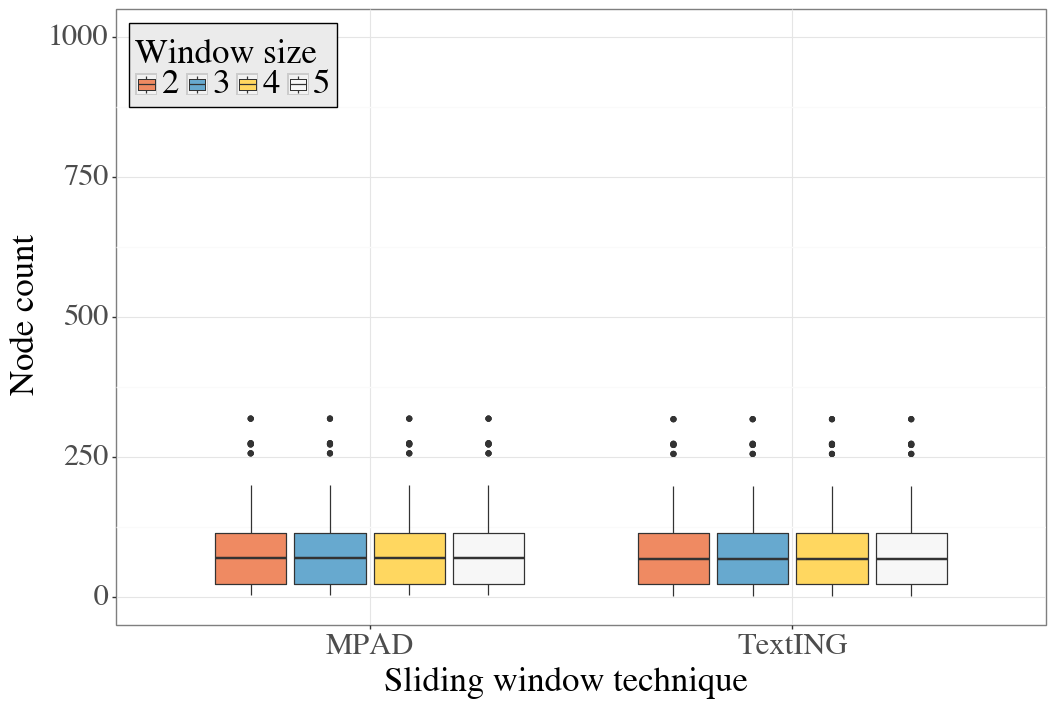

<ggplot: (812010575)>

In [160]:
plot

In [161]:
plot.save(filename = './paper_figures/sliding_windows_node_count.png', dpi = 300)

In [162]:
categorical_sliding_window_df[['approach', 'window_size', 'nodes']].groupby(by = ['approach', 'window_size']).describe()

nodes                                                \
                      count       mean        std  min   25%   50%    75%   
approach window_size                                                        
MPAD     2            852.0  74.880282  53.451119  4.0  24.0  70.0  115.0   
         3            852.0  74.880282  53.451119  4.0  24.0  70.0  115.0   
         4            852.0  74.880282  53.451119  4.0  24.0  70.0  115.0   
         5            852.0  74.880282  53.451119  4.0  24.0  70.0  115.0   
TextING  2            852.0  73.880282  53.451119  3.0  23.0  69.0  114.0   
         3            852.0  73.880282  53.451119  3.0  23.0  69.0  114.0   
         4            852.0  73.880282  53.451119  3.0  23.0  69.0  114.0   
         5            852.0  73.880282  53.451119  3.0  23.0  69.0  114.0   

                             
                        max  
approach window_size         
MPAD     2            319.0  
         3            319.0  
         4            319.0  
         5            319.0  
TextING  2            318.0  
         3            318.0  
         4            318.0  
         5            318.0

In [163]:
plot = p9.ggplot(plm_df[plm_df['PLM'] == 'BART-L'],
  p9.aes(x = 'approach', y = 'nodes', fill = 'factor(threshold)')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Variant') + \
  p9.ylab('Node count') + \
  p9.labs(fill = 'Threshold') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(0, 1000) + \
  p9.theme(
    legend_position = [0.25, 0.81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

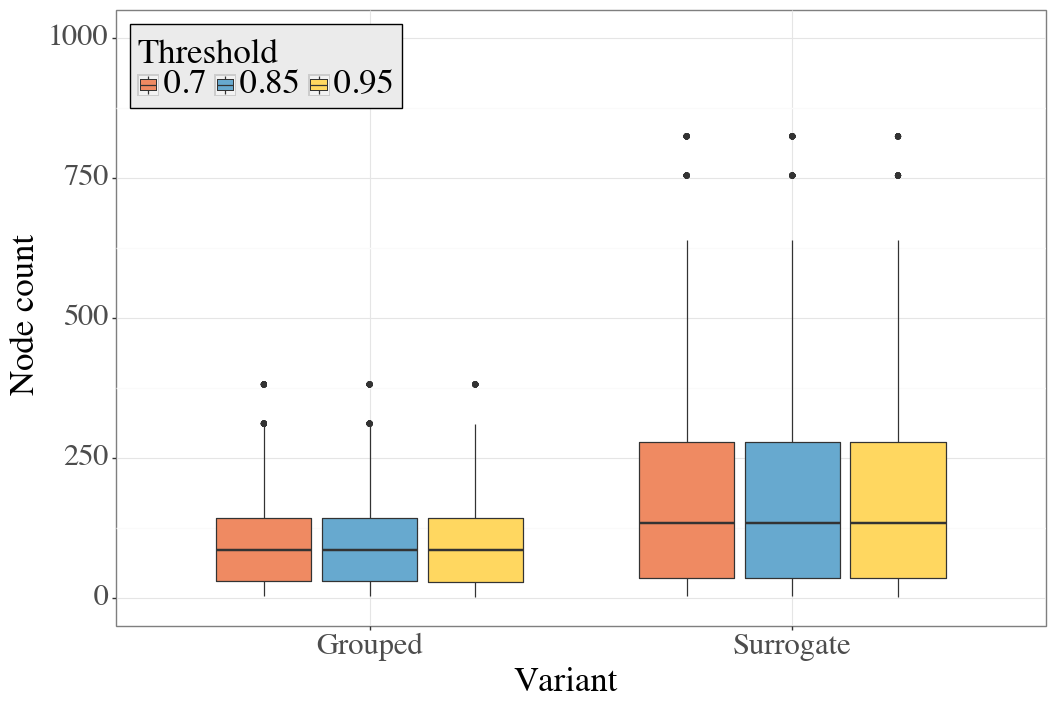

<ggplot: (820363934)>

In [164]:
plot

In [165]:
plot.save(filename = './paper_figures/BART_L_node_count.png', dpi = 300)

In [166]:
plm_df[['approach', 'PLM', 'threshold', 'nodes']].groupby(by = ['approach', 'PLM', 'threshold']).describe()

nodes                                      \
                                count        mean         std  min    25%   
approach  PLM       threshold                                               
Grouped   BART      0.70       3408.0   93.936620   67.410962  4.0  29.75   
                    0.85       3408.0   93.919014   67.433537  3.0  29.75   
                    0.95       3408.0   92.577465   68.633899  2.0  27.50   
          BART-L    0.70       3408.0   93.936620   67.410962  4.0  29.75   
                    0.85       3408.0   93.911972   67.442146  3.0  29.75   
                    0.95       3408.0   92.816901   68.427372  2.0  27.75   
          BERT      0.70       3408.0   90.334507   64.305275  4.0  29.75   
                    0.85       3408.0   90.302817   64.344336  3.0  29.75   
                    0.95       3408.0   88.711268   65.708708  2.0  26.75   
          RoBERTa-L 0.70       3408.0   93.926056   67.424874  3.0  29.75   
                    0.85       3408.0   93.901408   67.455160  3.0  29.75   
                    0.95       3408.0   92.809859   68.573277  2.0  29.00   
Surrogate BART      0.70       3408.0  177.401408  154.320966  4.0  36.00   
                    0.85       3408.0  177.390845  154.332850  3.0  36.00   
                    0.95       3408.0  177.119718  154.614834  2.0  36.00   
          BART-L    0.70       3408.0  177.401408  154.320966  4.0  36.00   
                    0.85       3408.0  177.383803  154.340467  3.0  36.00   
                    0.95       3408.0  177.161972  154.568749  2.0  36.00   
          BERT      0.70       3408.0  177.725352  155.040518  4.0  37.00   
                    0.85       3408.0  177.714789  155.052233  3.0  37.00   
                    0.95       3408.0  177.316901  155.465448  2.0  37.00   
          RoBERTa-L 0.70       3408.0  177.390845  154.332759  3.0  36.00   
                    0.85       3408.0  177.380282  154.344298  3.0  36.00   
                    0.95       3408.0  176.911972  154.827851  2.0  36.00   

                                                     
                                 50%     75%    max  
approach  PLM       threshold                        
Grouped   BART      0.70        85.5  142.00  381.0  
                    0.85        85.5  142.00  381.0  
                    0.95        85.5  142.00  381.0  
          BART-L    0.70        85.5  142.00  381.0  
                    0.85        85.5  142.00  381.0  
                    0.95        85.0  142.00  381.0  
          BERT      0.70        80.5  138.00  357.0  
                    0.85        80.5  138.00  357.0  
                    0.95        80.0  138.00  357.0  
          RoBERTa-L 0.70        85.5  142.00  381.0  
                    0.85        85.5  142.00  381.0  
                    0.95        85.5  142.00  381.0  
Surrogate BART      0.70       133.5  278.75  824.0  
                    0.85       133.5  278.75  824.0  
                    0.95       133.5  278.75  824.0  
          BART-L    0.70       133.5  278.75  824.0  
                    0.85       133.5  278.75  824.0  
                    0.95       133.5  278.75  824.0  
          BERT      0.70       129.5  279.75  766.0  
                    0.85       129.5  279.75  766.0  
                    0.95       129.5  279.75  766.0  
          RoBERTa-L 0.70       133.5  278.75  824.0  
                    0.85       133.5  278.75  824.0  
                    0.95       133.5  278.75  824.0

## Edge counts

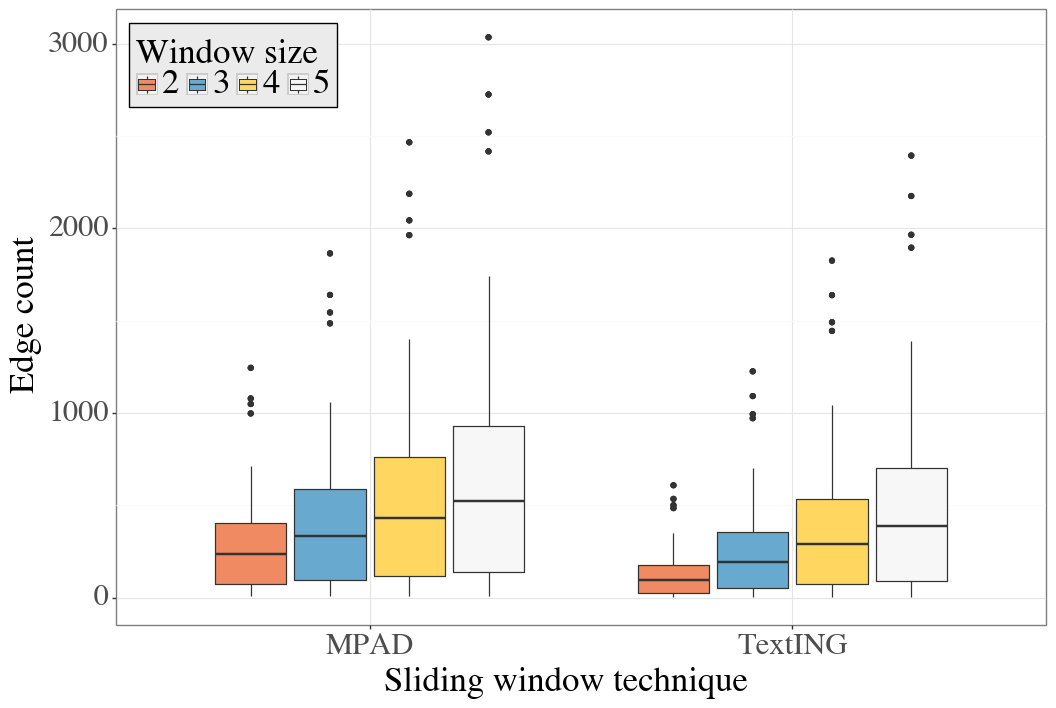

<ggplot: (813442289)>

In [167]:
p9.ggplot(categorical_sliding_window_df,
  p9.aes(x = 'approach', y = 'edges', fill = 'window_size')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Sliding window technique') + \
  p9.ylab('Edge count') + \
  p9.labs(fill = 'Window size') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.theme(
    legend_position = [0.2225, 0.81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

In [168]:
categorical_sliding_window_df[['approach', 'window_size', 'edges']].groupby(by = ['approach', 'window_size']).describe()

edges                                              \
                      count        mean         std  min     25%    50%   
approach window_size                                                      
MPAD     2            852.0  264.623239  206.059442  8.0   72.50  234.0   
         3            852.0  383.841549  308.730872  9.0   97.00  331.5   
         4            852.0  500.038732  410.451861  9.0  119.50  429.0   
         5            852.0  611.901408  508.974912  9.0  138.75  523.5   
TextING  2            852.0  116.806338   99.589587  2.0   26.75   96.0   
         3            852.0  235.225352  202.127104  3.0   50.50  194.5   
         4            852.0  350.376761  303.323219  3.0   72.50  292.0   
         5            852.0  461.352113  401.345578  3.0   90.75  386.5   

                                      
                         75%     max  
approach window_size                  
MPAD     2            406.25  1245.0  
         3            587.25  1865.0  
         4            762.00  2467.0  
         5            932.25  3036.0  
TextING  2            176.00   609.0  
         3            354.50  1226.0  
         4            531.75  1826.0  
         5            703.00  2395.0

In [169]:
categorical_sliding_window_df['edges'] = np.log(categorical_sliding_window_df['edges'].values)

In [170]:
plot = p9.ggplot(categorical_sliding_window_df,
  p9.aes(x = 'approach', y = 'edges', fill = 'window_size')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Sliding window technique') + \
  p9.ylab('Edge count (logarithm)') + \
  p9.labs(fill = 'Window size') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(0, 15) + \
  p9.theme(
    legend_position = [0.2225, 0.81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

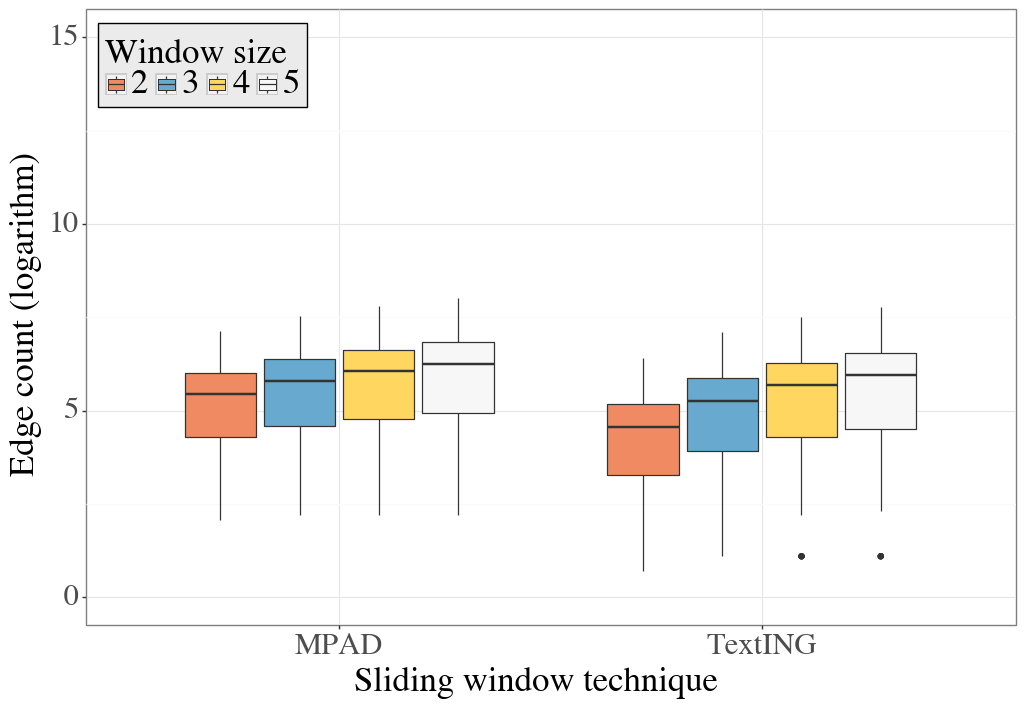

<ggplot: (812470768)>

In [171]:
plot

In [172]:
plot.save(filename = './paper_figures/sliding_windows_edge_count.png', dpi = 300)

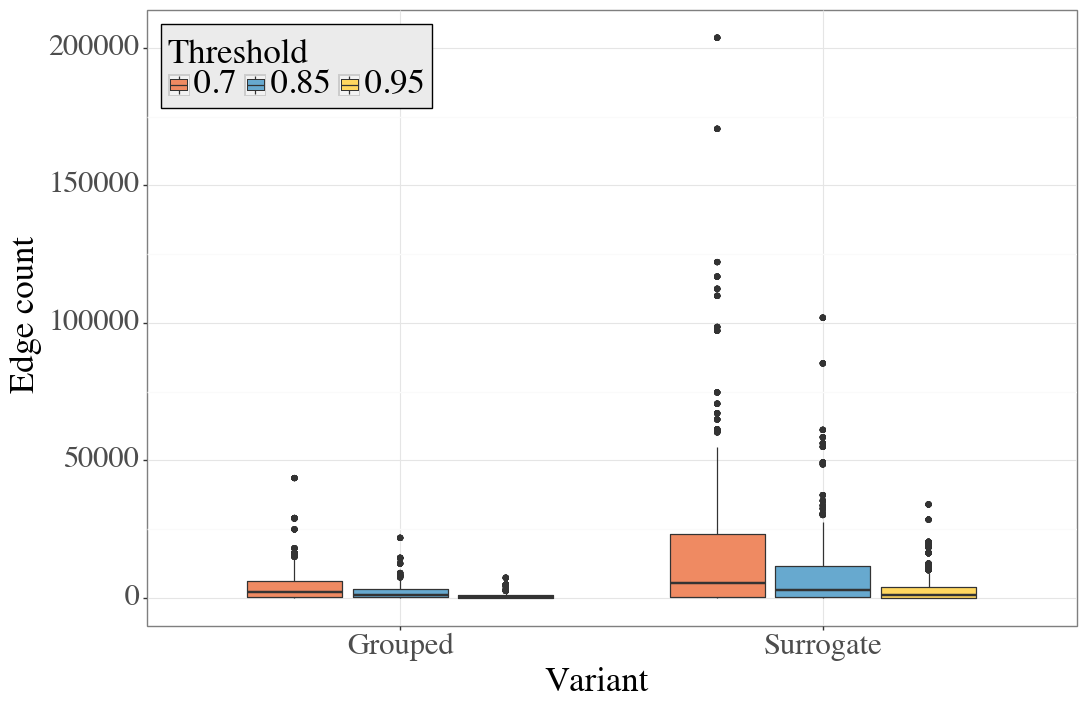

<ggplot: (813463504)>

In [173]:
plm_df['threshold'] = pd.Categorical(plm_df['threshold'], categories = plm_df['threshold'].sort_values(ascending = True).unique().tolist())
p9.ggplot(plm_df[plm_df['PLM'] == 'BART-L'],
  p9.aes(x = 'approach', y = 'edges', fill = 'factor(threshold)')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Variant') + \
  p9.ylab('Edge count') + \
  p9.labs(fill = 'Threshold') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.theme(
    legend_position = [0.25, 0.81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

In [174]:
plm_df[['approach', 'PLM', 'threshold', 'edges']].groupby(by = ['approach', 'PLM', 'threshold']).describe()

edges                                   \
                                count          mean           std  min   
approach  PLM       threshold                                            
Grouped   BART      0.7        3408.0   4010.369718   5206.517953  5.0   
                    0.85       3408.0   2005.588028   2603.259985  3.0   
                    0.95       3408.0    668.947183    867.779479  1.0   
          BART-L    0.7        3408.0   4010.369718   5206.517953  5.0   
                    0.85       3408.0   2005.588028   2603.259985  3.0   
                    0.95       3408.0    668.947183    867.779479  1.0   
          BERT      0.7        3408.0   3624.602993   4410.244984  5.0   
                    0.85       3408.0   1812.676056   2205.137100  3.0   
                    0.95       3408.0    604.613556    735.014225  1.0   
          RoBERTa-L 0.7        3408.0   3929.514085   4810.028359  5.0   
                    0.85       3408.0   1965.158451   2405.014049  3.0   
                    0.95       3408.0    655.464789    801.675732  1.0   
Surrogate BART      0.7        3408.0  16584.014085  26038.786946  5.0   
                    0.85       3408.0   8292.390845  13019.389899  3.0   
                    0.95       3408.0   2764.528169   4339.791091  1.0   
          BART-L    0.7        3408.0  16584.021127  26038.789744  5.0   
                    0.85       3408.0   8292.390845  13019.389899  3.0   
                    0.95       3408.0   2764.528169   4339.791091  1.0   
          BERT      0.7        3408.0  15965.603873  22438.795740  5.0   
                    0.85       3408.0   7983.175176  11219.372056  3.0   
                    0.95       3408.0   2661.441021   3739.786051  1.0   
          RoBERTa-L 0.7        3408.0  15826.446303  22414.778647  5.0   
                    0.85       3408.0   7913.602993  11207.359104  3.0   
                    0.95       3408.0   2638.261444   3735.773640  1.0   

                                                                   
                                  25%     50%       75%       max  
approach  PLM       threshold                                      
Grouped   BART      0.7        265.75  2193.5   6049.00   43549.0  
                    0.85       133.00  1097.0   3025.00   21775.0  
                    0.95        44.50   366.0   1009.00    7259.0  
          BART-L    0.7        265.75  2193.5   6049.00   43549.0  
                    0.85       133.00  1097.0   3025.00   21775.0  
                    0.95        44.50   366.0   1009.00    7259.0  
          BERT      0.7        265.75  1944.5   5713.00   32747.0  
                    0.85       133.00   972.5   2857.00   16374.0  
                    0.95        44.50   324.5    953.00    5458.0  
          RoBERTa-L 0.7        265.75  2193.5   6049.00   36123.0  
                    0.85       133.00  1097.0   3025.00   18062.0  
                    0.95        44.50   366.0   1009.00    6021.0  
Surrogate BART      0.7        389.00  5350.5  23313.50  203693.0  
                    0.85       195.00  2675.5  11657.25  101847.0  
                    0.95        65.00   892.0   3886.00   33949.0  
          BART-L    0.7        389.00  5350.5  23313.50  203693.0  
                    0.85       195.00  2675.5  11657.25  101847.0  
                    0.95        65.00   892.0   3886.00   33949.0  
          BERT      0.7        411.00  5031.5  23479.00  136711.0  
                    0.85       206.00  2516.0  11740.00   68356.0  
                    0.95        69.00   839.0   3914.00   22786.0  
          RoBERTa-L 0.7        389.00  5350.5  23313.50  146768.0  
                    0.85       195.00  2675.5  11657.25   73384.0  
                    0.95        65.00   892.0   3886.00   24462.0

In [175]:
plm_df['edges'] = np.log(plm_df['edges'].values)

In [176]:
plot = p9.ggplot(plm_df[plm_df['PLM'] == 'BART-L'],
  p9.aes(x = 'approach', y = 'edges', fill = 'factor(threshold)')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Variant') + \
  p9.ylab('Edge count (logarithm)') + \
  p9.labs(fill = 'Threshold') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(0, 15) + \
  p9.theme(
    legend_position = [0.25, 0.81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

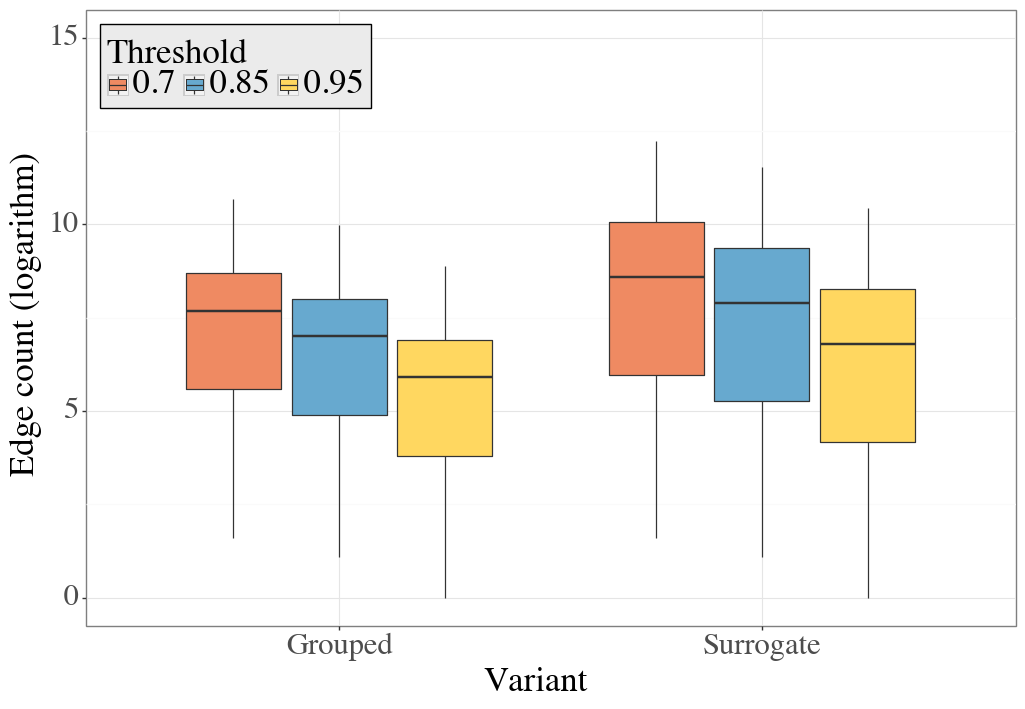

<ggplot: (825829295)>

In [177]:
plot

In [178]:
plot.save(filename = './paper_figures/BART_L_edge_count.png', dpi = 300)

## Graph densities

In [179]:
plot = p9.ggplot(categorical_sliding_window_df,
  p9.aes(x = 'approach', y = 'density', fill = 'window_size')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Sliding window technique') + \
  p9.ylab('Graph density') + \
  p9.labs(fill = 'Window size') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(0, 0.6) + \
  p9.theme(
    legend_position = [0.8025, 0.81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

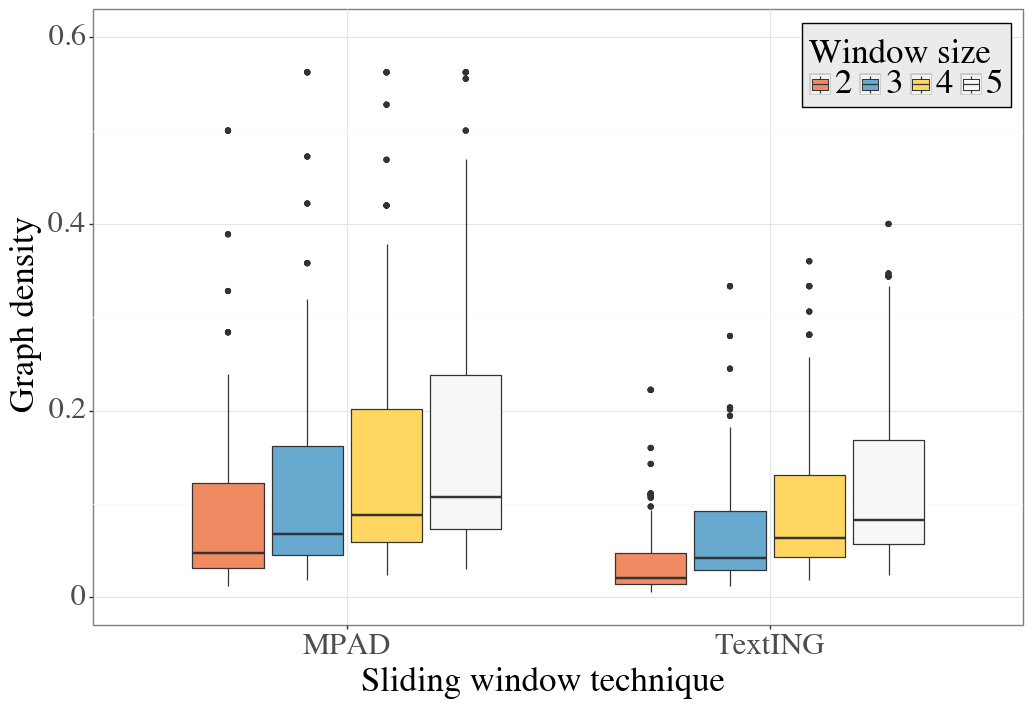

<ggplot: (813835289)>

In [180]:
plot

In [181]:
plot.save(filename = './paper_figures/sliding_windows_density.png', dpi = 300)

In [182]:
categorical_sliding_window_df[['approach', 'window_size', 'density']].groupby(by = ['approach', 'window_size']).describe()

density                                          \
                       count      mean       std       min       25%   
approach window_size                                                   
MPAD     2             852.0  0.083861  0.076150  0.012235  0.031330   
         3             852.0  0.113137  0.094016  0.018327  0.045385   
         4             852.0  0.139276  0.106610  0.024243  0.059177   
         5             852.0  0.163313  0.117131  0.029835  0.073547   
TextING  2             852.0  0.034586  0.031005  0.006022  0.014214   
         3             852.0  0.066269  0.053431  0.012124  0.028759   
         4             852.0  0.094238  0.068634  0.018057  0.043051   
         5             852.0  0.120062  0.081948  0.023684  0.056984   

                                                    
                           50%       75%       max  
approach window_size                                
MPAD     2            0.047842  0.121962  0.500000  
         3            0.068129  0.162209  0.562500  
         4            0.088088  0.201281  0.562500  
         5            0.107056  0.238535  0.562500  
TextING  2            0.020745  0.047319  0.222222  
         3            0.041758  0.092532  0.333333  
         4            0.063096  0.130823  0.360000  
         5            0.083025  0.168537  0.400000

In [183]:
plm_df['threshold'] = pd.Categorical(plm_df['threshold'], categories = plm_df['threshold'].sort_values(ascending = True).unique().tolist())
plot = p9.ggplot(plm_df[plm_df['PLM'] == 'BART-L'],
  p9.aes(x = 'approach', y = 'density', fill = 'factor(threshold)')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Variant') + \
  p9.ylab('Graph density') + \
  p9.labs(fill = 'Threshold') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.ylim(0, 0.6) + \
  p9.theme(
    legend_position = [0.775, 0.81],
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (12, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

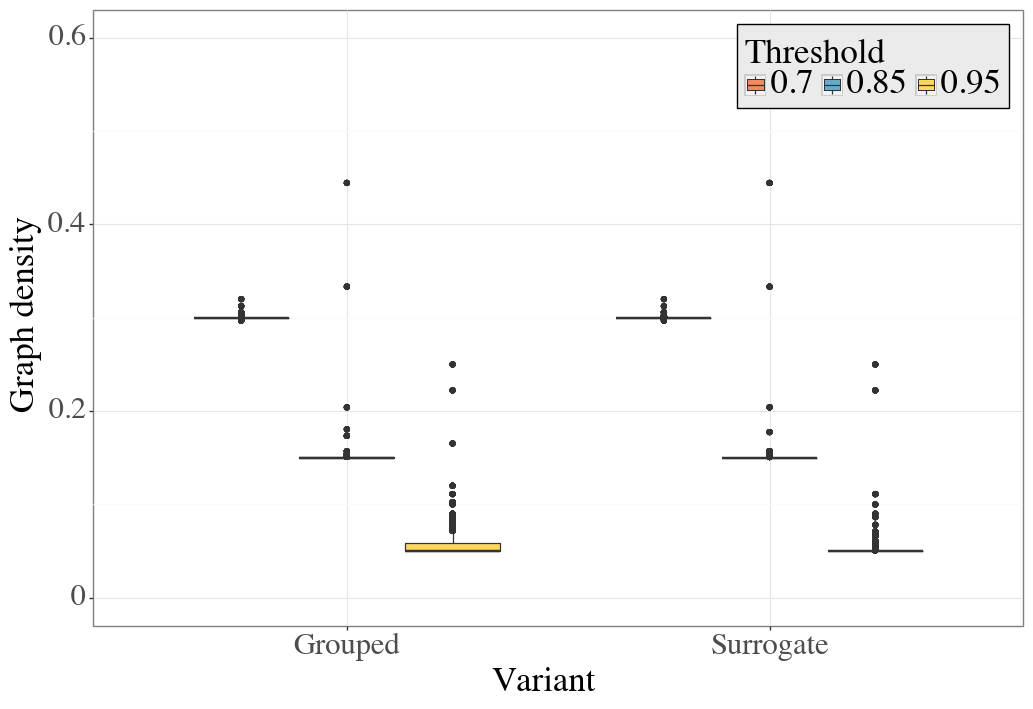

<ggplot: (813889092)>

In [184]:
plot

In [185]:
plot.save(filename = './paper_figures/BART_L_density.png', dpi = 300)

In [186]:
plm_df[['approach', 'PLM', 'threshold', 'density']].groupby(by = ['approach', 'PLM', 'threshold']).describe()

density                                          \
                                count      mean       std       min       25%   
approach  PLM       threshold                                                   
Grouped   BART      0.7        3408.0  0.300334  0.001548  0.296875  0.300000   
                    0.85       3408.0  0.152315  0.020625  0.150000  0.150021   
                    0.95       3408.0  0.059826  0.022240  0.050000  0.050029   
          BART-L    0.7        3408.0  0.300334  0.001548  0.296875  0.300000   
                    0.85       3408.0  0.152555  0.020872  0.150000  0.150021   
                    0.95       3408.0  0.058027  0.020367  0.050000  0.050027   
          BERT      0.7        3408.0  0.299456  0.005665  0.236840  0.300000   
                    0.85       3408.0  0.151696  0.014015  0.118424  0.150019   
                    0.95       3408.0  0.061950  0.027401  0.039475  0.050028   
          RoBERTa-L 0.7        3408.0  0.301238  0.020809  0.235566  0.300000   
                    0.85       3408.0  0.152488  0.021979  0.117786  0.150021   
                    0.95       3408.0  0.060213  0.024465  0.039267  0.050027   
Surrogate BART      0.7        3408.0  0.300285  0.001564  0.296875  0.300000   
                    0.85       3408.0  0.152076  0.020509  0.150000  0.150004   
                    0.95       3408.0  0.054198  0.018280  0.050000  0.050006   
          BART-L    0.7        3408.0  0.300285  0.001564  0.296875  0.300000   
                    0.85       3408.0  0.152331  0.020792  0.150000  0.150004   
                    0.95       3408.0  0.053625  0.017205  0.050000  0.050006   
          BERT      0.7        3408.0  0.298626  0.010216  0.200264  0.300000   
                    0.85       3408.0  0.150663  0.013582  0.100132  0.150005   
                    0.95       3408.0  0.055603  0.021880  0.033378  0.050004   
          RoBERTa-L 0.7        3408.0  0.300472  0.022438  0.194282  0.300000   
                    0.85       3408.0  0.151644  0.021579  0.097142  0.150005   
                    0.95       3408.0  0.056092  0.021708  0.032381  0.050006   

                                                             
                                    50%       75%       max  
approach  PLM       threshold                                
Grouped   BART      0.7        0.300026  0.300173  0.320000  
                    0.85       0.150059  0.150400  0.444444  
                    0.95       0.050171  0.059917  0.250000  
          BART-L    0.7        0.300026  0.300173  0.320000  
                    0.85       0.150059  0.150400  0.444444  
                    0.95       0.050115  0.058594  0.250000  
          BERT      0.7        0.300021  0.300191  0.320000  
                    0.85       0.150054  0.150400  0.333333  
                    0.95       0.050150  0.059794  0.250000  
          RoBERTa-L 0.7        0.300027  0.300173  0.555556  
                    0.85       0.150060  0.150400  0.444444  
                    0.95       0.050073  0.057691  0.250000  
Surrogate BART      0.7        0.300007  0.300065  0.320000  
                    0.85       0.150021  0.150212  0.444444  
                    0.95       0.050024  0.050296  0.250000  
          BART-L    0.7        0.300007  0.300065  0.320000  
                    0.85       0.150021  0.150212  0.444444  
                    0.95       0.050023  0.050296  0.250000  
          BERT      0.7        0.300004  0.300068  0.320000  
                    0.85       0.150019  0.150204  0.333333  
                    0.95       0.050022  0.050296  0.250000  
          RoBERTa-L 0.7        0.300007  0.300069  0.555556  
                    0.85       0.150022  0.150247  0.444444  
                    0.95       0.050026  0.050347  0.250000

# Training time and convergence

In [187]:
TRIALS = 250
TOP_N = 5

In [188]:
def load_best_trial_metrics_fine_tuning(dataset, plm, display_information = False):
  
  study_name = f'{dataset}-{plm.replace("/", "-")}'
  storage = f'sqlite:///../../baselines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  for _, row in study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N).iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    random_states = [x for x in os.listdir(f'../../outputs/{dataset}-{plm}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{plm}/{trial}/{x}')]
    
    if len(random_states) < 10:
      continue
    else:
      checkpoints = pd.read_csv(f'../../outputs/{dataset}-{plm}/{trial}/metrics.csv')[['checkpoint_epoch', 'random_state']]
      epoch_information_df = list()
      for random_state in random_states:
        random_state_checkpoint = checkpoints[checkpoints['random_state'] == int(random_state)]['checkpoint_epoch'].values[0]
        df = pd.read_csv(f'../../outputs/{dataset}-{plm}/{trial}/{random_state}/runtimes.csv').assign(random_state = random_state)[:random_state_checkpoint]
        epoch_information_df.append(df)
      break
  return pd.concat(epoch_information_df).assign(dataset = dataset, gnn = 'N/A', plm = plm, method = 'Fine-tuning', aggregation = 'N/A')

In [189]:
def load_best_trial_metrics(dataset, gnn, plm, method, aggregation, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{plm.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  for _, row in study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N).iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    random_states = [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{plm}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{plm}/{method}/{aggregation}/{trial}/{x}')]
    
    if len(random_states) < 10:
      continue
    else:
      checkpoints = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{plm}/{method}/{aggregation}/{trial}/metrics.csv')[['checkpoint_epoch', 'random_state']]
      epoch_information_df = list()
      for random_state in random_states:
        random_state_checkpoint = checkpoints[checkpoints['random_state'] == int(random_state)]['checkpoint_epoch'].values[0]
        df = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{plm}/{method}/{aggregation}/{trial}/{random_state}/runtimes.csv').assign(random_state = random_state)[:random_state_checkpoint]
        epoch_information_df.append(df)
      break
  return pd.concat(epoch_information_df).assign(dataset = dataset, gnn = gnn, PLM = plm, method = method, aggregation = aggregation)

In [190]:
def get_epoch_runtimes(datasets, gnns, methods, aggregations, plms):
  epoch_information = list()
  for dataset in datasets:
    for gnn in gnns:
      for method in methods:
        for aggregation in aggregations:
          for plm in plms:
            df = load_best_trial_metrics(dataset = dataset, gnn = gnn, plm = plm, method = method, aggregation = aggregation, display_information = False)
            epoch_information.append(df)
  return pd.concat(epoch_information)

In [191]:
def get_epoch_runtimes_fine_tuning(datasets, plms):
  epoch_information = list()
  for dataset in datasets:
    for plm in plms:
      df = load_best_trial_metrics_fine_tuning(dataset = dataset, plm = plm, display_information = False)
      epoch_information.append(df)
  return pd.concat(epoch_information)

## Comparing both method variants

In [192]:
epoch_information_df = get_epoch_runtimes(
  datasets = ['IMDb-top_1000', 'Ohsumed', 'R8', 'SST-2'],
  gnns = ['GATv2'],
  methods = ['Grouped', 'Surrogate'],
  aggregations = ['No_Aggregation'],
  plms = ['facebook-bart-large', 'FacebookAI-roberta-large']
)

In [193]:
epoch_information_df['PLM'] = epoch_information_df['PLM'].replace({'facebook-bart-large' : 'BART-L', 'FacebookAI-roberta-large' : 'RoBERTa-L'})
epoch_information_df['dataset'] = epoch_information_df['dataset'].replace({'IMDb-top_1000' : 'IMDb-1k'})

In [194]:
epoch_information_df_grouped = epoch_information_df.groupby(by = ['dataset', 'gnn', 'method', 'PLM', 'aggregation']).agg(average_epoch_runtime = ('epoch_runtime', 'mean'), std_epoch_runtime = ('epoch_runtime', 'std')).reset_index()
epoch_information_df_grouped['label'] = epoch_information_df_grouped['average_epoch_runtime'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + epoch_information_df_grouped['std_epoch_runtime'].map(lambda x : '{:.2f}'.format(x))

In [195]:
epoch_information_df_grouped

dataset    gnn     method        PLM     aggregation  \
0   IMDb-1k  GATv2    Grouped     BART-L  No_Aggregation   
1   IMDb-1k  GATv2    Grouped  RoBERTa-L  No_Aggregation   
2   IMDb-1k  GATv2  Surrogate     BART-L  No_Aggregation   
3   IMDb-1k  GATv2  Surrogate  RoBERTa-L  No_Aggregation   
4   Ohsumed  GATv2    Grouped     BART-L  No_Aggregation   
5   Ohsumed  GATv2    Grouped  RoBERTa-L  No_Aggregation   
6   Ohsumed  GATv2  Surrogate     BART-L  No_Aggregation   
7   Ohsumed  GATv2  Surrogate  RoBERTa-L  No_Aggregation   
8        R8  GATv2    Grouped     BART-L  No_Aggregation   
9        R8  GATv2    Grouped  RoBERTa-L  No_Aggregation   
10       R8  GATv2  Surrogate     BART-L  No_Aggregation   
11       R8  GATv2  Surrogate  RoBERTa-L  No_Aggregation   
12    SST-2  GATv2    Grouped     BART-L  No_Aggregation   
13    SST-2  GATv2    Grouped  RoBERTa-L  No_Aggregation   
14    SST-2  GATv2  Surrogate     BART-L  No_Aggregation   
15    SST-2  GATv2  Surrogate  RoBERTa-L  No_Aggregation   

    average_epoch_runtime  std_epoch_runtime         label  
0                3.762705           0.267574   3.76 ± 0.27  
1                1.172252           0.007021   1.17 ± 0.01  
2                1.530251           0.009304   1.53 ± 0.01  
3                6.162111           0.032752   6.16 ± 0.03  
4               10.618458           0.242352  10.62 ± 0.24  
5                9.692236           0.042839   9.69 ± 0.04  
6                4.167239           0.188473   4.17 ± 0.19  
7                2.696429           0.028945   2.70 ± 0.03  
8               17.720880           0.355301  17.72 ± 0.36  
9                2.636621           0.028813   2.64 ± 0.03  
10               6.286971           0.176096   6.29 ± 0.18  
11               9.759416           0.073900   9.76 ± 0.07  
12               1.272704           0.017833   1.27 ± 0.02  
13               1.907876           0.057491   1.91 ± 0.06  
14               1.883739           0.027034   1.88 ± 0.03  
15               6.622724           0.041828   6.62 ± 0.04

In [196]:
epoch_information_df_count = epoch_information_df.groupby(by = ['dataset', 'gnn', 'method', 'PLM', 'aggregation', 'random_state']).size().reset_index().rename(columns = {0 : 'count'})

In [197]:
epoch_information_df_count_grouped = epoch_information_df_count.groupby(by = ['dataset', 'gnn', 'method', 'PLM', 'aggregation']).agg(average_epoch_count = ('count', 'mean'), std_epoch_count = ('count', 'std')).reset_index()
epoch_information_df_count_grouped['label'] = epoch_information_df_count_grouped['average_epoch_count'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + epoch_information_df_count_grouped['std_epoch_count'].map(lambda x : '{:.2f}'.format(x))

In [198]:
epoch_information_df_count_grouped

dataset    gnn     method        PLM     aggregation  average_epoch_count  \
0   IMDb-1k  GATv2    Grouped     BART-L  No_Aggregation                 13.9   
1   IMDb-1k  GATv2    Grouped  RoBERTa-L  No_Aggregation                 20.5   
2   IMDb-1k  GATv2  Surrogate     BART-L  No_Aggregation                 50.7   
3   IMDb-1k  GATv2  Surrogate  RoBERTa-L  No_Aggregation                 24.1   
4   Ohsumed  GATv2    Grouped     BART-L  No_Aggregation                 28.3   
5   Ohsumed  GATv2    Grouped  RoBERTa-L  No_Aggregation                 20.8   
6   Ohsumed  GATv2  Surrogate     BART-L  No_Aggregation                 24.2   
7   Ohsumed  GATv2  Surrogate  RoBERTa-L  No_Aggregation                 22.0   
8        R8  GATv2    Grouped     BART-L  No_Aggregation                103.6   
9        R8  GATv2    Grouped  RoBERTa-L  No_Aggregation                 17.9   
10       R8  GATv2  Surrogate     BART-L  No_Aggregation                 26.9   
11       R8  GATv2  Surrogate  RoBERTa-L  No_Aggregation                 37.2   
12    SST-2  GATv2    Grouped     BART-L  No_Aggregation                 12.8   
13    SST-2  GATv2    Grouped  RoBERTa-L  No_Aggregation                 15.0   
14    SST-2  GATv2  Surrogate     BART-L  No_Aggregation                 15.2   
15    SST-2  GATv2  Surrogate  RoBERTa-L  No_Aggregation                 35.9   

    std_epoch_count           label  
0          5.021067    13.90 ± 5.02  
1          7.214954    20.50 ± 7.21  
2          6.254776    50.70 ± 6.25  
3          5.820462    24.10 ± 5.82  
4          3.591657    28.30 ± 3.59  
5          4.289522    20.80 ± 4.29  
6          6.596295    24.20 ± 6.60  
7          5.792716    22.00 ± 5.79  
8         16.249444  103.60 ± 16.25  
9          6.008328    17.90 ± 6.01  
10         9.643075    26.90 ± 9.64  
11         9.577752    37.20 ± 9.58  
12         6.303438    12.80 ± 6.30  
13         3.366502    15.00 ± 3.37  
14         7.375636    15.20 ± 7.38  
15        10.278889   35.90 ± 10.28

In [199]:
total_training_time_information_df_grouped = epoch_information_df.groupby(by = ['dataset', 'gnn', 'method', 'PLM', 'aggregation', 'random_state']).sum().reset_index() \
  .groupby(by = ['dataset', 'gnn', 'method', 'PLM', 'aggregation']) \
  .agg(average_training_time = ('epoch_runtime', 'mean'), std_training_time = ('epoch_runtime', 'std')).reset_index()
total_training_time_information_df_grouped['label'] = total_training_time_information_df_grouped['average_training_time'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + total_training_time_information_df_grouped['std_training_time'].map(lambda x : '{:.2f}'.format(x))

In [200]:
total_training_time_information_df_grouped

dataset    gnn     method        PLM     aggregation  \
0   IMDb-1k  GATv2    Grouped     BART-L  No_Aggregation   
1   IMDb-1k  GATv2    Grouped  RoBERTa-L  No_Aggregation   
2   IMDb-1k  GATv2  Surrogate     BART-L  No_Aggregation   
3   IMDb-1k  GATv2  Surrogate  RoBERTa-L  No_Aggregation   
4   Ohsumed  GATv2    Grouped     BART-L  No_Aggregation   
5   Ohsumed  GATv2    Grouped  RoBERTa-L  No_Aggregation   
6   Ohsumed  GATv2  Surrogate     BART-L  No_Aggregation   
7   Ohsumed  GATv2  Surrogate  RoBERTa-L  No_Aggregation   
8        R8  GATv2    Grouped     BART-L  No_Aggregation   
9        R8  GATv2    Grouped  RoBERTa-L  No_Aggregation   
10       R8  GATv2  Surrogate     BART-L  No_Aggregation   
11       R8  GATv2  Surrogate  RoBERTa-L  No_Aggregation   
12    SST-2  GATv2    Grouped     BART-L  No_Aggregation   
13    SST-2  GATv2    Grouped  RoBERTa-L  No_Aggregation   
14    SST-2  GATv2  Surrogate     BART-L  No_Aggregation   
15    SST-2  GATv2  Surrogate  RoBERTa-L  No_Aggregation   

    average_training_time  std_training_time             label  
0               52.301599          18.155643     52.30 ± 18.16  
1               24.031163           8.484137      24.03 ± 8.48  
2               77.583727           9.595587      77.58 ± 9.60  
3              148.506878          35.841605    148.51 ± 35.84  
4              300.502370          38.196774    300.50 ± 38.20  
5              201.598501          41.633923    201.60 ± 41.63  
6              100.847182          27.340959    100.85 ± 27.34  
7               59.321442          15.504528     59.32 ± 15.50  
8             1835.883195         290.630205  1835.88 ± 290.63  
9               47.195510          15.916735     47.20 ± 15.92  
10             169.119526          60.376493    169.12 ± 60.38  
11             363.050261          92.884097    363.05 ± 92.88  
12              16.290605           7.935651      16.29 ± 7.94  
13              28.618144           6.461867      28.62 ± 6.46  
14              28.632829          13.832113     28.63 ± 13.83  
15             237.755804          68.047629    237.76 ± 68.05

## Compared to fine-tuning

In [201]:
bert_epoch_information_df = pd.concat([
  get_epoch_runtimes(
    datasets = ['IMDb-top_1000', 'Ohsumed', 'R8', 'SST-2'],
    gnns = ['GATv2'],
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation'],
    plms = ['google-bert-bert-base-uncased']
  ),
  get_epoch_runtimes_fine_tuning(
    datasets = ['IMDb-top_1000', 'Ohsumed', 'R8', 'SST-2'],
    plms = ['google-bert-bert-base-uncased']
  )
])


In [202]:
bert_epoch_information_df['PLM'] = bert_epoch_information_df['PLM'].replace({'google-bert-bert-base-uncased' : 'BERT'})
bert_epoch_information_df['dataset'] = bert_epoch_information_df['dataset'].replace({'IMDb-top_1000' : 'IMDb-1k'})

In [203]:
bert_epoch_information_df_grouped = bert_epoch_information_df.groupby(by = ['dataset', 'gnn', 'method', 'PLM', 'aggregation']).agg(average_epoch_runtime = ('epoch_runtime', 'mean'), std_epoch_runtime = ('epoch_runtime', 'std')).reset_index()
bert_epoch_information_df_grouped['label'] = bert_epoch_information_df_grouped['average_epoch_runtime'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + bert_epoch_information_df_grouped['std_epoch_runtime'].map(lambda x : '{:.2f}'.format(x))

In [204]:
bert_epoch_information_df_grouped

dataset    gnn     method   PLM     aggregation  average_epoch_runtime  \
0  IMDb-1k  GATv2    Grouped  BERT  No_Aggregation               6.160131   
1  IMDb-1k  GATv2  Surrogate  BERT  No_Aggregation               5.782198   
2  Ohsumed  GATv2    Grouped  BERT  No_Aggregation              29.199022   
3  Ohsumed  GATv2  Surrogate  BERT  No_Aggregation              11.718741   
4       R8  GATv2    Grouped  BERT  No_Aggregation               8.859599   
5       R8  GATv2  Surrogate  BERT  No_Aggregation               6.982861   
6    SST-2  GATv2    Grouped  BERT  No_Aggregation               3.967955   
7    SST-2  GATv2  Surrogate  BERT  No_Aggregation              13.524325   

   std_epoch_runtime         label  
0           0.390050   6.16 ± 0.39  
1           0.052646   5.78 ± 0.05  
2           0.385823  29.20 ± 0.39  
3           0.120229  11.72 ± 0.12  
4           0.106560   8.86 ± 0.11  
5           0.092372   6.98 ± 0.09  
6           0.022023   3.97 ± 0.02  
7           0.051896  13.52 ± 0.05

In [205]:
bert_epoch_information_df_count = bert_epoch_information_df.groupby(by = ['dataset', 'gnn', 'method', 'PLM', 'aggregation', 'random_state']).size().reset_index().rename(columns = {0 : 'count'})

In [206]:
bert_epoch_information_df_count_grouped = bert_epoch_information_df_count.groupby(by = ['dataset', 'gnn', 'method', 'PLM', 'aggregation']).agg(average_epoch_count = ('count', 'mean'), std_epoch_count = ('count', 'std')).reset_index()
bert_epoch_information_df_count_grouped['label'] = bert_epoch_information_df_count_grouped['average_epoch_count'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + bert_epoch_information_df_count_grouped['std_epoch_count'].map(lambda x : '{:.2f}'.format(x))

In [207]:
bert_epoch_information_df_count_grouped

dataset    gnn     method   PLM     aggregation  average_epoch_count  \
0  IMDb-1k  GATv2    Grouped  BERT  No_Aggregation                 15.7   
1  IMDb-1k  GATv2  Surrogate  BERT  No_Aggregation                 30.2   
2  Ohsumed  GATv2    Grouped  BERT  No_Aggregation                 25.6   
3  Ohsumed  GATv2  Surrogate  BERT  No_Aggregation                 24.0   
4       R8  GATv2    Grouped  BERT  No_Aggregation                 22.9   
5       R8  GATv2  Surrogate  BERT  No_Aggregation                 43.8   
6    SST-2  GATv2    Grouped  BERT  No_Aggregation                 10.7   
7    SST-2  GATv2  Surrogate  BERT  No_Aggregation                  8.1   

   std_epoch_count          label  
0         7.056124   15.70 ± 7.06  
1        12.416834  30.20 ± 12.42  
2         2.951459   25.60 ± 2.95  
3         3.496029   24.00 ± 3.50  
4         8.047774   22.90 ± 8.05  
5         8.011103   43.80 ± 8.01  
6         7.761014   10.70 ± 7.76  
7         4.748099    8.10 ± 4.75

In [208]:
bert_total_training_time_information_df_grouped = bert_epoch_information_df.groupby(by = ['dataset', 'gnn', 'method', 'PLM', 'aggregation', 'random_state']).sum().reset_index() \
  .groupby(by = ['dataset', 'gnn', 'method', 'PLM', 'aggregation']) \
  .agg(average_training_time = ('epoch_runtime', 'mean'), std_training_time = ('epoch_runtime', 'std')).reset_index()
bert_total_training_time_information_df_grouped['label'] = bert_total_training_time_information_df_grouped['average_training_time'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + bert_total_training_time_information_df_grouped['std_training_time'].map(lambda x : '{:.2f}'.format(x))

In [209]:
bert_total_training_time_information_df_grouped

dataset    gnn     method   PLM     aggregation  average_training_time  \
0  IMDb-1k  GATv2    Grouped  BERT  No_Aggregation              96.714061   
1  IMDb-1k  GATv2  Surrogate  BERT  No_Aggregation             174.622368   
2  Ohsumed  GATv2    Grouped  BERT  No_Aggregation             747.494965   
3  Ohsumed  GATv2  Surrogate  BERT  No_Aggregation             281.249779   
4       R8  GATv2    Grouped  BERT  No_Aggregation             202.884808   
5       R8  GATv2  Surrogate  BERT  No_Aggregation             305.849297   
6    SST-2  GATv2    Grouped  BERT  No_Aggregation              42.457124   
7    SST-2  GATv2  Surrogate  BERT  No_Aggregation             109.547032   

   std_training_time           label  
0          42.838795   96.71 ± 42.84  
1          71.649018  174.62 ± 71.65  
2          85.758462  747.49 ± 85.76  
3          40.825967  281.25 ± 40.83  
4          71.256734  202.88 ± 71.26  
5          56.135849  305.85 ± 56.14  
6          30.655153   42.46 ± 30.66  
7          64.138894  109.55 ± 64.14

## Values per Document (Graph) Analysis

In [210]:
def get_values_per_graph(datasets, folders):
  values_per_graph = list()
  for folder in folders:
    approach = folder.split('-')[-1].replace('_', ' ').title()
    for dataset in datasets:
      df = pd.read_csv(f'../../memory/values_per_graph/data/{folder}/{dataset}.csv').assign(dataset = dataset, approach = approach)
      values_per_graph.append(df)
  return pd.concat(values_per_graph)

### BERT

In [211]:
BERT_values_per_graph_df = get_values_per_graph(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  folders = ['google-bert-bert-base-uncased-Surrogate', 'google-bert-bert-base-uncased-Grouped', 'fine_tuning']
)

In [212]:
BERT_values_per_graph_df['dataset'] = BERT_values_per_graph_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})
BERT_values_per_graph_df['approach'] = BERT_values_per_graph_df['approach'].replace({
  'Fine Tuning' : 'Fine-tuning'
})

In [213]:
BERT_values_per_graph_df['split'] = BERT_values_per_graph_df['split'].replace({'test' : 'Testing', 'validation' : 'Validation', 'train' : 'Training'}).str.capitalize()
BERT_values_per_graph_df['split'] = pd.Categorical(BERT_values_per_graph_df['split'], categories = ['Training', 'Validation', 'Testing'])
BERT_values_per_graph_df['approach'] = pd.Categorical(BERT_values_per_graph_df['approach'], categories = ['Fine-tuning', 'Grouped', 'Surrogate'])

In [214]:
plot = p9.ggplot(BERT_values_per_graph_df,
  p9.aes(x = 'total_values_for_graph', fill = 'approach')) + \
  p9.theme_bw() + \
  p9.geom_histogram() + \
  p9.xlab('Required Values to Represent a Document') + \
  p9.ylab('Document Count') + \
  p9.labs(fill = 'Approach') + \
  p9.facet_wrap('~ dataset', ncol = 2, scales = 'free') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.theme(
    legend_position = 'top',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 16),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
    subplots_adjust = {
      'wspace' : 0.075,
      'hspace' : 0.15
    }
  )

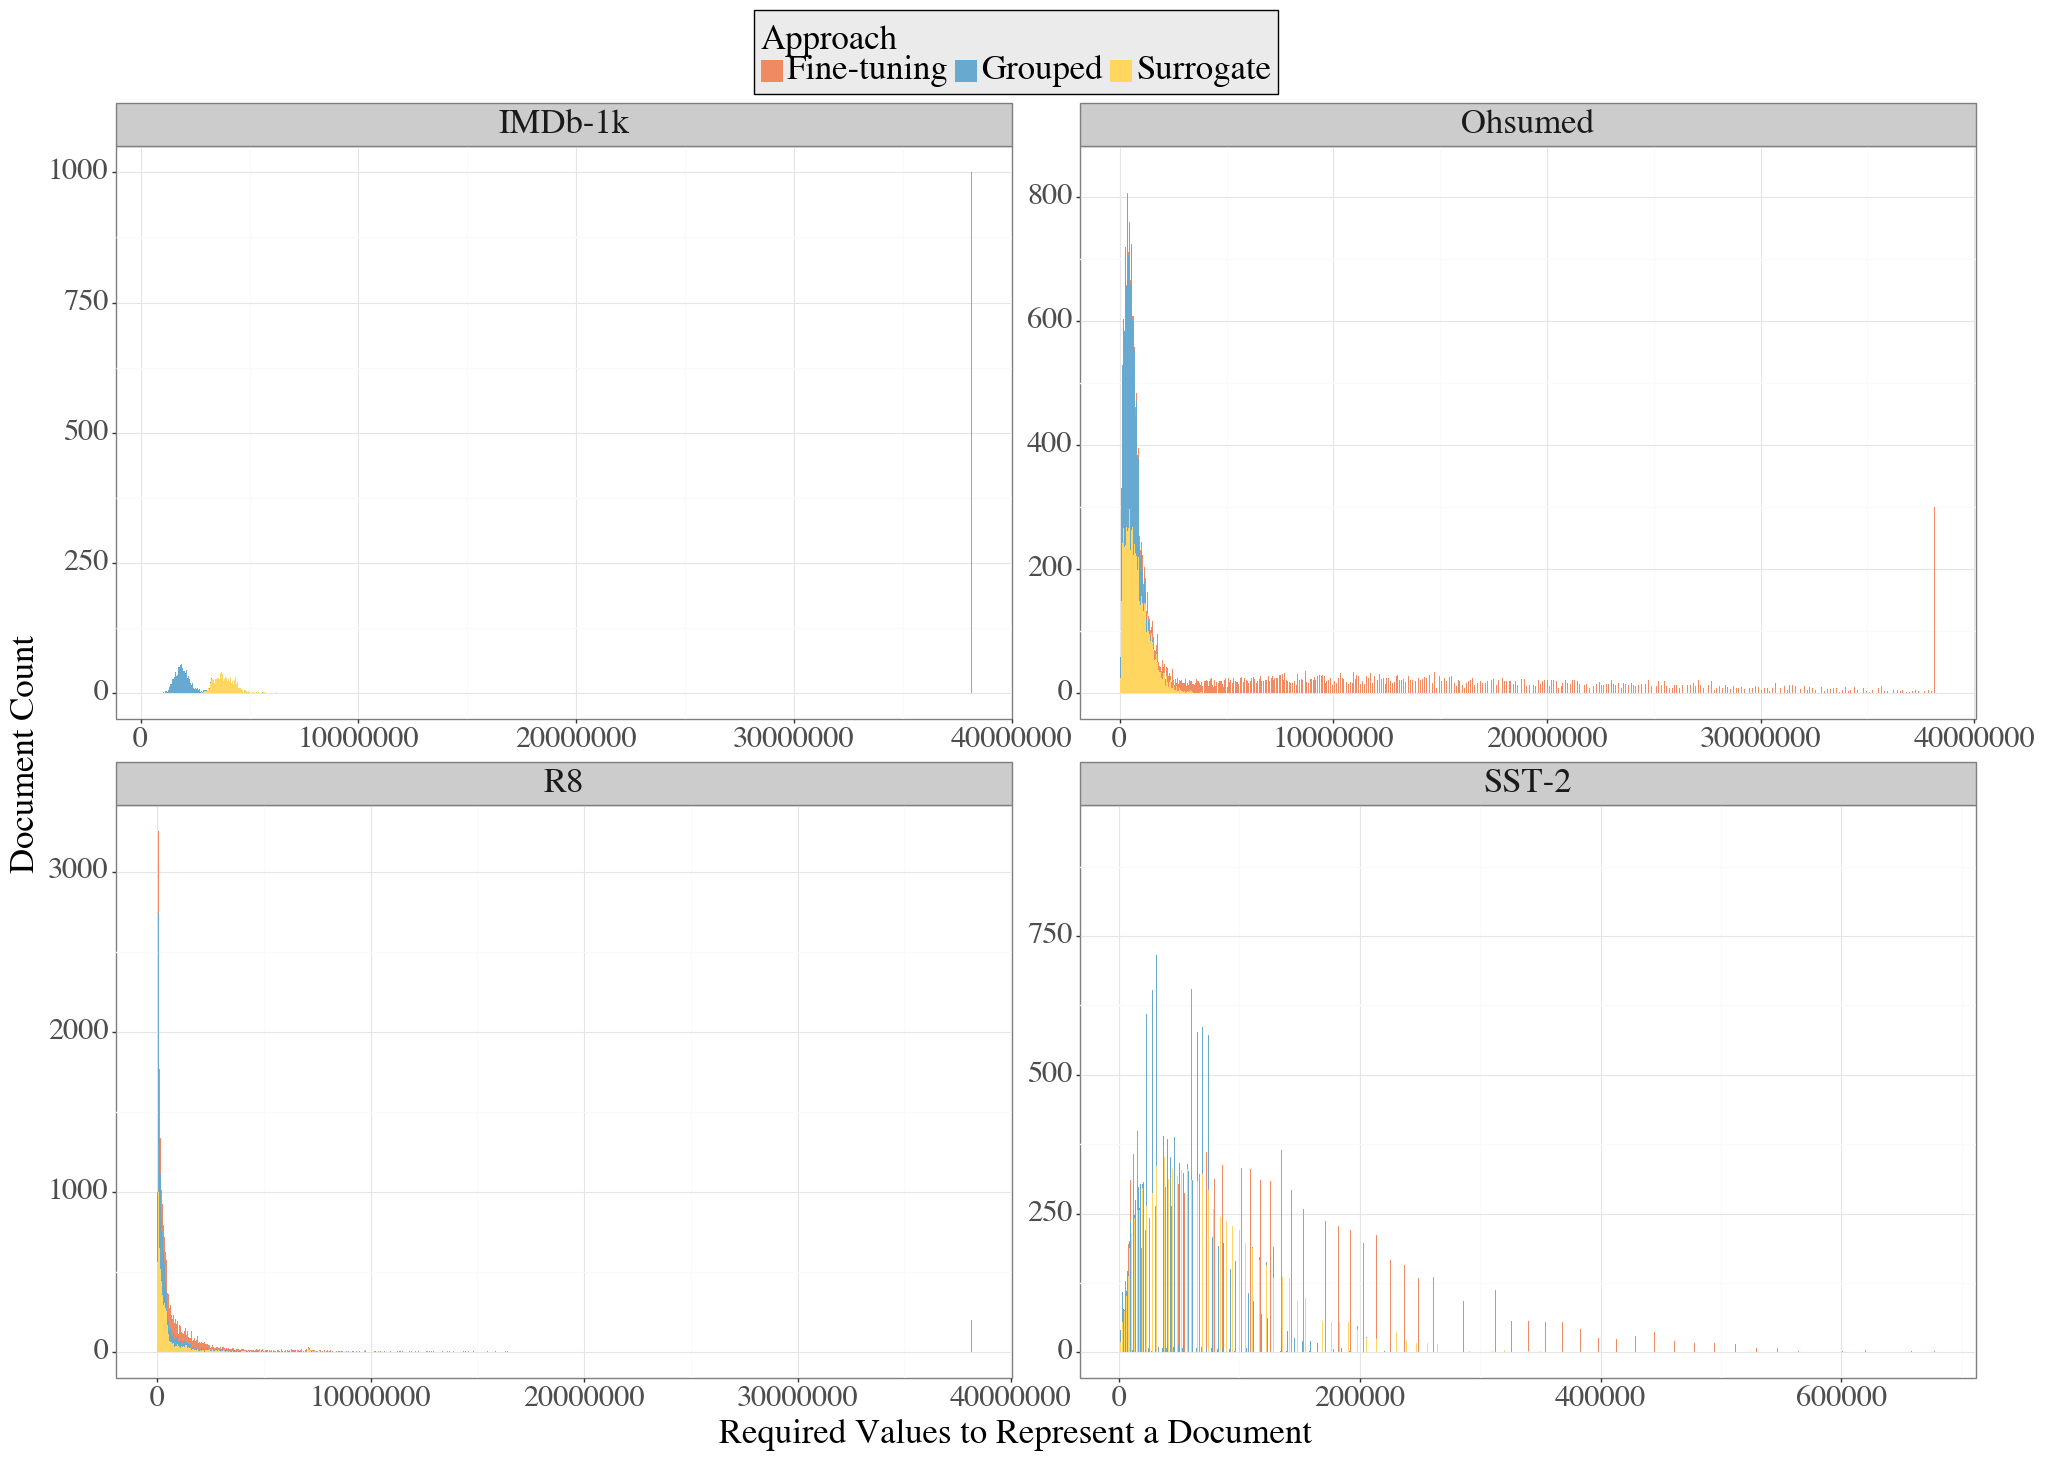

<ggplot: (812415919)>

In [215]:
plot

In [216]:
plot.save(filename = './paper_figures/BERT_values_per_graph.png', dpi = 300)

In [217]:
BERT_values_per_graph_df

split  index  nodes  total_values_for_nodes   edges  \
0    Training      0     61                   46848    1898   
1    Training      1     15                   11520     115   
2    Training      2     37                   28416     698   
3    Training      3     19                   14592     184   
4    Training      4     42                   32256     900   
..        ...    ...    ...                     ...     ...   
995   Testing    330    512                  393216  262144   
996   Testing    331    512                  393216  262144   
997   Testing    332    512                  393216  262144   
998   Testing    333    512                  393216  262144   
999   Testing    334    512                  393216  262144   

     total_values_for_edges  total_values_for_graph  dataset     approach  
0                    273312                  320160    SST-2    Surrogate  
1                     16560                   28080    SST-2    Surrogate  
2                    100512                  128928    SST-2    Surrogate  
3                     26496                   41088    SST-2    Surrogate  
4                    129600                  161856    SST-2    Surrogate  
..                      ...                     ...      ...          ...  
995                37748736                38141952  IMDb-1k  Fine-tuning  
996                37748736                38141952  IMDb-1k  Fine-tuning  
997                37748736                38141952  IMDb-1k  Fine-tuning  
998                37748736                38141952  IMDb-1k  Fine-tuning  
999                37748736                38141952  IMDb-1k  Fine-tuning  

[77061 rows x 9 columns]

In [218]:
BERT_values_per_graph_df_grouped = BERT_values_per_graph_df.groupby(by = ['dataset', 'approach']).agg(average_values_for_graph = ('total_values_for_graph', 'mean'), std_values_for_graph = ('total_values_for_graph', 'std')).reset_index()
BERT_values_per_graph_df_grouped['label'] = BERT_values_per_graph_df_grouped['average_values_for_graph'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + BERT_values_per_graph_df_grouped['std_values_for_graph'].map(lambda x : '{:.2f}'.format(x))

In [219]:
BERT_values_per_graph_df_grouped

dataset     approach  average_values_for_graph  std_values_for_graph  \
0   IMDb-1k  Fine-tuning              3.814195e+07          0.000000e+00   
1   IMDb-1k      Grouped              1.924618e+06          3.985604e+05   
2   IMDb-1k    Surrogate              3.950155e+06          7.652949e+05   
3   Ohsumed  Fine-tuning              1.374758e+07          1.005351e+07   
4   Ohsumed      Grouped              4.938620e+05          2.604436e+05   
5   Ohsumed    Surrogate              8.227446e+05          5.733775e+05   
6        R8  Fine-tuning              3.843180e+06          7.715332e+06   
7        R8      Grouped              4.216944e+05          7.754568e+05   
8        R8    Surrogate              7.780838e+05          1.596211e+06   
9     SST-2  Fine-tuning              1.263474e+05          9.865493e+04   
10    SST-2      Grouped              4.744981e+04          3.316253e+04   
11    SST-2    Surrogate              6.526902e+04          5.121442e+04   

                        label  
0          38141952.00 ± 0.00  
1      1924617.84 ± 398560.36  
2      3950155.10 ± 765294.93  
3   13747584.97 ± 10053508.28  
4       493862.00 ± 260443.58  
5       822744.63 ± 573377.48  
6     3843180.40 ± 7715331.91  
7       421694.43 ± 775456.79  
8      778083.83 ± 1596211.11  
9        126347.36 ± 98654.93  
10        47449.81 ± 33162.53  
11        65269.02 ± 51214.42

### BART-L

In [220]:
BART_L_values_per_graph_df = get_values_per_graph(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  folders = ['facebook-bart-large-Surrogate', 'facebook-bart-large-Grouped', 'facebook-bart-large-Grouped-Sliding_Windows']
)

In [221]:
BART_L_values_per_graph_df['dataset'] = BART_L_values_per_graph_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

In [222]:
BART_L_values_per_graph_df['split'] = BART_L_values_per_graph_df['split'].replace({'test' : 'Testing', 'validation' : 'Validation', 'train' : 'Training'}).str.capitalize()
BART_L_values_per_graph_df['split'] = pd.Categorical(BART_L_values_per_graph_df['split'], categories = ['Training', 'Validation', 'Testing'])
BART_L_values_per_graph_df['approach'] = pd.Categorical(BART_L_values_per_graph_df['approach'], categories = ['Sliding Windows', 'Grouped', 'Surrogate'])

In [223]:
plot = p9.ggplot(BART_L_values_per_graph_df,
  p9.aes(x = 'total_values_for_graph', fill = 'approach')) + \
  p9.theme_bw() + \
  p9.geom_histogram() + \
  p9.xlab('Required Values to Represent a Document') + \
  p9.ylab('Document Count') + \
  p9.labs(fill = 'Approach') + \
  p9.facet_wrap('~ dataset', ncol = 2, scales = 'free') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.theme(
    legend_position = 'top',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 16),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
    subplots_adjust = {
      'wspace' : 0.075,
      'hspace' : 0.15
    }
  )

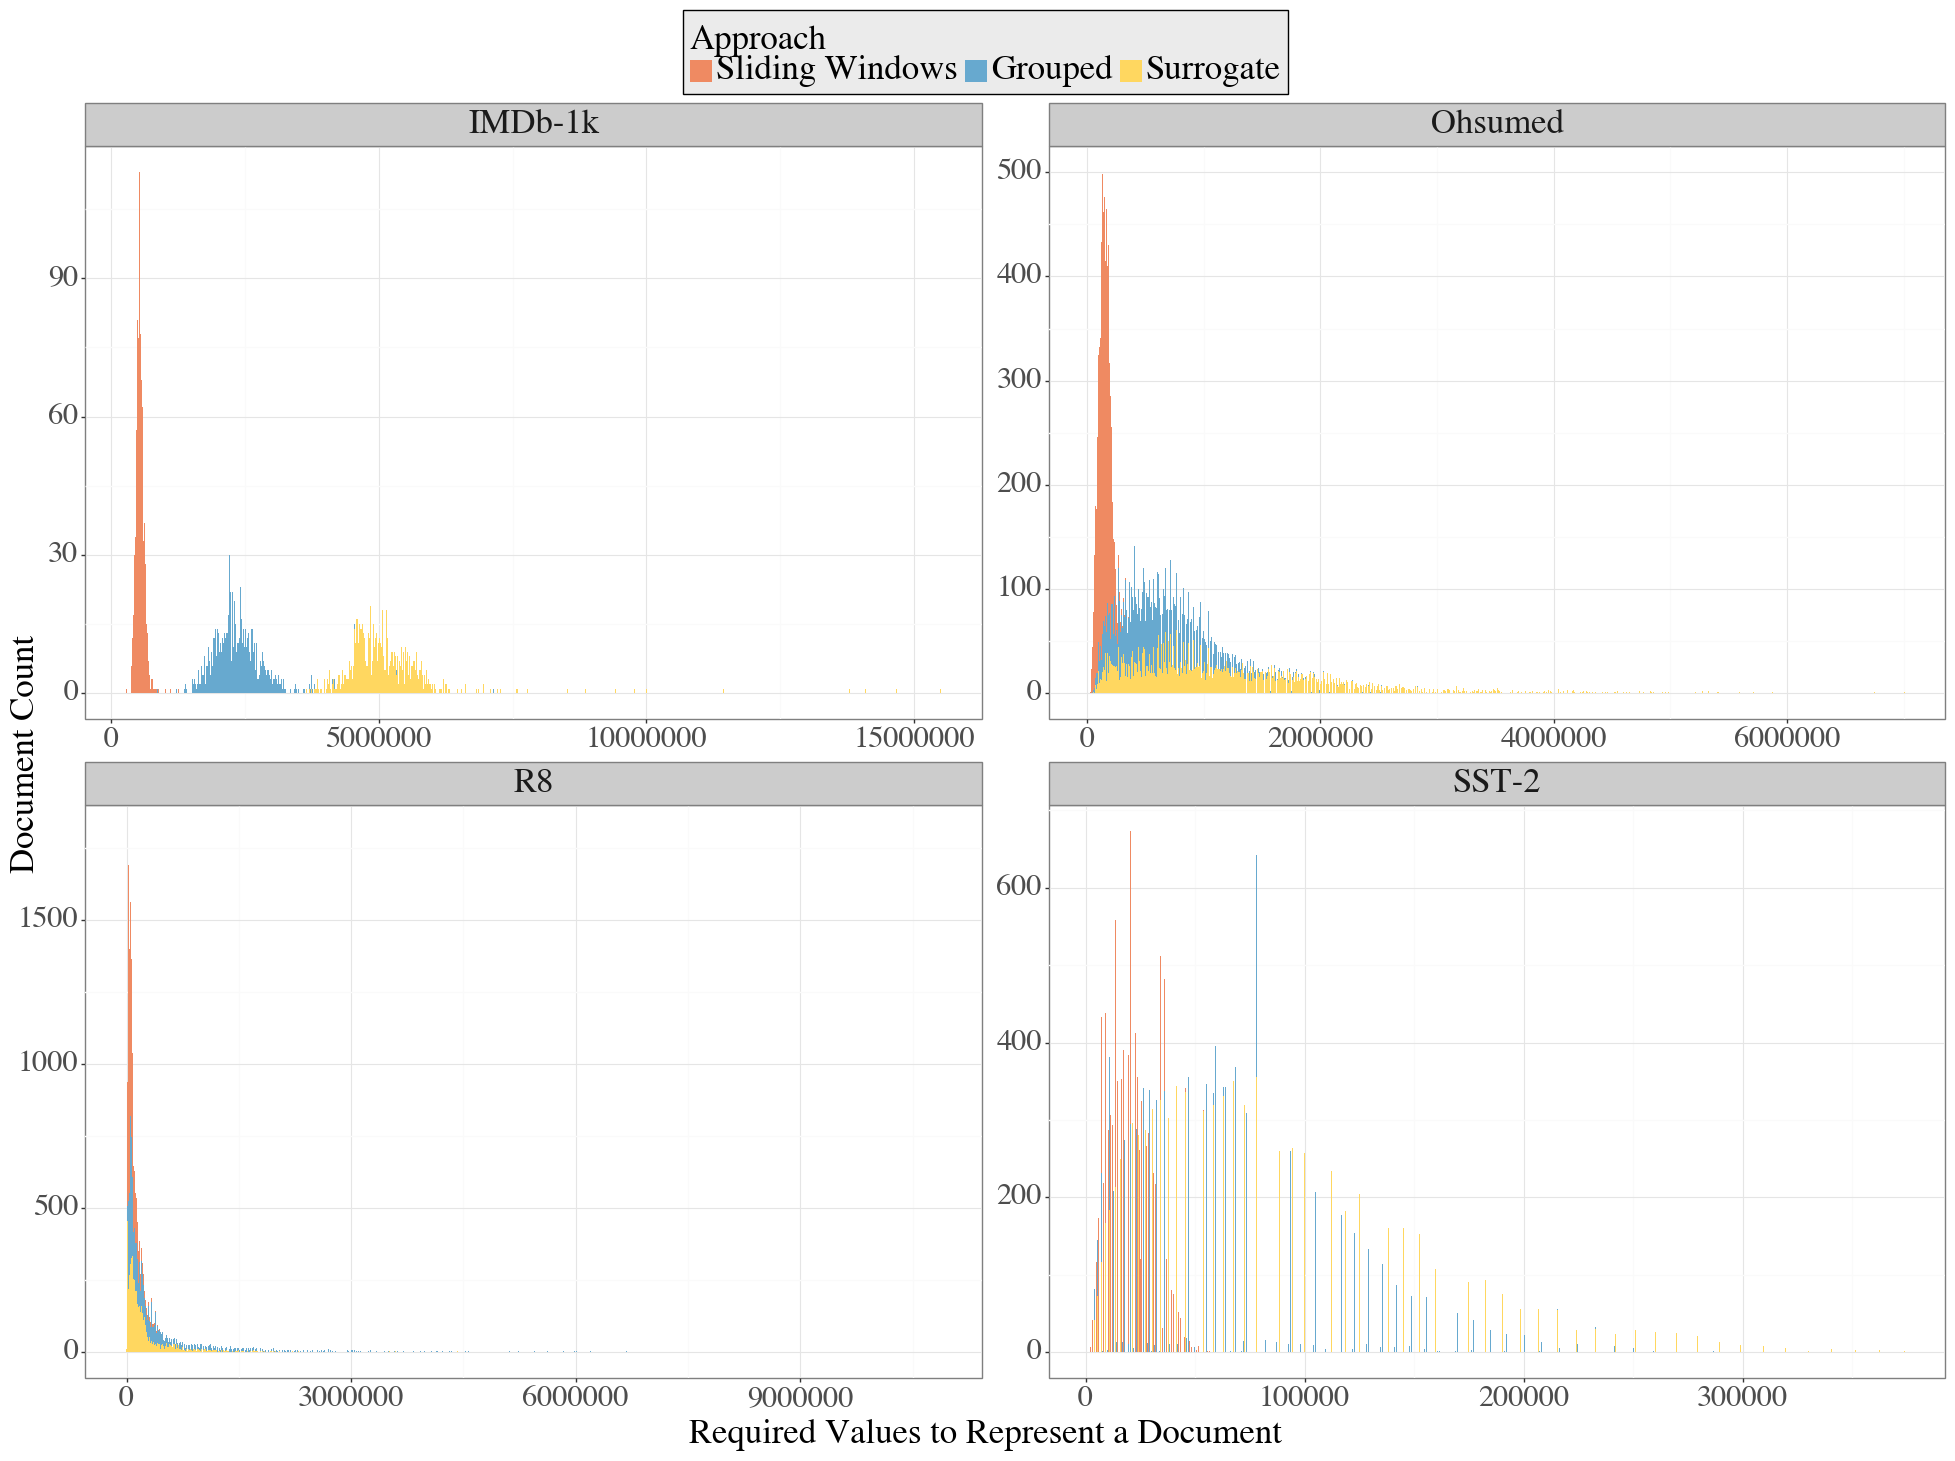

<ggplot: (811439080)>

In [224]:
plot

In [225]:
plot.save(filename = './paper_figures/BART_L_values_per_graph.png', dpi = 300)

In [226]:
BART_L_values_per_graph_df_grouped = BART_L_values_per_graph_df.groupby(by = ['dataset', 'approach']).agg(average_values_for_graph = ('total_values_for_graph', 'mean'), std_values_for_graph = ('total_values_for_graph', 'std')).reset_index()
BART_L_values_per_graph_df_grouped['label'] = BART_L_values_per_graph_df_grouped['average_values_for_graph'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + BART_L_values_per_graph_df_grouped['std_values_for_graph'].map(lambda x : '{:.2f}'.format(x))

In [227]:
BART_L_values_per_graph_df_grouped

dataset         approach  average_values_for_graph  std_values_for_graph  \
0   IMDb-1k  Sliding Windows              5.452075e+05          8.012740e+04   
1   IMDb-1k          Grouped              2.366087e+06          4.892101e+05   
2   IMDb-1k        Surrogate              5.142752e+06          9.537902e+05   
3   Ohsumed  Sliding Windows              1.455970e+05          4.698481e+04   
4   Ohsumed          Grouped              6.049812e+05          3.296859e+05   
5   Ohsumed        Surrogate              1.130348e+06          8.068922e+05   
6        R8  Sliding Windows              7.119379e+04          6.255780e+04   
7        R8          Grouped              5.320911e+05          1.028621e+06   
8        R8        Surrogate              3.714385e+05          7.797679e+05   
9     SST-2  Sliding Windows              2.145718e+04          9.535490e+03   
10    SST-2          Grouped              6.078845e+04          4.186093e+04   
11    SST-2        Surrogate              7.471182e+04          5.680225e+04   

                     label  
0     545207.54 ± 80127.40  
1   2366086.53 ± 489210.15  
2   5142752.38 ± 953790.16  
3     145597.01 ± 46984.81  
4    604981.21 ± 329685.89  
5   1130348.18 ± 806892.25  
6      71193.79 ± 62557.80  
7   532091.07 ± 1028620.57  
8    371438.52 ± 779767.86  
9       21457.18 ± 9535.49  
10     60788.45 ± 41860.93  
11     74711.82 ± 56802.25

## Error Dependence Plots Over Text Length  

In [228]:
def load_individual_predictions(dataset, gnn, PLM, method, aggregation, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{PLM.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N)
  
  performance = list()
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    random_states = [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{trial}/{x}')]
    if len(random_states) < 10:
      continue

    for random_state in random_states:
      df = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{PLM}/{method}/{aggregation}/{trial}/{random_state}/predictions.csv').assign(random_state = random_state)
      performance.append(df)
    break
  
  return pd.concat(performance)

In [229]:
def get_individual_predictions(datasets, gnns, PLMs, methods, aggregations):
  individual_predictions = list()
  for dataset in datasets:
    for gnn in gnns:
      for PLM in PLMs:
        for method in methods:
          for aggregation in aggregations:
            df = load_individual_predictions(dataset = dataset, gnn = gnn, PLM = PLM, method = method, aggregation = aggregation).assign(dataset = dataset, gnn = gnn, PLM = PLM, method = method, aggregation = aggregation)
            individual_predictions.append(df)
  return pd.concat(individual_predictions)

In [230]:
def load_individual_predictions_fine_tuning(dataset, PLM, display_information = False):
  
  study_name = f'{dataset}-{PLM.replace("/", "-")}'
  storage = f'sqlite:///../../baselines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N)
  
  performance = list()
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    random_states = [x for x in os.listdir(f'../../outputs/{dataset}-{PLM}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{PLM}/{trial}/{x}')]
    if len(random_states) < 10:
      continue

    for random_state in random_states:
      df = pd.read_csv(f'../../outputs/{dataset}-{PLM}/{trial}/{random_state}/predictions.csv').assign(random_state = random_state)
      performance.append(df)
    break
  
  return pd.concat(performance)

In [231]:
def get_individual_predictions_fine_tuning(datasets, PLMs):
  individual_predictions = list()
  for dataset in datasets:
    for PLM in PLMs:
      df = load_individual_predictions_fine_tuning(dataset = dataset, PLM = PLM).assign(dataset = dataset, gnn = 'N/A', PLM = PLM, method = 'Fine-tuning', aggregation = 'N/A')
      individual_predictions.append(df)
  return pd.concat(individual_predictions)

In [232]:
def load_individual_predictions_sliding_windows(dataset, gnn, PLM, method, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{PLM.replace("/", "-")}-{method}-Sliding_Windows'
  storage = f'sqlite:///../../sliding_windows/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N)
  
  performance = list()
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    random_states = [x for x in os.listdir(f'../../sliding_window_outputs/{dataset}-{gnn}-{PLM}/{method}/Sliding_Windows/{trial}') if os.path.isdir(f'../../sliding_window_outputs/{dataset}-{gnn}-{PLM}/{method}/Sliding_Windows/{trial}/{x}')]
    if len(random_states) < 10:
      continue

    for random_state in random_states:
      df = pd.read_csv(f'../../sliding_window_outputs/{dataset}-{gnn}-{PLM}/{method}/Sliding_Windows/{trial}/{random_state}/predictions.csv').assign(random_state = random_state)
      performance.append(df)
    break
  
  return pd.concat(performance)

In [233]:
def get_individual_predictions_sliding_windows(datasets, gnns, PLMs, methods):
  individual_predictions = list()
  for dataset in datasets:
    for gnn in gnns:
      for PLM in PLMs:
        for method in methods:
          df = load_individual_predictions_sliding_windows(dataset = dataset, gnn = gnn, PLM = PLM, method = method).assign(dataset = dataset, gnn = gnn, PLM = PLM, method = f'Sliding Windows ({method})', aggregation = 'N/A')
          individual_predictions.append(df)
  return pd.concat(individual_predictions)

In [234]:
def compute_target_performance_metric(group, target_metric):
  if target_metric == 'f1_score':
    return sklearn.metrics.f1_score(group['real'], group['prediction'], average = 'macro')
  else:
    return sklearn.metrics.accuracy_score(group['real'], group['prediction'])

In [235]:
def error_dependence_plot(df, column_name, target_metric, cutting_points):
  
  col_df = df[[column_name, 'real', 'prediction']].copy()
    
  if df[column_name].dtype in [int, float]:
    col_df['interval'], quantile_intervals = pd.cut(col_df[column_name], bins = cutting_points, retbins = True, duplicates = 'drop')

    quantile_interval_labels = [f'({np.round(quantile_intervals[i], decimals = 3)}, {np.round(quantile_intervals[i + 1], decimals = 3)}]' for i in range(len(quantile_intervals) - 1)]
    col_df['interval'] = col_df['interval'].cat.rename_categories(quantile_interval_labels)
    quantile_counts = col_df['interval'].value_counts().reset_index(name = 'count').rename(columns = {'index' : 'interval'}).set_index(keys = ['interval']).to_dict(orient = 'index')
    quantile_labels = [f'{quantile_interval_labels[i]}\n{quantile_counts[quantile_interval_labels[i]]["count"]} Docs.\n{np.round((quantile_counts[quantile_interval_labels[i]]["count"] / col_df.shape[0]) * 100, decimals = 3)}%' for i in range(len(quantile_interval_labels))]

    # Add quantile_interval_labels to 'interval' column
    col_df['interval'] = pd.Categorical(col_df['interval'], categories = quantile_interval_labels, ordered = True)
    col_df['interval'] = col_df['interval'].cat.rename_categories(quantile_labels)
        
    categorical_col_df = col_df.groupby('interval').apply(lambda group : compute_target_performance_metric(group, target_metric = target_metric)).reset_index(name = 'True')    
    categorical_col_df['False'] = 1.0 - categorical_col_df['True']
    categorical_col_df = categorical_col_df.melt(id_vars = ['interval'], var_name = 'correct')
  else:
    category_counts = col_df[column_name].value_counts().reset_index(name = 'count').rename(columns = {'index' : column_name}).set_index(keys = [column_name]).to_dict(orient = 'index')
    category_labels = [f'{i}\n{category_counts[i]["count"]} Docs.\n{np.round((category_counts[i]["count"] / col_df.shape[0]) * 100, decimals = 3)}%' for i in category_counts.keys()]
    
    # Add quantile_interval_labels to 'interval' column
    col_df['interval'] = pd.Categorical(col_df[column_name], categories = col_df[column_name].unique(), ordered = True)
    col_df['interval'] = col_df['interval'].cat.rename_categories(category_labels)

    categorical_col_df = col_df.groupby('interval').apply(lambda group : compute_target_performance_metric(group, target_metric = target_metric)).reset_index(name = 'True')
    categorical_col_df['False'] = 1.0 - categorical_col_df['True']
    categorical_col_df = categorical_col_df.melt(id_vars = ['interval'], var_name = 'correct')

  all_data_performance = compute_target_performance_metric(col_df, target_metric = target_metric)
  all_data_df = pd.DataFrame({
    'interval' : [f'All Data\n{col_df.shape[0]} Docs.\n100%', f'All Data\n{col_df.shape[0]} Docs.\n100%'],
    'correct' : ['True', 'False'], 
    'value' : [all_data_performance, 1.0 - all_data_performance]
  })

  plot_df = pd.concat([categorical_col_df, all_data_df])
  plot_df['interval'] = pd.Categorical(plot_df['interval'], categories = plot_df['interval'].unique())
  plot_df['variable'] = column_name

  plot_df['value'] = plot_df['value'].map(lambda x : np.round(x * 100, decimals = 2))
  plot_df['label'] = plot_df['value'].map(lambda x : f'{x}%')

  plot_df.dropna(inplace = True)

  plot_df['correct'] = plot_df['correct'].replace({
    'False' : 'No',
    'True' : 'Yes'
  })

  return p9.ggplot(
      plot_df,
      p9.aes(x = 'interval', y = 'value', fill = 'correct')
    ) + \
      p9.geom_col() + \
      p9.geom_text(p9.aes(label = 'label'), position = p9.position_stack(vjust = .5), size = 20) + \
      p9.geom_vline(xintercept = plot_df['interval'].unique().size - 0.5, linetype = 'dashed', size = 1.2) + \
      p9.ylab('Performance (%)') + \
      p9.xlab(column_name) + \
      p9.labs(fill = 'Correctly Classified?') + \
      p9.theme_bw() + \
      p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
      p9.theme(
        legend_position = 'top',
        legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
        legend_box_margin = 0,
        figure_size = (12, 8),
        text = p9.element_text(size = 25, family = 'serif'),
        axis_text = p9.element_text(size = 22),
        axis_title = p9.element_text(weight = 'bold'),
        legend_title = p9.element_text(weight = 'bold'),
      )


### Defining Token Intervals

#### BERT

In [236]:
BERT_word_and_token_counts = pd.merge(
  text_length_df[['dataset', 'split', 'index', 'length']].assign(
    split = np.select([text_length_df['split'] == 'validation', text_length_df['split'] == 'test'], ['Validation', 'Testing'], default = text_length_df['split']),
    dataset = np.select([text_length_df['dataset'] == 'IMDb-top_1000'], ['IMDb-1k'], default = text_length_df['dataset'])
  ),
  BERT_values_per_graph_df[BERT_values_per_graph_df['approach'] == 'Surrogate'][['dataset', 'split', 'index', 'nodes']],
  on = ['dataset', 'split', 'index']
)[['length', 'nodes']]

In [237]:
(BERT_word_and_token_counts['length'] / BERT_word_and_token_counts['nodes']).median()

0.7071129707112971

In [238]:
int(512 * 0.71)

363

#### BART-L

In [239]:
BART_L_word_and_token_counts = pd.merge(
  text_length_df[['dataset', 'split', 'index', 'length']].assign(
    split = np.select([text_length_df['split'] == 'validation', text_length_df['split'] == 'test'], ['Validation', 'Testing'], default = text_length_df['split']),
    dataset = np.select([text_length_df['dataset'] == 'IMDb-top_1000'], ['IMDb-1k'], default = text_length_df['dataset'])
  ),
  BART_L_values_per_graph_df[BART_L_values_per_graph_df['approach'] == 'Surrogate'][['dataset', 'split', 'index', 'nodes']],
  on = ['dataset', 'split', 'index']
)[['length', 'nodes']]

In [240]:
(BART_L_word_and_token_counts['length'] / BART_L_word_and_token_counts['nodes']).median()

0.7142857142857143

In [241]:
int(1024 * 0.71)

727

In [242]:
PLM_intervals = dict()
for PLM in ['BERT', 'BART-L']:
  PLM_intervals[PLM] = list()
  print(PLM)
  for dataset in ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000']:
    q = 3 if (dataset == 'R8') or ((PLM == 'BERT') and (dataset == 'Ohsumed')) else 4
    _, intervals = pd.qcut(text_length_df[(text_length_df['dataset'] == dataset) & (text_length_df['split'] == 'test')]['length'], q = q, retbins = True)
    intervals[0] -= 1 # Open braket interval limit
    if (PLM == 'BERT') and (dataset == 'Ohsumed'): # Ohsumed add 361 (363 - 2) cutting point
      intervals = np.insert(intervals, np.searchsorted(intervals, 361), 361) 
    elif (PLM == 'BERT') and (dataset == 'R8'): # R8 add 361 (363 - 2) and 725 (727 - 2) cutting points --> -2 to account for start and end special tokens
      intervals = np.insert(intervals, np.searchsorted(intervals, 361), 361) 
    elif (PLM == 'BART-L') and (dataset == 'R8'): # R8 add 361 (363 - 2) and 725 (727 - 2) cutting points --> -2 to account for start and end special tokens
      intervals = np.insert(intervals, np.searchsorted(intervals, 725), 725) 
    print(dataset, [int(x) for x in intervals])
    PLM_intervals[PLM].append([int(x) for x in intervals])
  print('')

BERT
SST-2 [0, 10, 16, 21, 50]
R8 [6, 39, 85, 361, 806]
Ohsumed [26, 149, 214, 361, 597]
IMDb-top_1000 [753, 809, 880, 958, 2271]

BART-L
SST-2 [0, 10, 16, 21, 50]
R8 [6, 39, 85, 725, 806]
Ohsumed [26, 131, 179, 236, 597]
IMDb-top_1000 [753, 809, 880, 958, 2271]



### Fine-tuning

In [243]:
individual_predictions_fine_tuning = get_individual_predictions_fine_tuning(
  datasets = ['SST-2', 'Ohsumed', 'R8', 'IMDb-top_1000'],
  PLMs = ['google-bert-bert-base-uncased'],
)
individual_predictions_fine_tuning = pd.merge(
  individual_predictions_fine_tuning[(individual_predictions_fine_tuning['random_state'] == '42') & (individual_predictions_fine_tuning['split'] == 'test')],
  text_length_df,
  on = ['dataset', 'split', 'index']
).drop(columns = ['index']).rename(columns = {'length' : 'Text Length'})[['dataset', 'Text Length', 'real', 'prediction']]
individual_predictions_fine_tuning['dataset'] = individual_predictions_fine_tuning['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})


 SST-2


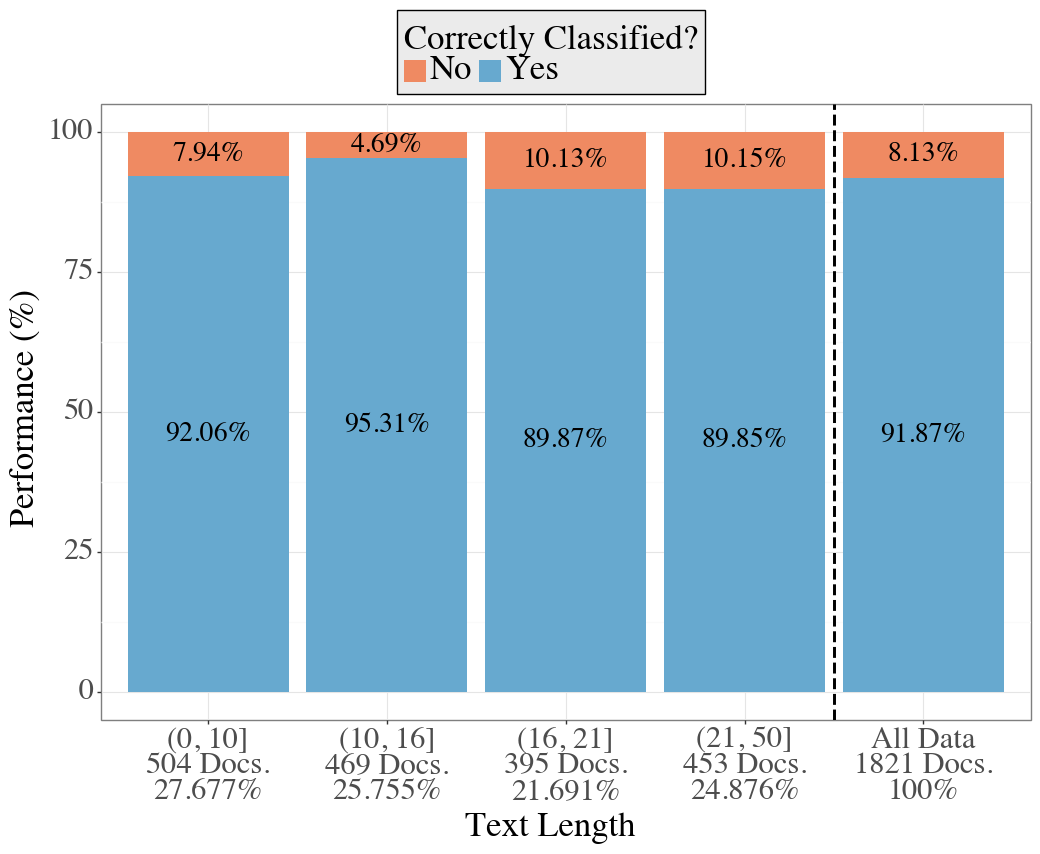



 R8


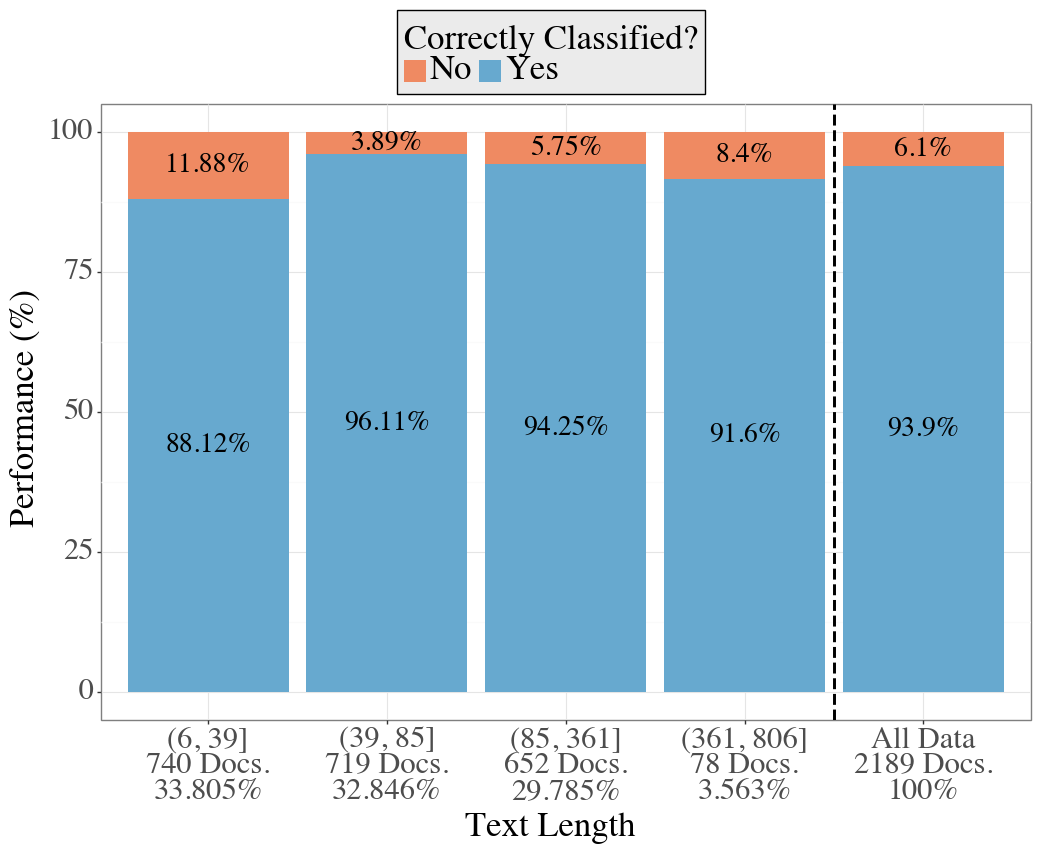



 Ohsumed


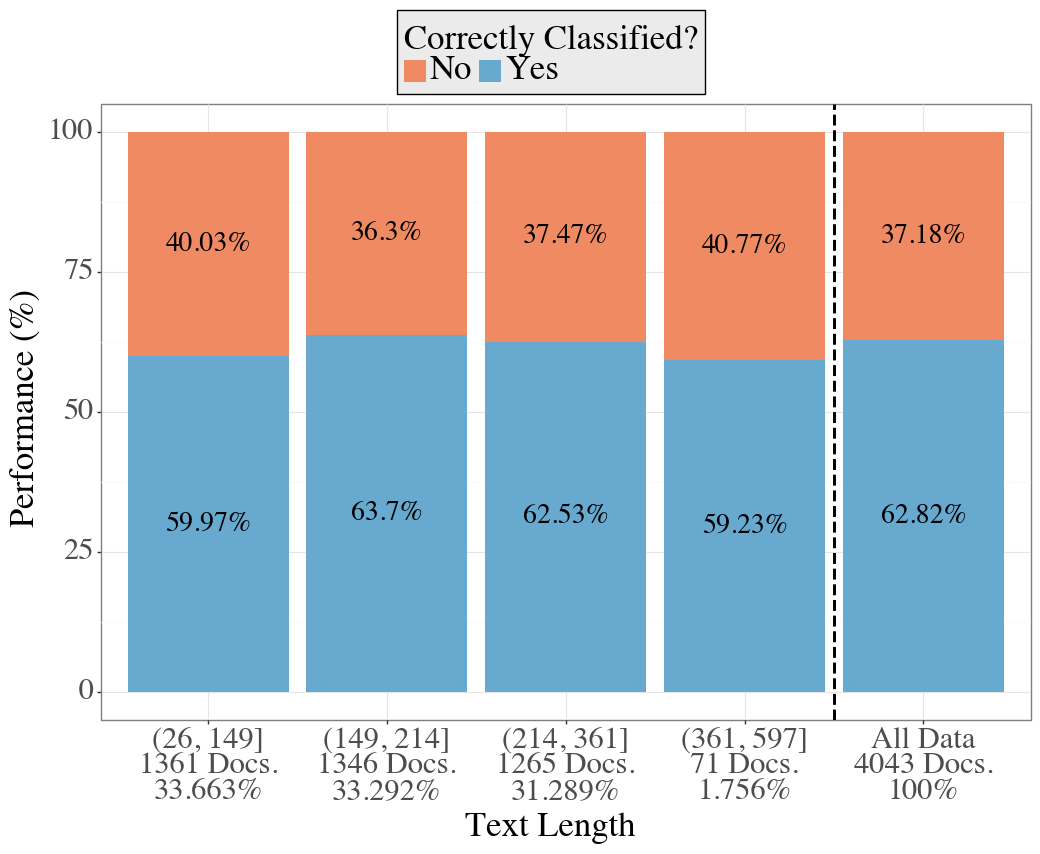



 IMDb-1k


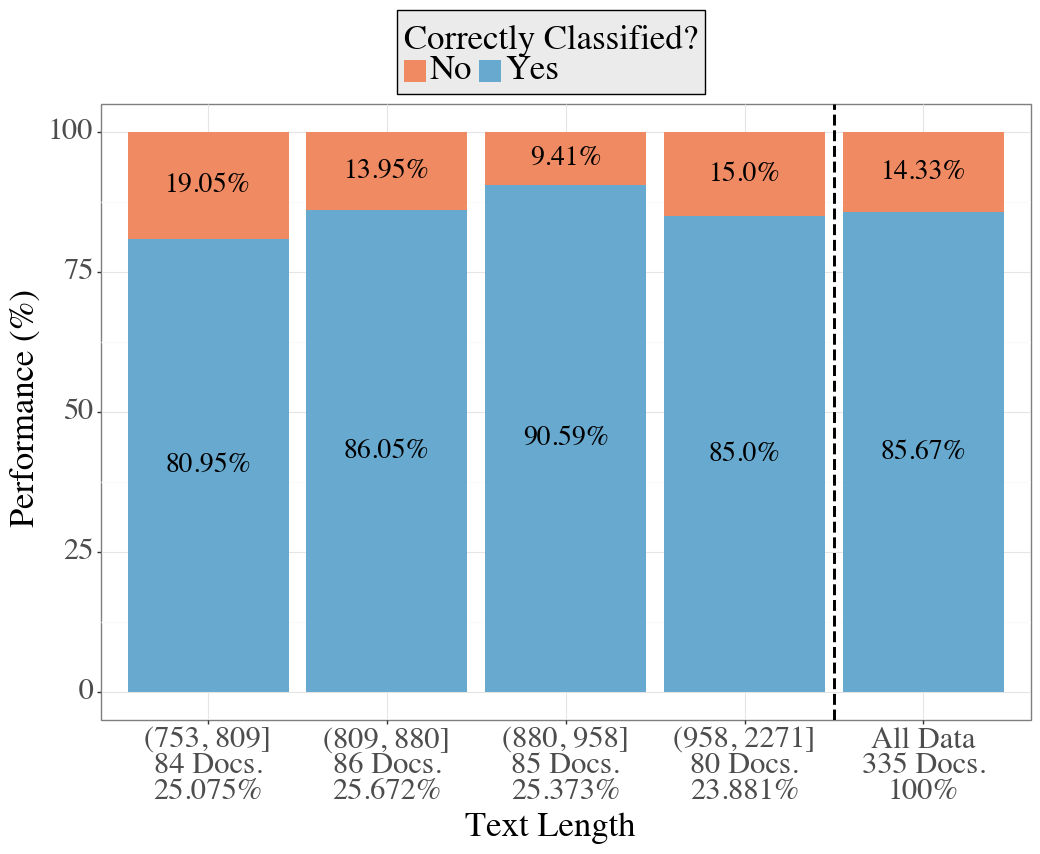

In [244]:
for dataset, target_metric, cutting_points in zip(['SST-2', 'R8', 'Ohsumed', 'IMDb-1k'], ['accuracy', 'f1_score', 'f1_score', 'accuracy'], PLM_intervals['BERT']):
  print('\n', dataset)
  plot = error_dependence_plot(
    df = individual_predictions_fine_tuning[individual_predictions_fine_tuning['dataset'] == dataset].drop(columns = ['dataset']),
    column_name = 'Text Length',
    target_metric = target_metric,
    cutting_points = cutting_points
  )
  print(plot)
  if dataset == 'IMDb-1k':
    plot.save(filename = f'./paper_figures/BERT_fine_tuning_EDP_{dataset}.png', dpi = 300)

### Our Method (BERT)

In [245]:
individual_predictions_using_BERT = get_individual_predictions(
  datasets = ['SST-2', 'Ohsumed', 'R8', 'IMDb-top_1000'],
  gnns = ['GATv2'],
  PLMs = ['google-bert-bert-base-uncased'],
  methods = ['Grouped', 'Surrogate'],
  aggregations = ['No_Aggregation']
)
individual_predictions_using_BERT = pd.merge(
  individual_predictions_using_BERT[(individual_predictions_using_BERT['random_state'] == '42') & (individual_predictions_using_BERT['split'] == 'test')],
  text_length_df,
  on = ['dataset', 'split', 'index']
).drop(columns = ['index']).rename(columns = {'length' : 'Text Length'})[['dataset', 'method', 'Text Length', 'real', 'prediction']]
individual_predictions_using_BERT['dataset'] = individual_predictions_using_BERT['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

--------------------------------------------------------------------------- Grouped ---------------------------------------------------------------------------

 SST-2


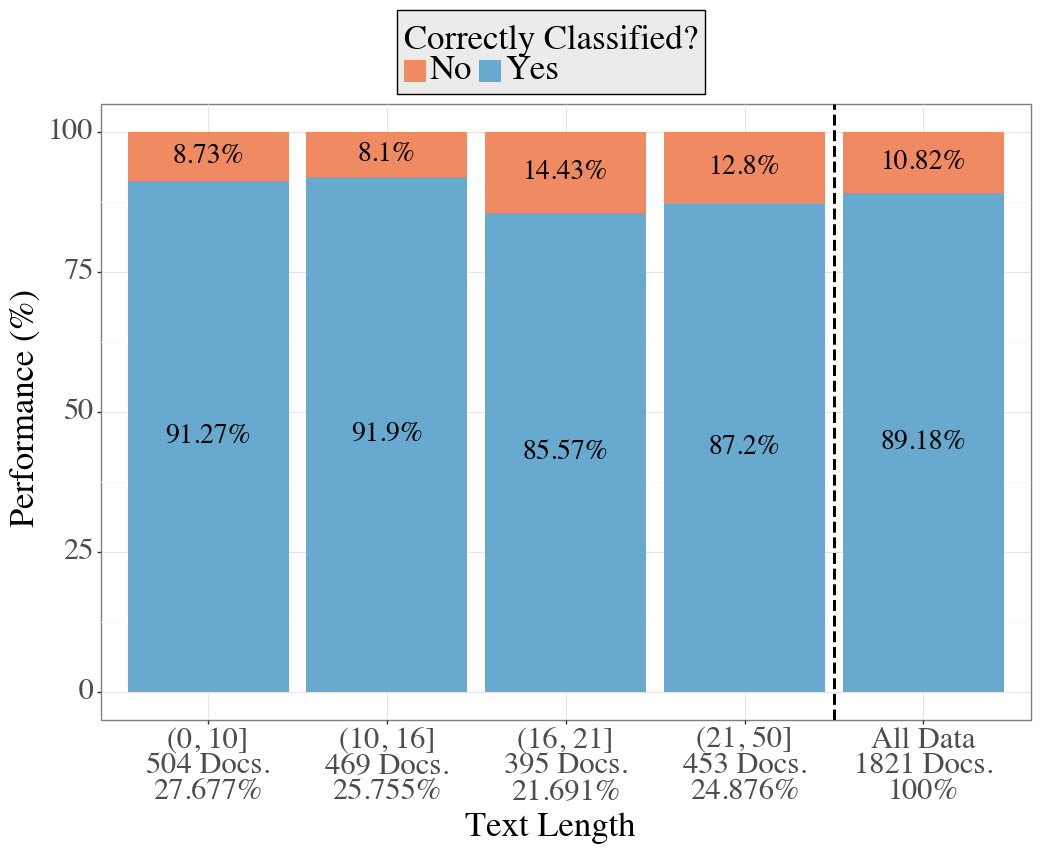



 R8


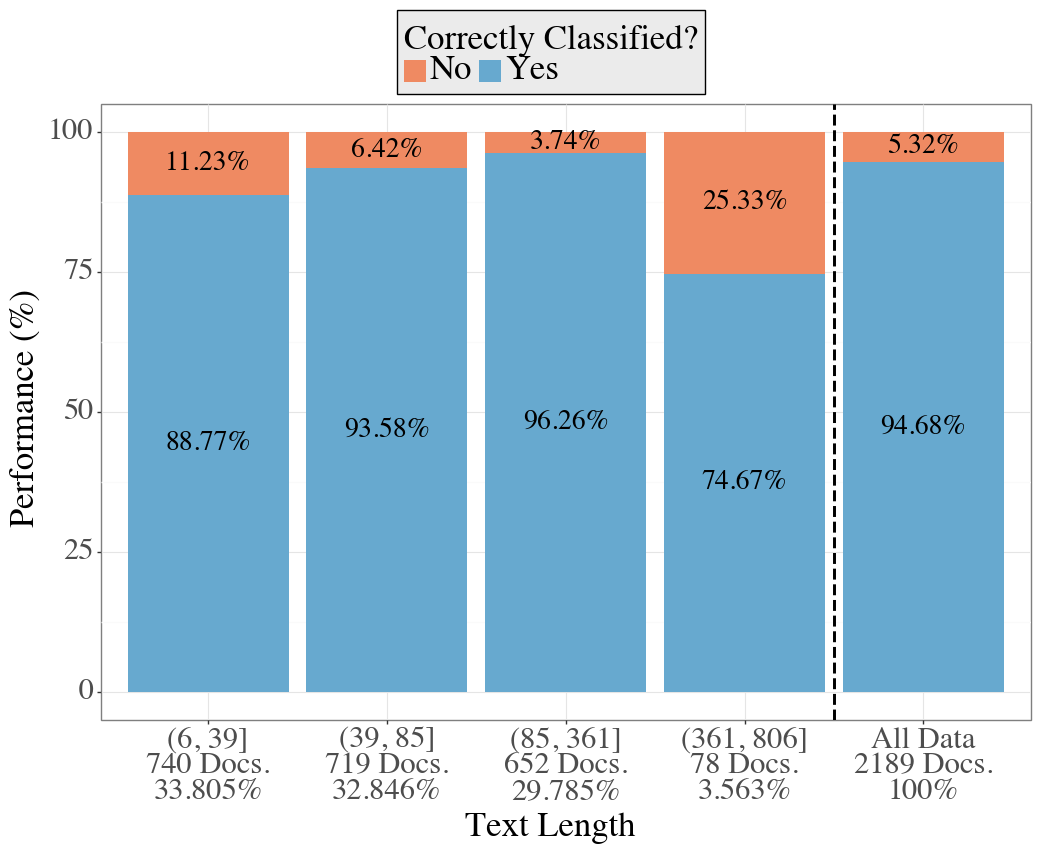



 Ohsumed


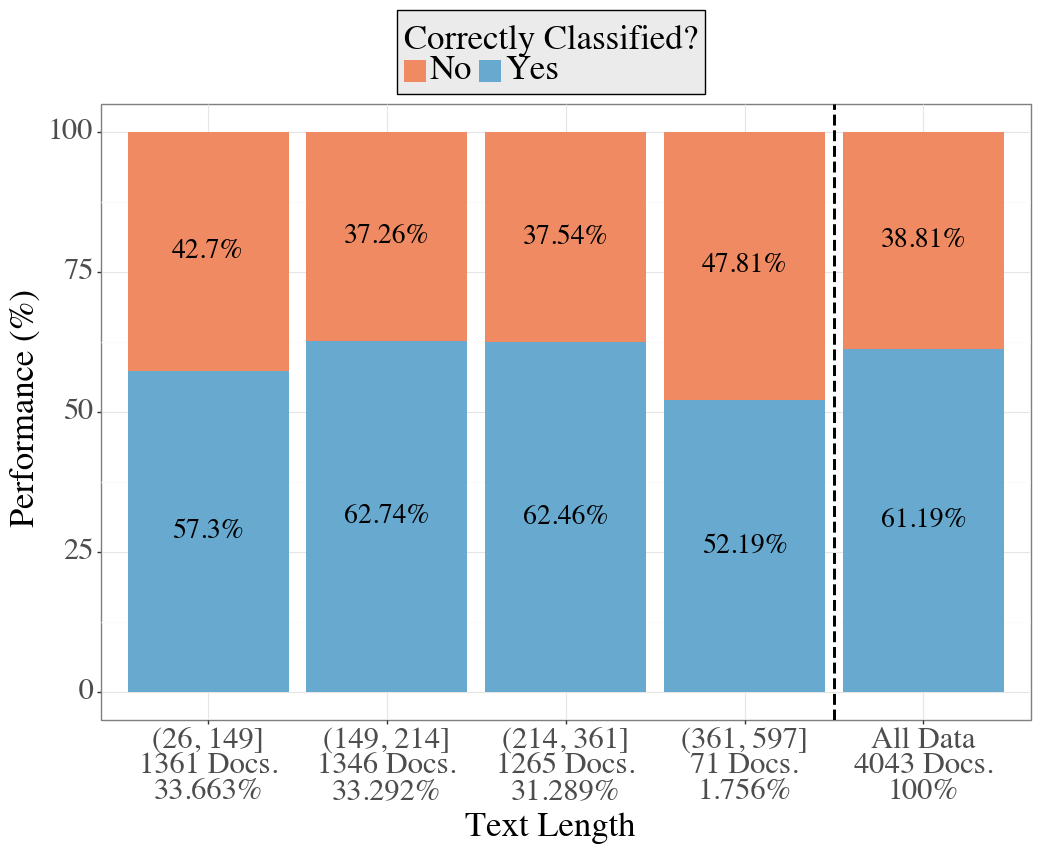



 IMDb-1k


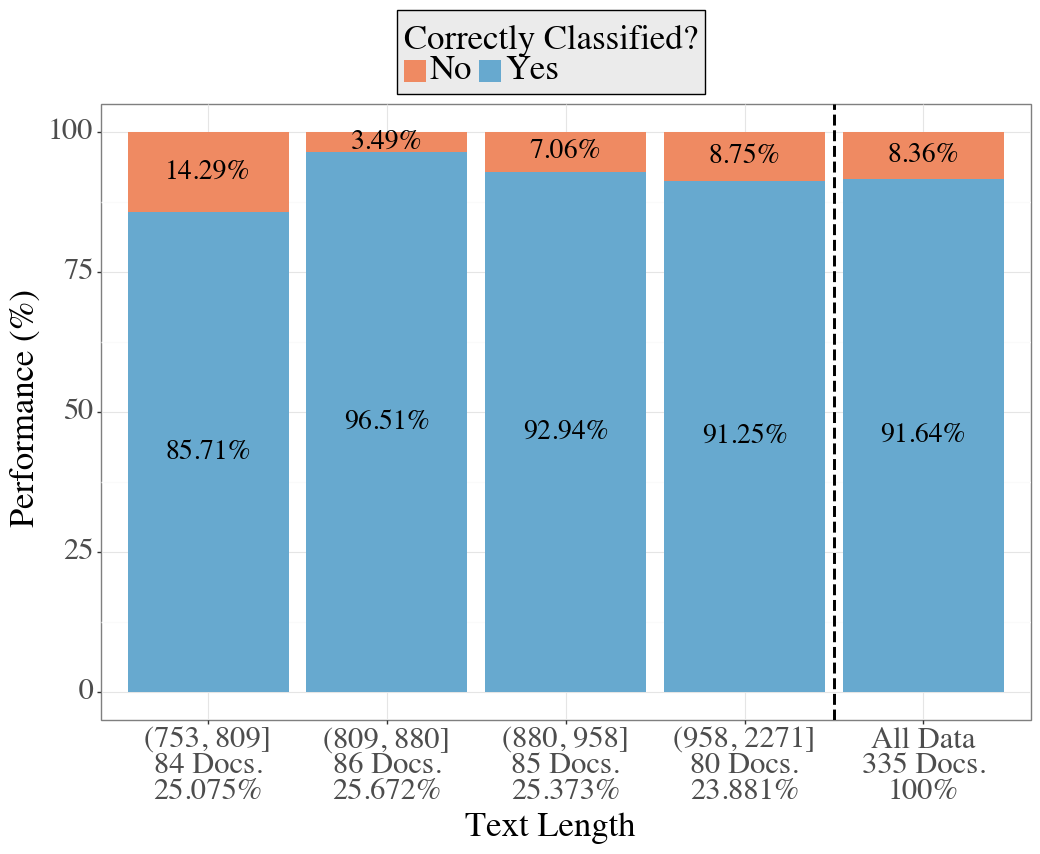


--------------------------------------------------------------------------- Surrogate ---------------------------------------------------------------------------

 SST-2


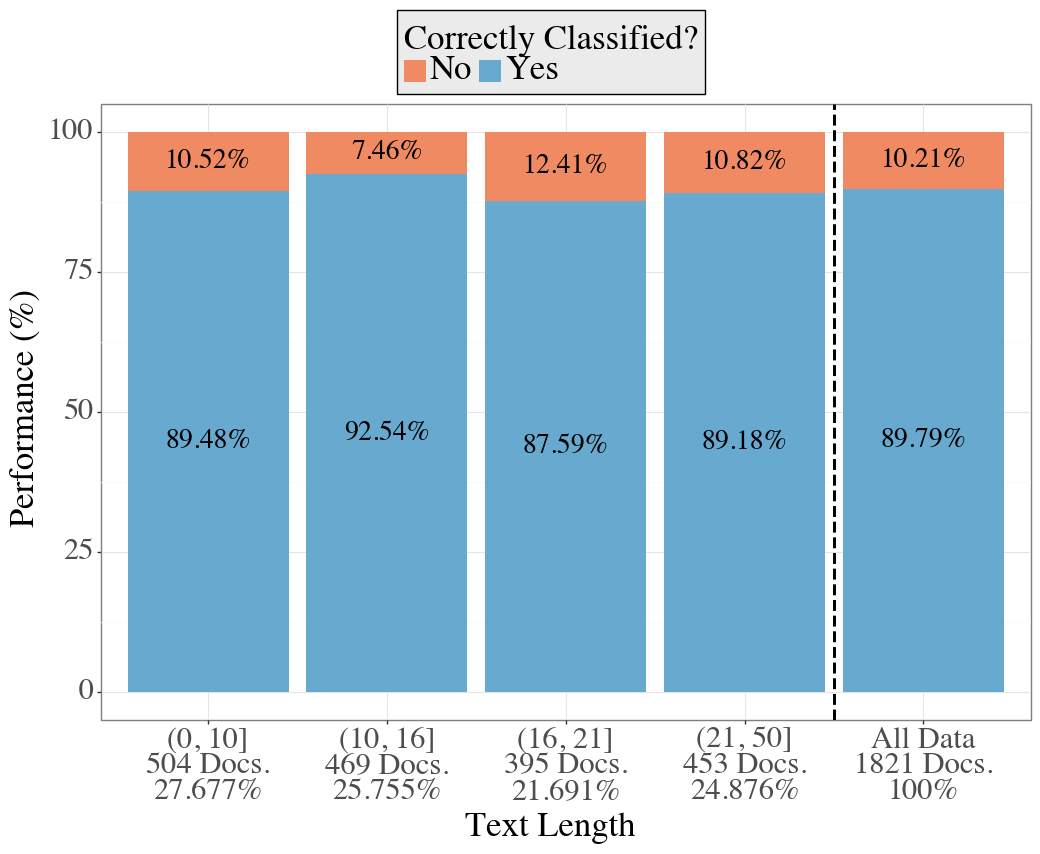



 R8


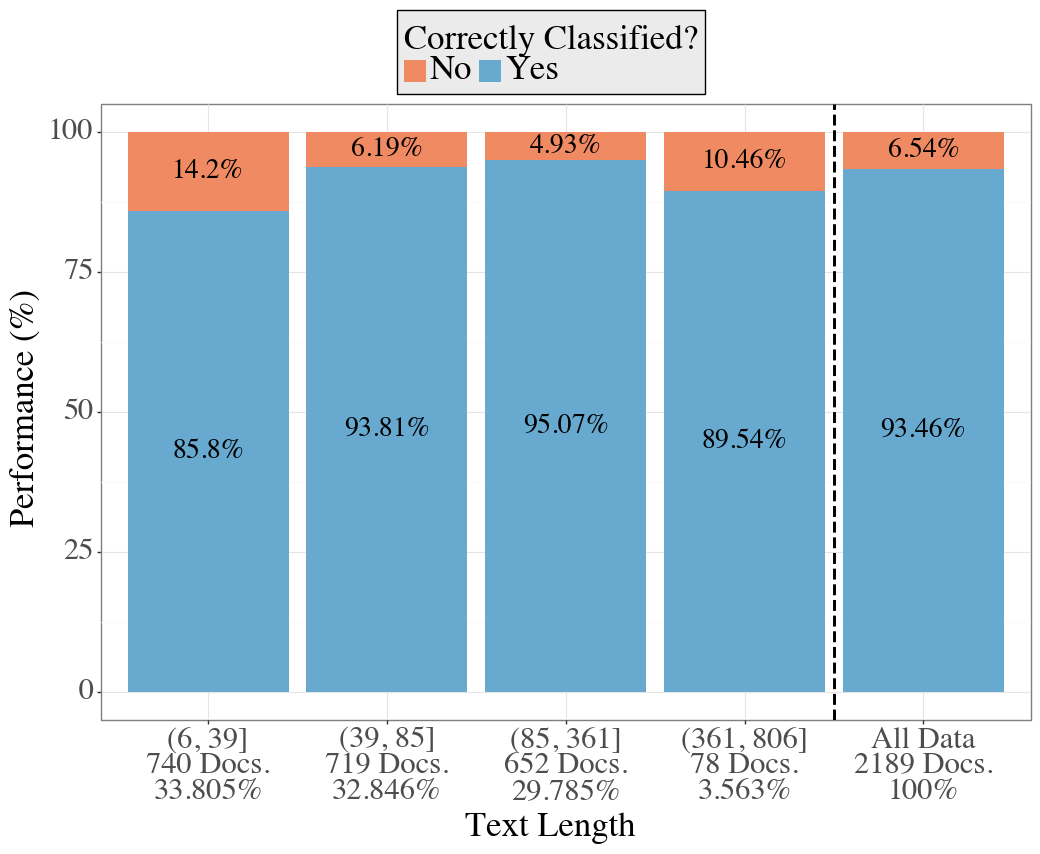



 Ohsumed


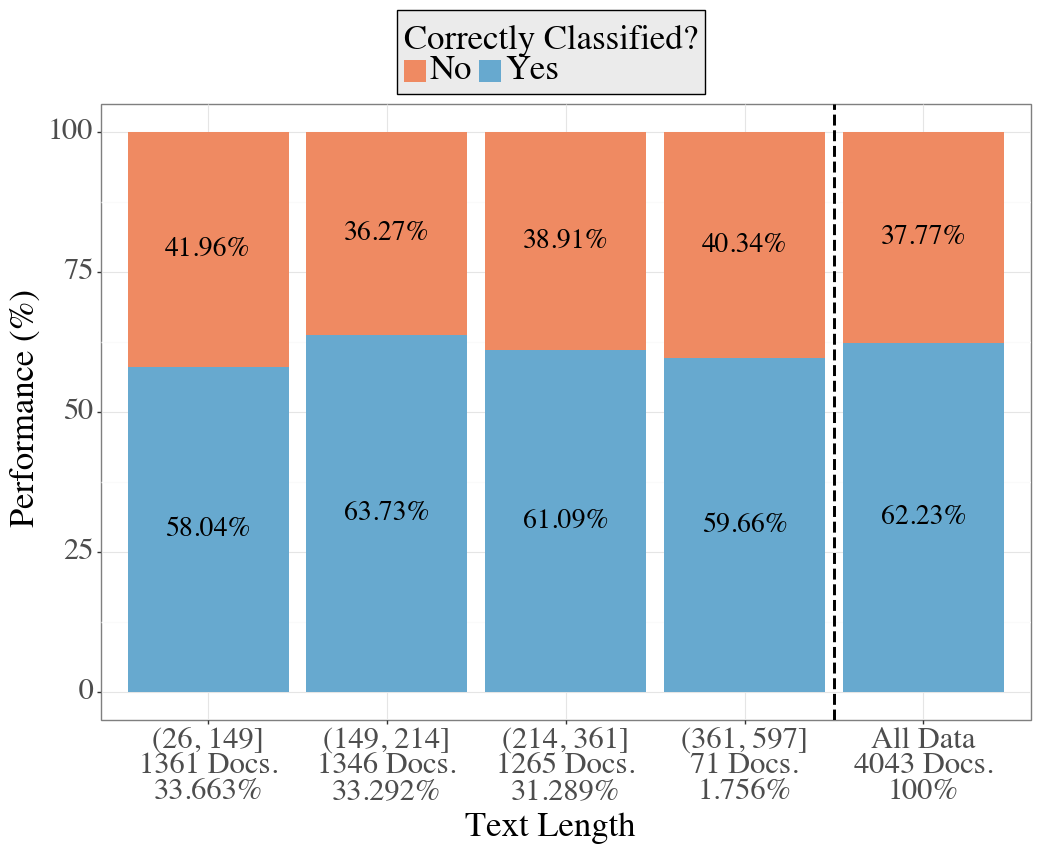



 IMDb-1k


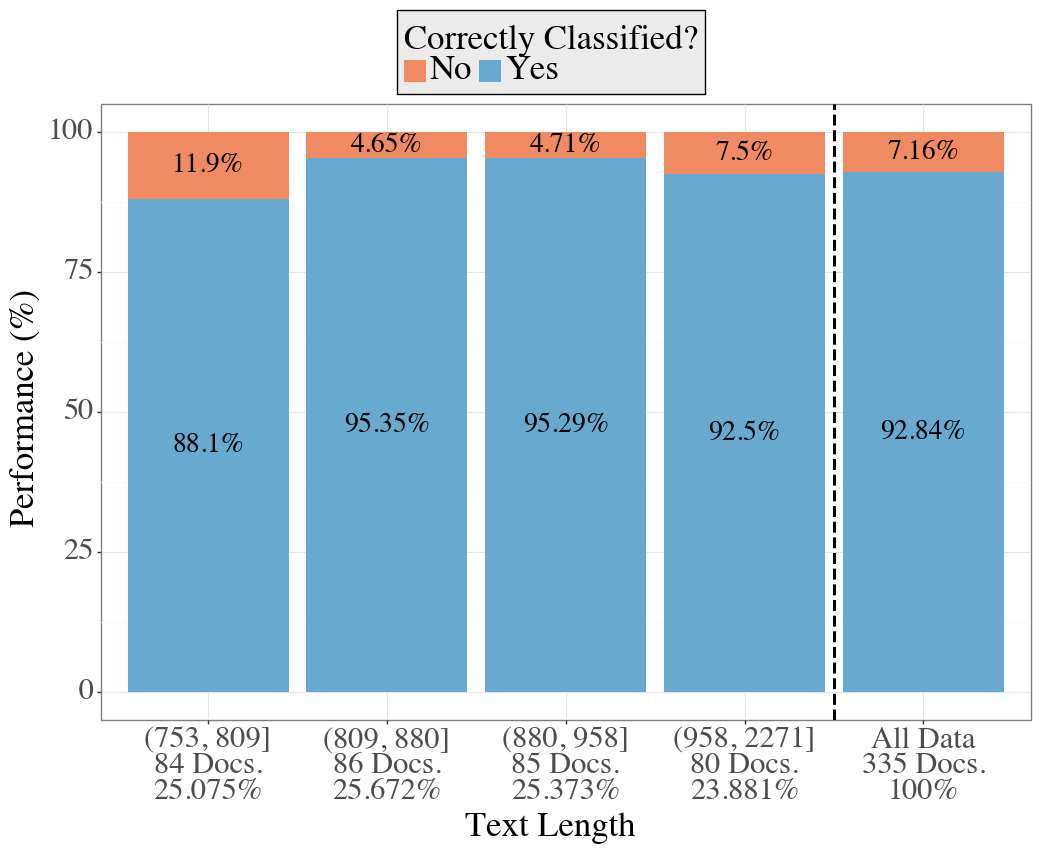

In [246]:
for method in ['Grouped', 'Surrogate']:
  print('-' * 75, method, '-' * 75)
  for dataset, target_metric, cutting_points in zip(['SST-2', 'R8', 'Ohsumed', 'IMDb-1k'], ['accuracy', 'f1_score', 'f1_score', 'accuracy'], PLM_intervals['BERT']):
    print('\n', dataset)
    plot = error_dependence_plot(
      df = individual_predictions_using_BERT[(individual_predictions_using_BERT['dataset'] == dataset) & (individual_predictions_using_BERT['method'] == method)].drop(columns = ['dataset']),
      column_name = 'Text Length',
      target_metric = target_metric,
      cutting_points = cutting_points
    )
    print(plot)
    if dataset == 'IMDb-1k':
      plot.save(filename = f'./paper_figures/BERT_{method}_EDP_{dataset}.png', dpi = 300)

### Our Method (BART-L)

In [247]:
individual_predictions_using_BART_L = get_individual_predictions(
  datasets = ['SST-2', 'Ohsumed', 'R8', 'IMDb-top_1000'],
  gnns = ['GATv2'],
  PLMs = ['facebook-bart-large'],
  methods = ['Grouped', 'Surrogate'],
  aggregations = ['No_Aggregation']
)
individual_predictions_using_BART_L = pd.merge(
  individual_predictions_using_BART_L[(individual_predictions_using_BART_L['random_state'] == '42') & (individual_predictions_using_BART_L['split'] == 'test')],
  text_length_df,
  on = ['dataset', 'split', 'index']
).drop(columns = ['index']).rename(columns = {'length' : 'Text Length'})[['dataset', 'method', 'Text Length', 'real', 'prediction']]
individual_predictions_using_BART_L['dataset'] = individual_predictions_using_BART_L['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

--------------------------------------------------------------------------- Grouped ---------------------------------------------------------------------------

 SST-2


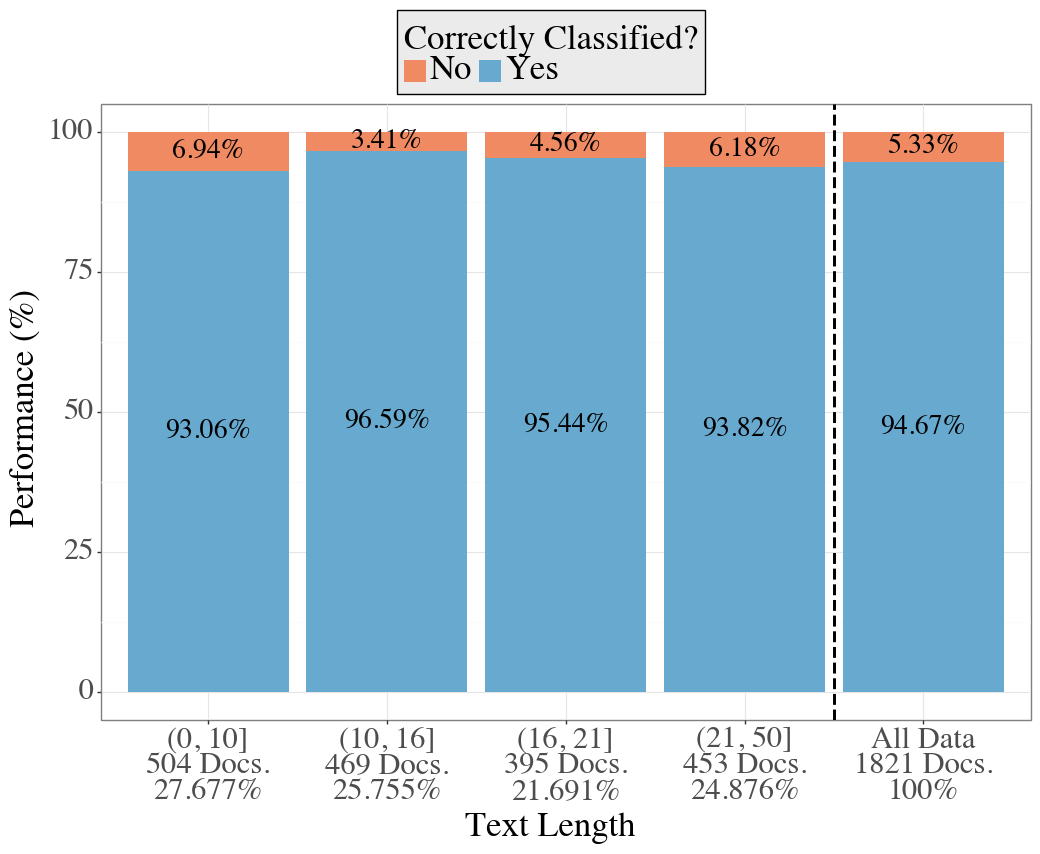



 R8


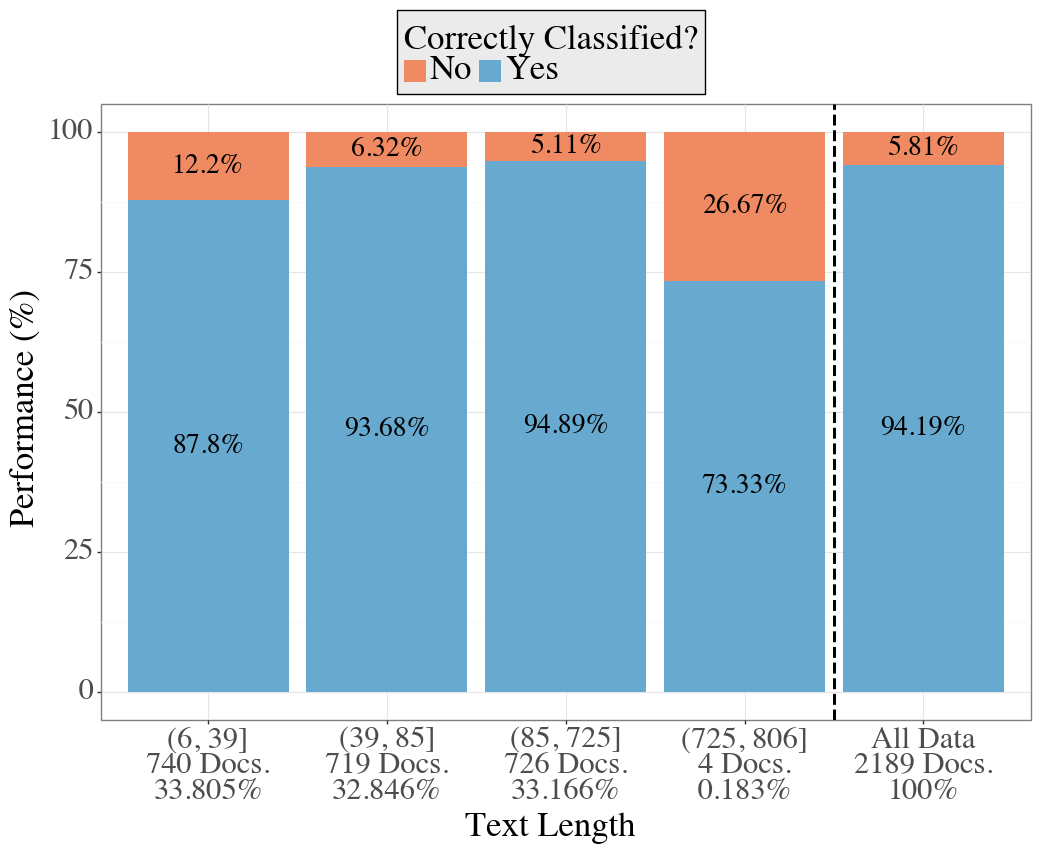



 Ohsumed


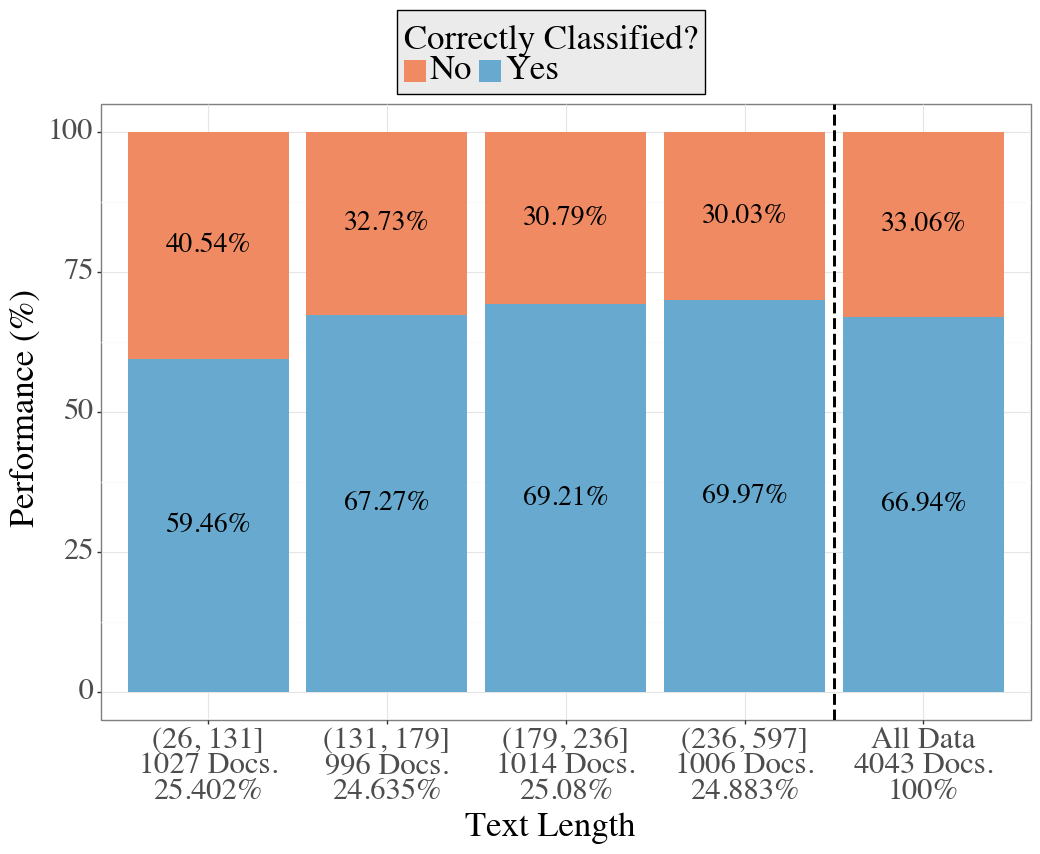



 IMDb-1k


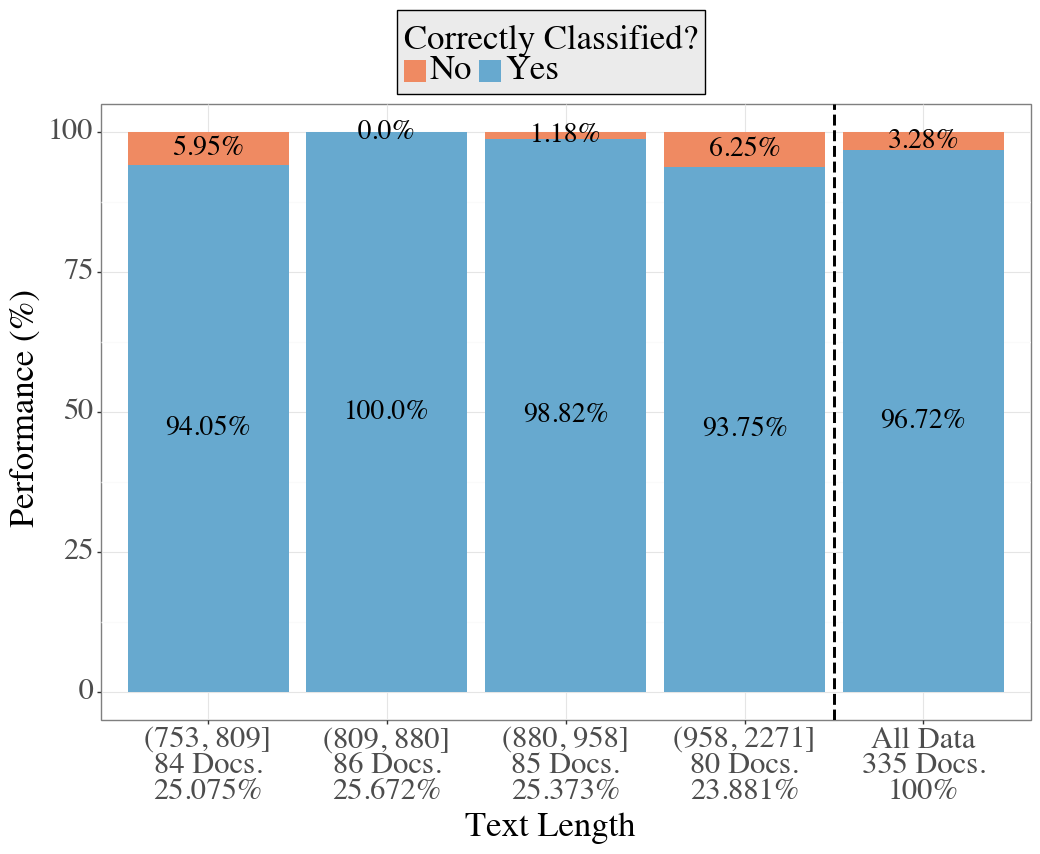


--------------------------------------------------------------------------- Surrogate ---------------------------------------------------------------------------

 SST-2


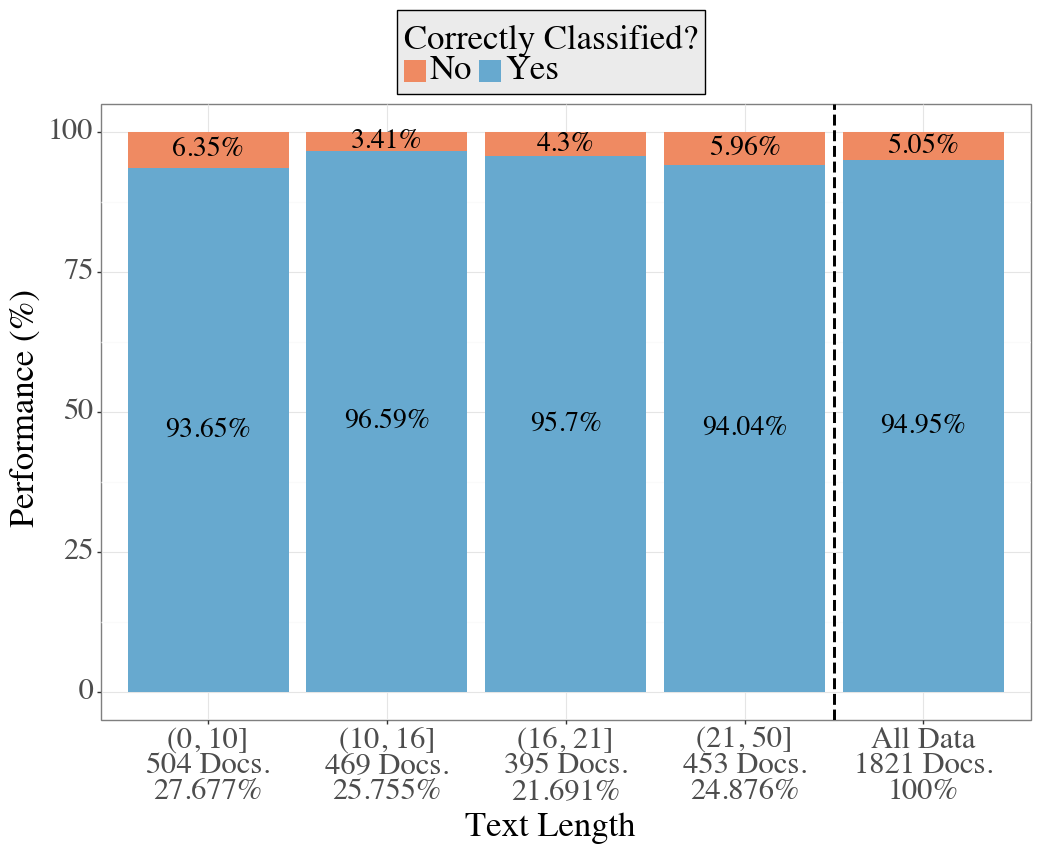



 R8


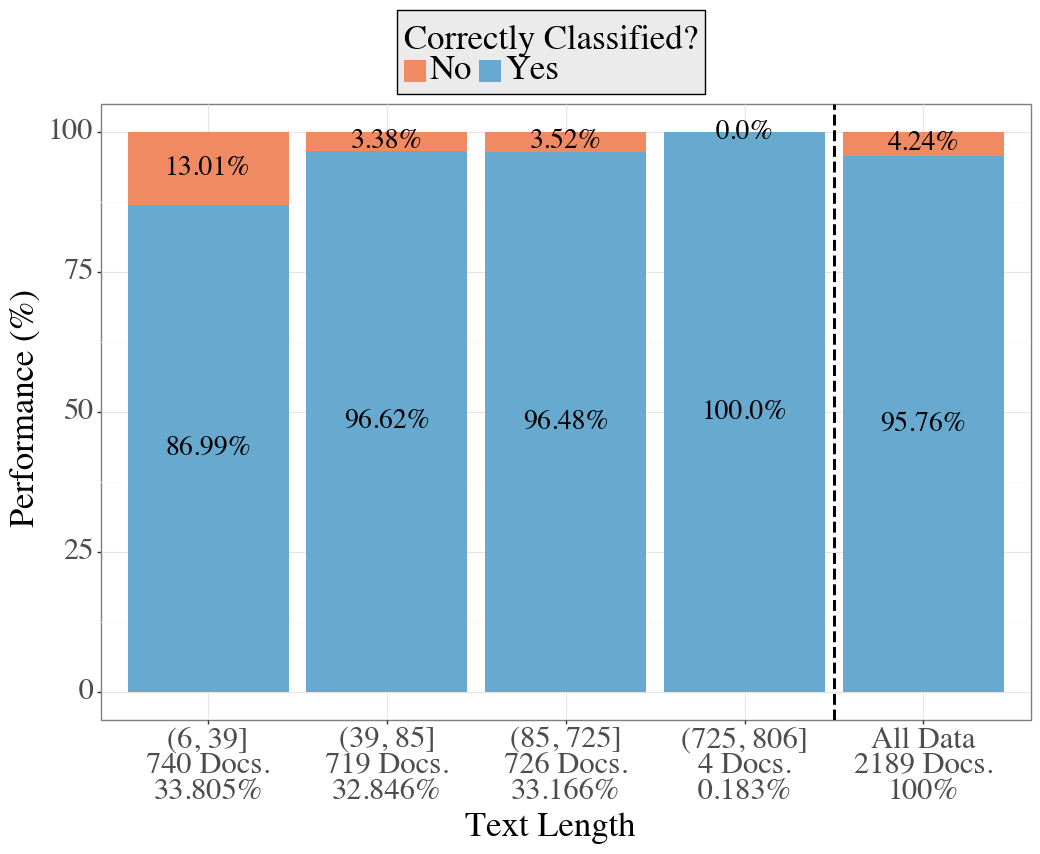



 Ohsumed


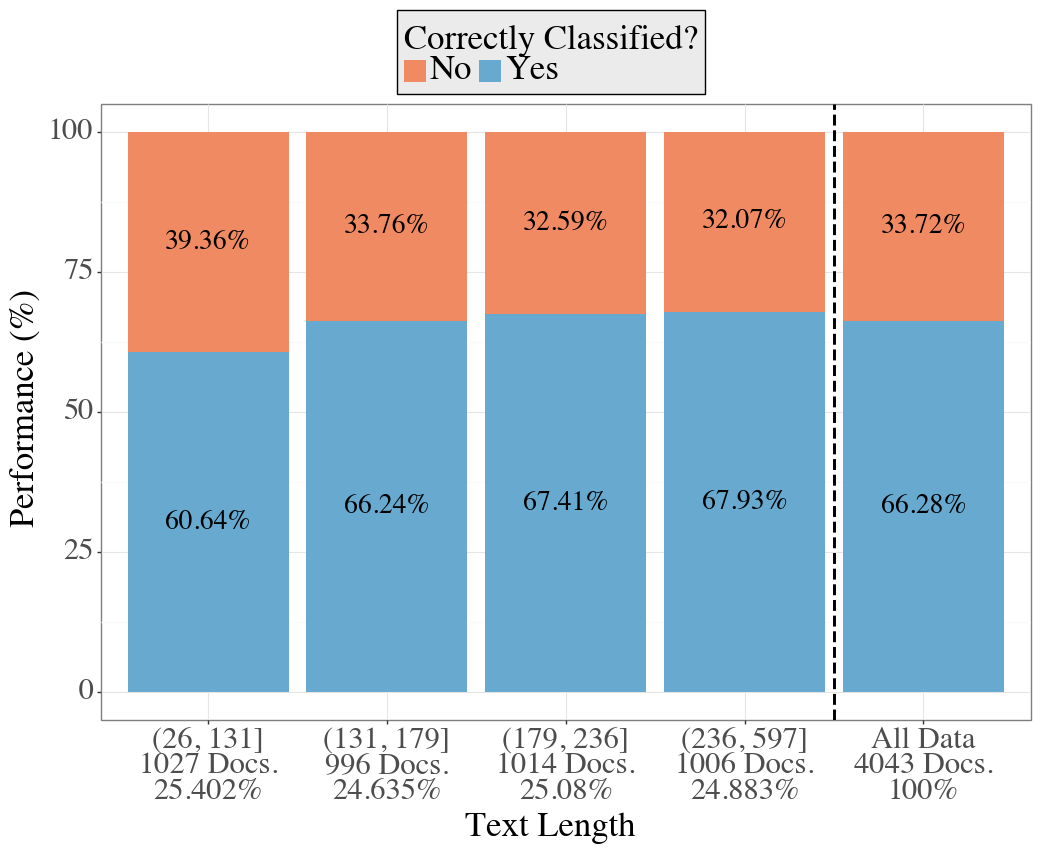



 IMDb-1k


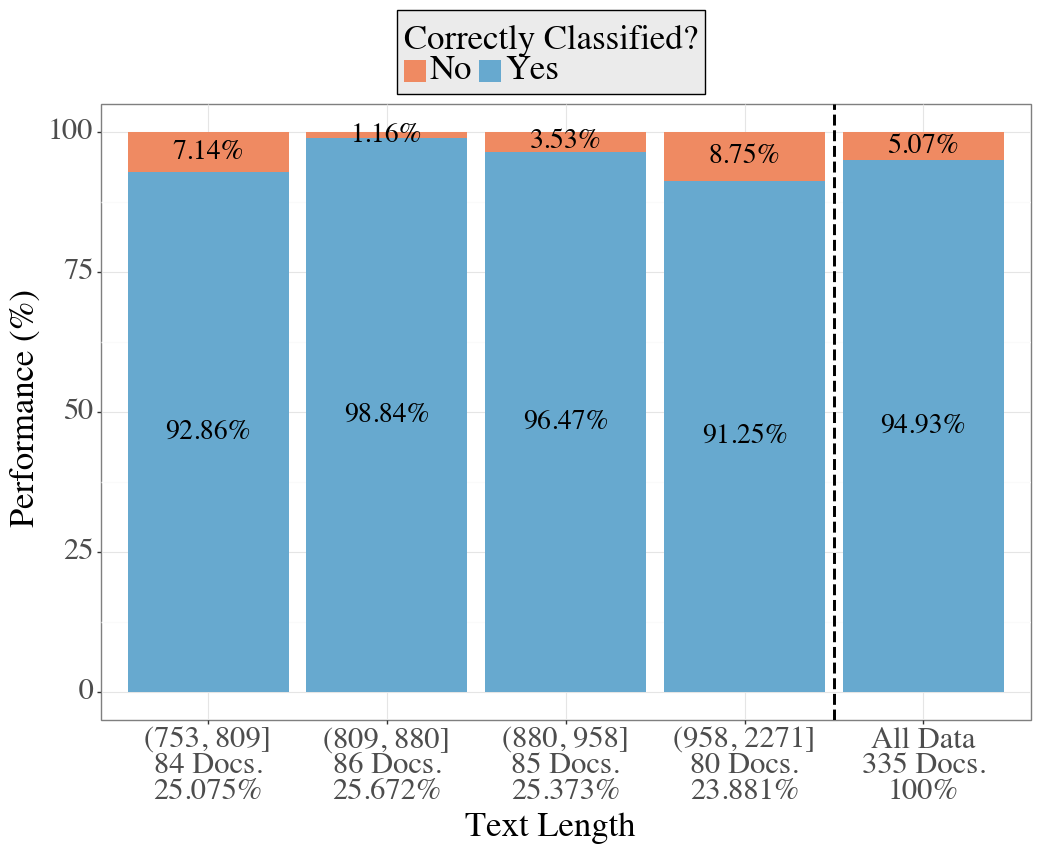

In [248]:
for method in ['Grouped', 'Surrogate']:
  print('-' * 75, method, '-' * 75)
  for dataset, target_metric, cutting_points in zip(['SST-2', 'R8', 'Ohsumed', 'IMDb-1k'], ['accuracy', 'f1_score', 'f1_score', 'accuracy'], PLM_intervals['BART-L']):
    print('\n', dataset)
    plot = error_dependence_plot(
      df = individual_predictions_using_BART_L[(individual_predictions_using_BART_L['dataset'] == dataset) & (individual_predictions_using_BART_L['method'] == method)].drop(columns = ['dataset']),
      column_name = 'Text Length',
      target_metric = target_metric,
      cutting_points = cutting_points
    )
    print(plot)
    if dataset in ['R8', 'IMDb-1k']:
      plot.save(filename = f'./paper_figures/BART_L_{method}_EDP_{dataset}.png', dpi = 300)

### Sliding Windows

In [249]:
individual_predictions_using_sliding_windows = get_individual_predictions_sliding_windows(
  datasets = ['SST-2', 'Ohsumed', 'R8', 'IMDb-top_1000'],
  gnns = ['GATv2'],
  PLMs = ['facebook-bart-large'],
  methods = ['Grouped'],
)
individual_predictions_using_sliding_windows = pd.merge(
  individual_predictions_using_sliding_windows[(individual_predictions_using_sliding_windows['random_state'] == '42') & (individual_predictions_using_sliding_windows['split'] == 'test')],
  text_length_df,
  on = ['dataset', 'split', 'index']
).drop(columns = ['index']).rename(columns = {'length' : 'Text Length'})[['dataset', 'Text Length', 'real', 'prediction']]
individual_predictions_using_sliding_windows['dataset'] = individual_predictions_using_sliding_windows['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})


 SST-2


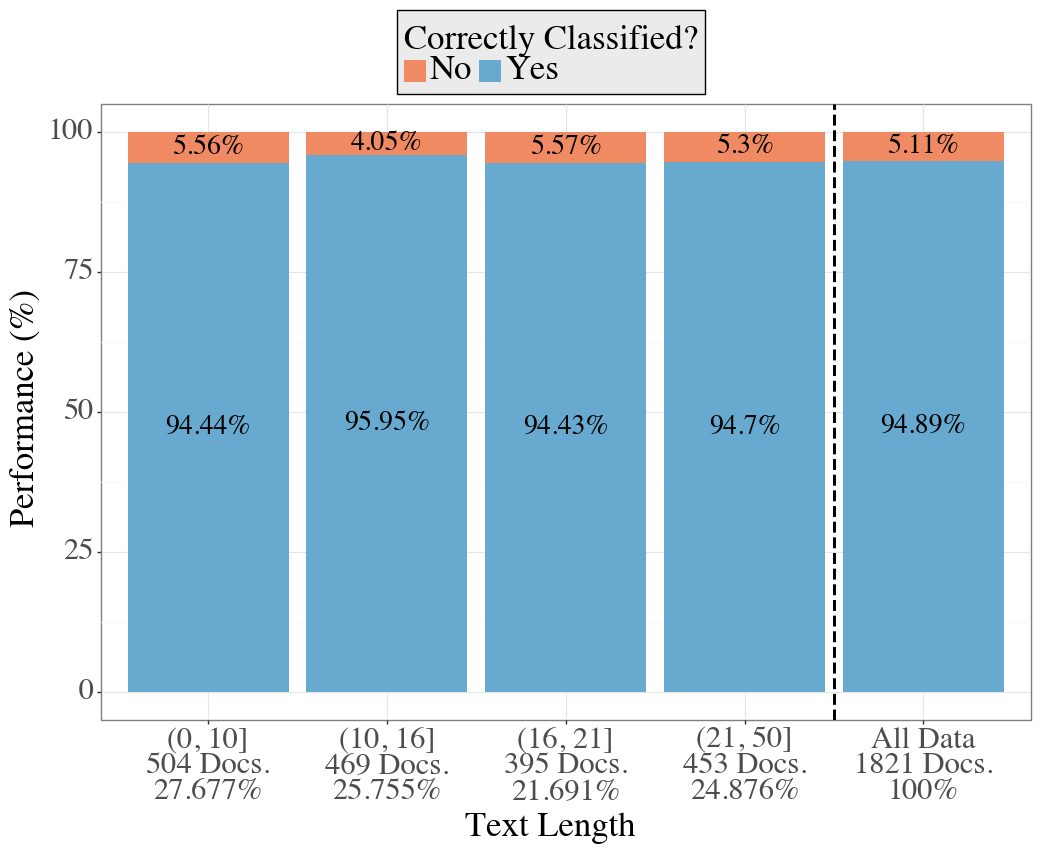



 R8


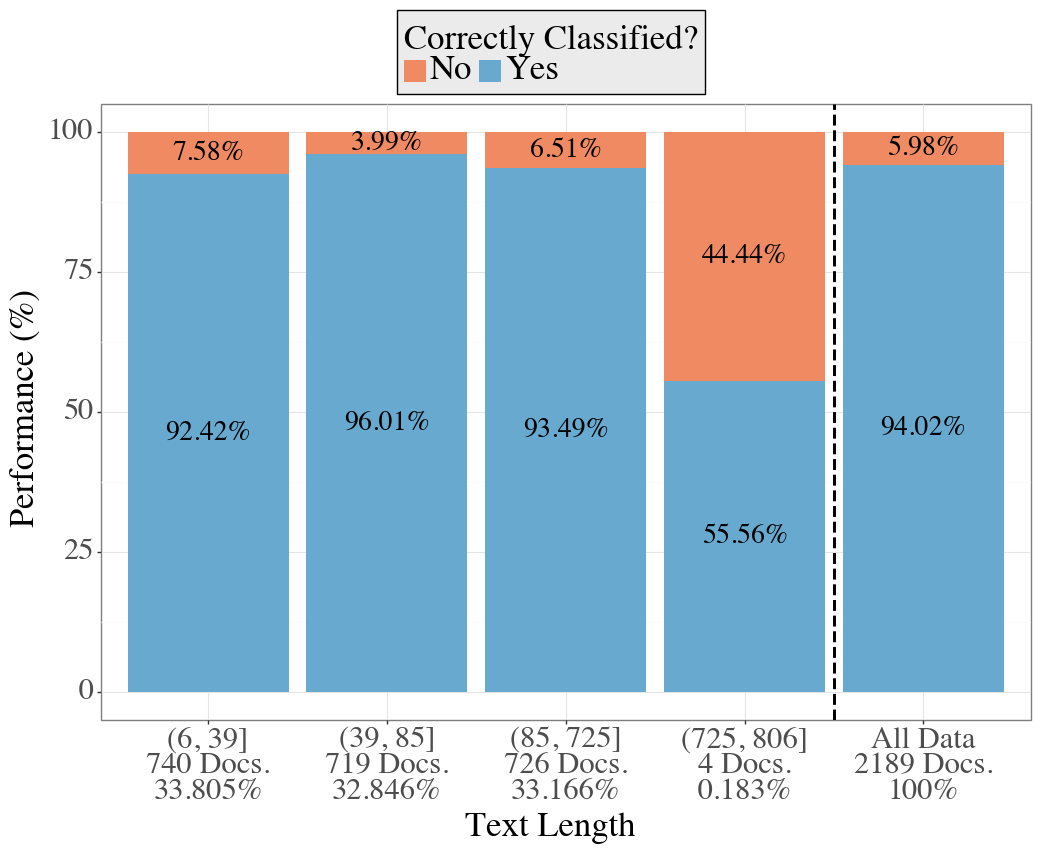



 Ohsumed


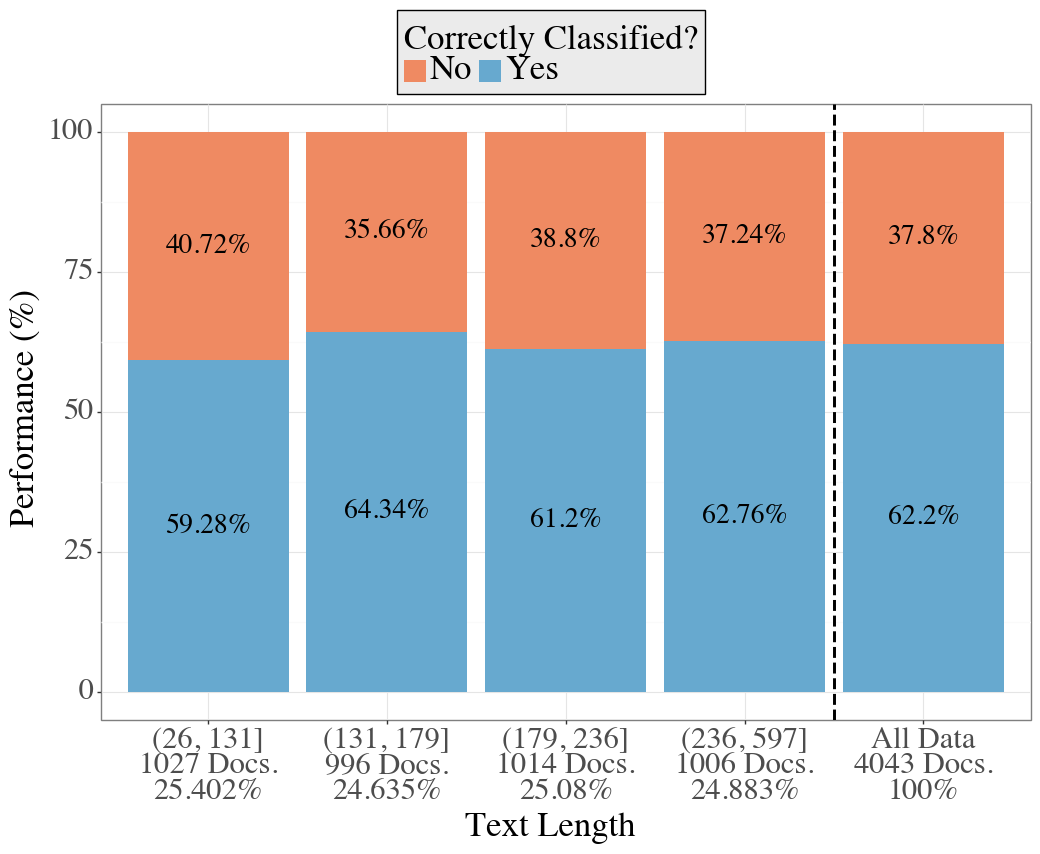



 IMDb-1k


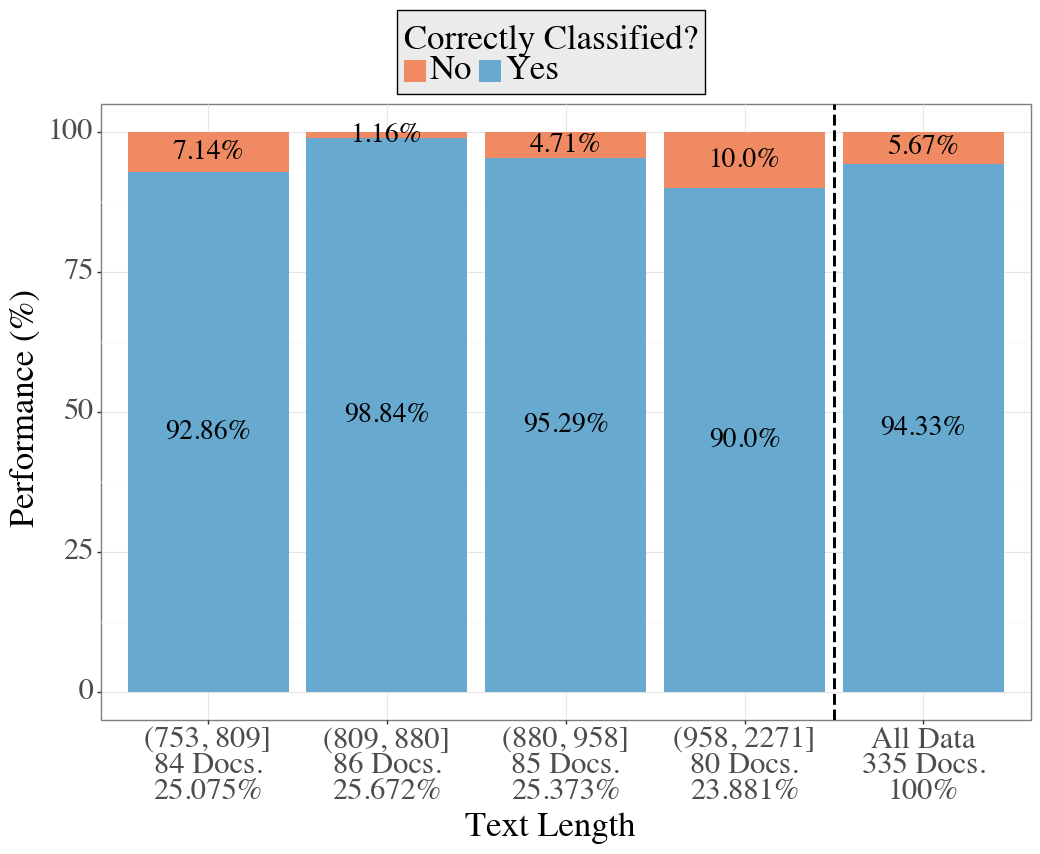

In [250]:
for dataset, target_metric, cutting_points in zip(['SST-2', 'R8', 'Ohsumed', 'IMDb-1k'], ['accuracy', 'f1_score', 'f1_score', 'accuracy'], PLM_intervals['BART-L']):
  print('\n', dataset)
  plot = error_dependence_plot(
    df = individual_predictions_using_sliding_windows[individual_predictions_using_sliding_windows['dataset'] == dataset].drop(columns = ['dataset']),
    column_name = 'Text Length',
    target_metric = target_metric,
    cutting_points = cutting_points
  )
  print(plot)
  if dataset in ['R8', 'IMDb-1k']:
    plot.save(filename = f'./paper_figures/BART_L_sliding_windows_EDP_{dataset}.png', dpi = 300)

# Analysis of Important Hyper-parameters

In [251]:
def load_trials(dataset, gnn, llm, method, aggregation):
  
  study_name = f'{dataset}-{gnn}-{llm.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  return study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).reset_index(drop = True)

In [252]:
def get_hyperparameter_importance(dataset, gnn, llm, method, aggregation):
  
  study_name = f'{dataset}-{gnn}-{llm.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  return optuna.importance.get_param_importances(study)

In [253]:
def get_all_hyperparameter_importances(datasets, gnns, llms, methods, aggregations):
  l = list()
  for dataset in datasets:
    for gnn in gnns:
      for llm in llms:
        for method in methods:
          for aggregation in aggregations:
            l.append(
              pd.DataFrame.from_dict(
                get_hyperparameter_importance(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation),
                orient = 'index'
              ) \
              .reset_index(names = ['variable']) \
              .rename(columns = {0 : 'importance'}) \
              .assign(
                dataset = dataset,
                gnn = gnn,
                llm = llm,
                method = method,
                aggregation = aggregation 
              )
            )
  return pd.concat(l)

## Hyper-parameter Importance Estimates

In [254]:
bart_L_hyperparameter_importance_df = get_all_hyperparameter_importances(
  datasets = ['IMDb-top_1000', 'Ohsumed', 'R8', 'SST-2'],
  gnns = ['GATv2'],
  llms = ['facebook-bart-large'],
  methods = ['Grouped', 'Surrogate'],
  aggregations = ['No_Aggregation']
)
bart_L_hyperparameter_importance_df['dataset'] = bart_L_hyperparameter_importance_df['dataset'].replace({
  'IMDb-top_1000' : 'IMDb-1k'
})

In [255]:
bart_L_hyperparameter_importance_df['variable'] = bart_L_hyperparameter_importance_df['variable'].replace({
  'left_stride' : 'Left Stride',
  'right_stride' : 'Right Stride',
  'attention_pooling_operation' : 'Attention Pooling',
  'embedding_pooling_operation' : 'Embedding Pooling',
  'threshold' : 'Threshold',
  'batch_size' : 'Batch Size',
  'hidden_dimension' : 'Hidden Dimension',
  'dropout_rate' : 'Dropout Rate',
  'attention_heads' : 'Attention Heads',
  'number_of_hidden_layers' : 'Hidden Layers',
  'epochs' : 'Epochs',
  'global_pooling' : 'Global Pooling',
  'early_stopping_patience' : 'Early Stopping Patience',
  'plateau_patience' : 'Plateau Patience',
  'plateau_divider' : 'Plateau Divider',
  'learning_rate' : 'Learning Rate',
  'weight_decay' : 'Weight Decay',
  'beta_0' : 'β0',
  'beta_1' : 'β1',
  'epsilon' : 'ε',
  'balanced_loss' : 'Balanced Loss?'
})

In [256]:
bart_L_hyperparameter_importance_df['variable'] = pd.Categorical(bart_L_hyperparameter_importance_df['variable'], categories = list(reversed(['Left Stride', 'Right Stride', 'Attention Pooling', 'Embedding Pooling', 'Threshold', 'Batch Size', 'Hidden Dimension', 'Dropout Rate', 'Attention Heads', 'Hidden Layers', 'Epochs', 'Global Pooling', 'Early Stopping Patience', 'Plateau Patience', 'Plateau Divider', 'Learning Rate', 'Weight Decay', 'β0', 'β1', 'ε', 'Balanced Loss?'])))

In [257]:
plot = p9.ggplot(bart_L_hyperparameter_importance_df,
  p9.aes(x = 'variable', y = 'importance', fill = 'method')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Hyper-parameter') + \
  p9.ylab('Importance Estimate') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.labs(fill = 'Variant') + \
  p9.facet_wrap('~ method', ncol = 2) + \
  p9.coord_flip() + \
  p9.theme(
    legend_position = 'none',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

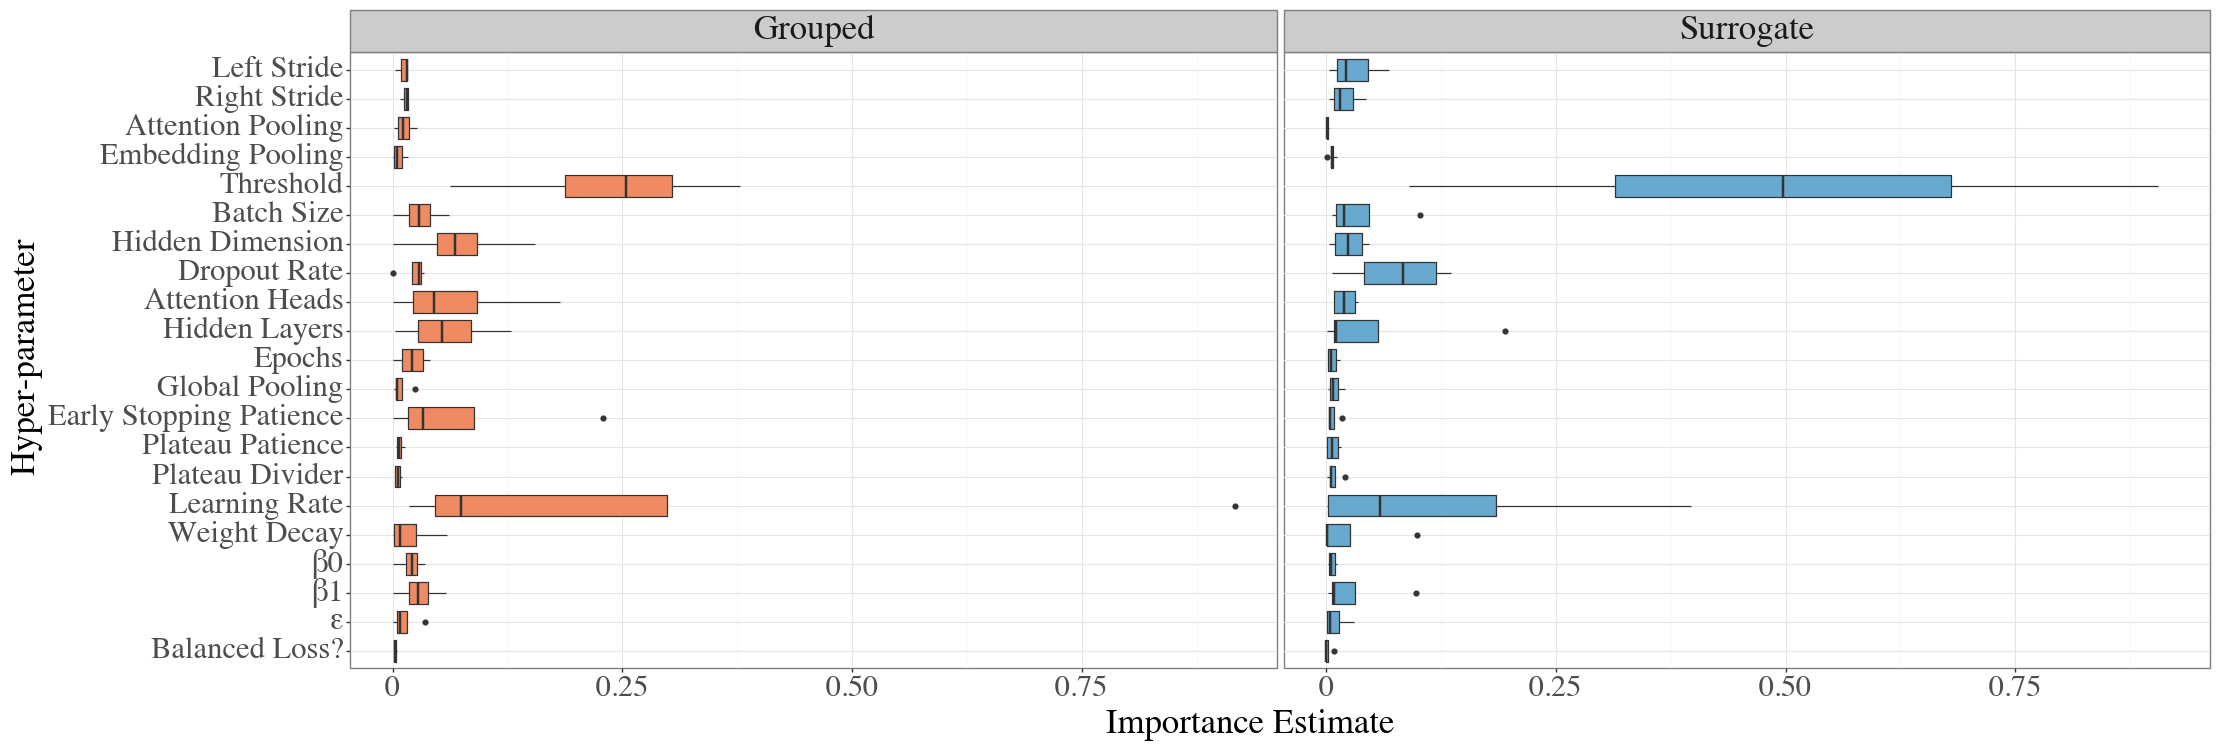

<ggplot: (811928093)>

In [258]:
plot

In [259]:
plot.save(filename = './paper_figures/BART_L_hyperparameter_importance.png', dpi = 300)

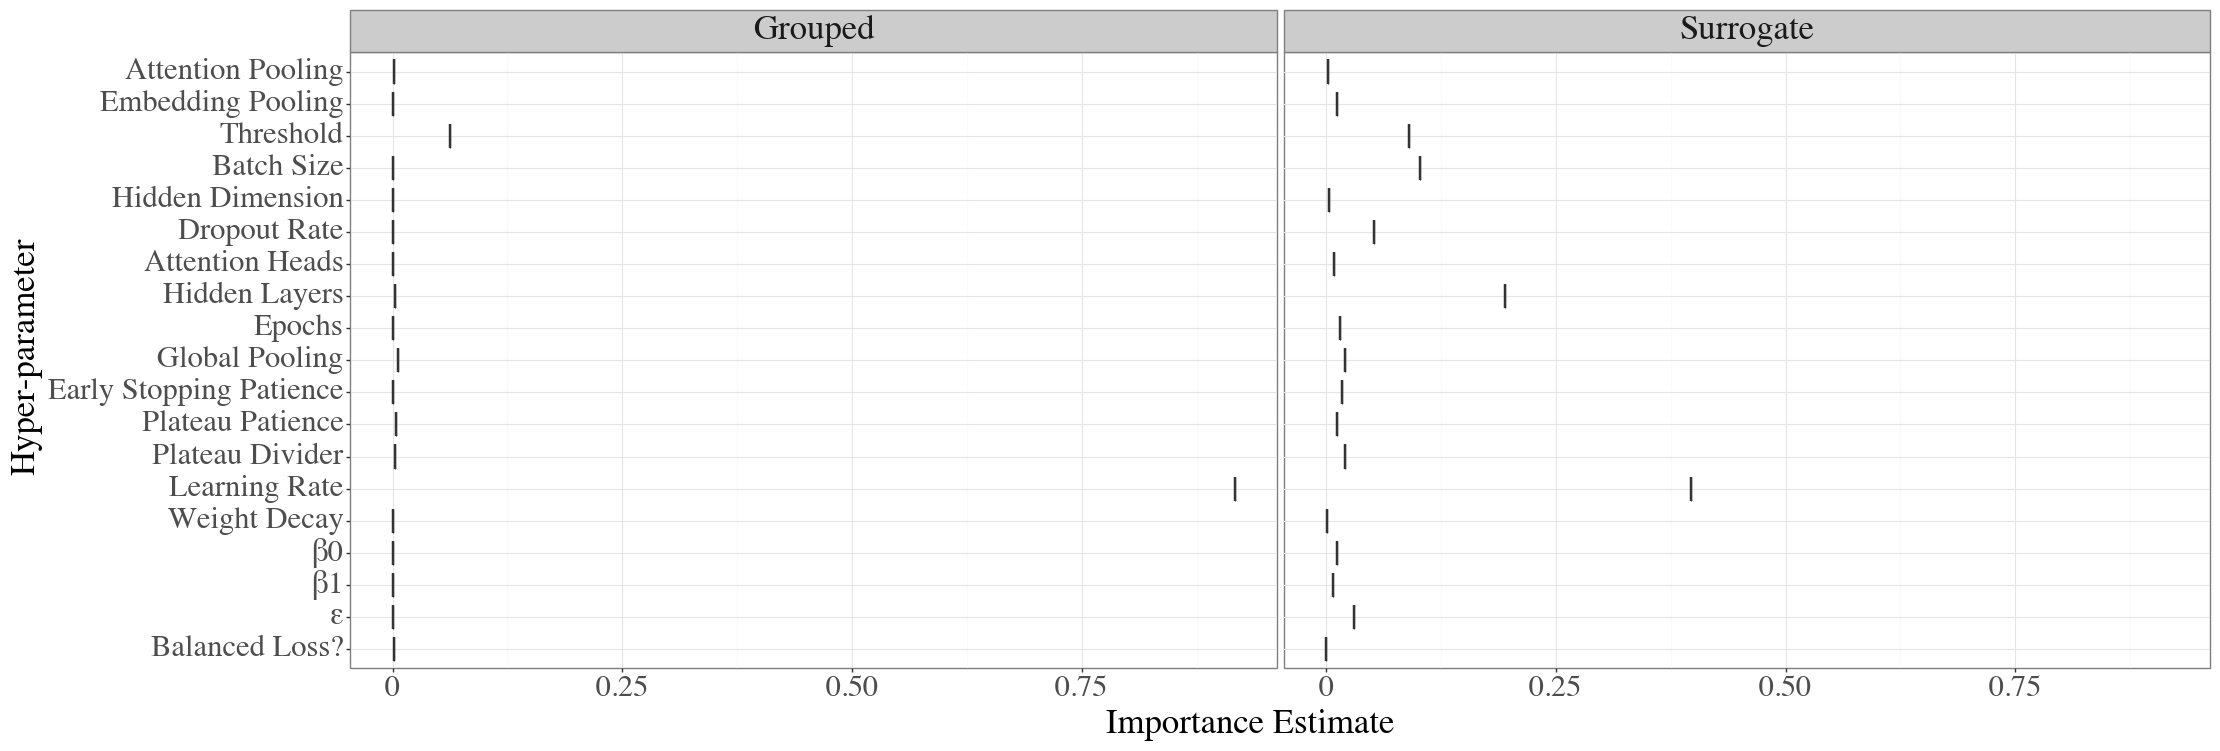

<ggplot: (813679346)>

In [260]:
p9.ggplot(bart_L_hyperparameter_importance_df[bart_L_hyperparameter_importance_df['dataset'] == 'SST-2'],
  p9.aes(x = 'variable', y = 'importance', fill = 'method')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Hyper-parameter') + \
  p9.ylab('Importance Estimate') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.labs(fill = 'Variant') + \
  p9.facet_wrap('~ method', ncol = 2) + \
  p9.coord_flip() + \
  p9.theme(
    legend_position = 'none',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
  )

## Visualization of Hyper-parameters

In [261]:
bart_L_trials_df = pd.concat([
  load_trials(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Grouped', aggregation = 'No_Aggregation').reset_index(names = 'rank').assign(dataset = 'IMDb-1k', method = 'Grouped'),
  load_trials(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Grouped', aggregation = 'No_Aggregation').reset_index(names = 'rank').assign(dataset = 'Ohsumed', method = 'Grouped'),
  load_trials(dataset = 'R8', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Grouped', aggregation = 'No_Aggregation').reset_index(names = 'rank').assign(dataset = 'R8', method = 'Grouped'),
  load_trials(dataset = 'SST-2', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Grouped', aggregation = 'No_Aggregation').reset_index(names = 'rank').assign(dataset = 'SST-2', method = 'Grouped'),
  load_trials(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Surrogate', aggregation = 'No_Aggregation').reset_index(names = 'rank').assign(dataset = 'IMDb-1k', method = 'Surrogate'),
  load_trials(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Surrogate', aggregation = 'No_Aggregation').reset_index(names = 'rank').assign(dataset = 'Ohsumed', method = 'Surrogate'),
  load_trials(dataset = 'R8', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Surrogate', aggregation = 'No_Aggregation').reset_index(names = 'rank').assign(dataset = 'R8', method = 'Surrogate'),
  load_trials(dataset = 'SST-2', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Surrogate', aggregation = 'No_Aggregation').reset_index(names = 'rank').assign(dataset = 'SST-2', method = 'Surrogate')
])
bart_L_trials_df['params_left_stride'] = pd.Categorical(bart_L_trials_df['params_left_stride'], categories = [0, 32, 64, 128, 256])
bart_L_trials_df['params_right_stride'] = pd.Categorical(bart_L_trials_df['params_left_stride'], categories = [0, 32, 64, 128, 256])

In [262]:
bart_L_trials_df['params_embedding_pooling_operation'] = bart_L_trials_df['params_embedding_pooling_operation'].replace({
  'min' : 'Minimum',
  'mean' : 'Average',
  'max' : 'Maximum',
})
bart_L_trials_df['params_attention_pooling_operation'] = bart_L_trials_df['params_attention_pooling_operation'].replace({
  'min' : 'Minimum',
  'mean' : 'Average',
  'max' : 'Maximum',
})

### Pooling Operations

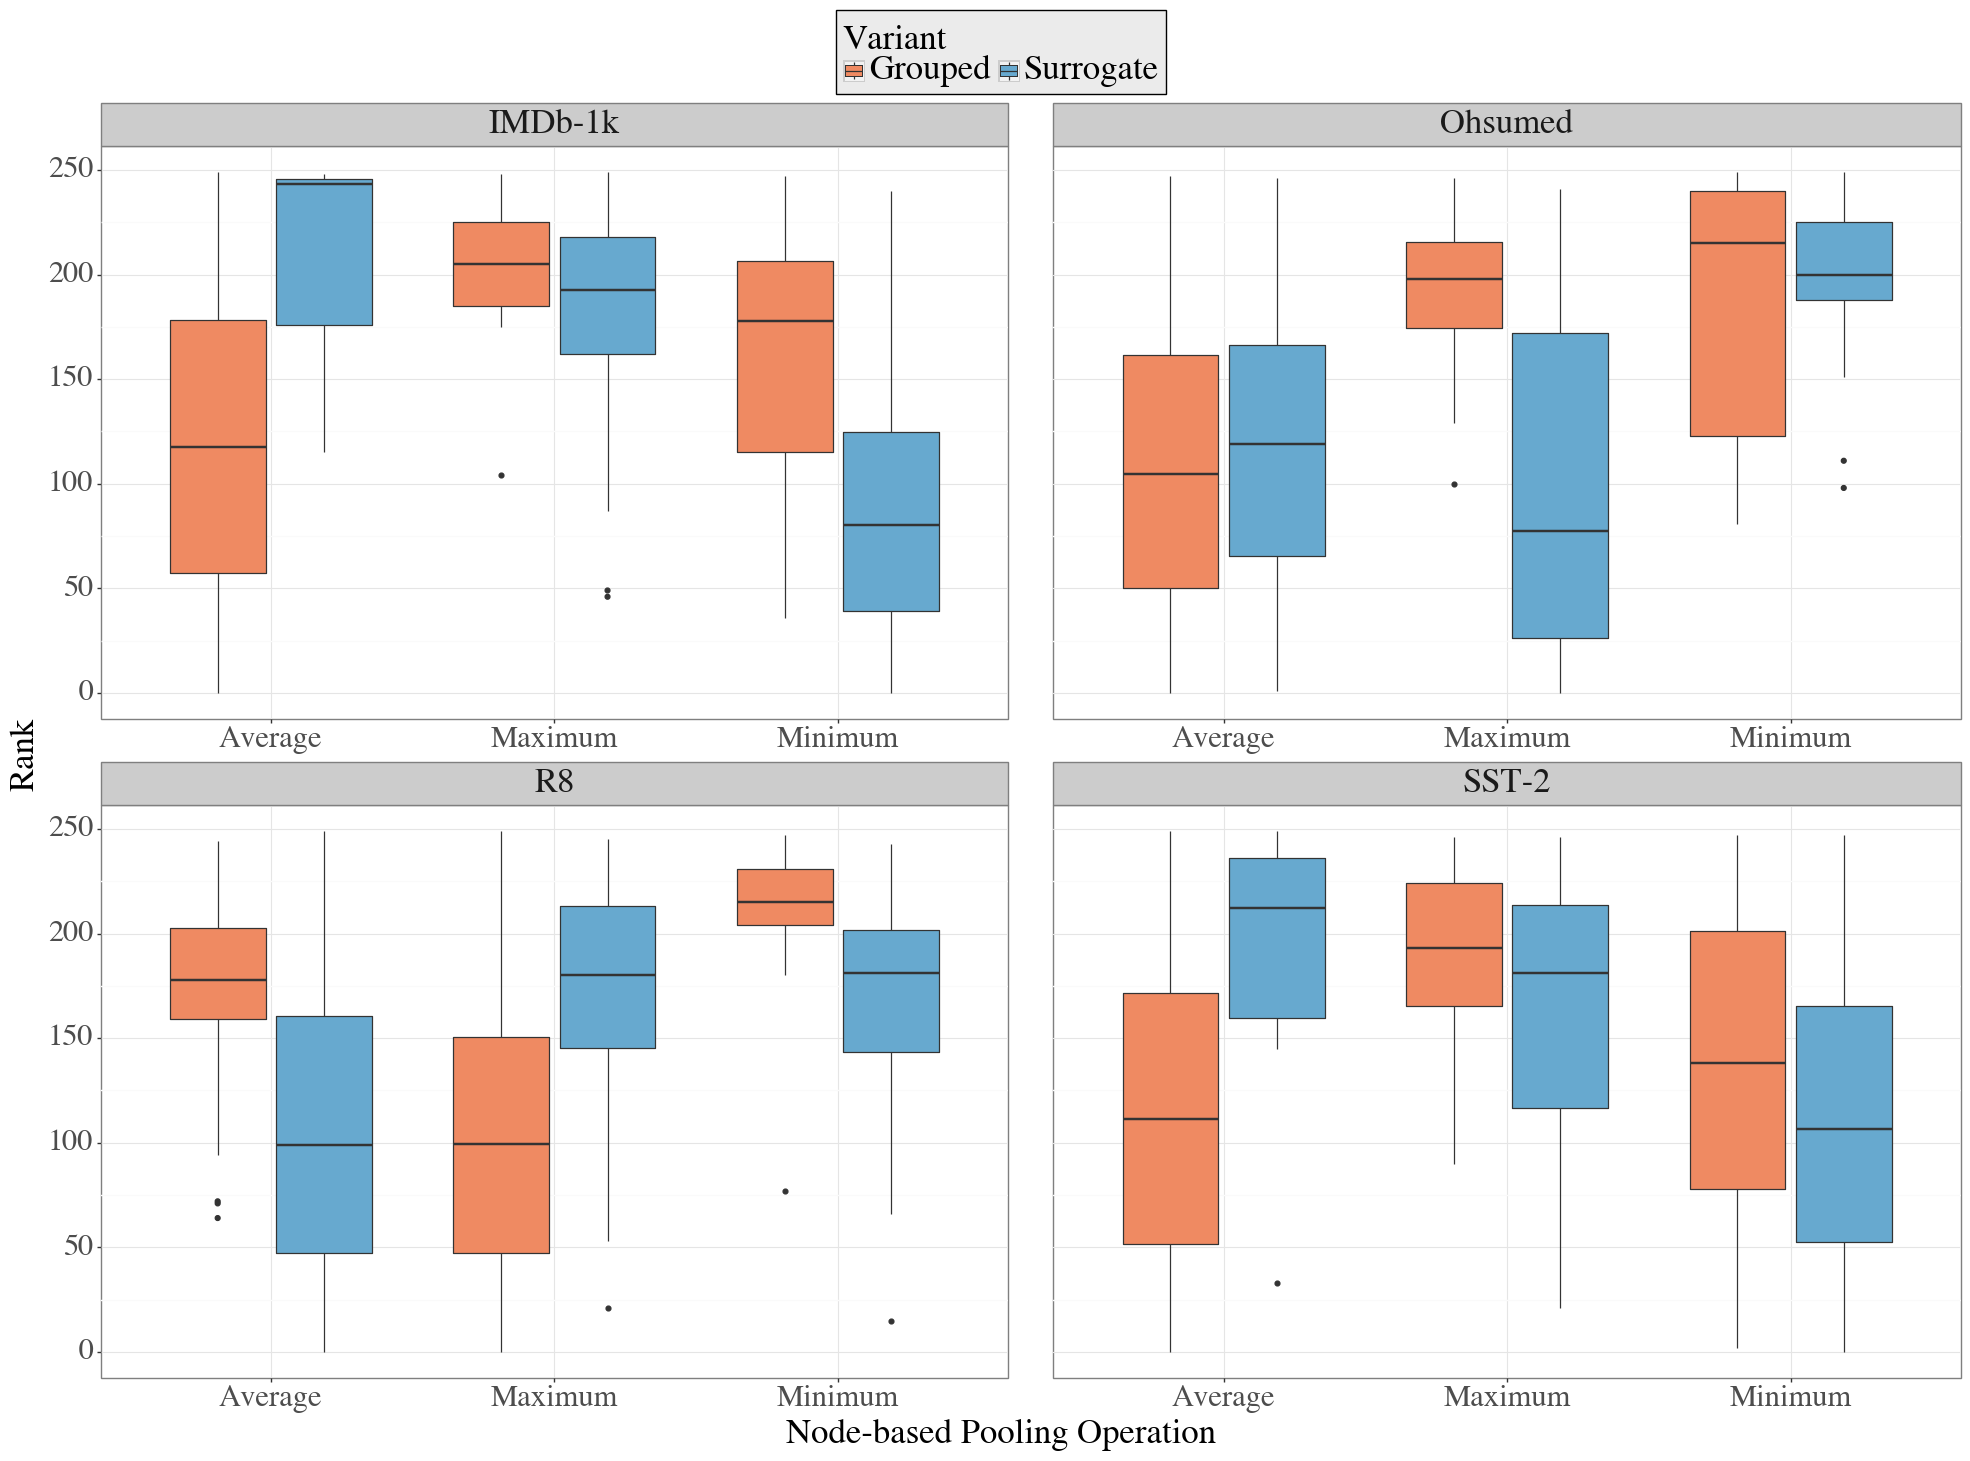

<ggplot: (821074770)>

In [263]:
p9.ggplot(bart_L_trials_df,
  p9.aes(x = 'params_embedding_pooling_operation', y = 'rank', fill = 'method')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Node-based Pooling Operation') + \
  p9.ylab('Rank') + \
  p9.facet_wrap('~dataset', ncol = 2, scales = 'free_x') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.labs(fill = 'Variant') + \
  p9.theme(
    legend_position = 'top',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 16),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
    subplots_adjust = {
      'hspace': 0.15,
      'wspace': 0.05
    }
  )

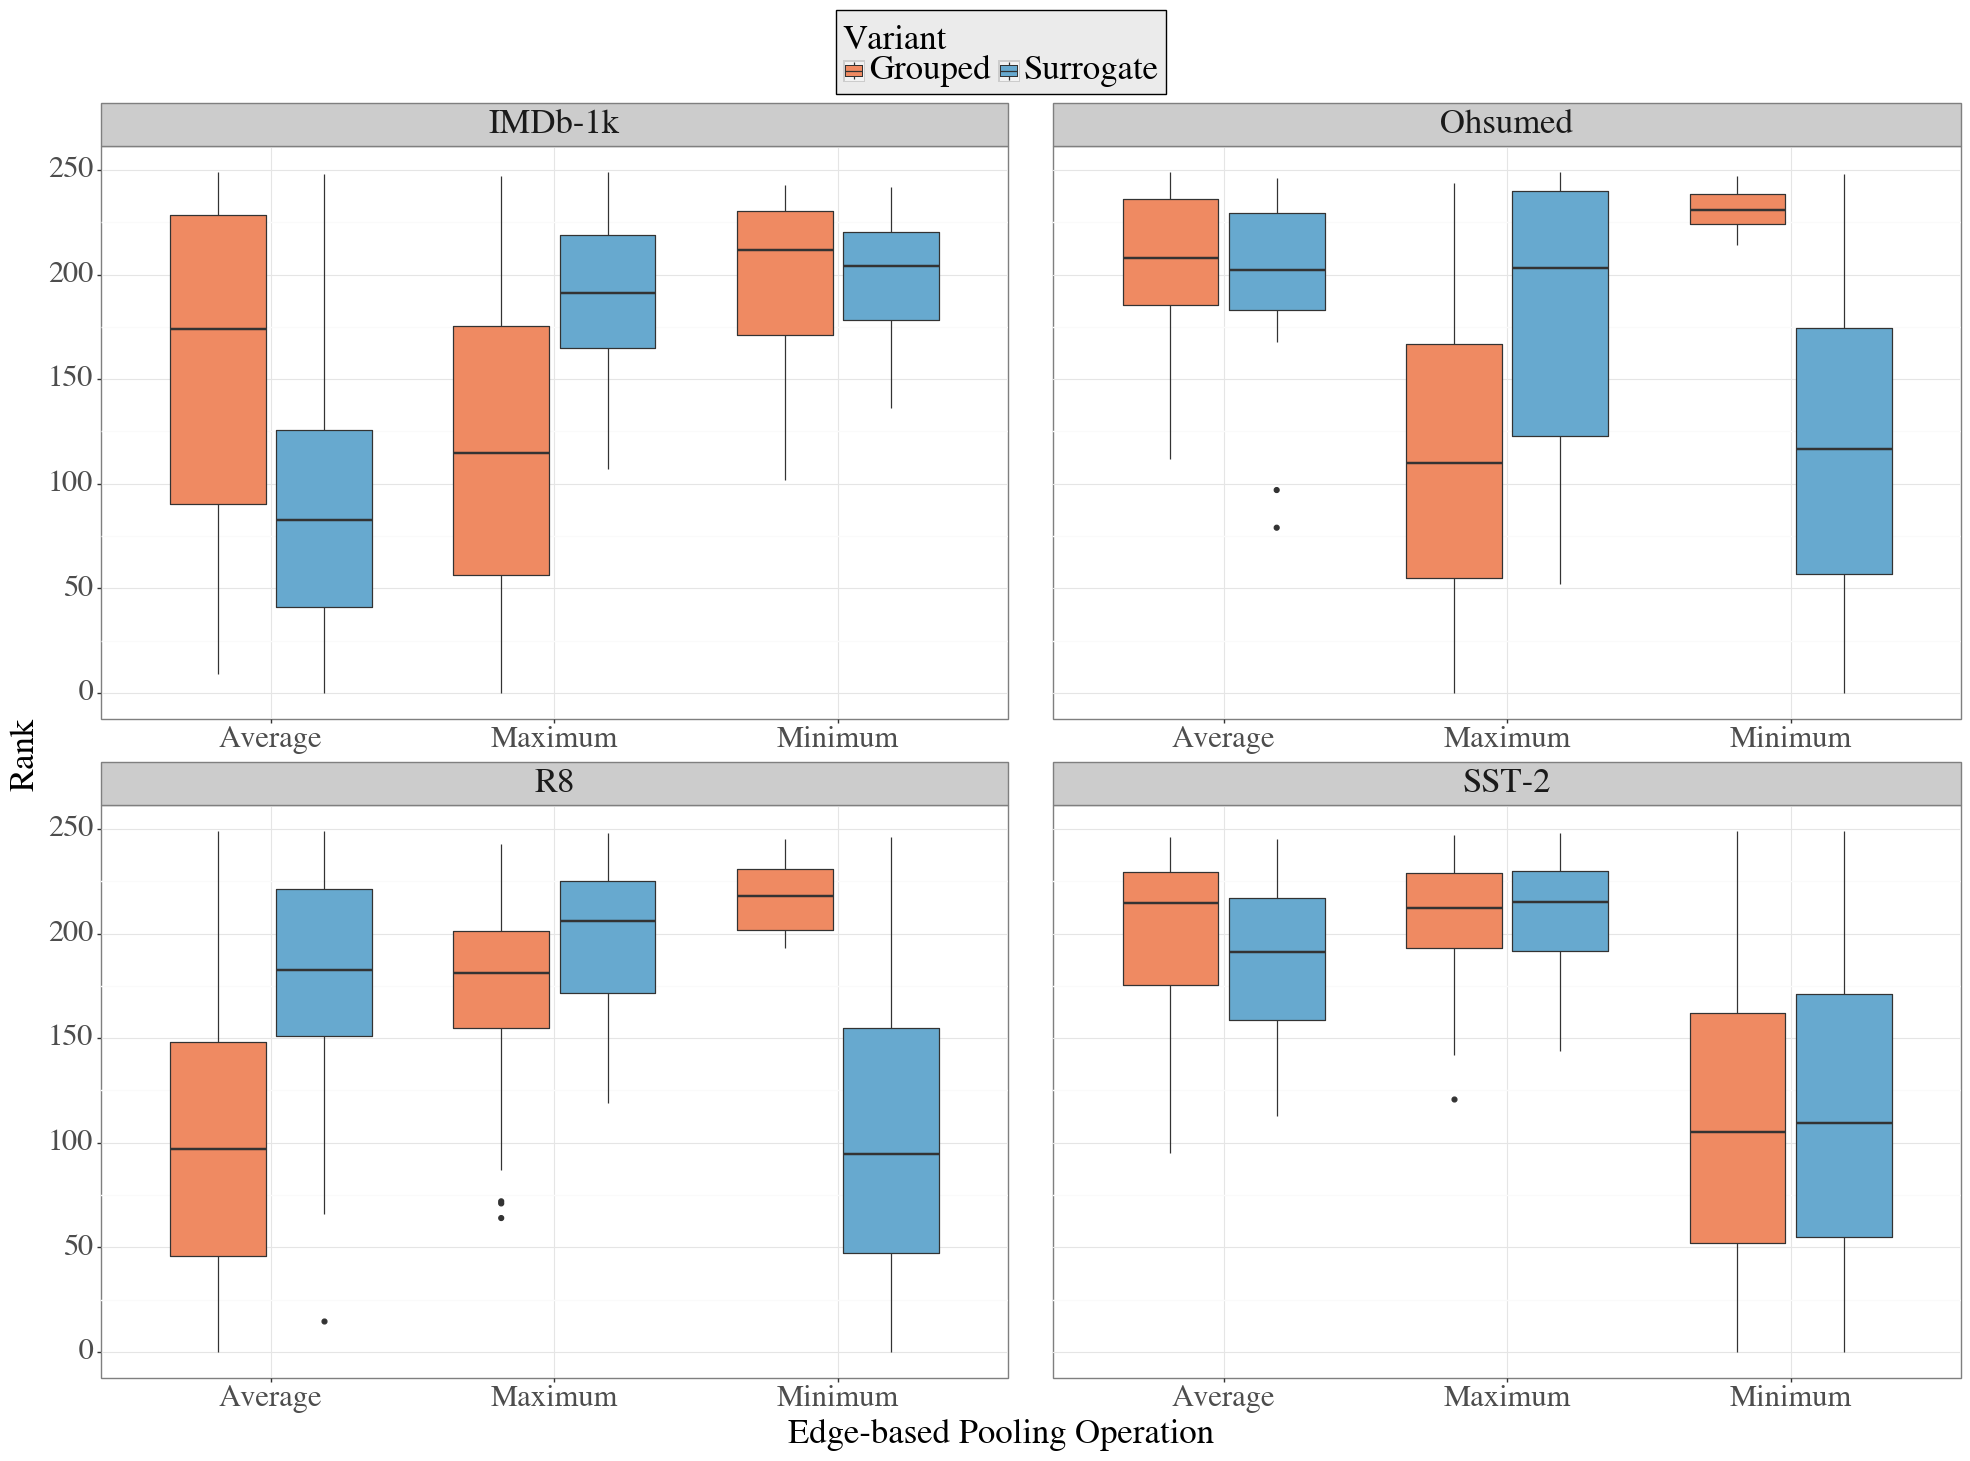

<ggplot: (813589384)>

In [264]:
p9.ggplot(bart_L_trials_df,
  p9.aes(x = 'params_attention_pooling_operation', y = 'rank', fill = 'method')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Edge-based Pooling Operation') + \
  p9.ylab('Rank') + \
  p9.facet_wrap('~dataset', ncol = 2, scales = 'free_x') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.labs(fill = 'Variant') + \
  p9.theme(
    legend_position = 'top',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 16),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
    subplots_adjust = {
      'hspace': 0.15,
      'wspace': 0.05
    }
  )

### Padding

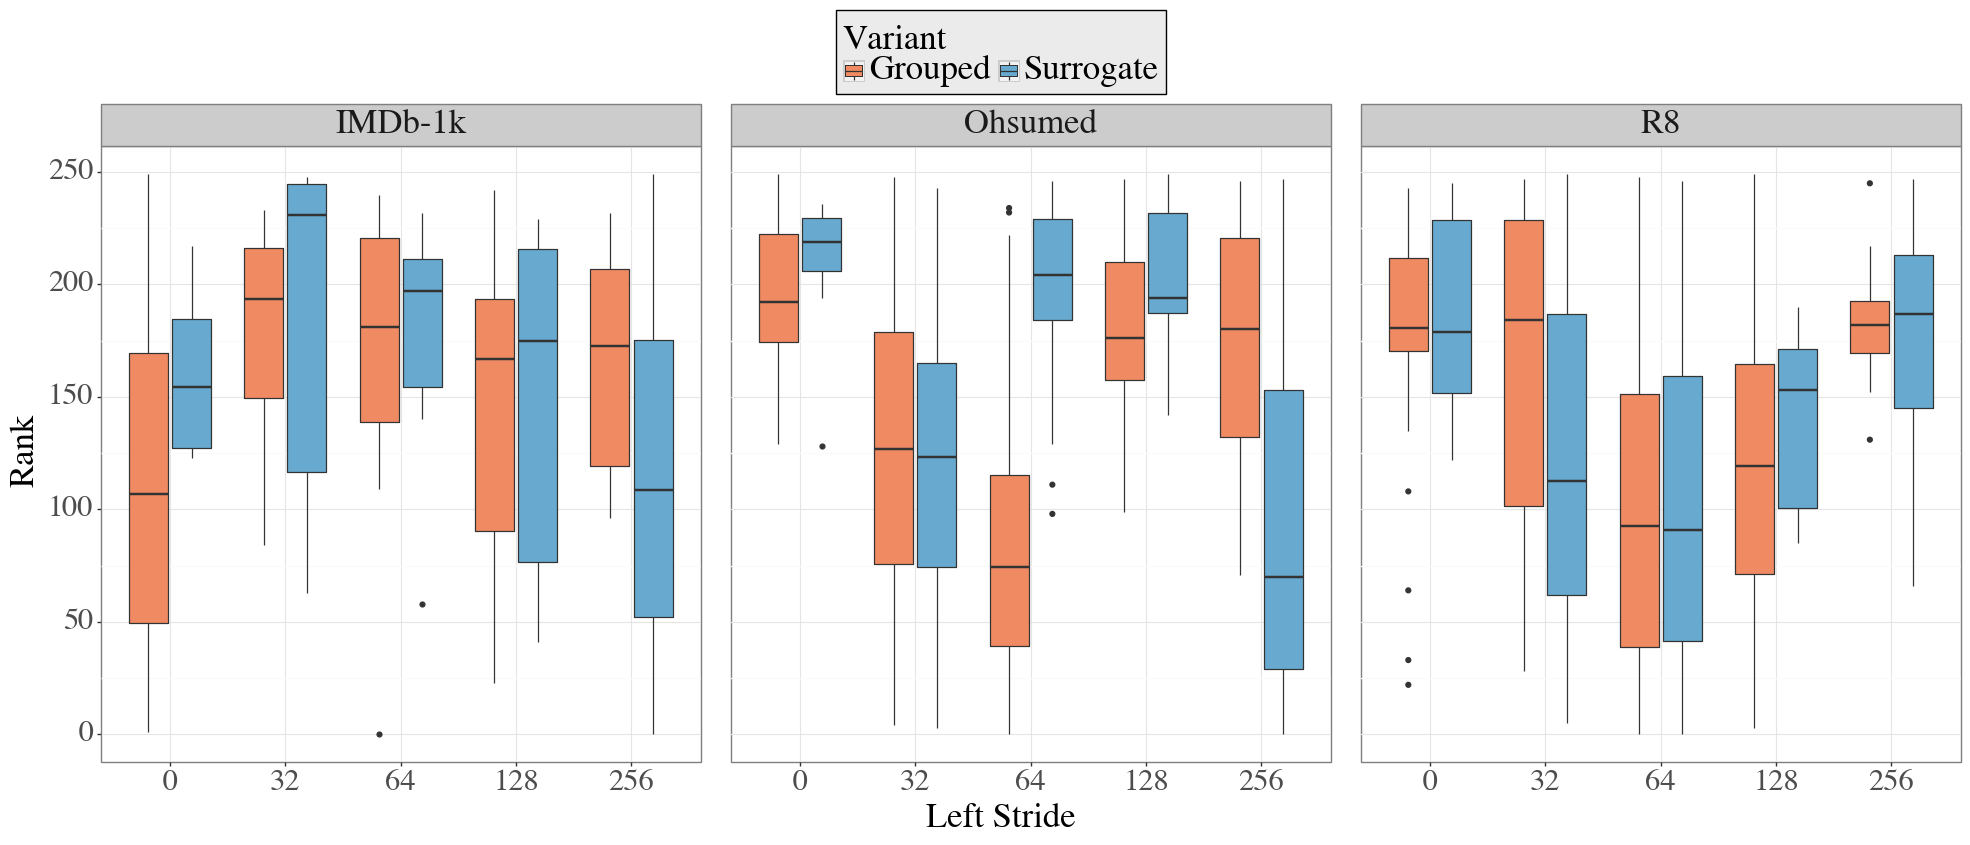

<ggplot: (812054676)>

In [265]:
p9.ggplot(bart_L_trials_df[bart_L_trials_df['dataset'] != 'SST-2'],
  p9.aes(x = 'params_left_stride', y = 'rank', fill = 'method')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Left Stride') + \
  p9.ylab('Rank') + \
  p9.facet_wrap('~dataset', ncol = 3, scales = 'free_x') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.labs(fill = 'Variant') + \
  p9.theme(
    legend_position = 'top',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
    subplots_adjust = {
      'hspace': 0.15,
      'wspace': 0.05
    }
  )

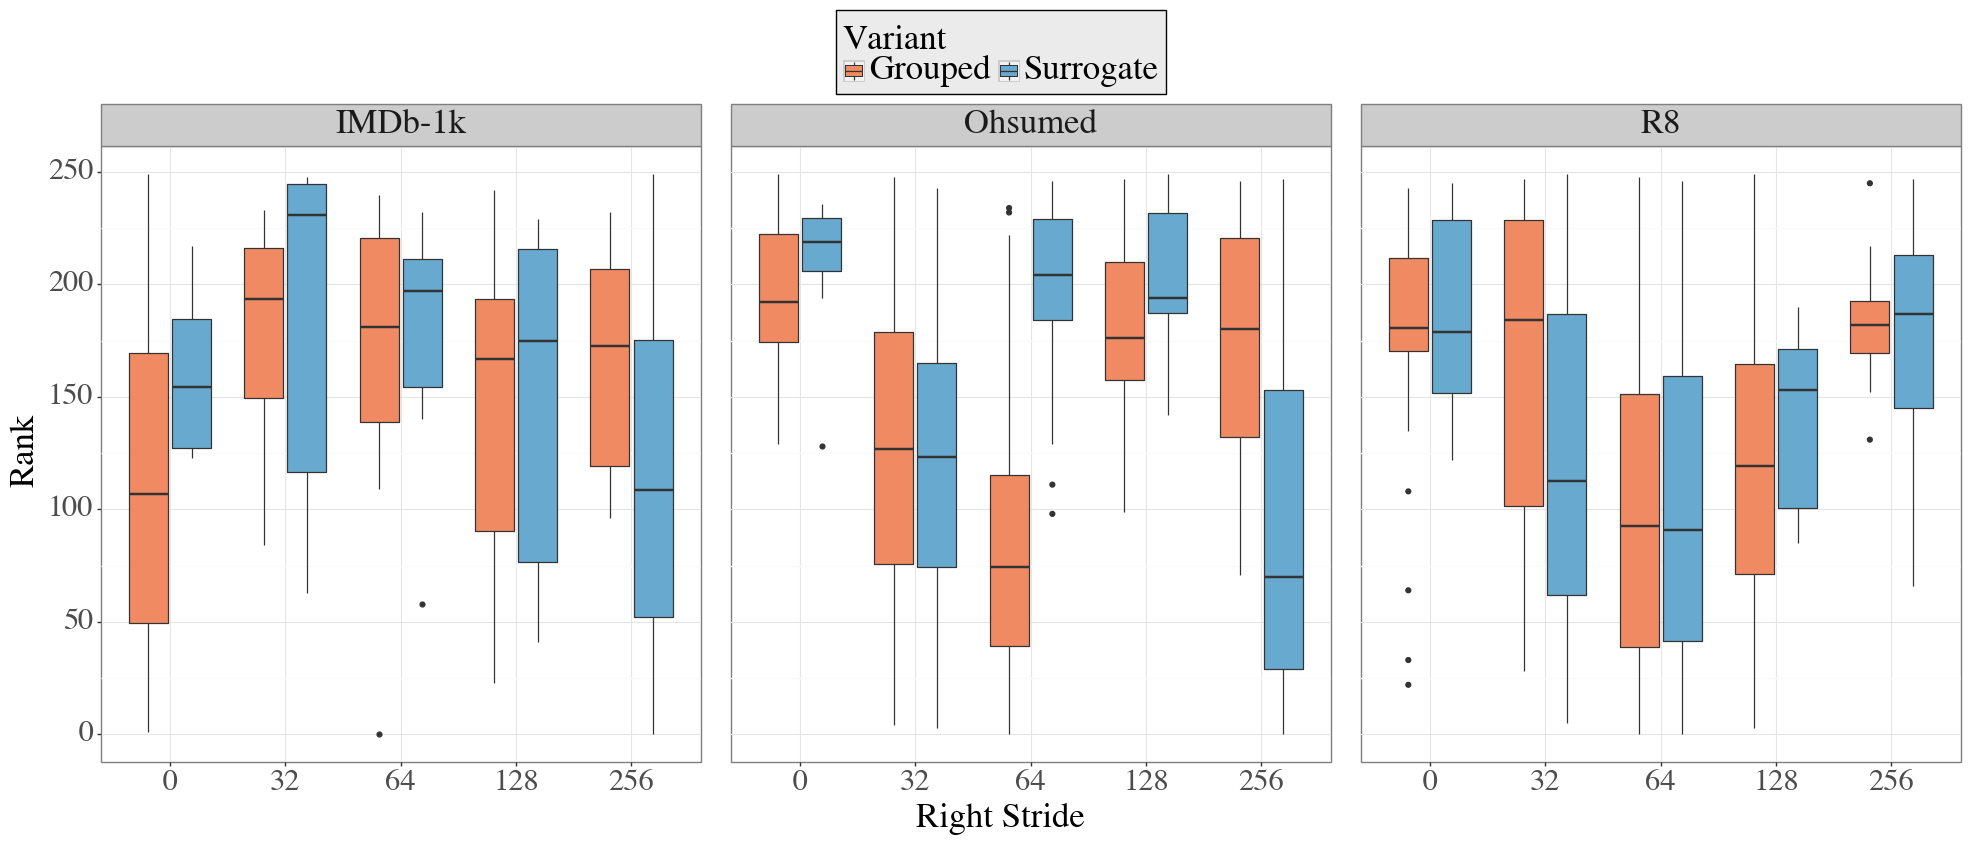

<ggplot: (812416748)>

In [266]:
p9.ggplot(bart_L_trials_df[bart_L_trials_df['dataset'] != 'SST-2'],
  p9.aes(x = 'params_right_stride', y = 'rank', fill = 'method')) + \
  p9.theme_bw() + \
  p9.geom_boxplot() + \
  p9.xlab('Right Stride') + \
  p9.ylab('Rank') + \
  p9.facet_wrap('~dataset', ncol = 3, scales = 'free_x') + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.labs(fill = 'Variant') + \
  p9.theme(
    legend_position = 'top',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 8),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
    subplots_adjust = {
      'hspace': 0.15,
      'wspace': 0.05
    }
  )

### Threshold

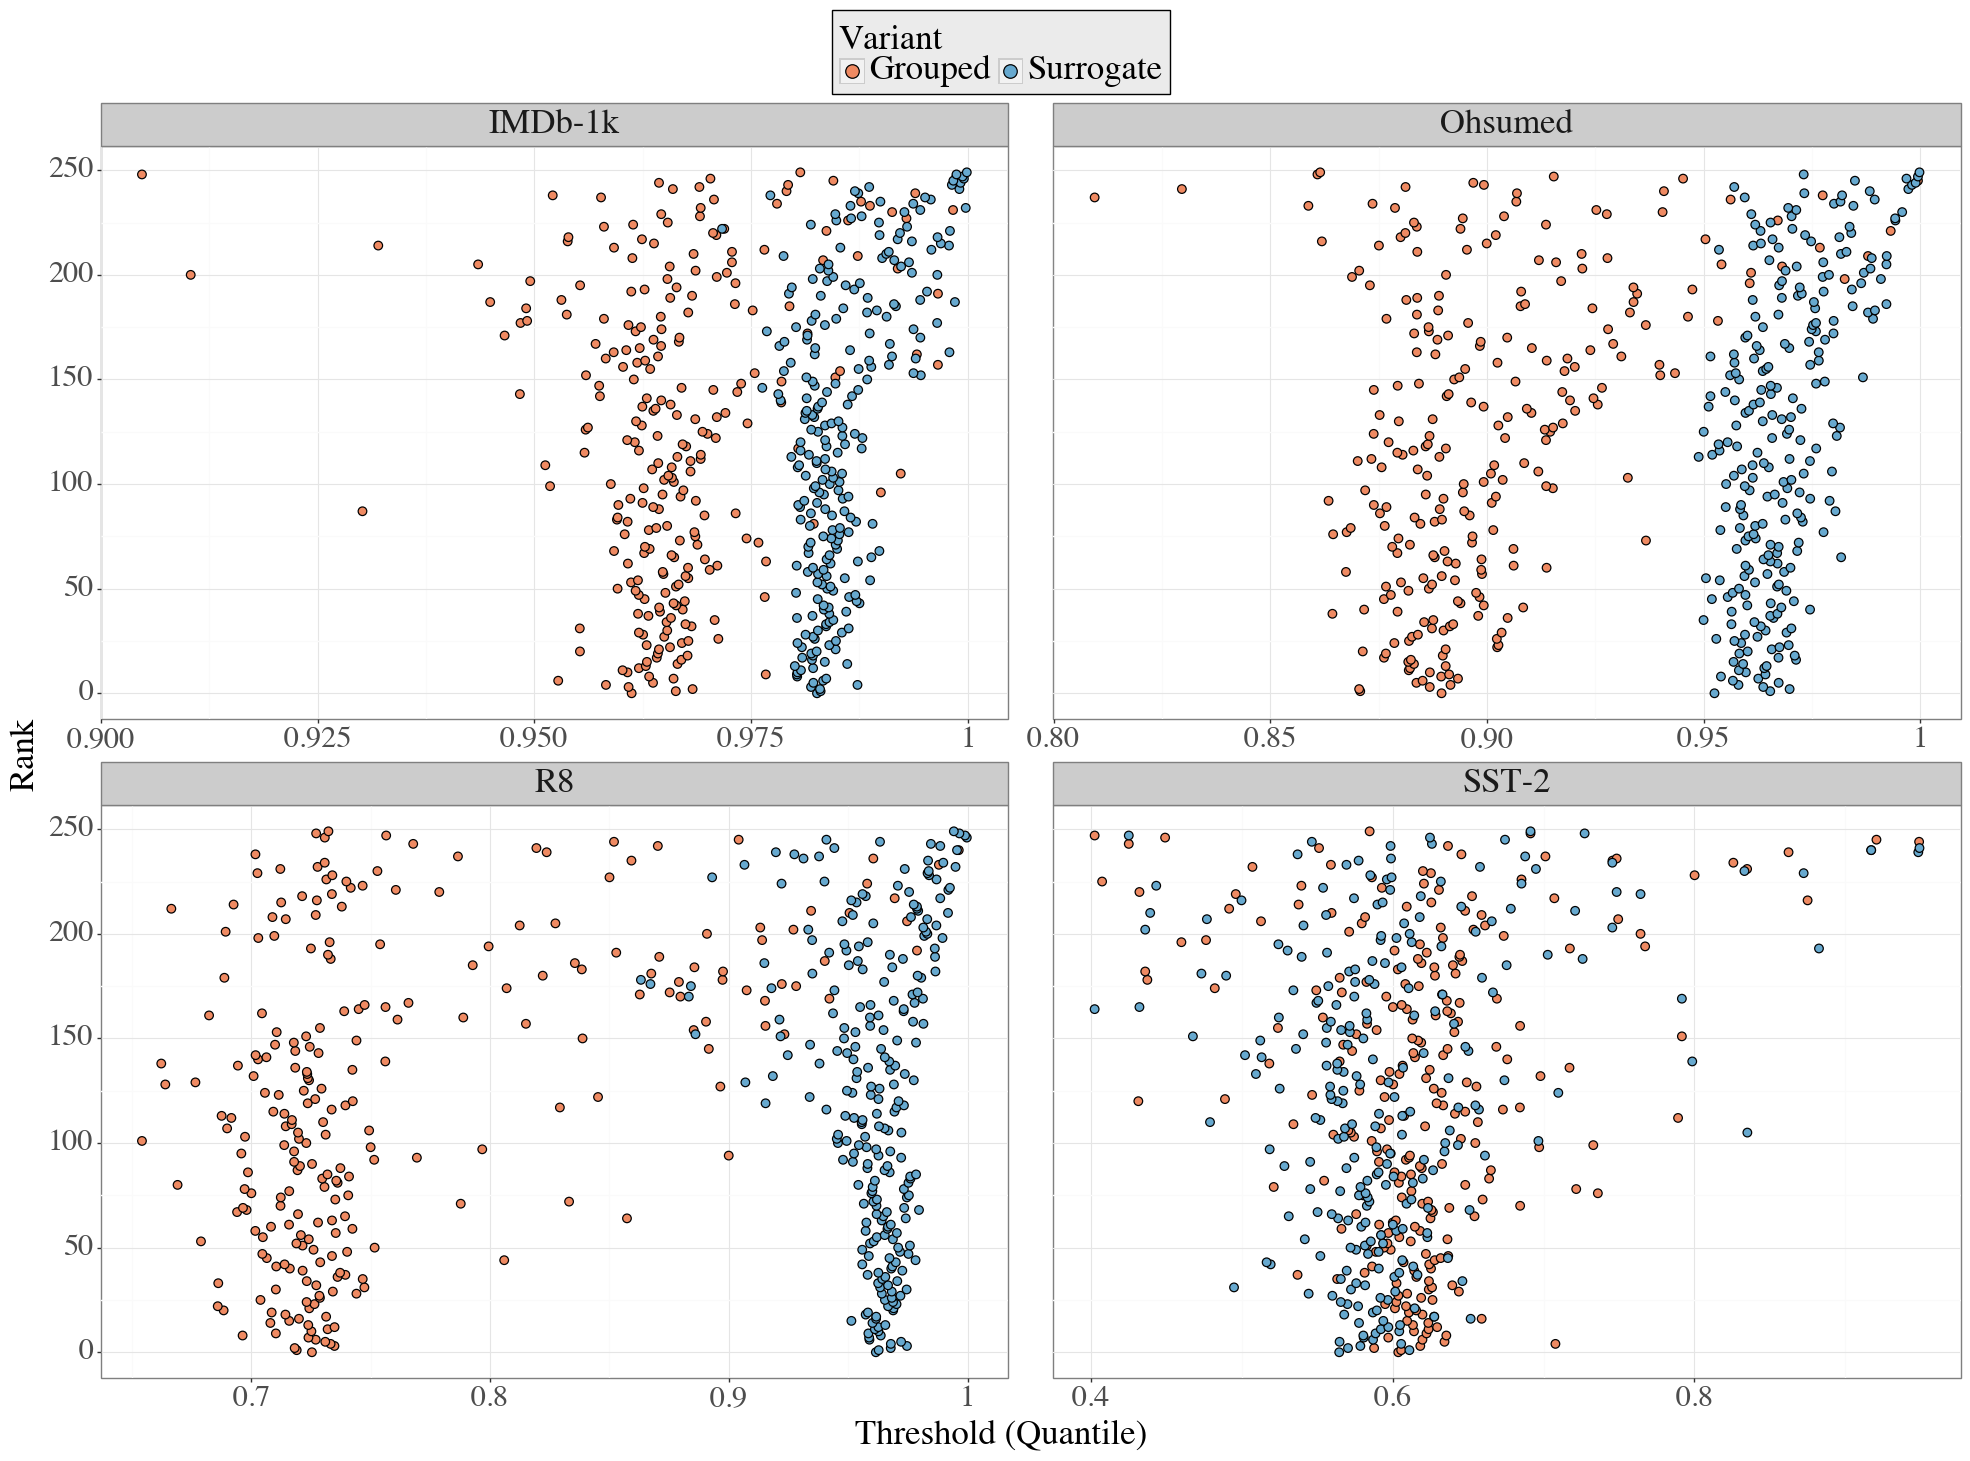

<ggplot: (811998452)>

In [267]:
p9.ggplot(bart_L_trials_df,
  p9.aes(x = 'params_threshold', y = 'rank', fill = 'method')) + \
  p9.theme_bw() + \
  p9.geom_point(size = 3, colour = '#000000') + \
  p9.xlab('Threshold (Quantile)') + \
  p9.ylab('Rank') + \
  p9.facet_wrap('~dataset', ncol = 2, scales = 'free_x') + \
  p9.guides(fill = p9.guide_legend(override_aes = {'size' : 5}), shape = p9.guide_legend(override_aes = {'size' : 5})) + \
  p9.scale_fill_manual(values = ['#ef8a62', '#67a9cf', '#ffd760', '#f7f7f7']) + \
  p9.labs(fill = 'Variant') + \
  p9.theme(
    legend_position = 'top',
    legend_background = p9.element_rect(color = '#000000', fill = '#ebebeb'),
    legend_box_margin = 0,
    figure_size = (24, 16),
    text = p9.element_text(size = 25, family = 'serif'),
    axis_text = p9.element_text(size = 22),
    axis_title = p9.element_text(weight = 'bold'),
    legend_title = p9.element_text(weight = 'bold'),
    subplots_adjust = {
      'hspace': 0.15,
      'wspace': 0.05
    }
  )